In [1]:
import sys
import os
import time
import argparse
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

current_time_millis = lambda: int(round(time.time() * 1000))

def read_data_with_labels(file, timeVariantColumns, labelColumnNum):
    df = pd.read_csv(file)
    data = df.values.astype('float64')
    tsData = df[timeVariantColumns].values.astype('float64')
    labels = data[:, labelColumnNum].reshape((-1, 1))
    tsDataWithLabels = np.hstack((tsData, labels))
    return tsDataWithLabels, data


def scale(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(data)
    return scaler, scaler.transform(data)


def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test


# input expected to be a 2D array with last column being label
# Returns looked back X (n_samples, n_steps, n_features) and Y (n_samples, 2);
# last column in looked back Y data returned is label
# Only one step ahead prediction setting is expected.

def look_back_and_create_dataset(tsDataWithLabels, look_back=1):
    lookbackTsDataX = []
    lookbackTsDataYAndLabel = []
    for i in range(look_back, len(tsDataWithLabels)):
        a = tsDataWithLabels[i - look_back:i, :-1]
        lookbackTsDataX.append(a)
        lookbackTsDataYAndLabel.append(tsDataWithLabels[i])
    return np.array(lookbackTsDataX), np.array(lookbackTsDataYAndLabel)


def get_train_validation(Xtrain, Ytrain, validation_ratio=0.1):
    validation_size = int(len(Xtrain) * validation_ratio)
    Xtrain, Xvalid = Xtrain[validation_size:], Xtrain[:validation_size]
    Ytrain, Yvalid = Ytrain[validation_size:], Ytrain[:validation_size]
    return Xtrain, Ytrain, Xvalid, Yvalid


def get_deviations(model, X, Y):
    deviations = np.absolute(Y - model.predict(X))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))
    return deviations


def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts=True)))
    return labels


def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), \
           recall_score(actual, predicted), f1_score(actual, predicted)


# Note here the slight change in how we stack the hidden LSTM layers - special for the last LSTM layer.
def baseline_model(input_shape, learning_rate):
    def build_model(input_shape=input_shape, n_hidden=1, n_units=50, learning_rate=learning_rate):
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=input_shape))
        for layer in range(n_hidden - 1):
            # return sequence = true for all layers except last layer
            model.add(keras.layers.LSTM(n_units, return_sequences=True, activation='relu'))
        model.add(keras.layers.LSTM(n_units, activation='relu'))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss="mse", optimizer=optimizer)
        return model

    return build_model


def plot_actuals_vs_predictions(actual_labels, predictedLabels):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
    plt.subplot(1, 2, 1)
    plt.plot(actual_labels, label='Actual')
    plt.legend(("Actual"), loc=2)

    plt.subplot(1, 2, 2)
    plt.plot(predictedLabels, label='Prediction', color='orange')
    plt.legend("Prediction", loc=2)
    plt.show()



def load_model_for_file(model_persisted_location, benchmark_folder, file_name):
    model_file_extension = '.h5'
    model_file_on_disk = model_persisted_location + os.sep + benchmark_folder \
                         + os.sep + file_name + model_file_extension
    print('Model file will be loaded from ', model_file_on_disk)
    loaded_model = keras.models.load_model(model_file_on_disk)
    return loaded_model


"""
The `perform_training_on_benchmark_directory` is a wrapper fucntion which calls data_read, look_back, split methords  

Description for each parameters

    benchmark_dir             - The full path to a folder where the data resides. This will be the path to a A* Benchmark folders.
    extension_pattern         - File name extension pattern for files of this folder.
    timeVariantColumns        – The time variant column specifies a list of values that changes in time.  In case of Yahoo! It’s the “value” column.
    labelColumnNum            – Specifies the column number which denotes if that record is anomaly or not.  The case of A1Benchmark and A2Benchmark folder the field is marked as “is_anomaly” whereas in case of A3Benchmark and A4Benchmark its “anomaly”
    param_distribs             - Distribution of parameters to search for best model using randomized search.
    files_to_process  - Specifies the number of files that needs to be processed per directory.  
    plot_graph                          – Specifies to plot graph or not for each file.    
    validation_ratio    - What fraction of Xtrain, Ytrain to be used for early stopping validation.
    early_stop_patience - Stop optimizing after how many successive epochs without further loss reduction
    epochs              - Total number of epochs to try and optimize loss.
    batch_size          - Size of batches in each epoch
    n_iter              - number of iterations
    cv                  - cv
    verbosity
    save_model 
"""


# Do it on each benchmark directory files
# def perform_training_on_benchmark_directory(benchmark_dir, extension, timeVariantColumns,
#                                             labelColumnNum, param_distribs, files_to_process='ALL', plot_graph=1,
#                                             validation_ratio=0.1, early_stop_patience=5, epochs=25, batch_size=32,
#                                             n_iter=1, cv=5, verbosity=0, save_model=0, file_name_preferred=None):
def perform_training_on_benchmark_directory(benchmark_dir, extension, timeVariantColumns,
                                            labelColumnNum, files_to_process='ALL', plot_graph=1,
                                            file_name_preferred=None):
    pctile = 99.5
    split = 0.8
    look_back = 24
    learning_rate = 0.001
    model_persisted_location = 'models-yahoo-lstm'
    loop_idx = 0;
    
    Benchmark_dir = YAHOO_DS + os.path.sep + benchmark_dir + os.path.sep
    benchmark_files = glob.glob(Benchmark_dir + extension, recursive=True)

    if files_to_process == 'ALL':
        num_files_to_process = len(benchmark_files)
    else:
        num_files_to_process = int(files_to_process)

    resultsMap = {}  # results from this folder
    files_to_walk = []
    if file_name_preferred is None:
        files_to_walk = benchmark_files[:num_files_to_process]
    else:
        files_to_walk.append(Benchmark_dir + file_name_preferred)
        num_files_to_process = 1;

    print('Processing {} files in folder {}'.format(num_files_to_process, benchmark_dir))
    # for file_name in benchmark_files[:num_files_to_process]:
    for file_name in files_to_walk:
        loop_idx += 1
        keras.backend.clear_session()
        print('File Name : ', file_name)

        short_fname = file_name[file_name.rindex(os.sep) + len(os.sep):]
        model = load_model_for_file(model_persisted_location, benchmark_dir, short_fname)
        # read data
        tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)
        print("Shapes: time variant data with labels {}, full data {}".format(tsDataWithLabels.shape, data.shape))

        # scale data
        scaler, tsDataScaled = scale(tsDataWithLabels)

        # Get look back data in the 3D array shape
        lookbackX, lookbackY = look_back_and_create_dataset(tsDataScaled, look_back=look_back)
        print("Look back data shapes: lookbackX {} lookbackY {}".format(lookbackX.shape, lookbackY.shape))

        # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
        predictedLabels = get_records_above_deviation_pctile(model, lookbackX, lookbackY[:, :-1], pctile)

        end_millis = current_time_millis()

        # actual is_anomaly labels in dataset
        actual_labels = (data[look_back:, labelColumnNum] != 0.0).astype('int')
        print("Actual is_anomaly labels in data", np.unique(actual_labels, return_counts=True))

        # Compare calculated labels and actual labels to find confusion matrix, precision, recall, and F1
        conf_matrix, prec, recall, f1 = get_classification_metrics(actual_labels, predictedLabels)
        print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall,
                                                                                             f1))
        print("Time to predict and get records above deviation : {} ms".format(end_millis - start_millis))

        resultsMap[file_name] = {'predict_time': (end_millis - start_millis),
                                 'precision': prec, 'recall': recall, 'f1': f1, 'confusion_matrix': conf_matrix}

        if plot_graph == 1:
            plot_actuals_vs_predictions(actual_labels, predictedLabels )
            
    return resultsMap


def print_summary_for_benchmark_folder(resultsMap, benchmark_folder):
    precisions = []
    recalls = []
    f1s = []
    times = []
    for v in resultsMap.values():
        precisions.append(v['precision'])
        recalls.append(v['recall'])
        f1s.append(v['f1'])
        #times.append(v['traintime'])
    avg_prec = np.average(np.array(precisions))
    avg_recall = np.average(np.array(recalls))
    avg_f1 = np.average(np.array(f1s))
    
    min_prec = min(np.array(precisions))
    min_recall = min(np.array(recalls))
    min_f1 = min(np.array(f1s))
    
    max_prec = max(np.array(precisions))
    max_recall = max(np.array(recalls))
    max_f1 = max(np.array(f1s))
    
    print(benchmark_folder)   
    print("     Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(avg_prec, avg_recall, avg_f1))
    print("     Min precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(min_prec, min_recall, min_f1))
    print("     Max precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(max_prec, max_recall, max_f1))
    
    plt.figure(figsize=(40,10))
    plt.plot(precisions, label ='Precisions')
    plt.plot(recalls, label ='Recall')
    plt.plot(f1s, label ='F1s')
    plt.legend(("Precisions", 'Recall', "F1"), loc=3)
    plt.show()
    

Processing 67 files in folder A1Benchmark
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_1.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [1.70660949e-05], Max [0.89037086]
Deviation 99.5th pctile [0.31352308]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1389,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1394,    2]))
Confusion matrix 
[[1389    5]
 [   0    2]]
precision 0.28571, recall 1.00000, f1 0.44444
Time to predict and get records above deviation : 1677 ms


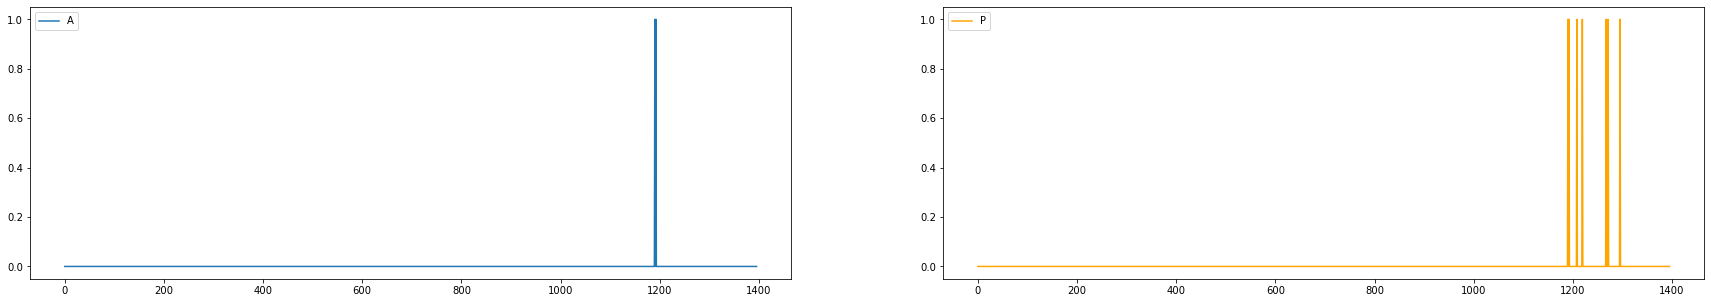

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_10.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_10.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [1.98021547e-05], Max [0.53934467]
Deviation 99.5th pctile [0.44265163]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1402,   13]))
Confusion matrix 
[[1402    0]
 [   5    8]]
precision 1.00000, recall 0.61538, f1 0.76190
Time to predict and get records above deviation : 3767 ms


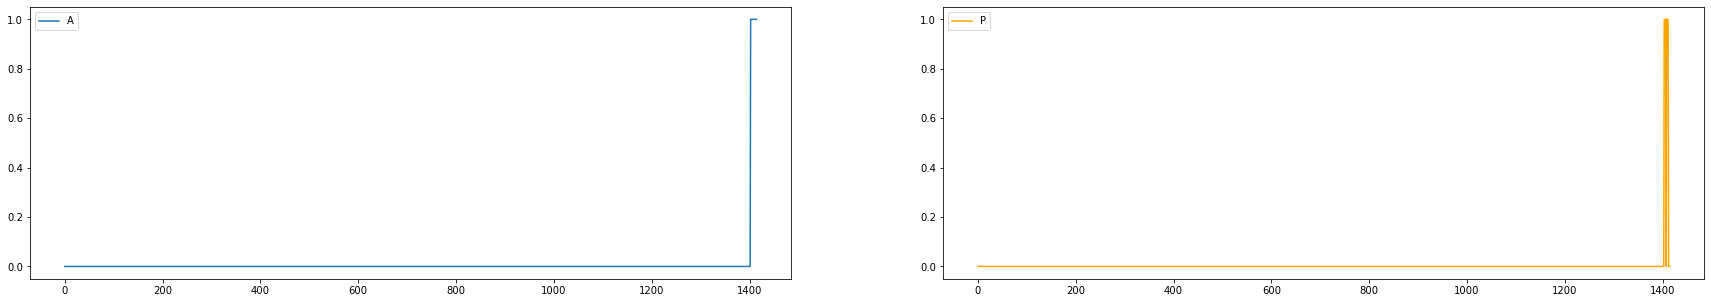

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_11.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_11.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [4.32044794e-06], Max [0.91186192]
Deviation 99.5th pctile [0.18813323]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,   19]))
Confusion matrix 
[[1396    0]
 [  11    8]]
precision 1.00000, recall 0.42105, f1 0.59259
Time to predict and get records above deviation : 6006 ms


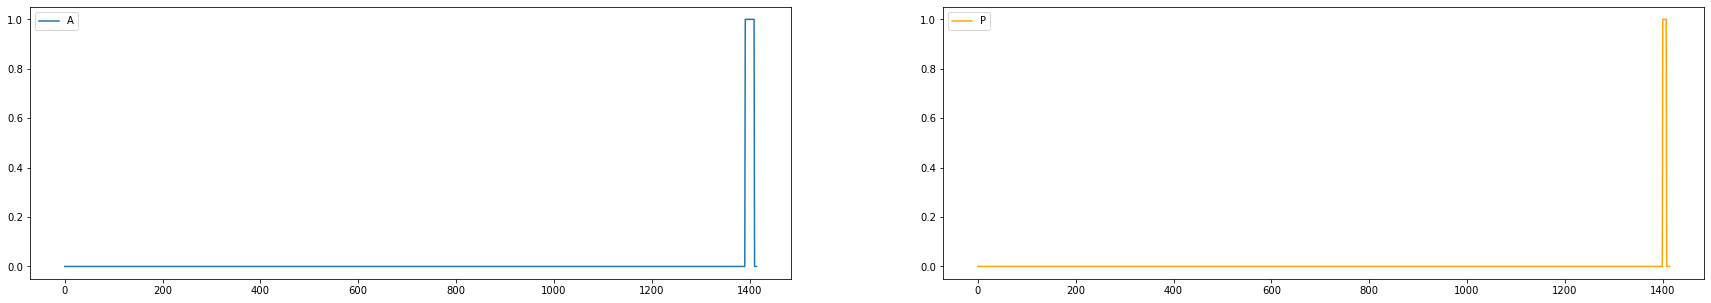

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_12.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_12.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [6.28074895e-06], Max [0.96782994]
Deviation 99.5th pctile [0.05754967]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1412,    3]))
Confusion matrix 
[[1407    5]
 [   0    3]]
precision 0.37500, recall 1.00000, f1 0.54545
Time to predict and get records above deviation : 8478 ms


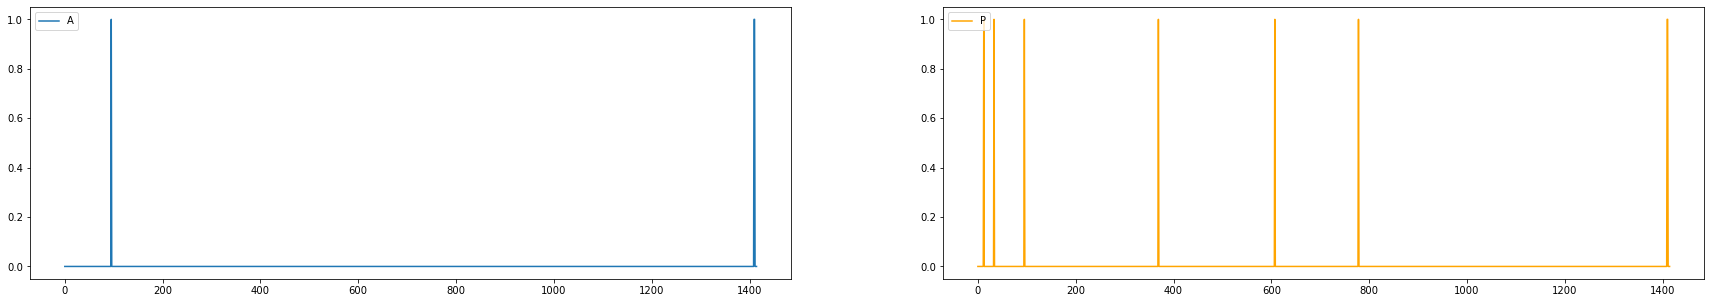

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_13.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_13.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [2.45542771e-05], Max [0.38568509]
Deviation 99.5th pctile [0.19705808]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1403,   12]))
Confusion matrix 
[[1402    1]
 [   5    7]]
precision 0.87500, recall 0.58333, f1 0.70000
Time to predict and get records above deviation : 9969 ms


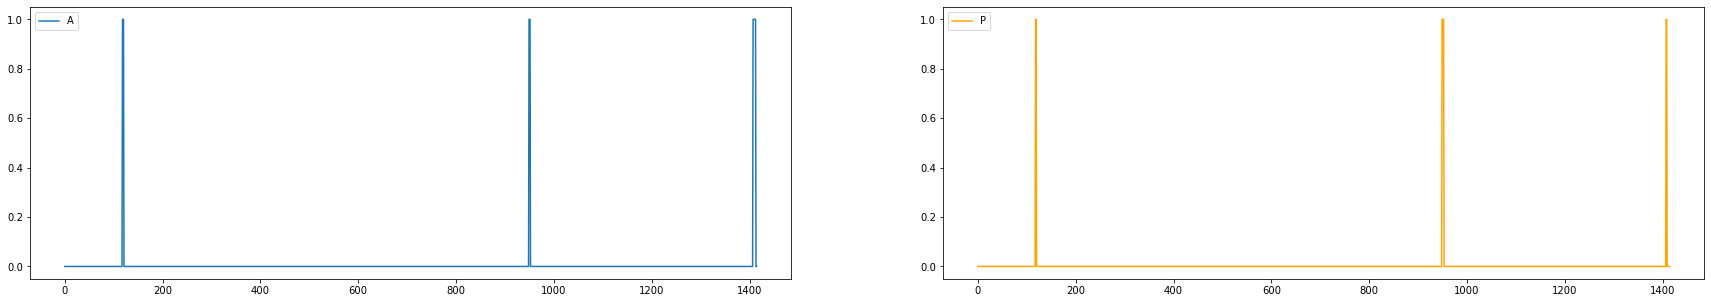

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_14.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_14.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [1.80043972e-05], Max [0.93118238]
Deviation 99.5th pctile [0.2159324]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1413,    2]))
Confusion matrix 
[[1406    7]
 [   1    1]]
precision 0.12500, recall 0.50000, f1 0.20000
Time to predict and get records above deviation : 11501 ms


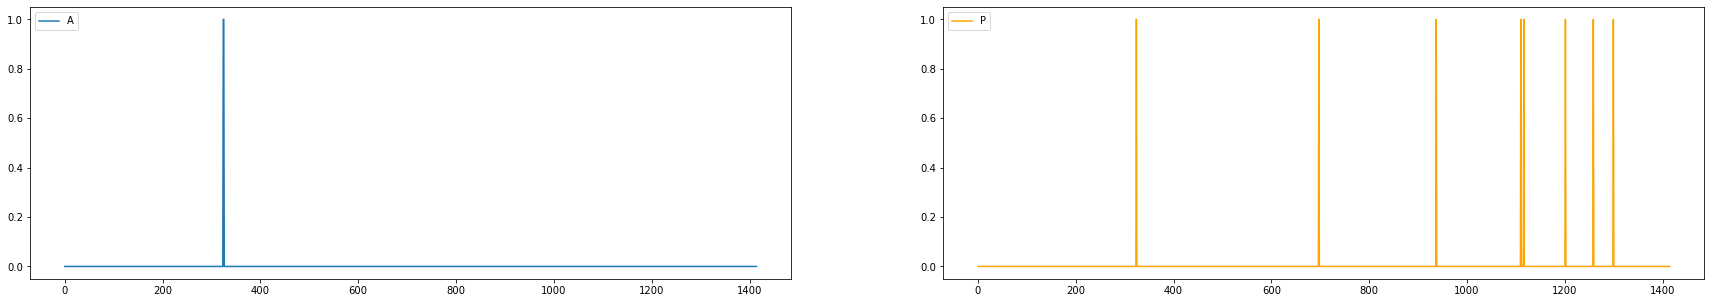

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_15.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_15.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [2.58734239e-05], Max [0.40675829]
Deviation 99.5th pctile [0.14511364]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1405,   10]))
Confusion matrix 
[[1404    1]
 [   3    7]]
precision 0.87500, recall 0.70000, f1 0.77778
Time to predict and get records above deviation : 12962 ms


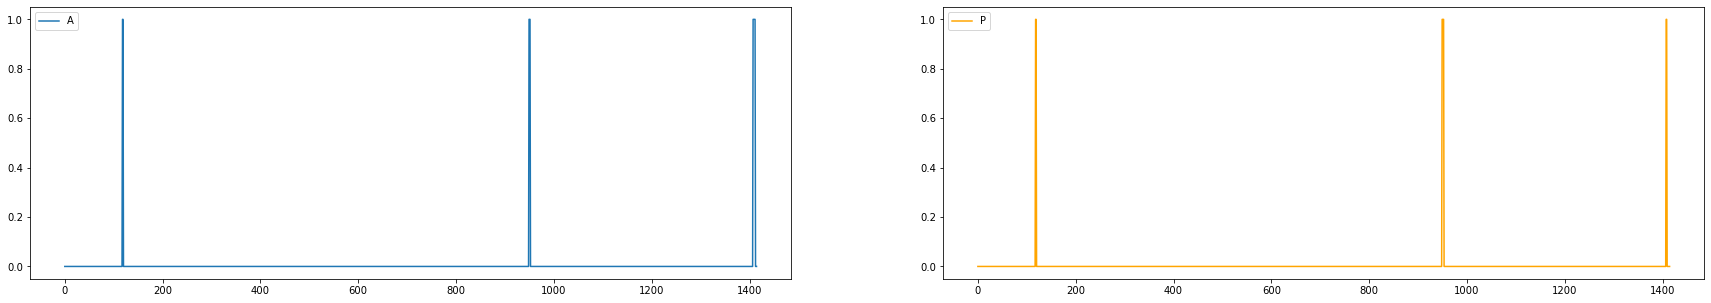

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_16.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_16.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [9.82775388e-06], Max [0.97454285]
Deviation 99.5th pctile [0.01843547]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1434,    3]))
Confusion matrix 
[[1429    5]
 [   0    3]]
precision 0.37500, recall 1.00000, f1 0.54545
Time to predict and get records above deviation : 14802 ms


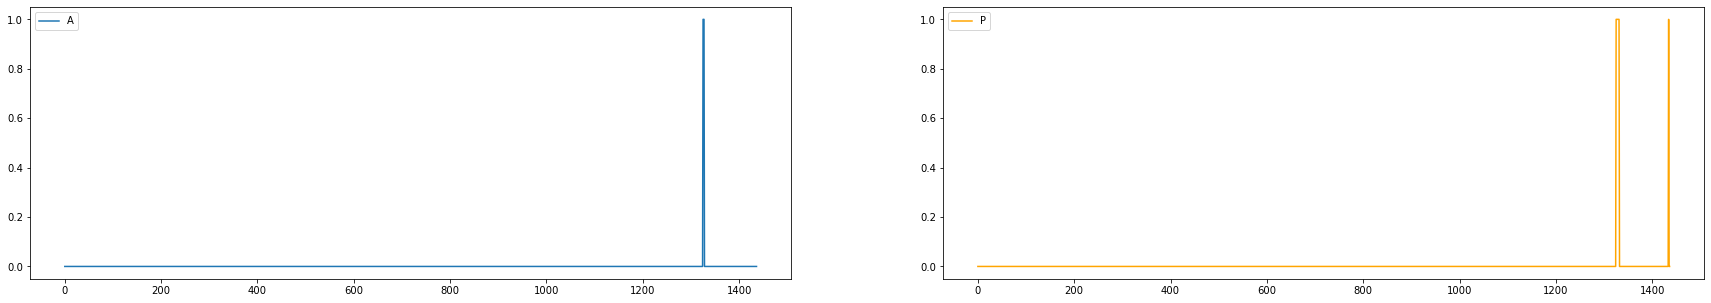

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_17.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_17.csv.h5
Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [2.11678444e-05], Max [0.65343049]
Deviation 99.5th pctile [0.45783908]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1393,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1173,  227]))
Confusion matrix 
[[1173    0]
 [ 220    7]]
precision 1.00000, recall 0.03084, f1 0.05983
Time to predict and get records above deviation : 16427 ms


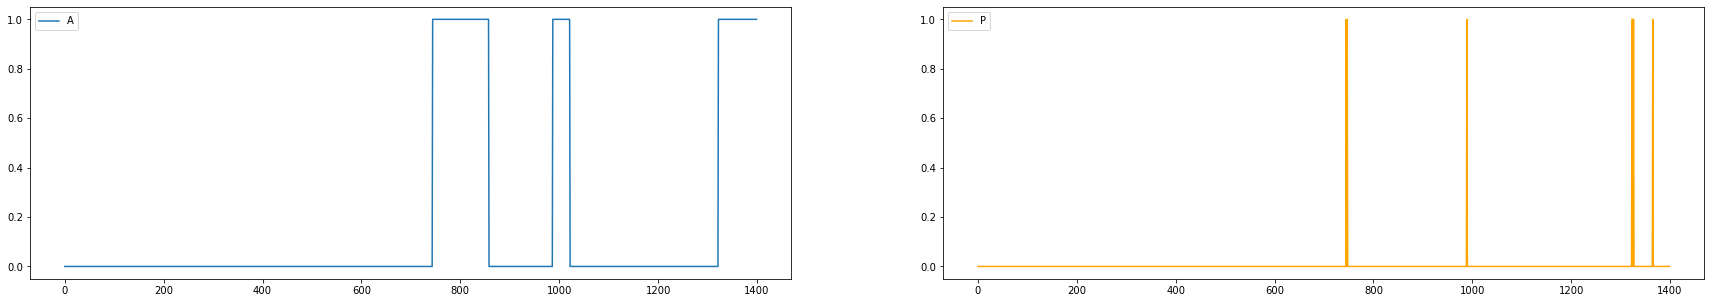

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_18.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_18.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [3.51182605e-05], Max [0.45158428]
Deviation 99.5th pctile [0.26001858]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1434,    3]))
Confusion matrix 
[[1429    5]
 [   0    3]]
precision 0.37500, recall 1.00000, f1 0.54545
Time to predict and get records above deviation : 18245 ms


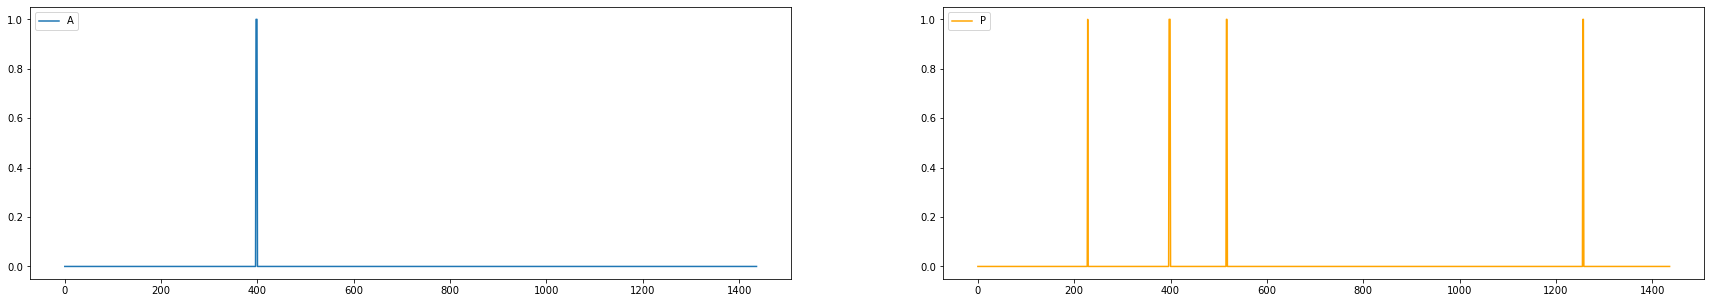

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_19.csv.h5
Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [4.59710713e-06], Max [0.70223014]
Deviation 99.5th pctile [0.53277663]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1393,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1173,  227]))
Confusion matrix 
[[1173    0]
 [ 220    7]]
precision 1.00000, recall 0.03084, f1 0.05983
Time to predict and get records above deviation : 20103 ms


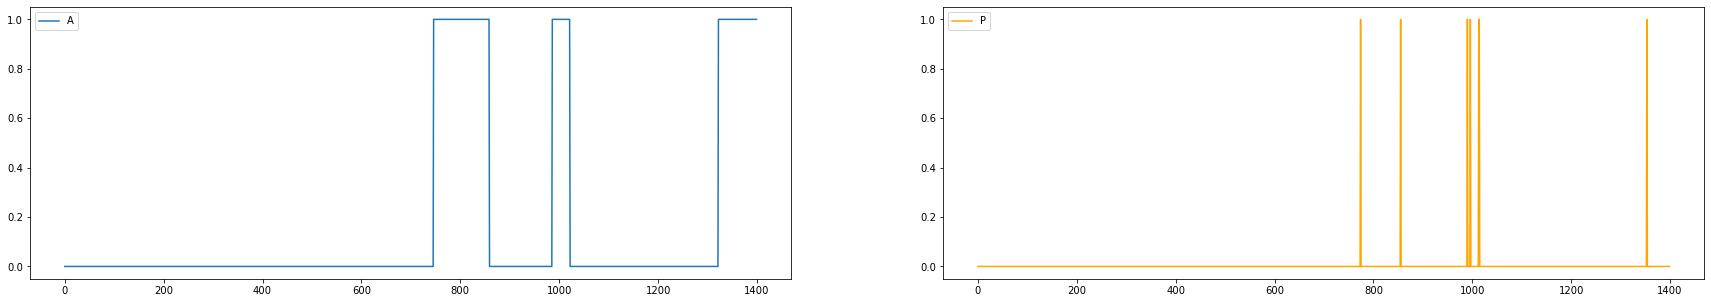

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_2.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_2.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [3.33242546e-06], Max [0.94163865]
Deviation 99.5th pctile [0.13876405]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1399,   16]))
Confusion matrix 
[[1399    0]
 [   8    8]]
precision 1.00000, recall 0.50000, f1 0.66667
Time to predict and get records above deviation : 21685 ms


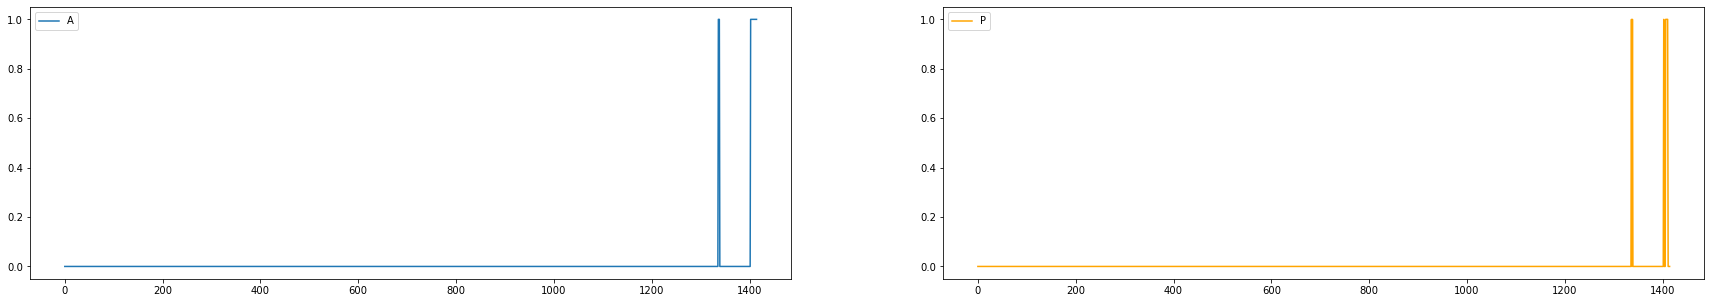

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_20.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_20.csv.h5
Shapes: time variant data with labels (1422, 2), full data (1422, 3)
Look back data shapes: lookbackX (1398, 24, 1) lookbackY (1398, 2)
Deviation Min [2.09881685e-05], Max [0.96531441]
Deviation 99.5th pctile [0.10437151]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1391,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1365,   33]))
Confusion matrix 
[[1360    5]
 [  31    2]]
precision 0.28571, recall 0.06061, f1 0.10000
Time to predict and get records above deviation : 23380 ms


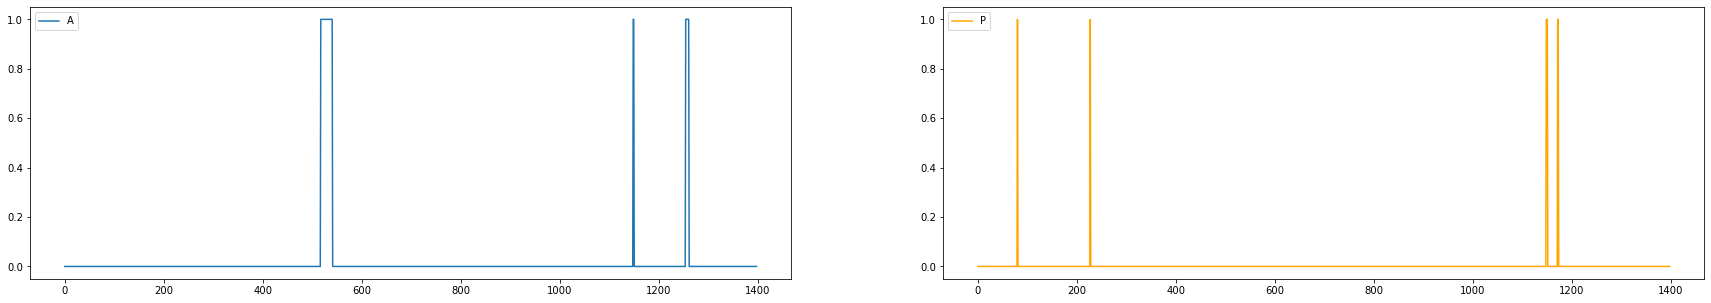

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_21.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_21.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [8.61759106e-06], Max [0.95459095]
Deviation 99.5th pctile [0.10485433]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1389,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1390,    6]))
Confusion matrix 
[[1389    1]
 [   0    6]]
precision 0.85714, recall 1.00000, f1 0.92308
Time to predict and get records above deviation : 25166 ms


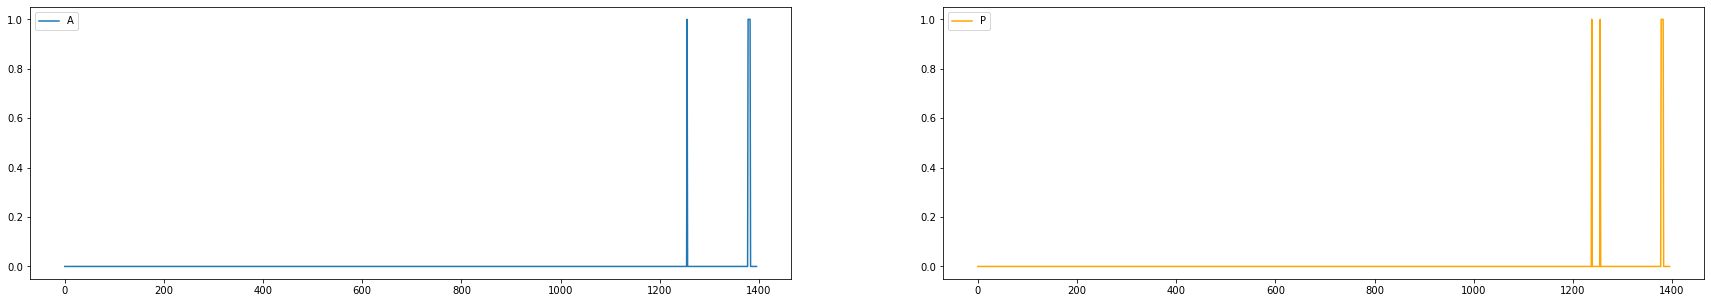

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_22.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_22.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [5.21849825e-06], Max [0.89957299]
Deviation 99.5th pctile [0.7096997]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1389,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1333,   63]))
Confusion matrix 
[[1333    0]
 [  56    7]]
precision 1.00000, recall 0.11111, f1 0.20000
Time to predict and get records above deviation : 27611 ms


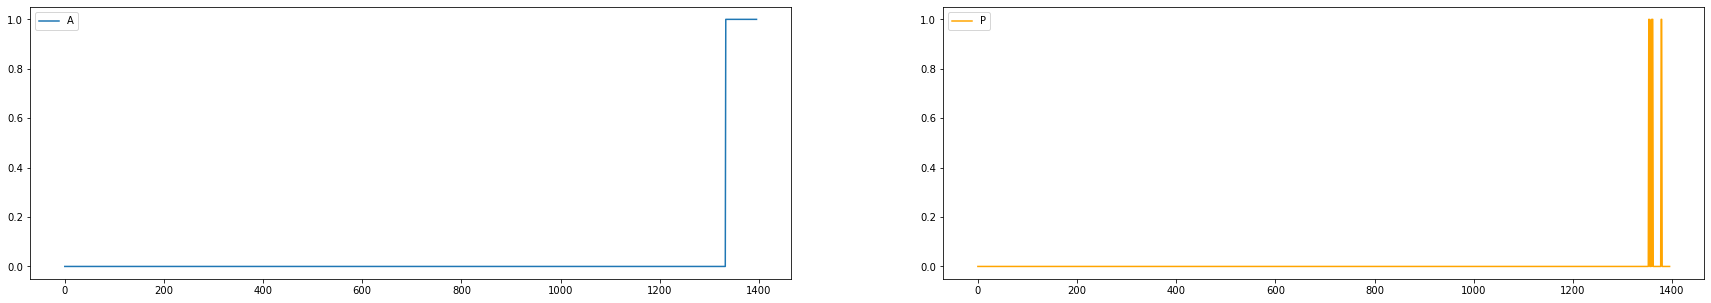

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_23.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_23.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [4.13556963e-05], Max [0.66681925]
Deviation 99.5th pctile [0.4854162]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1389,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1377,   19]))
Confusion matrix 
[[1377    0]
 [  12    7]]
precision 1.00000, recall 0.36842, f1 0.53846
Time to predict and get records above deviation : 29413 ms


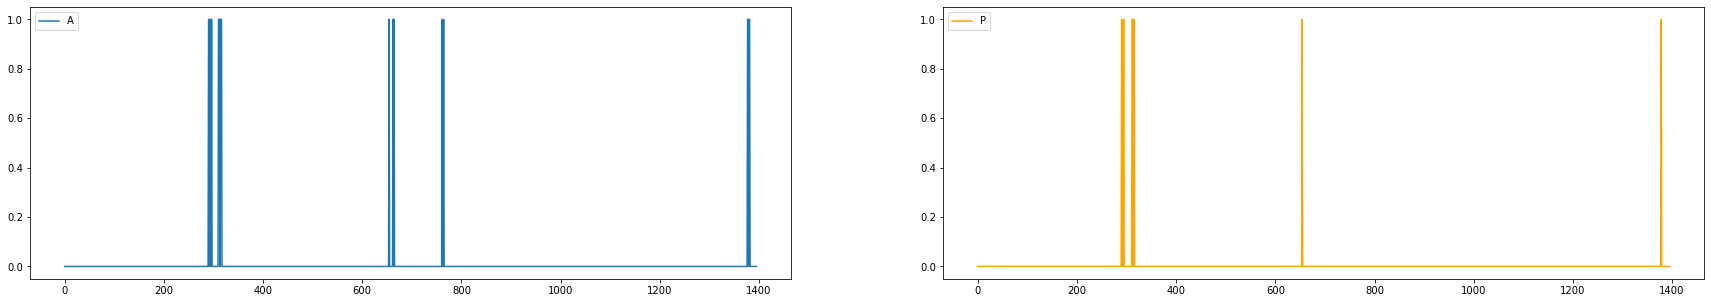

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_24.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_24.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [0.00011314], Max [0.54604913]
Deviation 99.5th pctile [0.36004327]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1421,   16]))
Confusion matrix 
[[1421    0]
 [   8    8]]
precision 1.00000, recall 0.50000, f1 0.66667
Time to predict and get records above deviation : 30824 ms


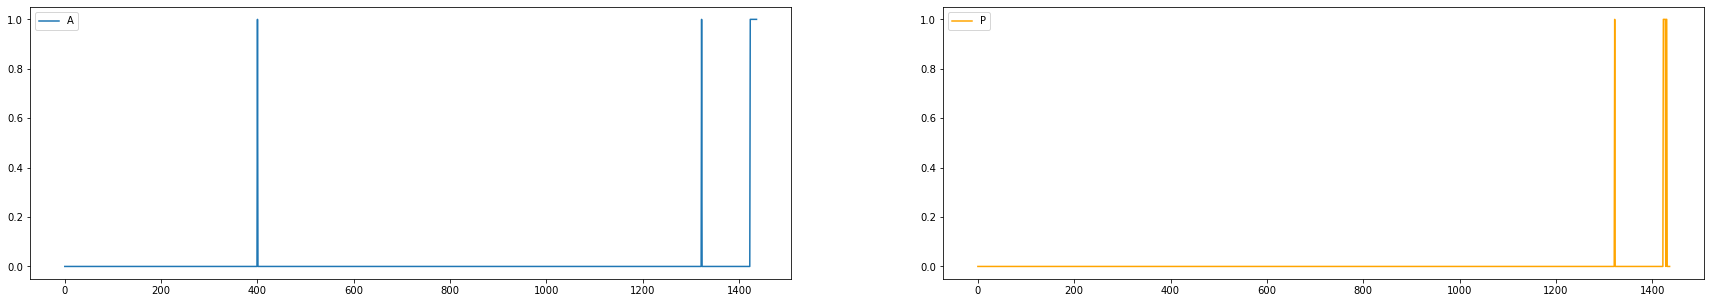

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_25.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_25.csv.h5
Shapes: time variant data with labels (1435, 2), full data (1435, 3)
Look back data shapes: lookbackX (1411, 24, 1) lookbackY (1411, 2)
Deviation Min [2.22020395e-06], Max [0.94026108]
Deviation 99.5th pctile [0.76873096]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1403,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1368,   43]))
Confusion matrix 
[[1368    0]
 [  35    8]]
precision 1.00000, recall 0.18605, f1 0.31373
Time to predict and get records above deviation : 33345 ms


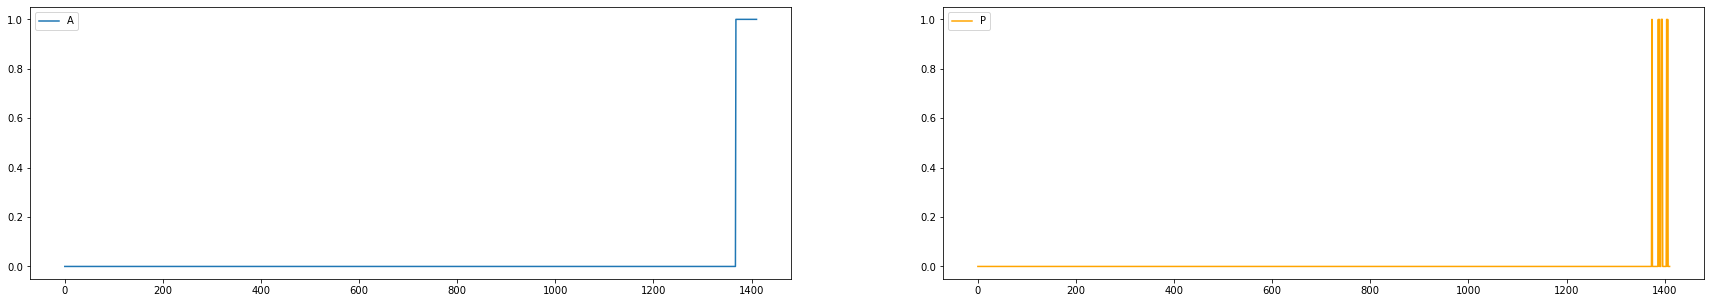

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_26.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_26.csv.h5
Shapes: time variant data with labels (1435, 2), full data (1435, 3)
Look back data shapes: lookbackX (1411, 24, 1) lookbackY (1411, 2)
Deviation Min [7.43301424e-05], Max [0.76466233]
Deviation 99.5th pctile [0.51406544]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1403,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1336,   75]))
Confusion matrix 
[[1328    8]
 [  75    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 35268 ms


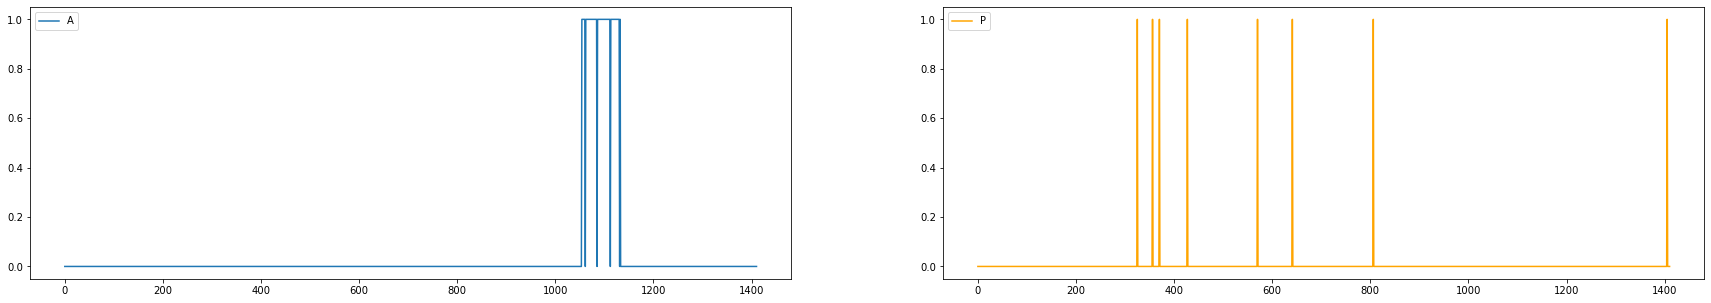

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_27.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_27.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [2.81317039e-05], Max [0.73074996]
Deviation 99.5th pctile [0.15283053]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1401,    2]))
Confusion matrix 
[[1395    6]
 [   0    2]]
precision 0.25000, recall 1.00000, f1 0.40000
Time to predict and get records above deviation : 36935 ms


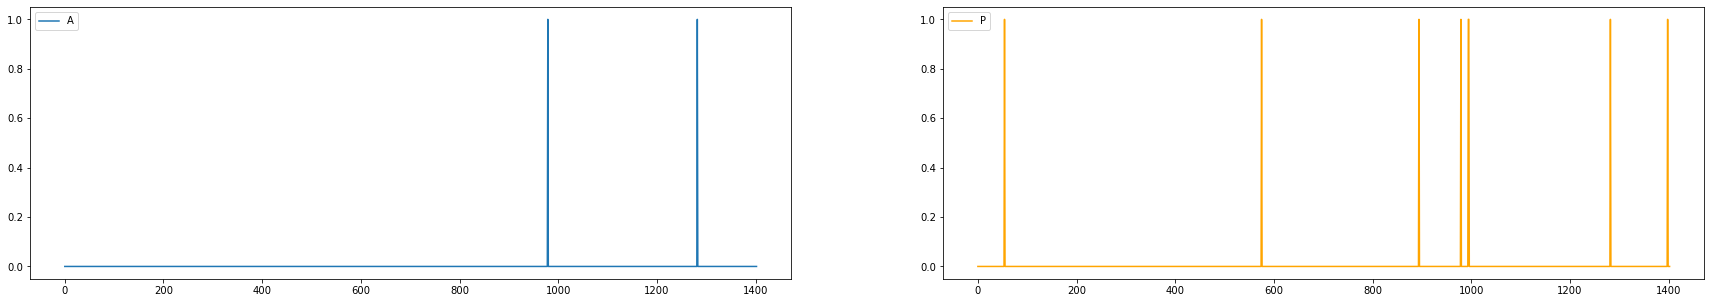

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_28.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_28.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [3.03705998e-05], Max [3.61937014]
Deviation 99.5th pctile [2.46904393]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1335,   82]))
Confusion matrix 
[[1327    8]
 [  82    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 38997 ms


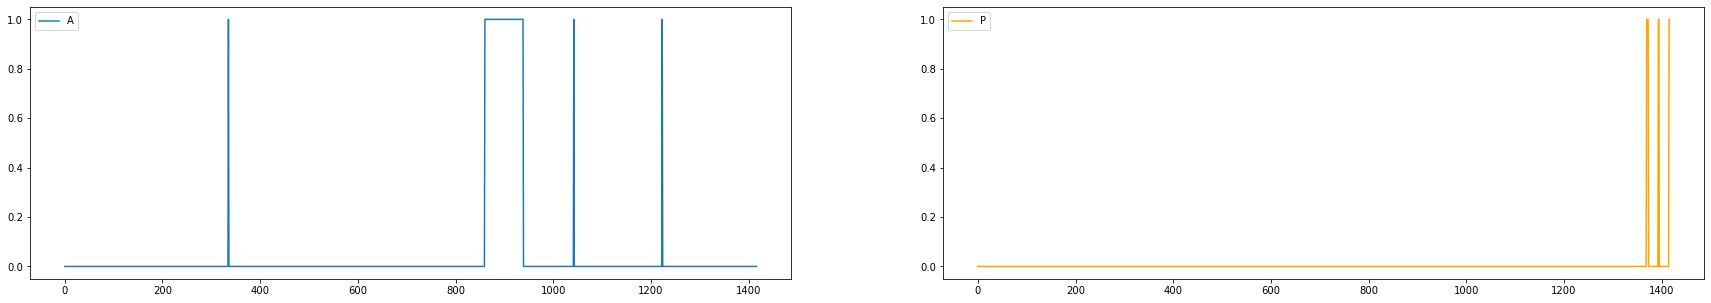

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_29.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_29.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [0.00018775], Max [0.67468332]
Deviation 99.5th pctile [0.17522435]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1410,    7]))
Confusion matrix 
[[1407    3]
 [   2    5]]
precision 0.62500, recall 0.71429, f1 0.66667
Time to predict and get records above deviation : 40636 ms


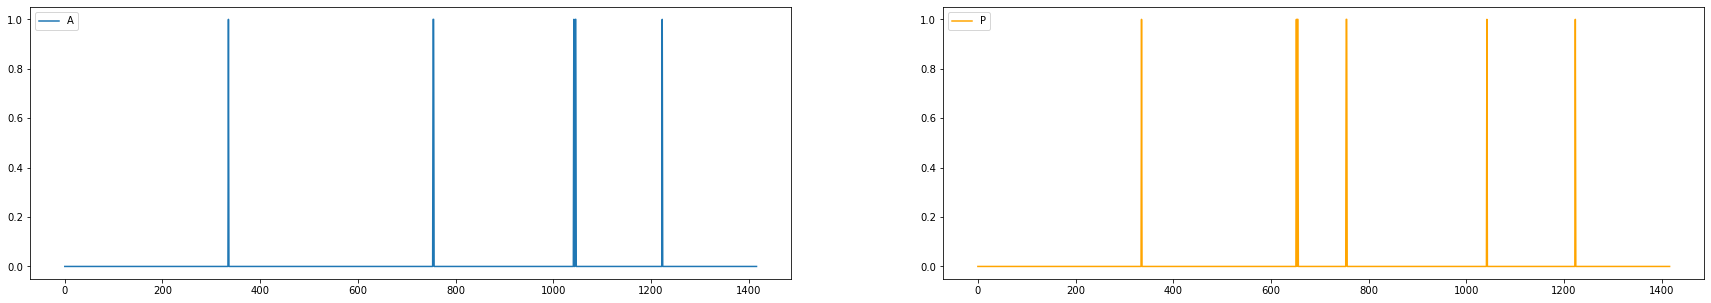

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_3.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_3.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [2.41680113e-05], Max [0.80846584]
Deviation 99.5th pctile [0.43670454]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1422,   15]))
Confusion matrix 
[[1422    0]
 [   7    8]]
precision 1.00000, recall 0.53333, f1 0.69565
Time to predict and get records above deviation : 42075 ms


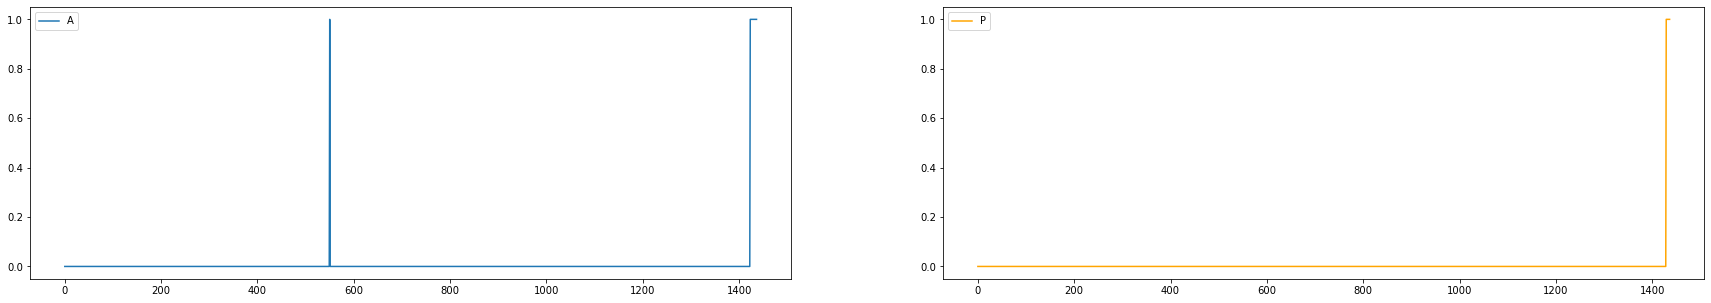

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_30.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_30.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [1.51331065e-05], Max [0.65194401]
Deviation 99.5th pctile [0.23830351]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1428,    9]))
Confusion matrix 
[[1428    0]
 [   1    8]]
precision 1.00000, recall 0.88889, f1 0.94118
Time to predict and get records above deviation : 44062 ms


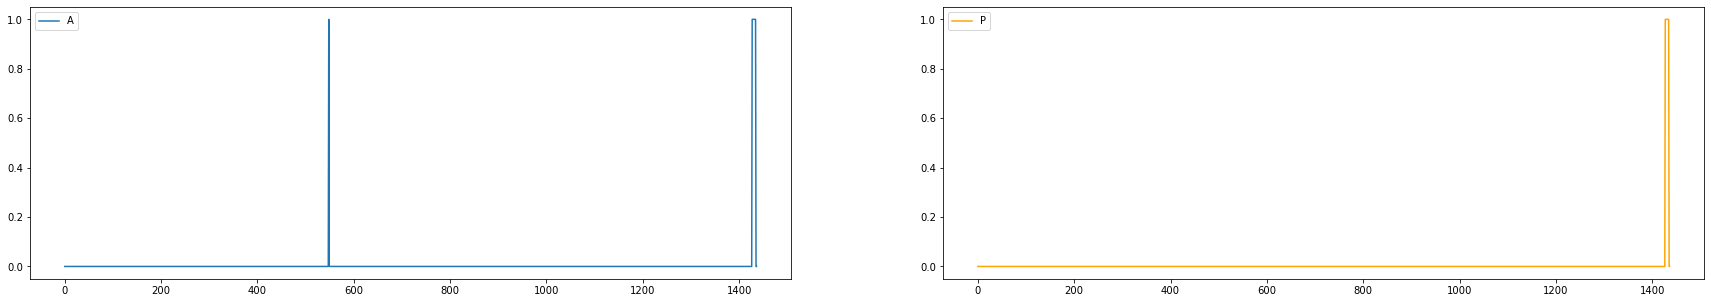

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_31.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_31.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [4.32608346e-05], Max [0.96461833]
Deviation 99.5th pctile [0.65187448]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1379,   24]))
Confusion matrix 
[[1379    0]
 [  16    8]]
precision 1.00000, recall 0.33333, f1 0.50000
Time to predict and get records above deviation : 46297 ms


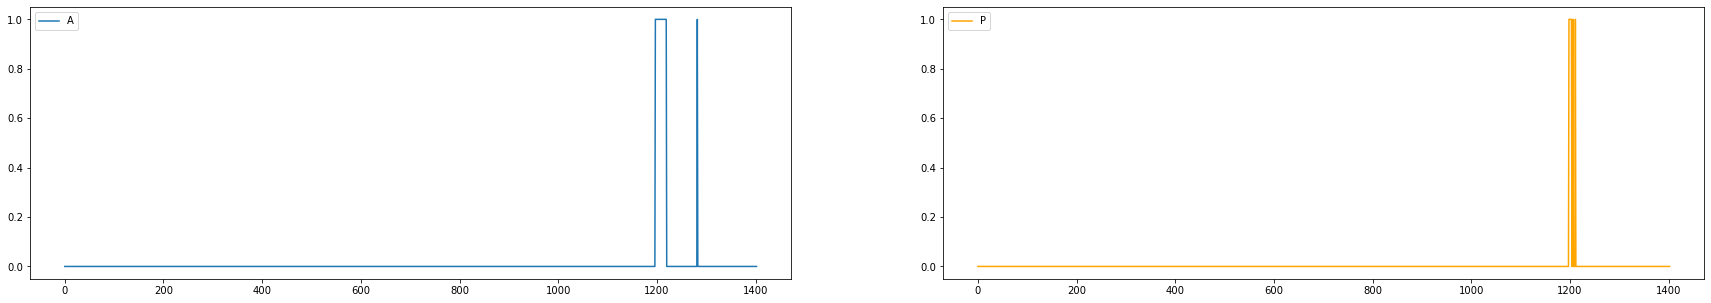

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_32.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_32.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [3.76135233e-05], Max [0.92483937]
Deviation 99.5th pctile [0.60941003]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1356,   47]))
Confusion matrix 
[[1356    0]
 [  39    8]]
precision 1.00000, recall 0.17021, f1 0.29091
Time to predict and get records above deviation : 47739 ms


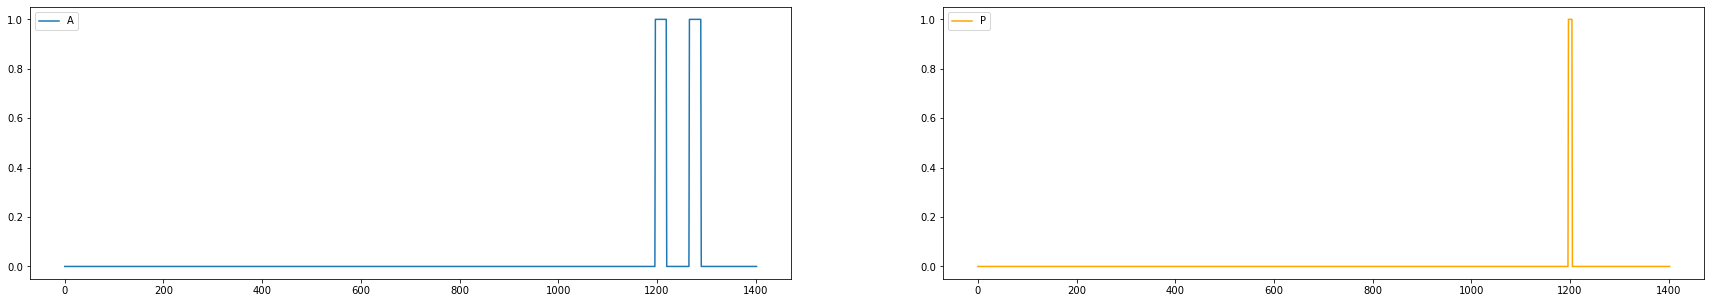

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_33.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_33.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [3.53003682e-06], Max [0.96797262]
Deviation 99.5th pctile [0.05973902]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1413,    2]))
Confusion matrix 
[[1407    6]
 [   0    2]]
precision 0.25000, recall 1.00000, f1 0.40000
Time to predict and get records above deviation : 51194 ms


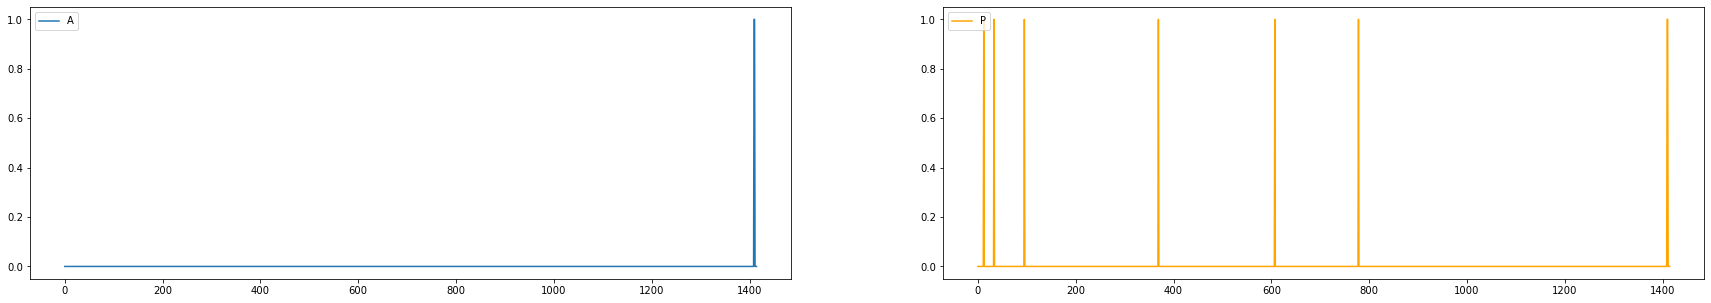

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_34.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_34.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [1.50540293e-05], Max [3.58869911]
Deviation 99.5th pctile [0.44253479]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    7]))
Confusion matrix 
[[1391    5]
 [   4    3]]
precision 0.37500, recall 0.42857, f1 0.40000
Time to predict and get records above deviation : 52577 ms


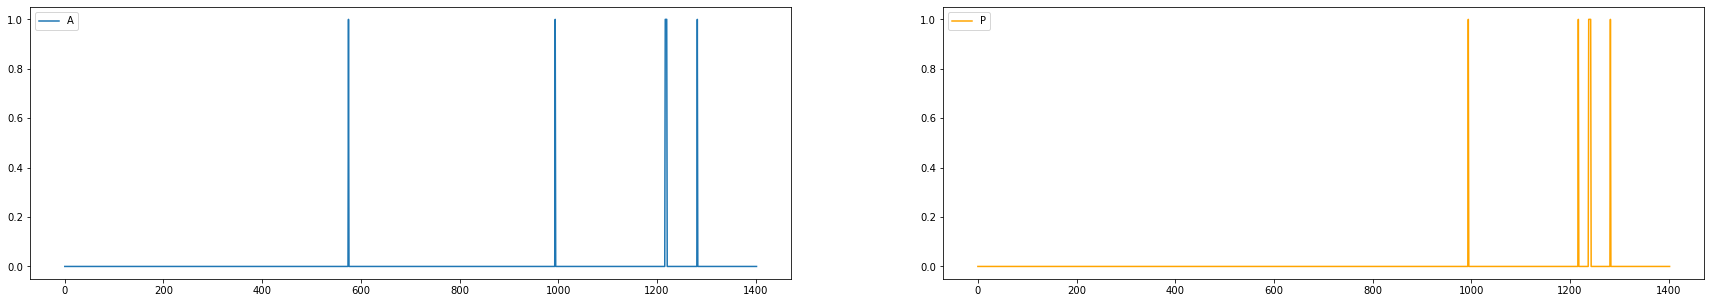

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_35.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_35.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [0.00034731], Max [0.66117965]
Deviation 99.5th pctile [0.464957]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0]), array([1403]))
Confusion matrix 
[[1395    8]
 [   0    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 53922 ms


/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


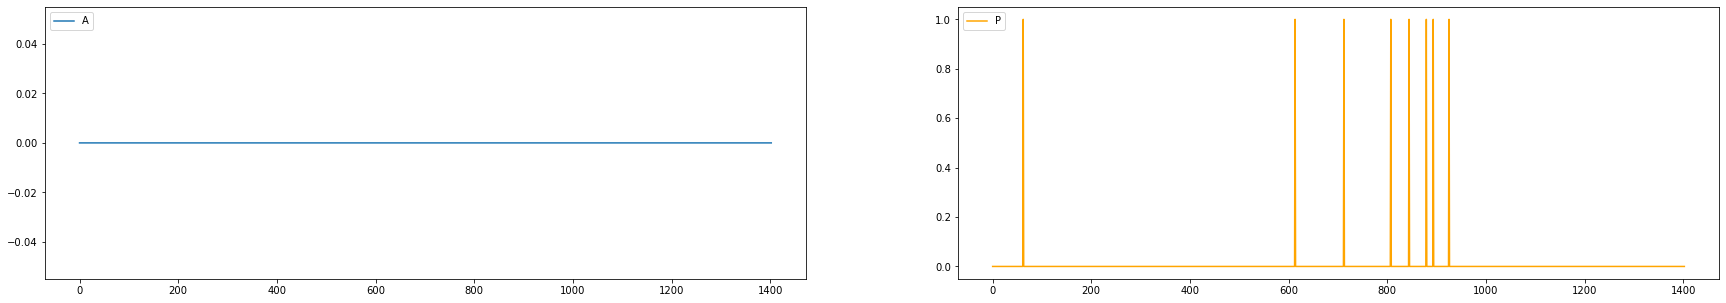

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_36.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_36.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [3.23486595e-05], Max [0.75653738]
Deviation 99.5th pctile [0.21143847]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1432,    5]))
Confusion matrix 
[[1429    3]
 [   0    5]]
precision 0.62500, recall 1.00000, f1 0.76923
Time to predict and get records above deviation : 55295 ms


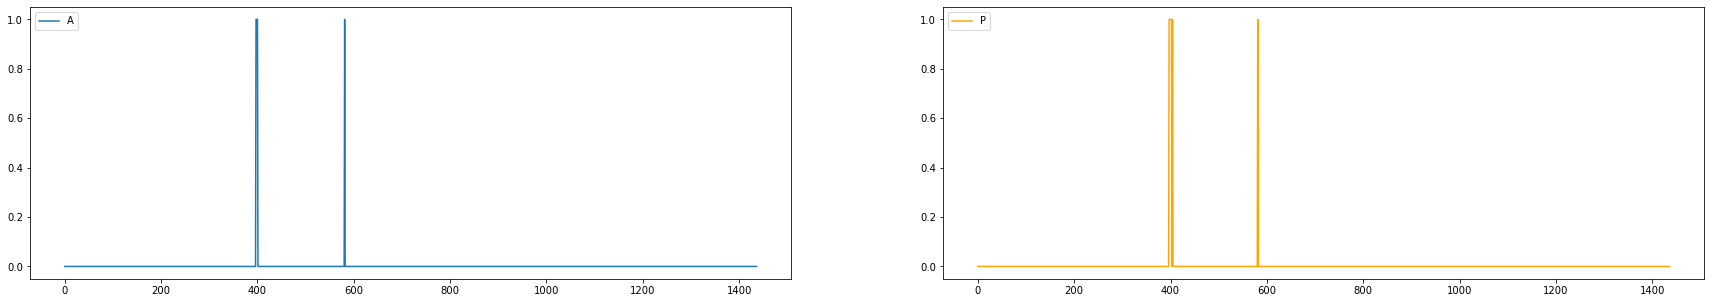

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_37.csv.h5
Shapes: time variant data with labels (1434, 2), full data (1434, 3)
Look back data shapes: lookbackX (1410, 24, 1) lookbackY (1410, 2)
Deviation Min [0.00014812], Max [0.59957817]
Deviation 99.5th pctile [0.40874601]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1402,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1376,   34]))
Confusion matrix 
[[1371    5]
 [  31    3]]
precision 0.37500, recall 0.08824, f1 0.14286
Time to predict and get records above deviation : 57908 ms


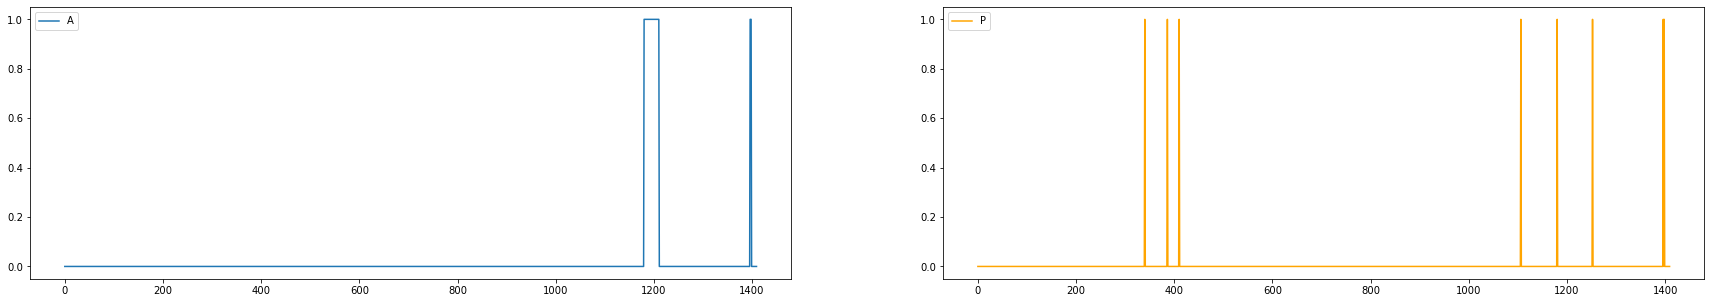

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_38.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_38.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [9.48076957e-05], Max [0.3899382]
Deviation 99.5th pctile [0.17250542]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1394,    9]))
Confusion matrix 
[[1390    4]
 [   5    4]]
precision 0.50000, recall 0.44444, f1 0.47059
Time to predict and get records above deviation : 59589 ms


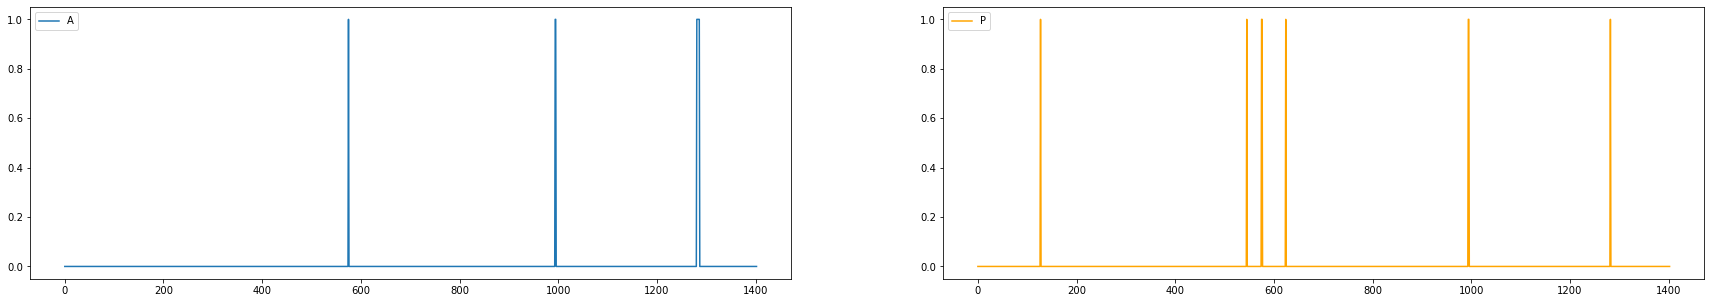

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_39.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_39.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [0.00015366], Max [0.80233485]
Deviation 99.5th pctile [0.14989622]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,   10]))
Confusion matrix 
[[1391    2]
 [   4    6]]
precision 0.75000, recall 0.60000, f1 0.66667
Time to predict and get records above deviation : 61286 ms


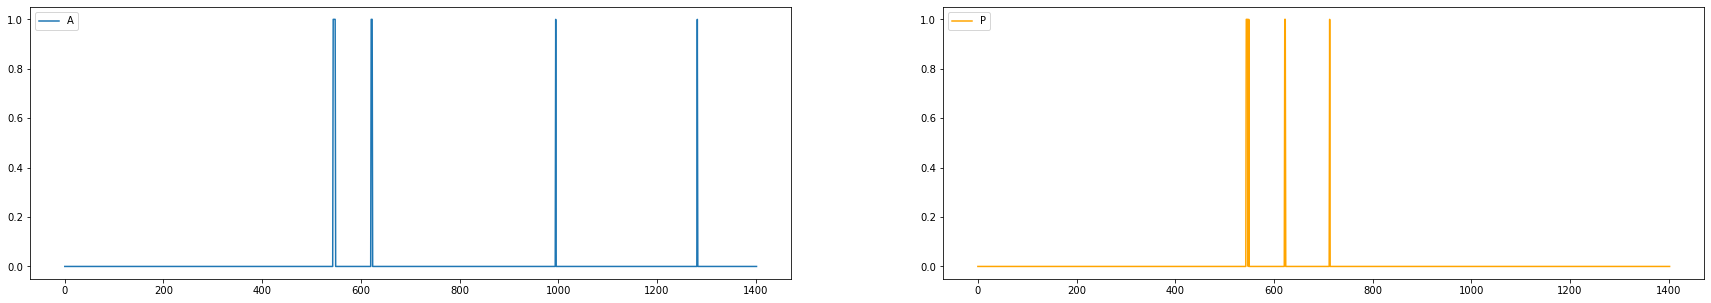

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_4.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_4.csv.h5
Shapes: time variant data with labels (1423, 2), full data (1423, 3)
Look back data shapes: lookbackX (1399, 24, 1) lookbackY (1399, 2)
Deviation Min [8.02244236e-06], Max [0.99252918]
Deviation 99.5th pctile [0.15188088]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1392,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1394,    5]))
Confusion matrix 
[[1392    2]
 [   0    5]]
precision 0.71429, recall 1.00000, f1 0.83333
Time to predict and get records above deviation : 63528 ms


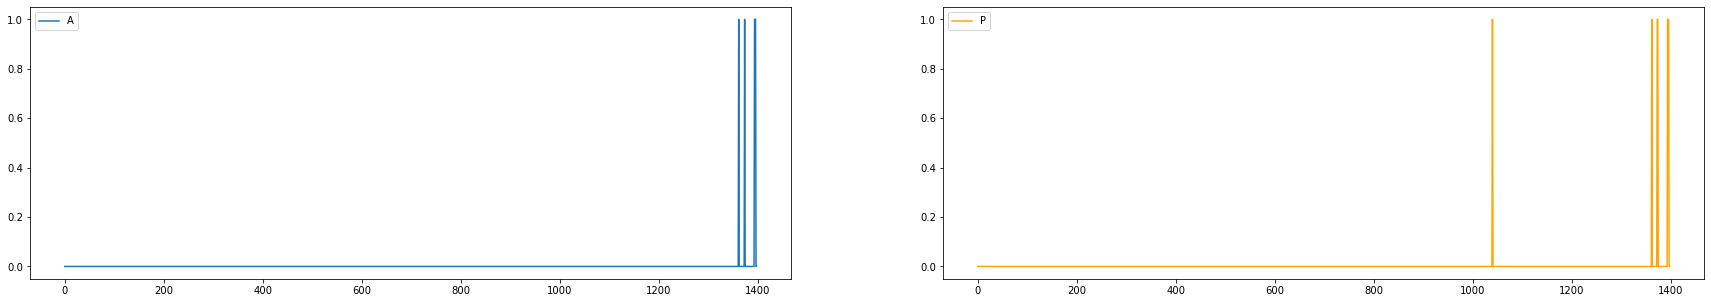

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_40.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_40.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [5.62980679e-05], Max [0.52476585]
Deviation 99.5th pctile [0.40215337]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1323,   80]))
Confusion matrix 
[[1316    7]
 [  79    1]]
precision 0.12500, recall 0.01250, f1 0.02273
Time to predict and get records above deviation : 64874 ms


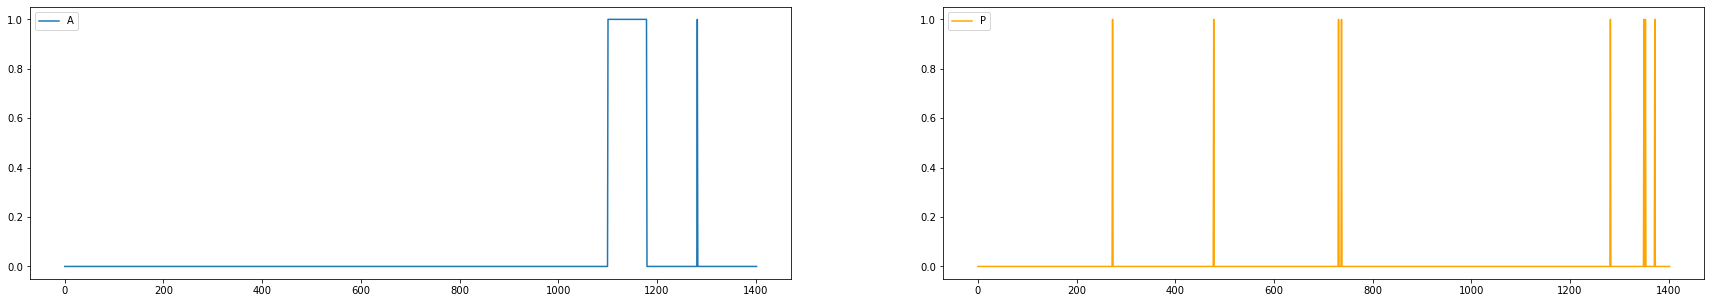

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_41.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_41.csv.h5
Shapes: time variant data with labels (1435, 2), full data (1435, 3)
Look back data shapes: lookbackX (1411, 24, 1) lookbackY (1411, 2)
Deviation Min [2.02607177e-05], Max [0.94441136]
Deviation 99.5th pctile [0.26544509]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1403,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1408,    3]))
Confusion matrix 
[[1403    5]
 [   0    3]]
precision 0.37500, recall 1.00000, f1 0.54545
Time to predict and get records above deviation : 66420 ms


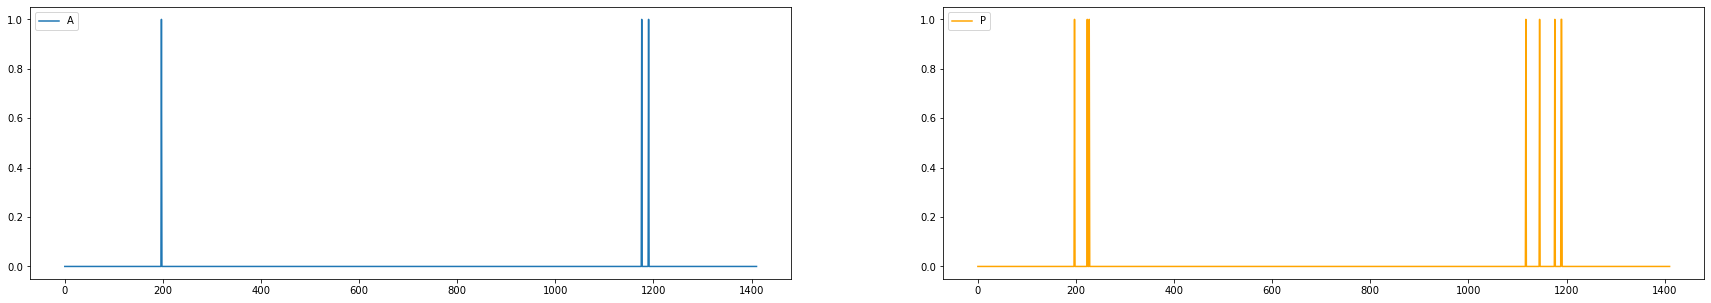

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_42.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_42.csv.h5
Shapes: time variant data with labels (1440, 2), full data (1440, 3)
Look back data shapes: lookbackX (1416, 24, 1) lookbackY (1416, 2)
Deviation Min [9.81897172e-06], Max [0.94201964]
Deviation 99.5th pctile [0.6905289]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1408,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1372,   44]))
Confusion matrix 
[[1372    0]
 [  36    8]]
precision 1.00000, recall 0.18182, f1 0.30769
Time to predict and get records above deviation : 68928 ms


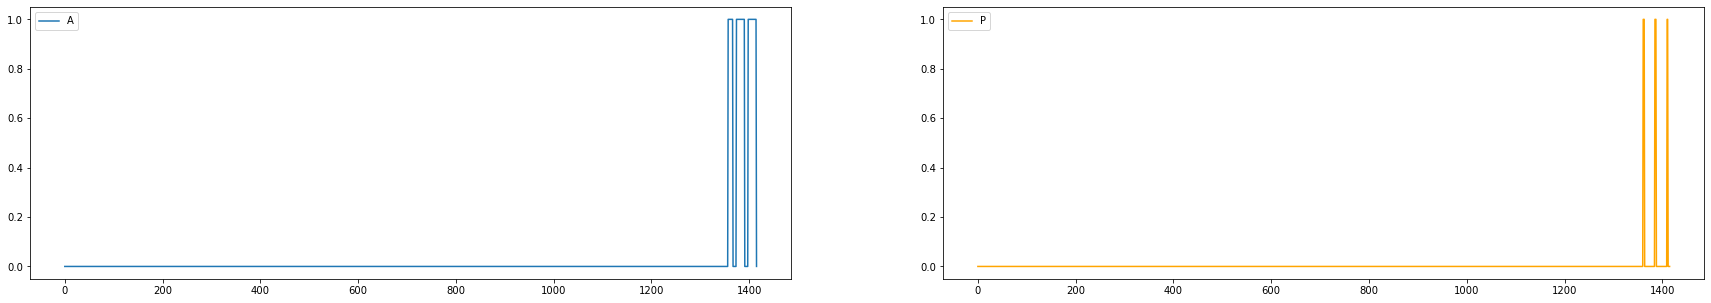

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_43.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_43.csv.h5
Shapes: time variant data with labels (1440, 2), full data (1440, 3)
Look back data shapes: lookbackX (1416, 24, 1) lookbackY (1416, 2)
Deviation Min [1.53304677e-05], Max [0.58770122]
Deviation 99.5th pctile [0.20564228]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1408,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1384,   32]))
Confusion matrix 
[[1384    0]
 [  24    8]]
precision 1.00000, recall 0.25000, f1 0.40000
Time to predict and get records above deviation : 70362 ms


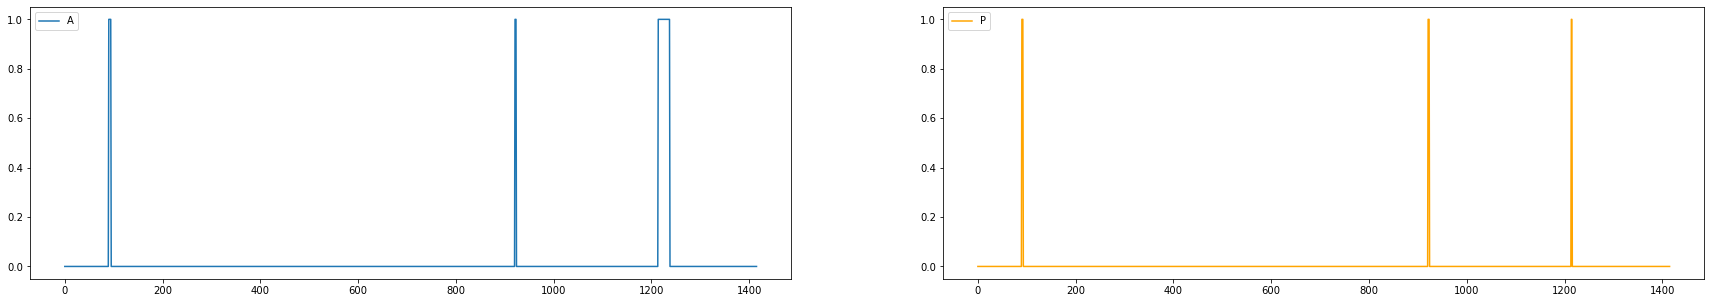

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_44.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_44.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [5.80824991e-07], Max [0.45278835]
Deviation 99.5th pctile [0.13765786]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1428,    9]))
Confusion matrix 
[[1427    1]
 [   2    7]]
precision 0.87500, recall 0.77778, f1 0.82353
Time to predict and get records above deviation : 72361 ms


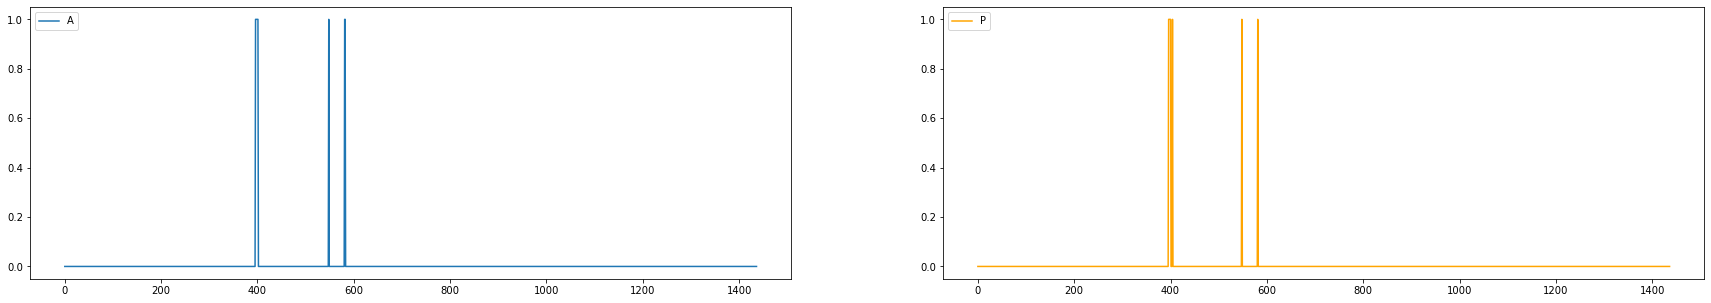

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_45.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_45.csv.h5
Shapes: time variant data with labels (1440, 2), full data (1440, 3)
Look back data shapes: lookbackX (1416, 24, 1) lookbackY (1416, 2)
Deviation Min [1.85933709e-05], Max [0.95906426]
Deviation 99.5th pctile [0.12324592]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1408,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1415,    1]))
Confusion matrix 
[[1408    7]
 [   0    1]]
precision 0.12500, recall 1.00000, f1 0.22222
Time to predict and get records above deviation : 75492 ms


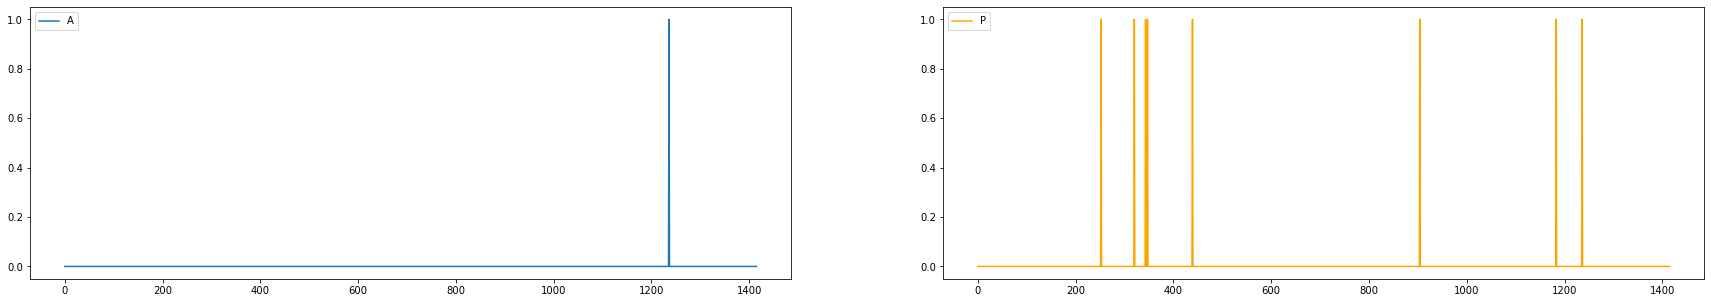

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_46.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_46.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [5.65960538e-05], Max [0.66568485]
Deviation 99.5th pctile [0.2794032]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1308,  109]))
Confusion matrix 
[[1302    6]
 [ 107    2]]
precision 0.25000, recall 0.01835, f1 0.03419
Time to predict and get records above deviation : 77432 ms


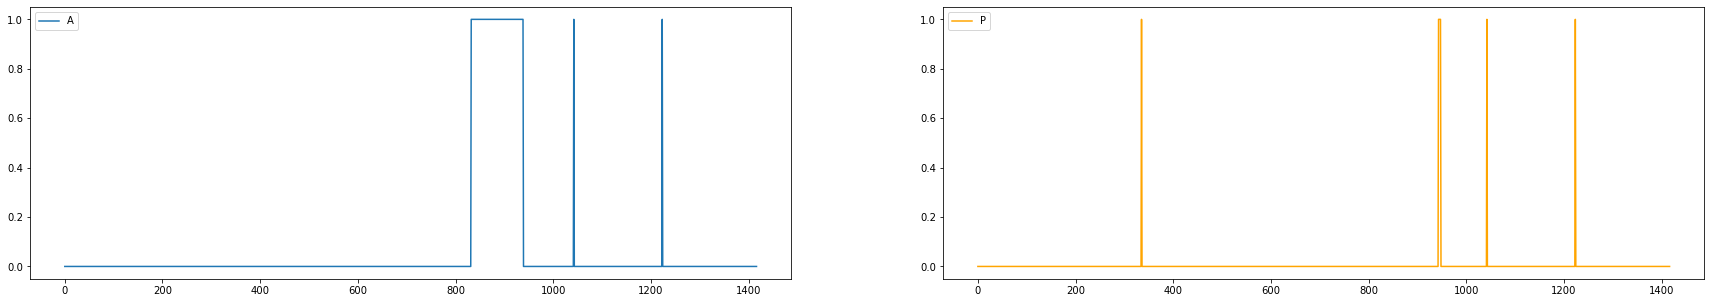

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_47.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_47.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [1.55717952e-05], Max [0.9076613]
Deviation 99.5th pctile [0.20665192]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,   10]))
Confusion matrix 
[[1390    3]
 [   5    5]]
precision 0.62500, recall 0.50000, f1 0.55556
Time to predict and get records above deviation : 80151 ms


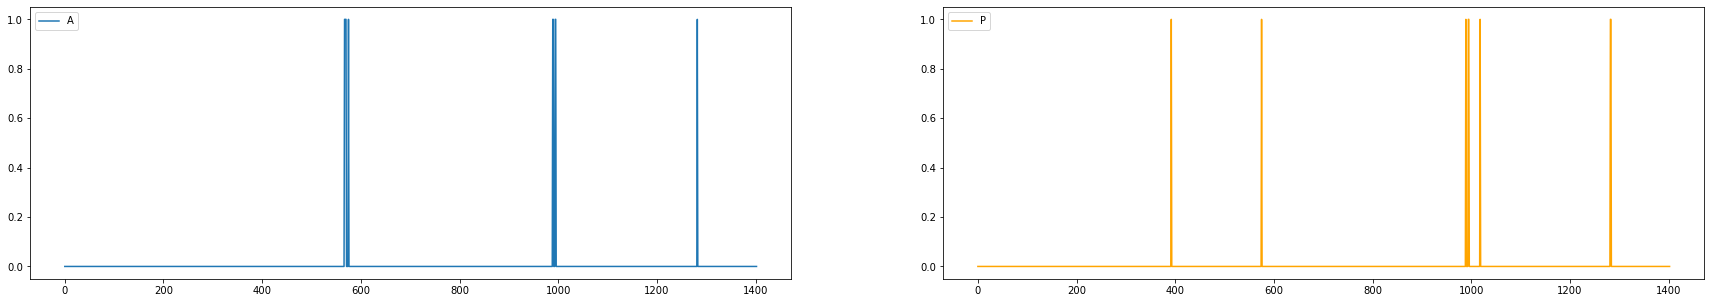

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_48.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_48.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [4.89611626e-06], Max [0.8475723]
Deviation 99.5th pctile [0.39405255]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1391,   24]))
Confusion matrix 
[[1383    8]
 [  24    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 83356 ms


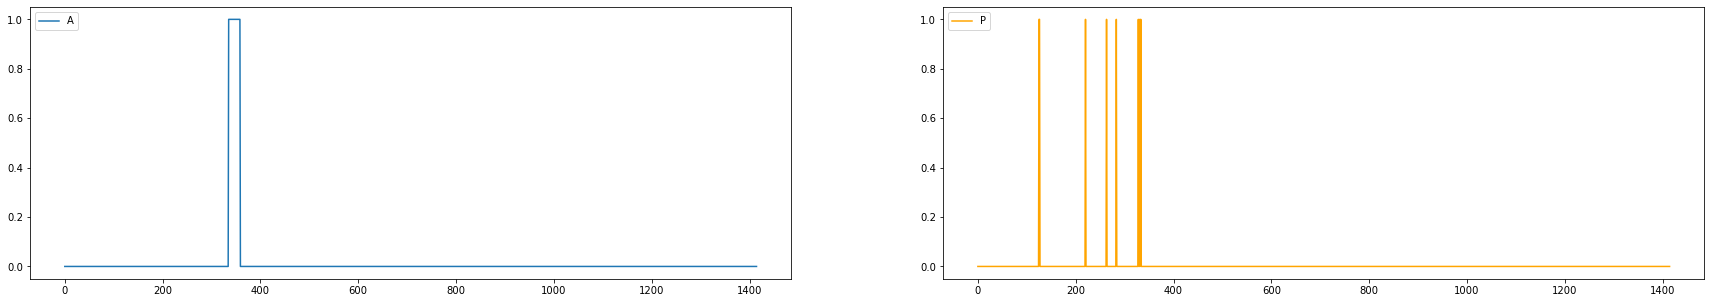

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_49.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_49.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [9.04351064e-05], Max [0.49070418]
Deviation 99.5th pctile [0.29201534]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1434,    3]))
Confusion matrix 
[[1429    5]
 [   0    3]]
precision 0.37500, recall 1.00000, f1 0.54545
Time to predict and get records above deviation : 85478 ms


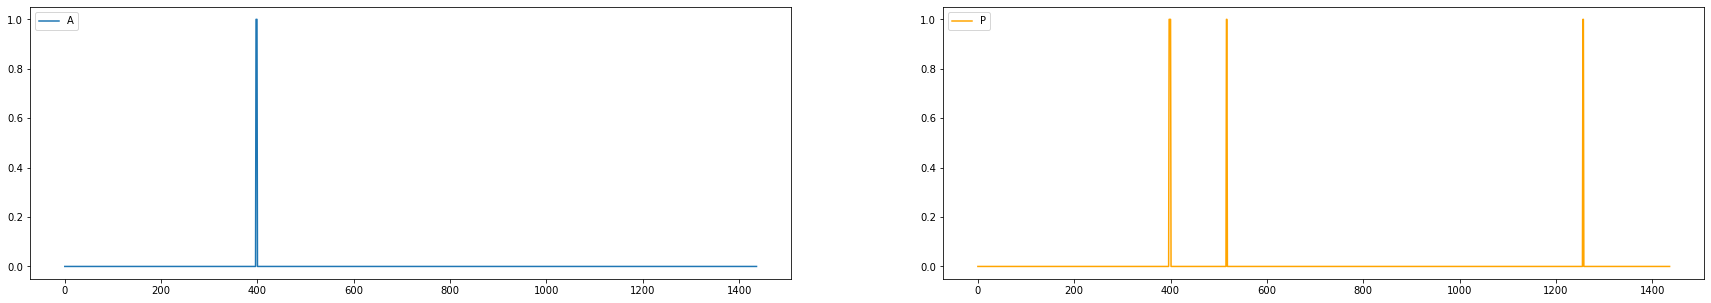

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_5.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_5.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [6.40787247e-06], Max [0.96984925]
Deviation 99.5th pctile [0.03368]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1413,    2]))
Confusion matrix 
[[1407    6]
 [   0    2]]
precision 0.25000, recall 1.00000, f1 0.40000
Time to predict and get records above deviation : 87725 ms


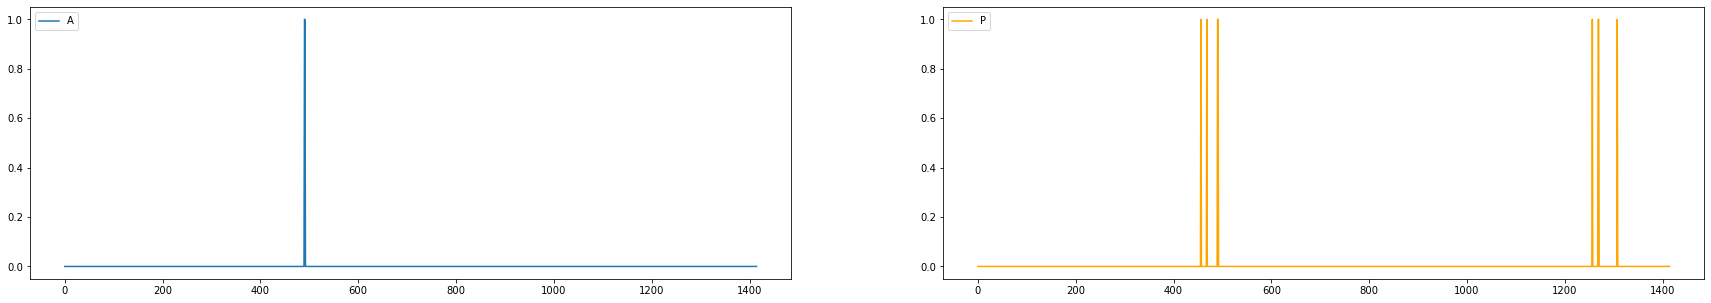

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_50.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_50.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [0.00016493], Max [0.62300345]
Deviation 99.5th pctile [0.35294819]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1408,    7]))
Confusion matrix 
[[1407    1]
 [   0    7]]
precision 0.87500, recall 1.00000, f1 0.93333
Time to predict and get records above deviation : 91137 ms


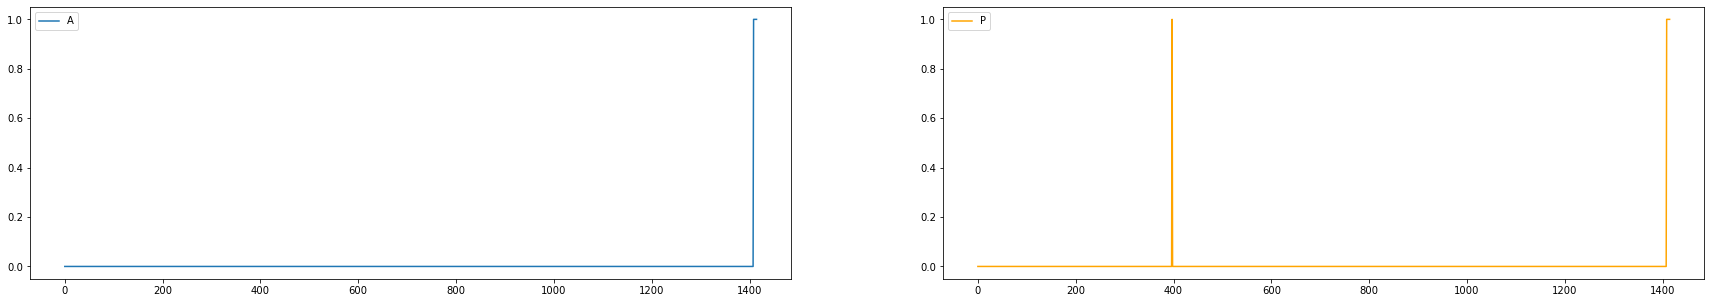

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_51.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_51.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [6.63991646e-06], Max [0.68924296]
Deviation 99.5th pctile [0.22810088]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1399,    4]))
Confusion matrix 
[[1394    5]
 [   1    3]]
precision 0.37500, recall 0.75000, f1 0.50000
Time to predict and get records above deviation : 93925 ms


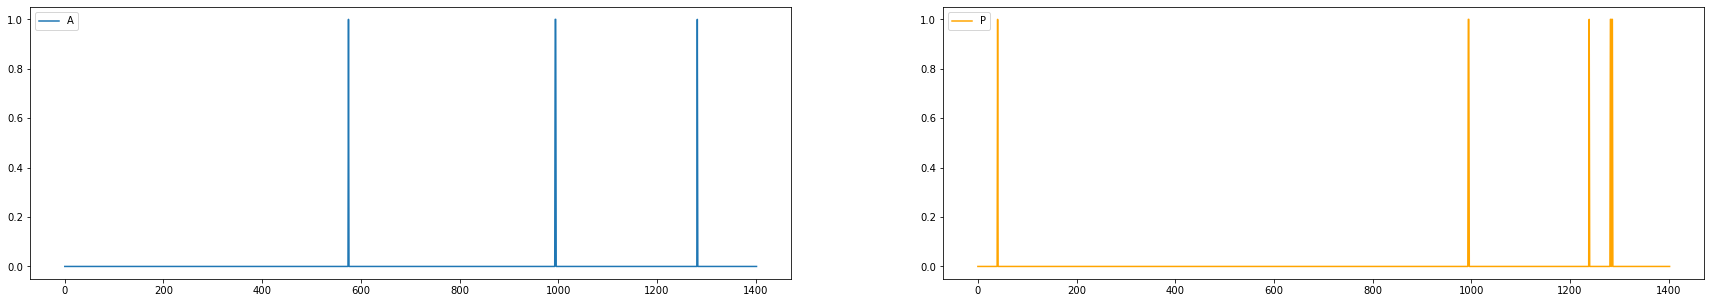

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_52.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_52.csv.h5
Shapes: time variant data with labels (1432, 2), full data (1432, 3)
Look back data shapes: lookbackX (1408, 24, 1) lookbackY (1408, 2)
Deviation Min [2.78763905e-05], Max [0.9011702]
Deviation 99.5th pctile [0.14553518]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1400,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1397,   11]))
Confusion matrix 
[[1395    2]
 [   5    6]]
precision 0.75000, recall 0.54545, f1 0.63158
Time to predict and get records above deviation : 96828 ms


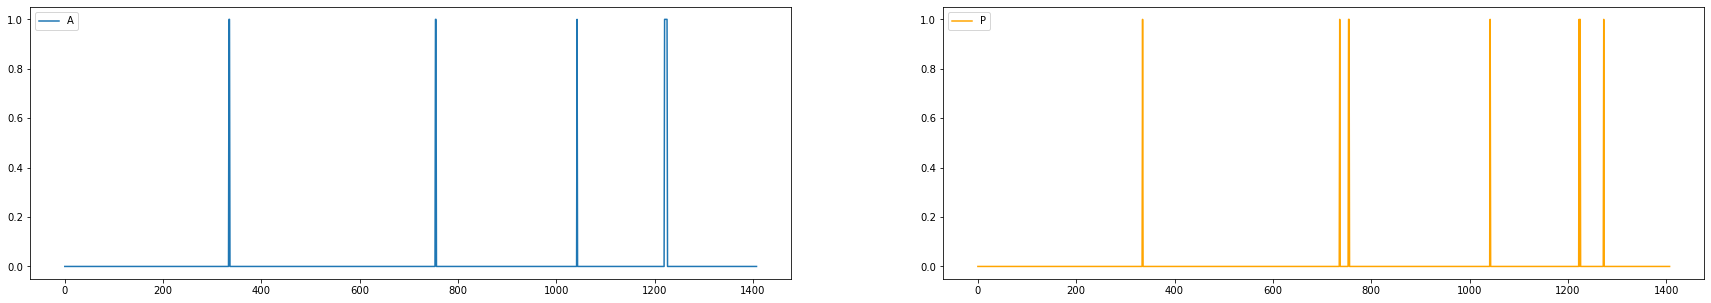

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_53.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_53.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [5.0549998e-06], Max [0.55481948]
Deviation 99.5th pctile [0.36868962]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1420,   17]))
Confusion matrix 
[[1420    0]
 [   9    8]]
precision 1.00000, recall 0.47059, f1 0.64000
Time to predict and get records above deviation : 98501 ms


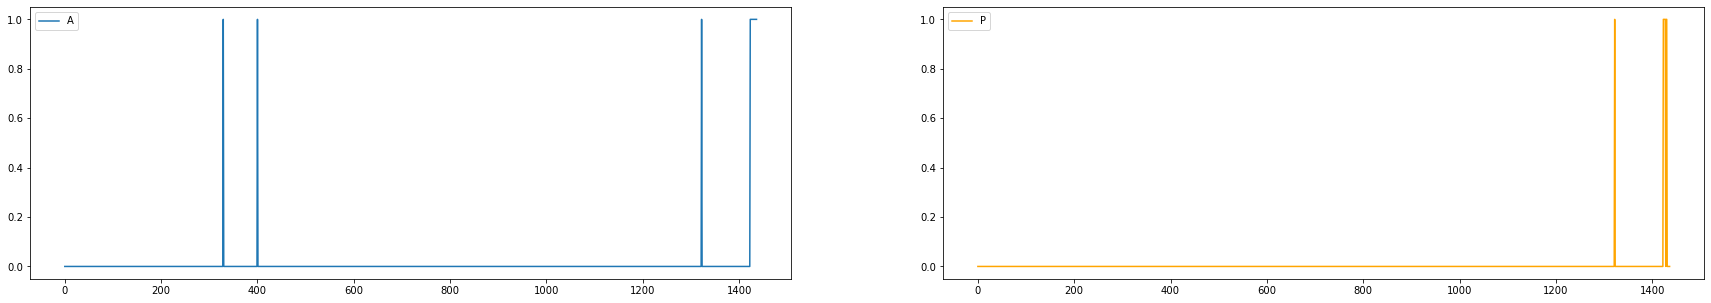

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_54.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_54.csv.h5
Shapes: time variant data with labels (741, 2), full data (741, 3)
Look back data shapes: lookbackX (717, 24, 1) lookbackY (717, 2)
Deviation Min [8.23002791e-05], Max [0.58844137]
Deviation 99.5th pctile [0.24907947]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([713,   4]))
Actual is_anomaly labels in data (array([0, 1]), array([713,   4]))
Confusion matrix 
[[713   0]
 [  0   4]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 99657 ms


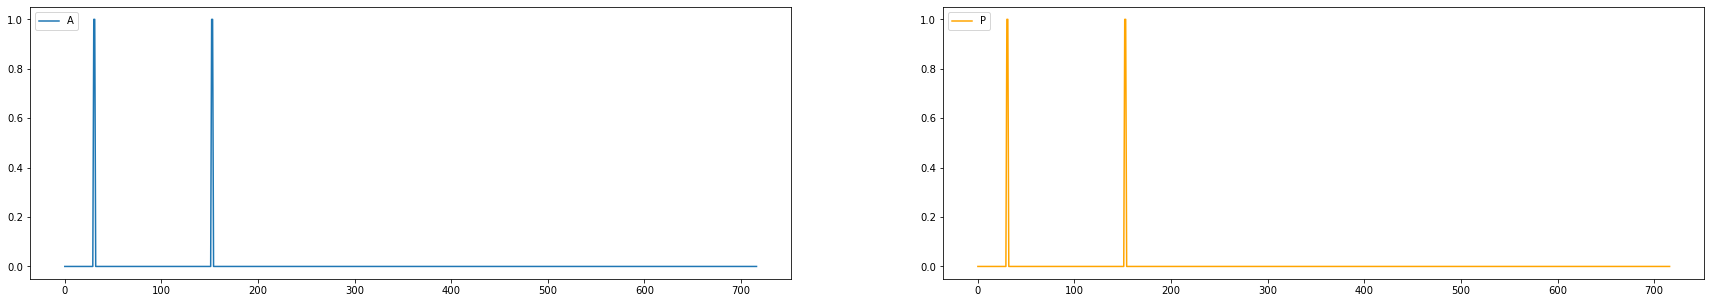

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_55.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_55.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [6.69274501e-05], Max [0.647606]
Deviation 99.5th pctile [0.26920748]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1398,    5]))
Confusion matrix 
[[1394    4]
 [   1    4]]
precision 0.50000, recall 0.80000, f1 0.61538
Time to predict and get records above deviation : 102442 ms


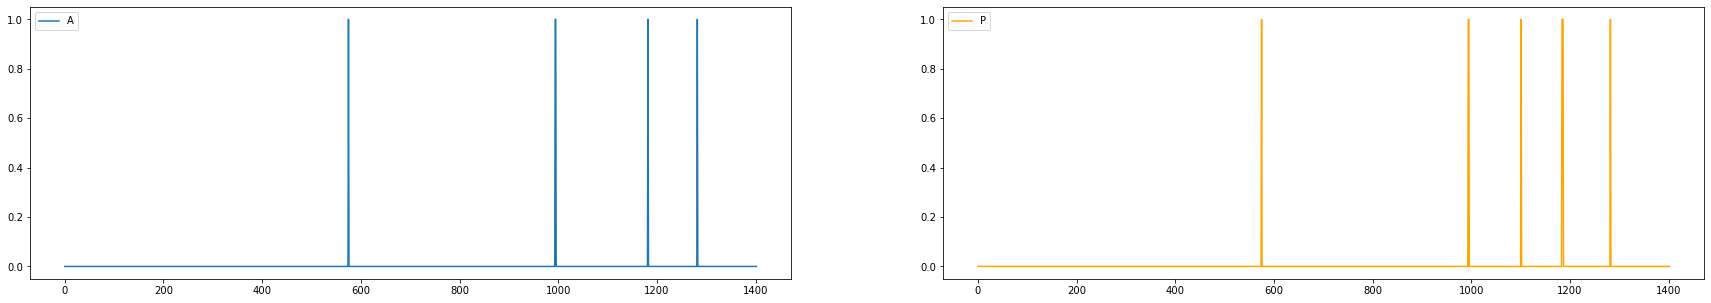

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_56.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_56.csv.h5
Shapes: time variant data with labels (1427, 2), full data (1427, 3)
Look back data shapes: lookbackX (1403, 24, 1) lookbackY (1403, 2)
Deviation Min [4.70376237e-05], Max [0.79418971]
Deviation 99.5th pctile [0.3209632]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1395,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1398,    5]))
Confusion matrix 
[[1393    5]
 [   2    3]]
precision 0.37500, recall 0.60000, f1 0.46154
Time to predict and get records above deviation : 104983 ms


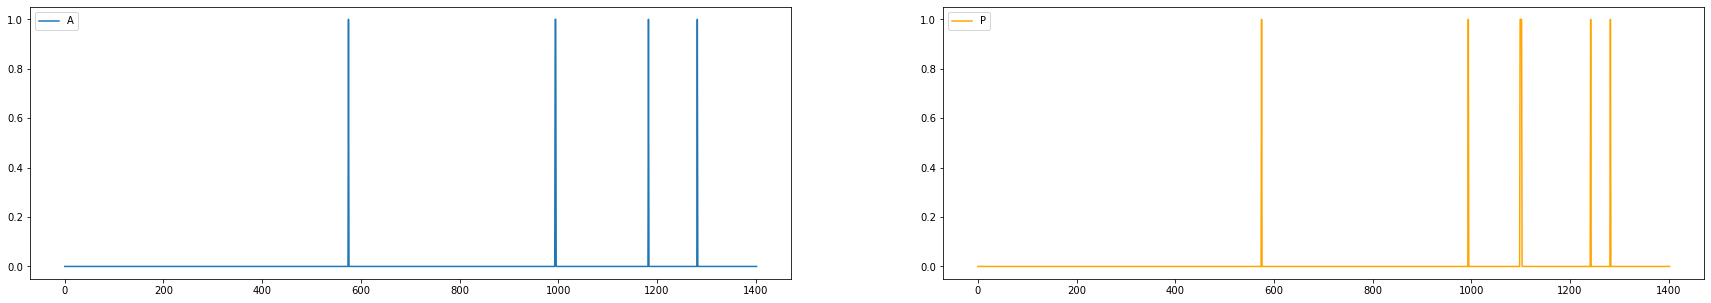

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_57.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_57.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [7.63866235e-05], Max [0.55405897]
Deviation 99.5th pctile [0.37347981]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1414,    3]))
Confusion matrix 
[[1407    7]
 [   2    1]]
precision 0.12500, recall 0.33333, f1 0.18182
Time to predict and get records above deviation : 106996 ms


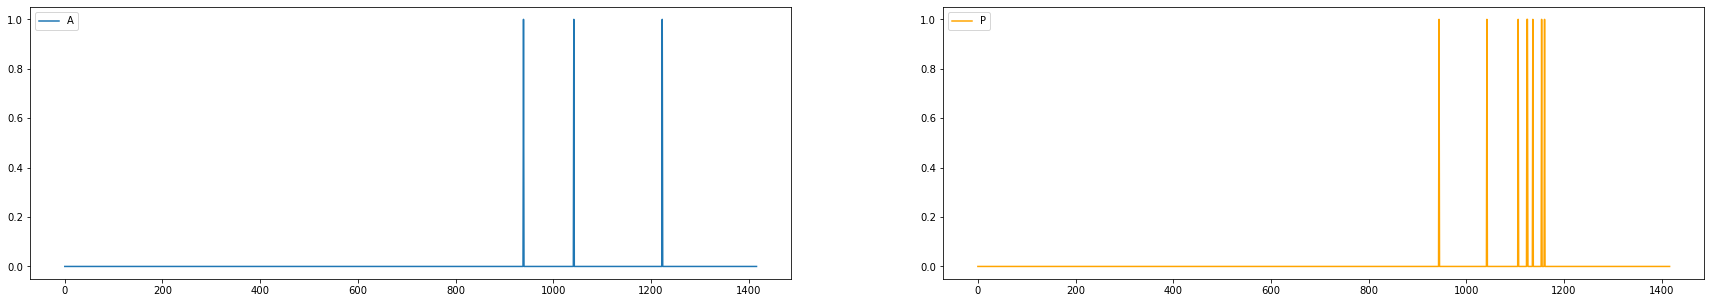

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_58.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_58.csv.h5
Shapes: time variant data with labels (1435, 2), full data (1435, 3)
Look back data shapes: lookbackX (1411, 24, 1) lookbackY (1411, 2)
Deviation Min [8.71186766e-06], Max [0.75800256]
Deviation 99.5th pctile [0.66474714]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1403,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1368,   43]))
Confusion matrix 
[[1368    0]
 [  35    8]]
precision 1.00000, recall 0.18605, f1 0.31373
Time to predict and get records above deviation : 108919 ms


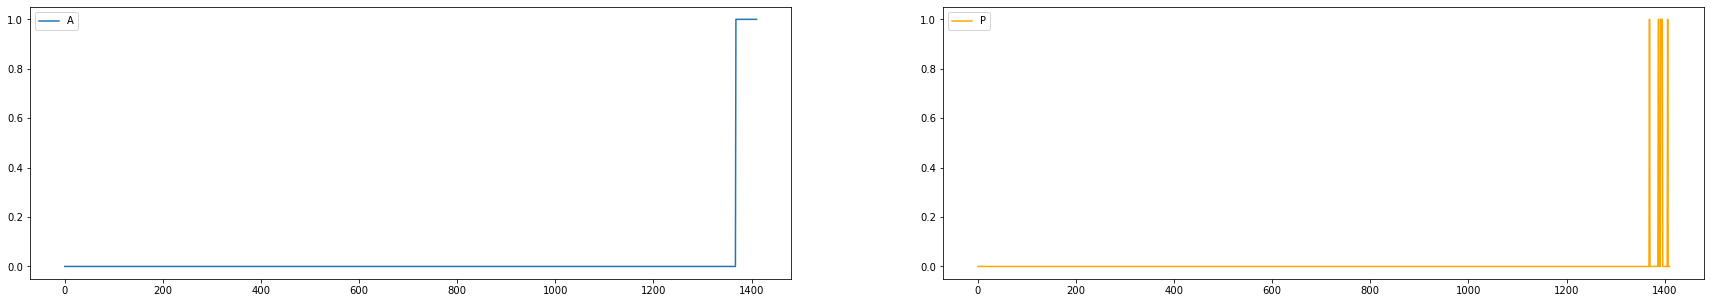

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_59.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_59.csv.h5
Shapes: time variant data with labels (1423, 2), full data (1423, 3)
Look back data shapes: lookbackX (1399, 24, 1) lookbackY (1399, 2)
Deviation Min [8.62238698e-05], Max [0.73439258]
Deviation 99.5th pctile [0.70373321]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1392,    7]))
Actual is_anomaly labels in data (array([0]), array([1399]))
Confusion matrix 
[[1392    7]
 [   0    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 111200 ms


/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


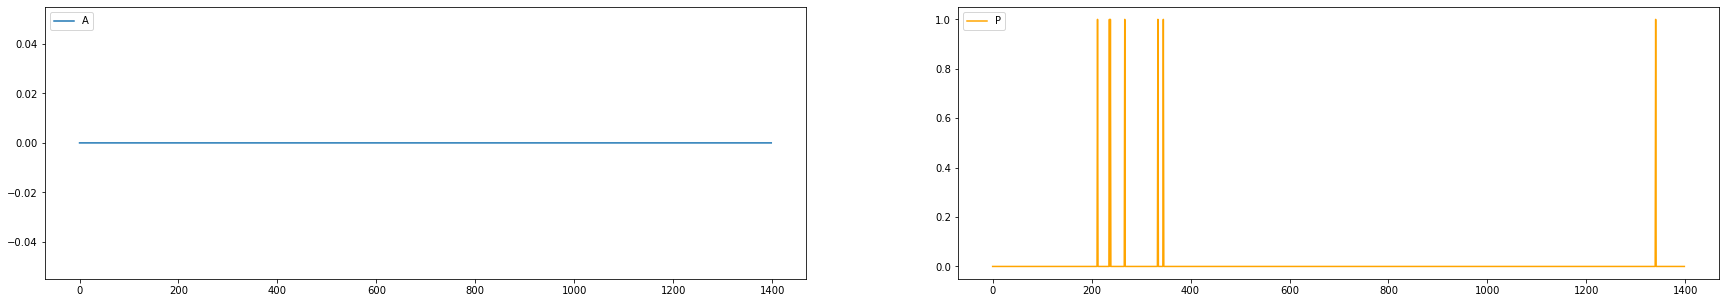

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_6.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_6.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [2.17839575e-05], Max [0.7199837]
Deviation 99.5th pctile [0.25408396]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Confusion matrix 
[[1406    1]
 [   1    7]]
precision 0.87500, recall 0.87500, f1 0.87500
Time to predict and get records above deviation : 114230 ms


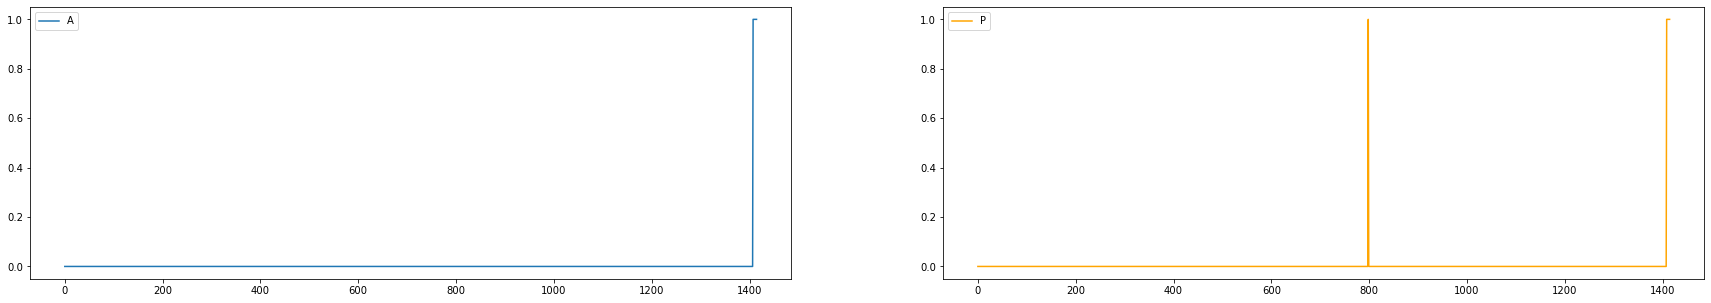

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_60.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [2.47492424e-06], Max [0.94377137]
Deviation 99.5th pctile [0.16557225]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1421,   16]))
Confusion matrix 
[[1421    0]
 [   8    8]]
precision 1.00000, recall 0.50000, f1 0.66667
Time to predict and get records above deviation : 116603 ms


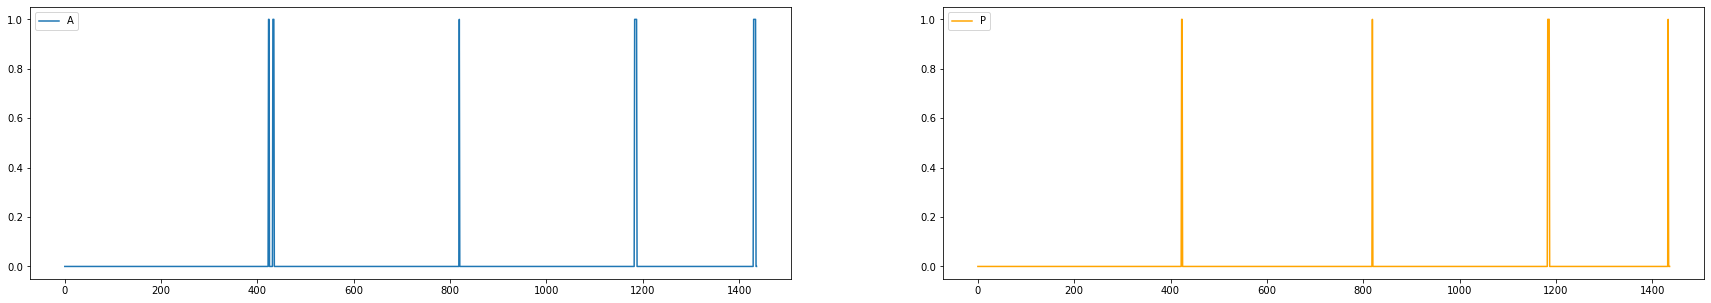

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_61.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_61.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [3.65151266e-05], Max [0.66028994]
Deviation 99.5th pctile [0.34550162]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,   24]))
Confusion matrix 
[[1386    7]
 [  23    1]]
precision 0.12500, recall 0.04167, f1 0.06250
Time to predict and get records above deviation : 119350 ms


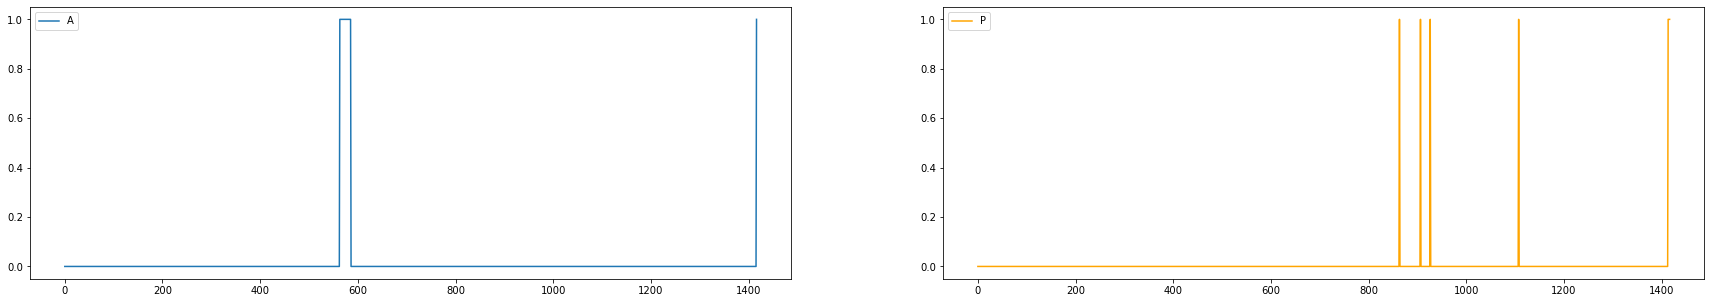

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_62.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_62.csv.h5
Shapes: time variant data with labels (741, 2), full data (741, 3)
Look back data shapes: lookbackX (717, 24, 1) lookbackY (717, 2)
Deviation Min [5.81163177e-05], Max [0.70434121]
Deviation 99.5th pctile [0.41284834]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([713,   4]))
Actual is_anomaly labels in data (array([0, 1]), array([712,   5]))
Confusion matrix 
[[712   0]
 [  1   4]]
precision 1.00000, recall 0.80000, f1 0.88889
Time to predict and get records above deviation : 122154 ms


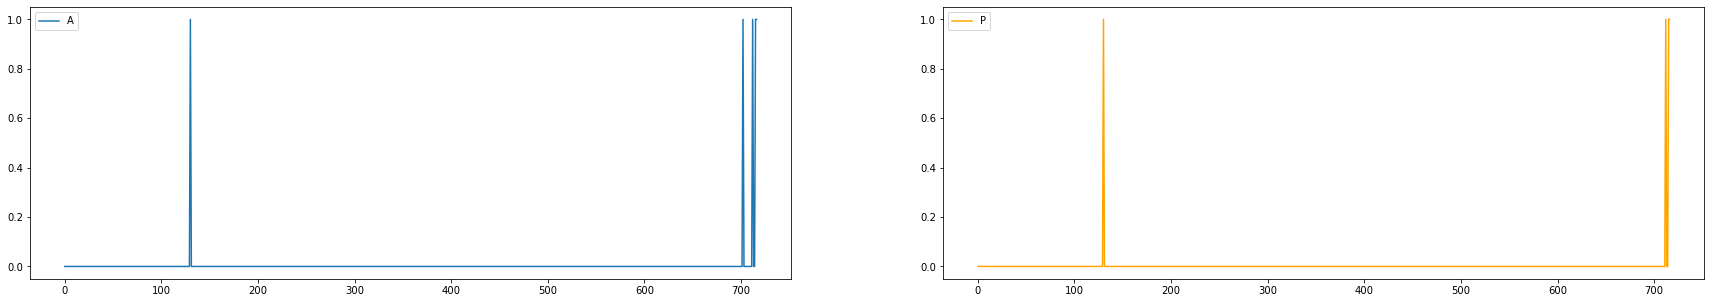

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_63.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_63.csv.h5
Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [0.00016226], Max [0.51030002]
Deviation 99.5th pctile [0.35729356]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Confusion matrix 
[[1403    4]
 [   4    4]]
precision 0.50000, recall 0.50000, f1 0.50000
Time to predict and get records above deviation : 124100 ms


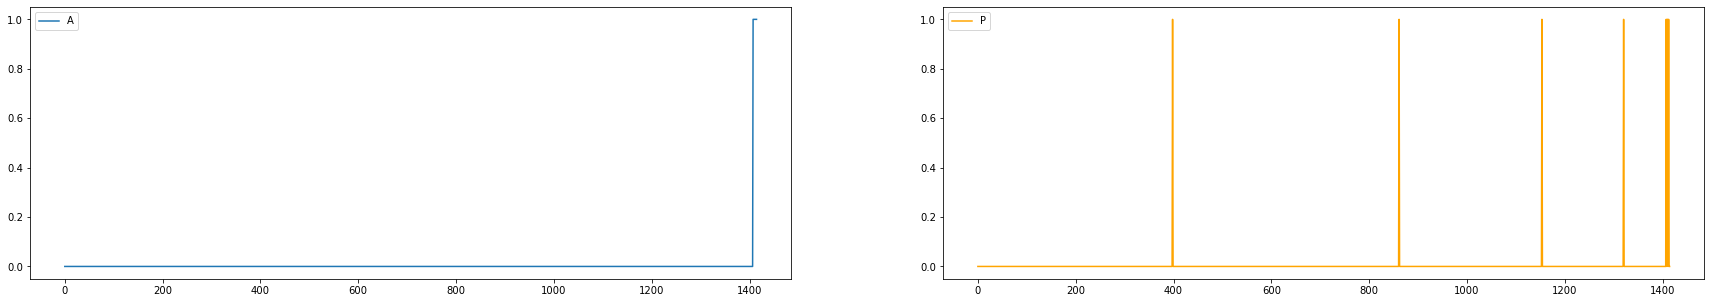

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_64.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_64.csv.h5
Shapes: time variant data with labels (1441, 2), full data (1441, 3)
Look back data shapes: lookbackX (1417, 24, 1) lookbackY (1417, 2)
Deviation Min [0.00016343], Max [0.78723162]
Deviation 99.5th pctile [0.49869907]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1409,    8]))
Actual is_anomaly labels in data (array([0]), array([1417]))
Confusion matrix 
[[1409    8]
 [   0    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 126459 ms


/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


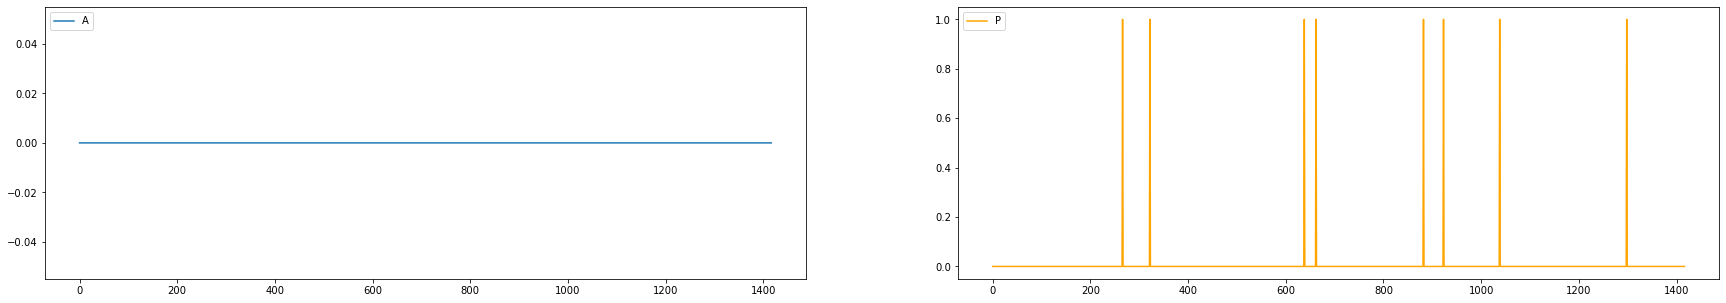

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_65.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_65.csv.h5
Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [1.83927937e-05], Max [0.7962832]
Deviation 99.5th pctile [0.28335517]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1393,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1383,   17]))
Confusion matrix 
[[1380    3]
 [  13    4]]
precision 0.57143, recall 0.23529, f1 0.33333
Time to predict and get records above deviation : 128370 ms


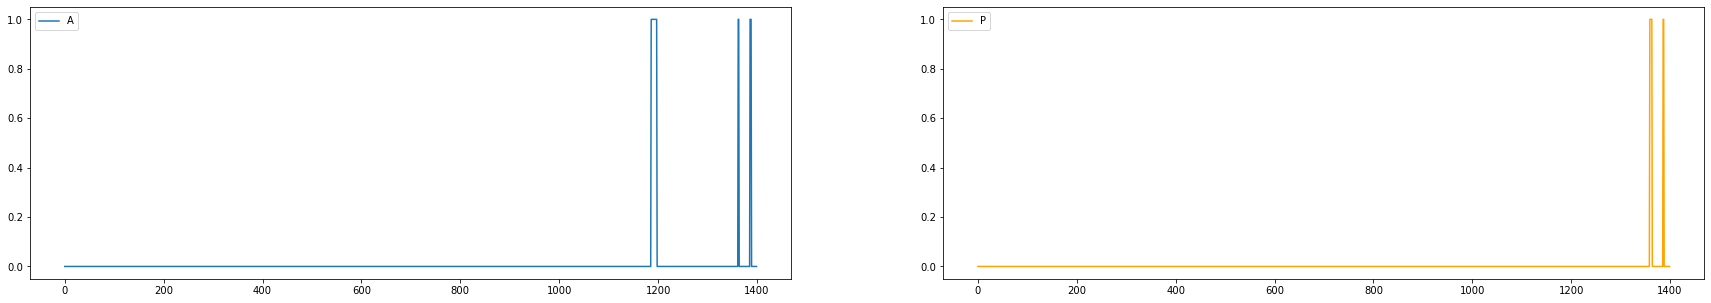

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_66.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_66.csv.h5
Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [3.85612941e-06], Max [0.97337979]
Deviation 99.5th pctile [0.69438025]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1393,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1379,   21]))
Confusion matrix 
[[1379    0]
 [  14    7]]
precision 1.00000, recall 0.33333, f1 0.50000
Time to predict and get records above deviation : 130170 ms


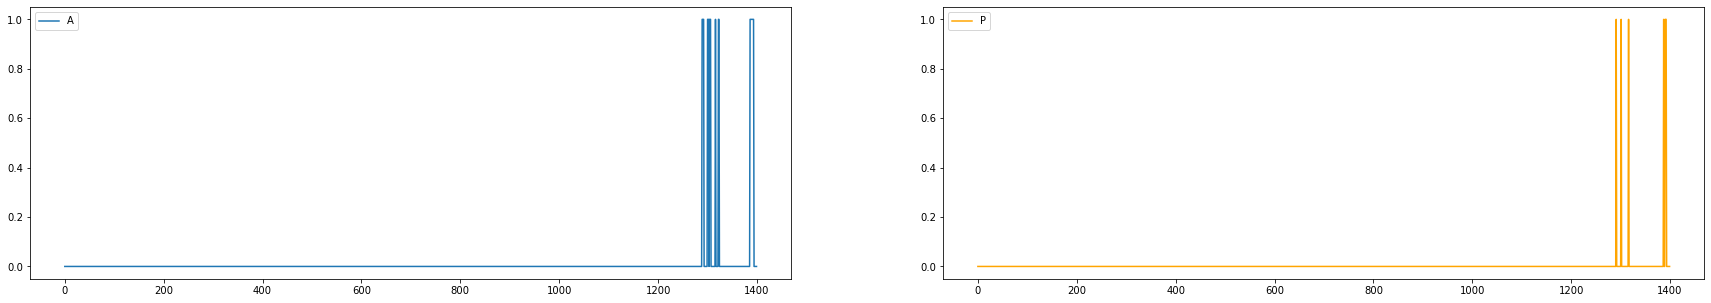

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_67.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_67.csv.h5
Shapes: time variant data with labels (1423, 2), full data (1423, 3)
Look back data shapes: lookbackX (1399, 24, 1) lookbackY (1399, 2)
Deviation Min [3.45922965e-06], Max [0.98502731]
Deviation 99.5th pctile [0.66654708]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1392,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1376,   23]))
Confusion matrix 
[[1376    0]
 [  16    7]]
precision 1.00000, recall 0.30435, f1 0.46667
Time to predict and get records above deviation : 131555 ms


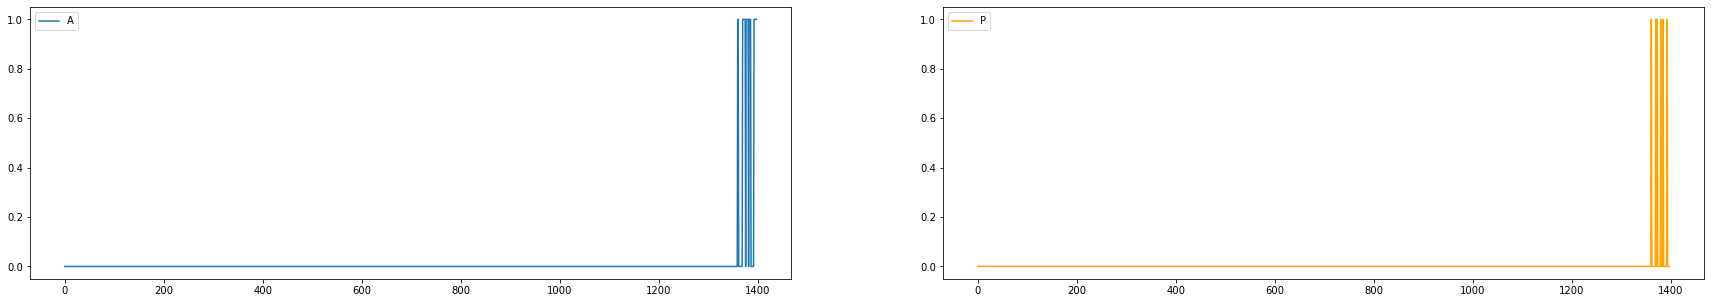

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_7.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_7.csv.h5
Shapes: time variant data with labels (1423, 2), full data (1423, 3)
Look back data shapes: lookbackX (1399, 24, 1) lookbackY (1399, 2)
Deviation Min [1.2210608e-06], Max [0.47062439]
Deviation 99.5th pctile [0.33508311]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1392,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1338,   61]))
Confusion matrix 
[[1338    0]
 [  54    7]]
precision 1.00000, recall 0.11475, f1 0.20588
Time to predict and get records above deviation : 134161 ms


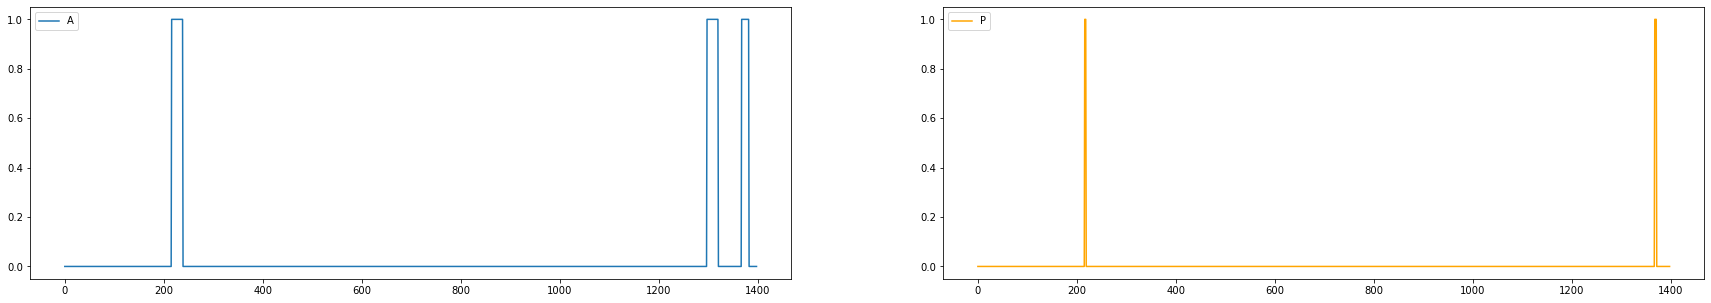

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_8.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_8.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [1.28075286e-05], Max [0.89603473]
Deviation 99.5th pctile [0.6625841]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1389,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1386,   10]))
Confusion matrix 
[[1386    0]
 [   3    7]]
precision 1.00000, recall 0.70000, f1 0.82353
Time to predict and get records above deviation : 135696 ms


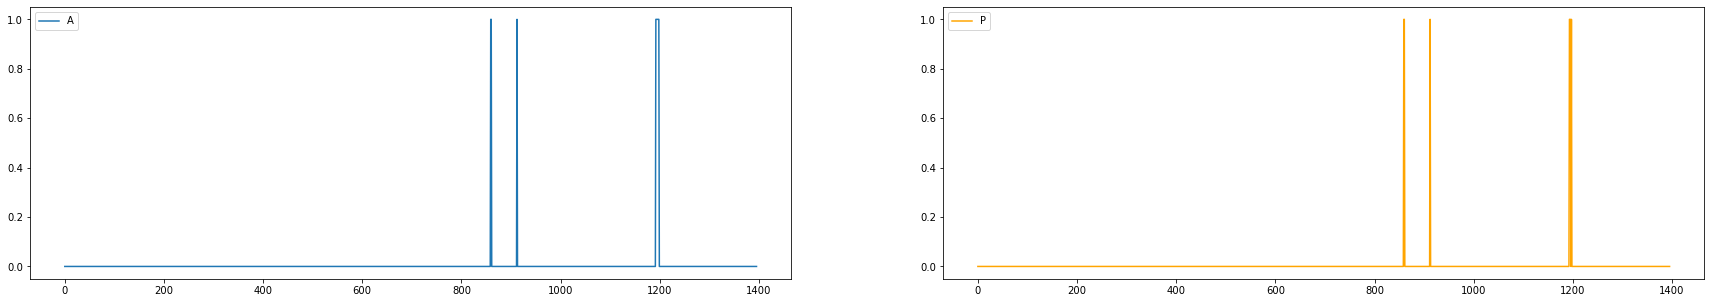

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_9.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_9.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [1.78215915e-05], Max [0.96813462]
Deviation 99.5th pctile [0.05498486]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1429,    8]))
Confusion matrix 
[[1428    1]
 [   1    7]]
precision 0.87500, recall 0.87500, f1 0.87500
Time to predict and get records above deviation : 137650 ms


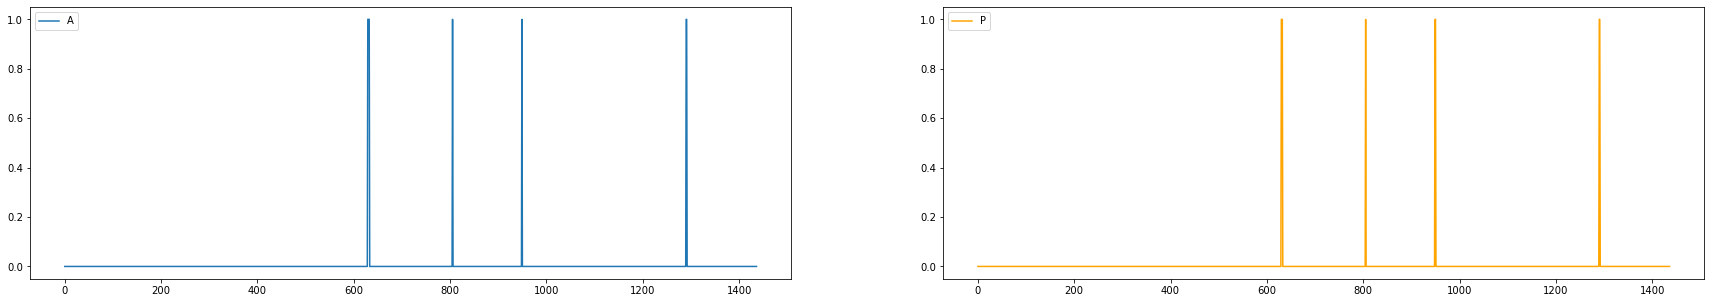

Processing 100 files in folder A2Benchmark
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_1.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.83256336e-05], Max [0.66517191]
Deviation 99.5th pctile [0.12854991]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 140440 ms


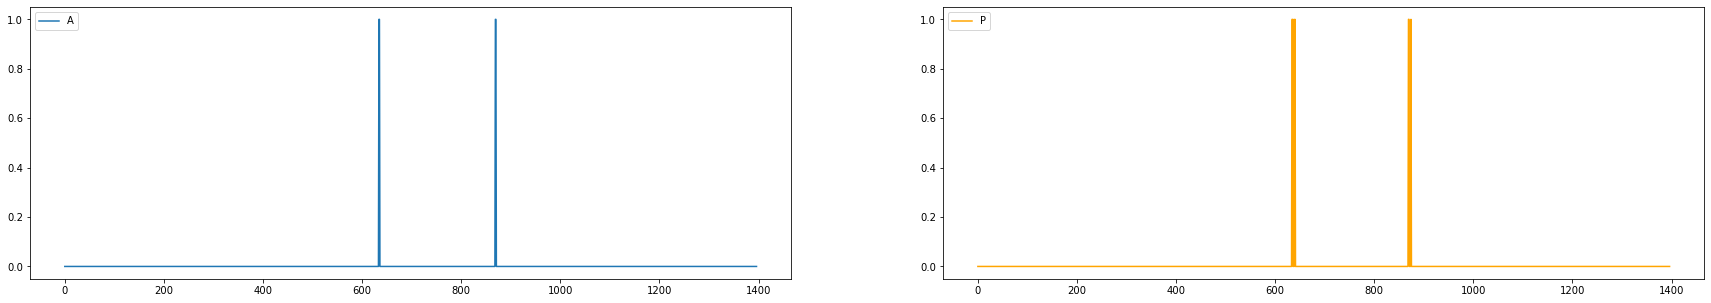

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_10.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.04119458e-07], Max [0.28940988]
Deviation 99.5th pctile [0.11006395]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 143507 ms


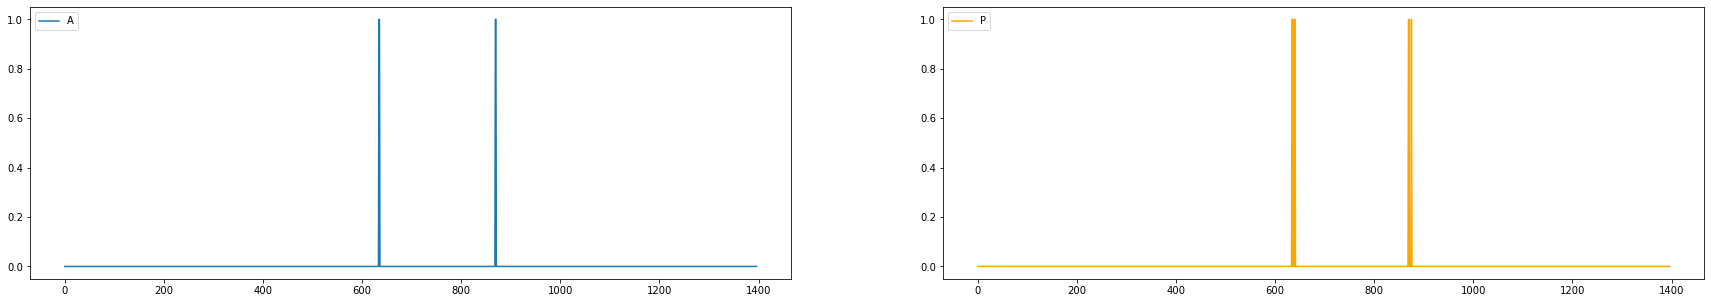

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_100.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_100.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.6079426e-05], Max [0.58549908]
Deviation 99.5th pctile [0.06707244]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 146450 ms


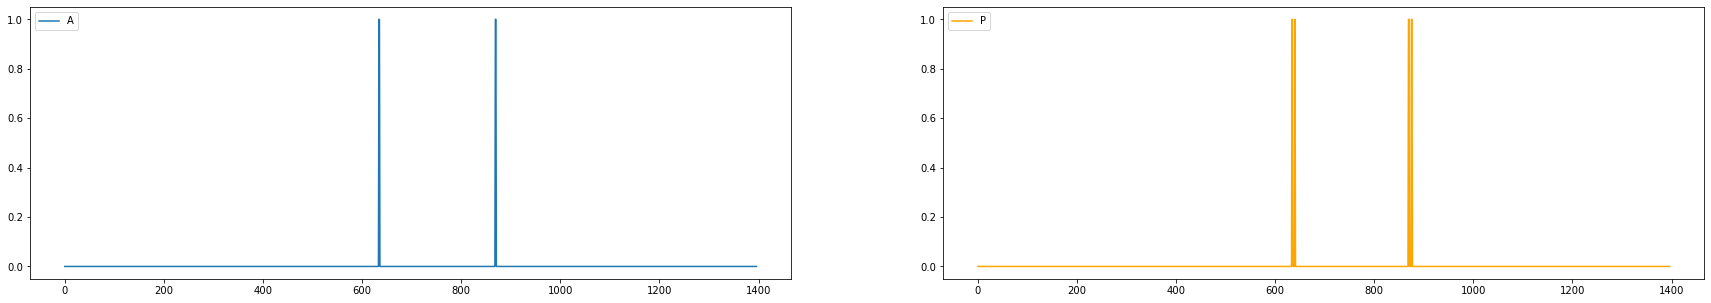

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_11.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_11.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.8863401e-05], Max [0.74578256]
Deviation 99.5th pctile [0.58288615]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 148656 ms


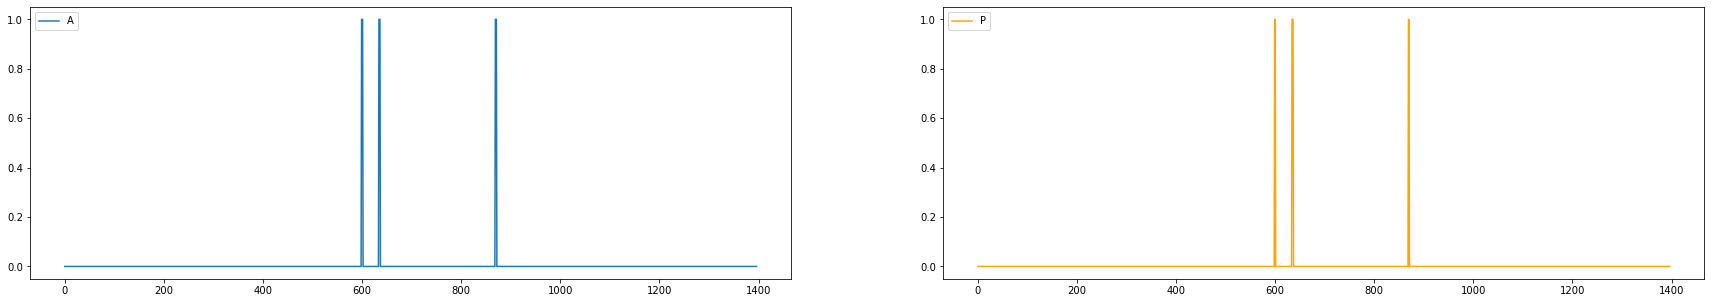

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_12.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_12.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [6.34645279e-06], Max [0.27412543]
Deviation 99.5th pctile [0.11549558]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 151166 ms


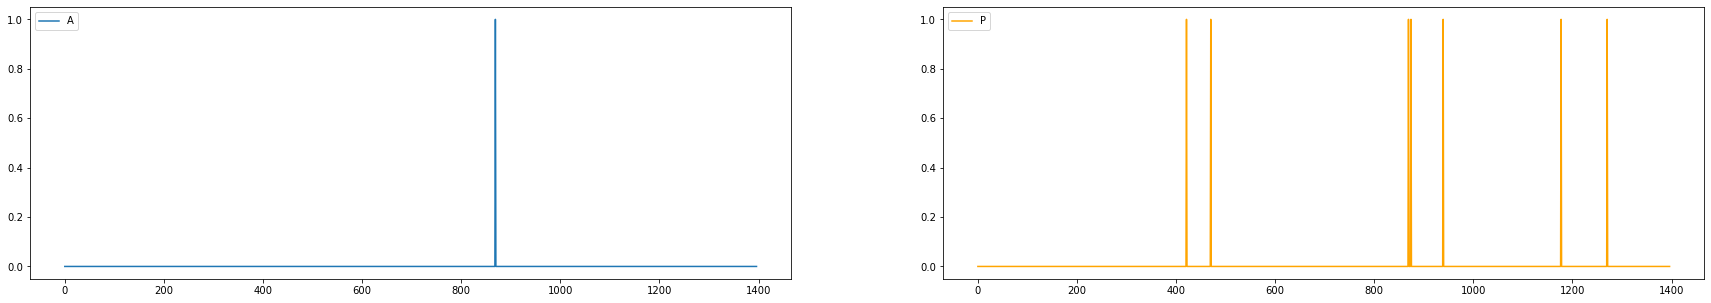

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_13.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_13.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.37808972e-06], Max [0.56542632]
Deviation 99.5th pctile [0.15421652]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 152635 ms


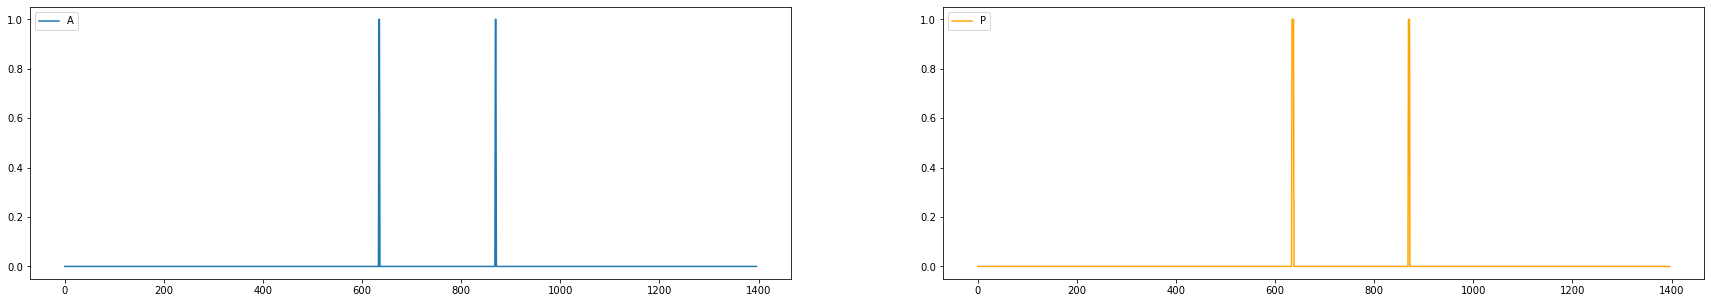

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_14.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_14.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [9.49632747e-06], Max [0.61860934]
Deviation 99.5th pctile [0.45801317]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 154297 ms


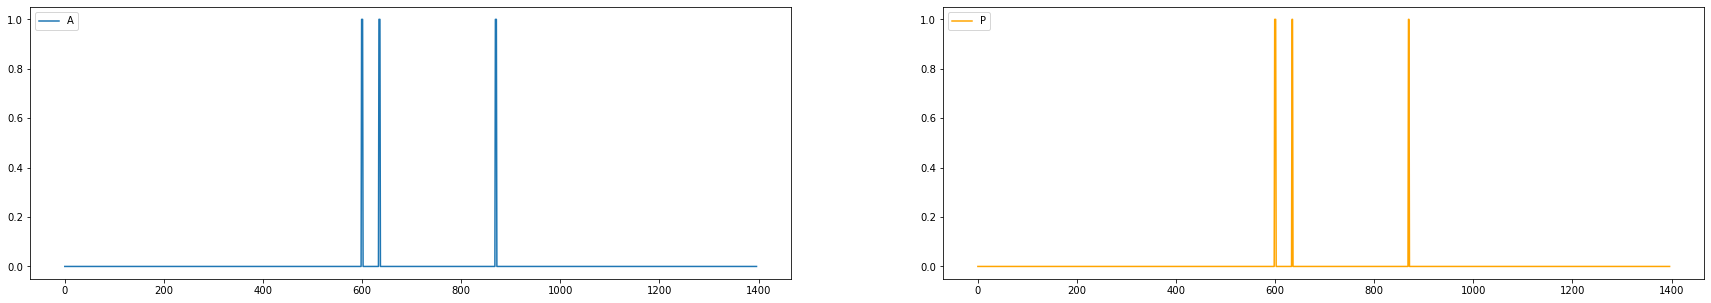

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_15.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_15.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.3648794e-05], Max [0.54832259]
Deviation 99.5th pctile [0.14436872]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 156561 ms


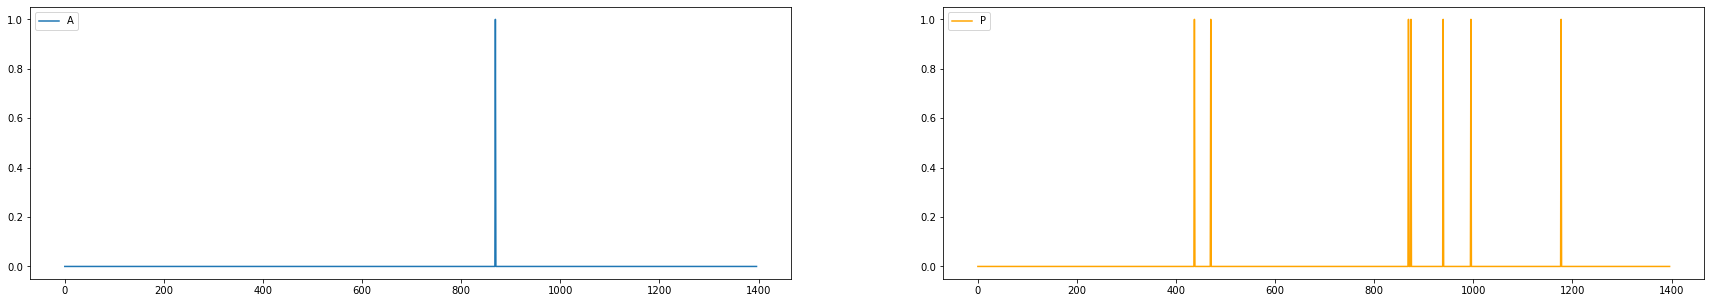

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_16.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_16.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.55014713e-06], Max [0.54530218]
Deviation 99.5th pctile [0.11482599]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 158363 ms


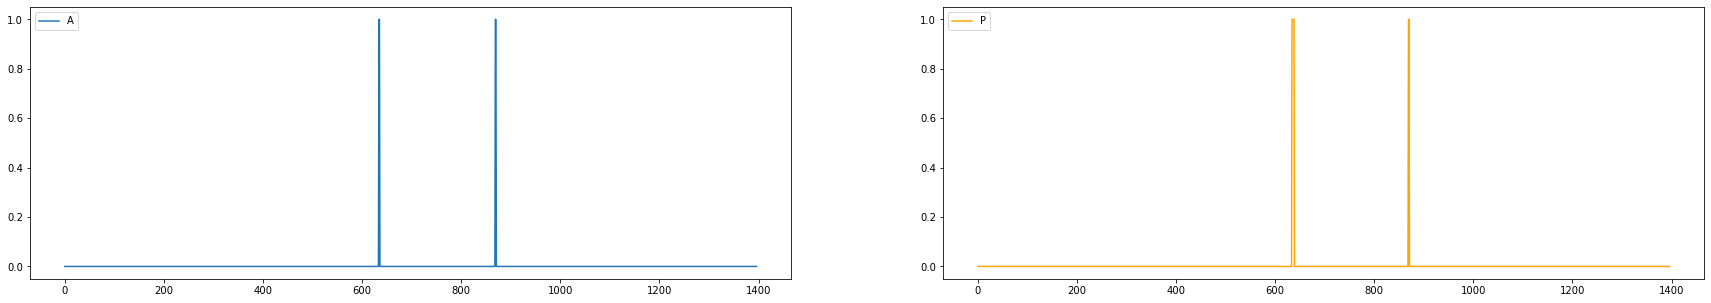

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_17.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_17.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00014397], Max [0.49895626]
Deviation 99.5th pctile [0.36903478]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 159988 ms


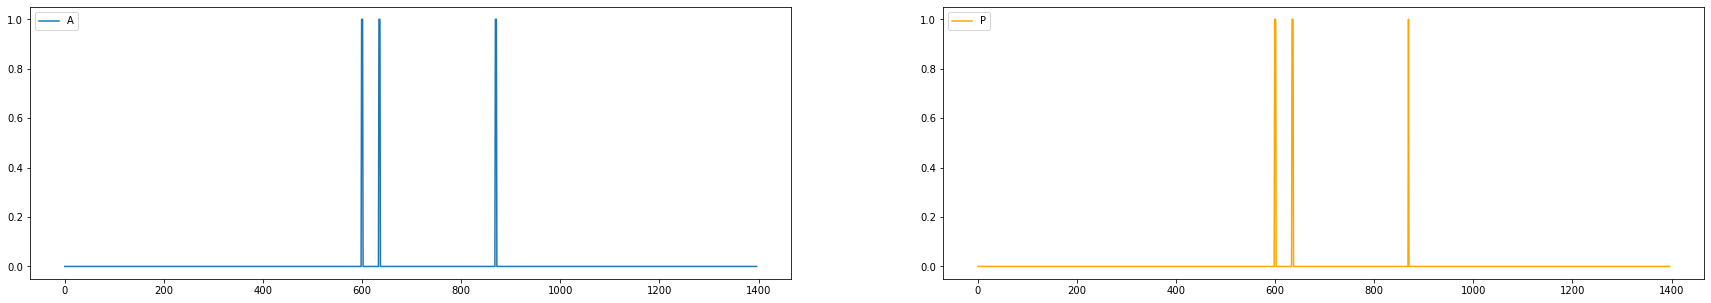

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_18.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_18.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.22111264e-05], Max [0.54820481]
Deviation 99.5th pctile [0.11246337]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 161896 ms


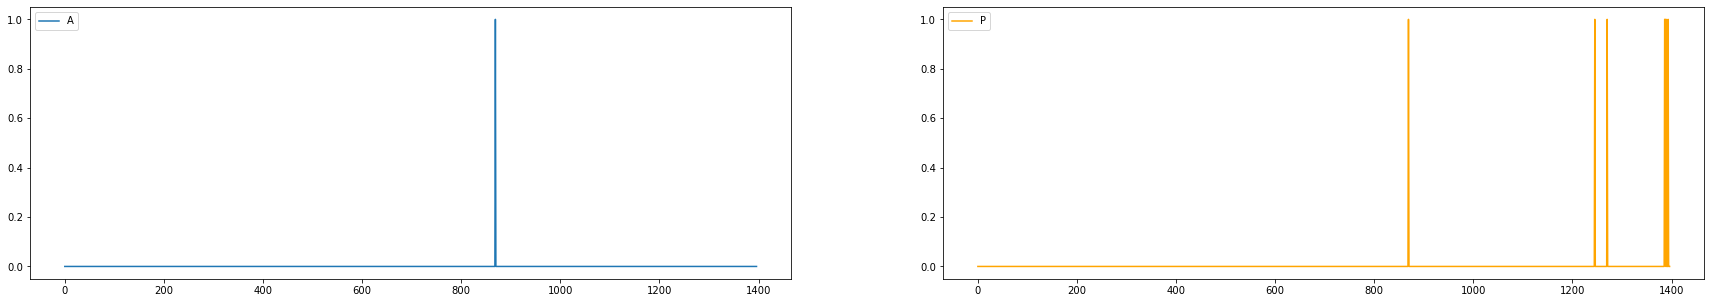

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_19.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_19.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00017757], Max [0.65783128]
Deviation 99.5th pctile [0.20804108]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 164613 ms


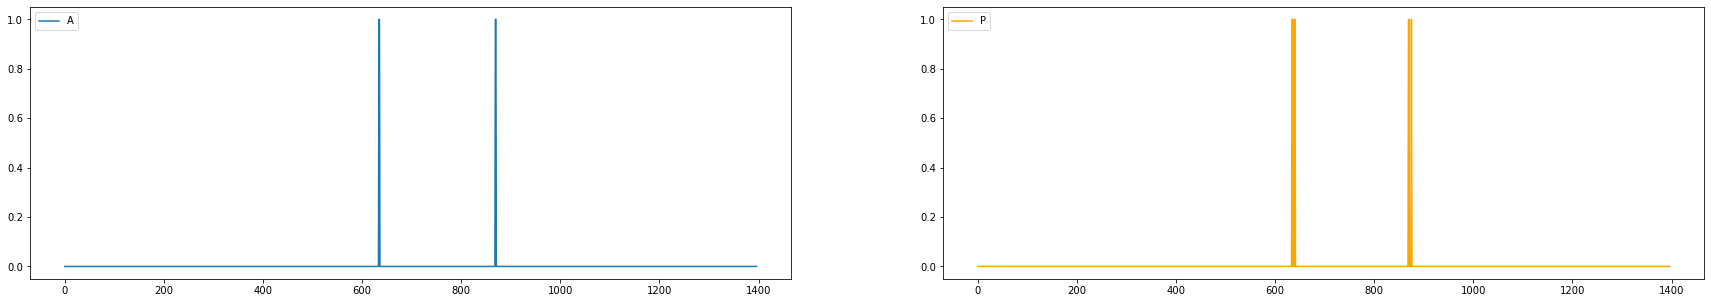

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_2.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_2.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.01544676e-05], Max [0.33460053]
Deviation 99.5th pctile [0.23814331]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 166388 ms


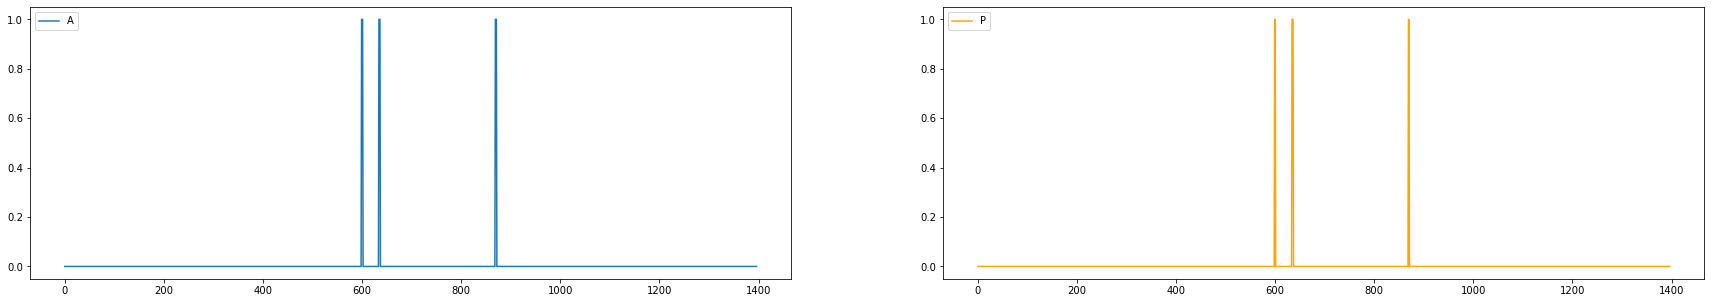

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_20.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_20.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [6.76085391e-05], Max [0.45647386]
Deviation 99.5th pctile [0.28718313]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 167951 ms


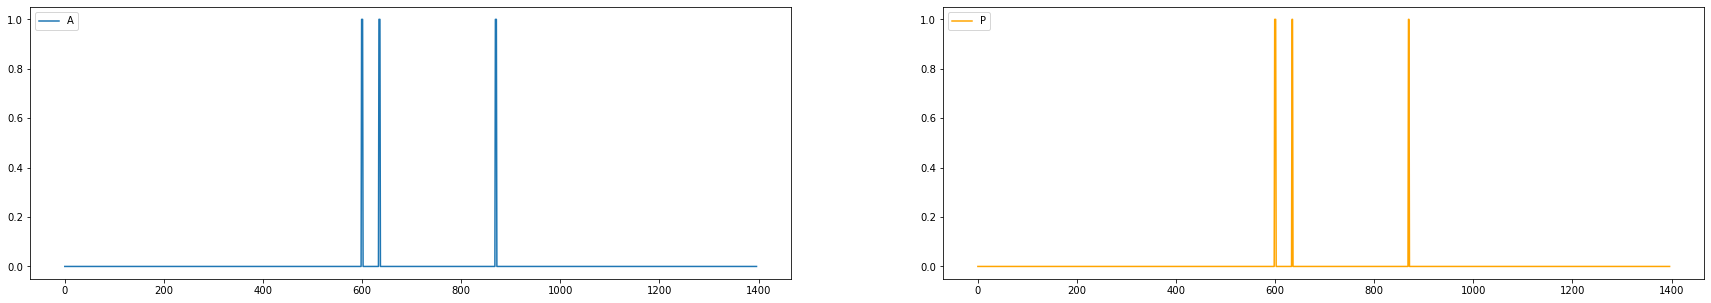

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_21.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_21.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.0647232e-05], Max [0.74157071]
Deviation 99.5th pctile [0.07659911]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 169514 ms


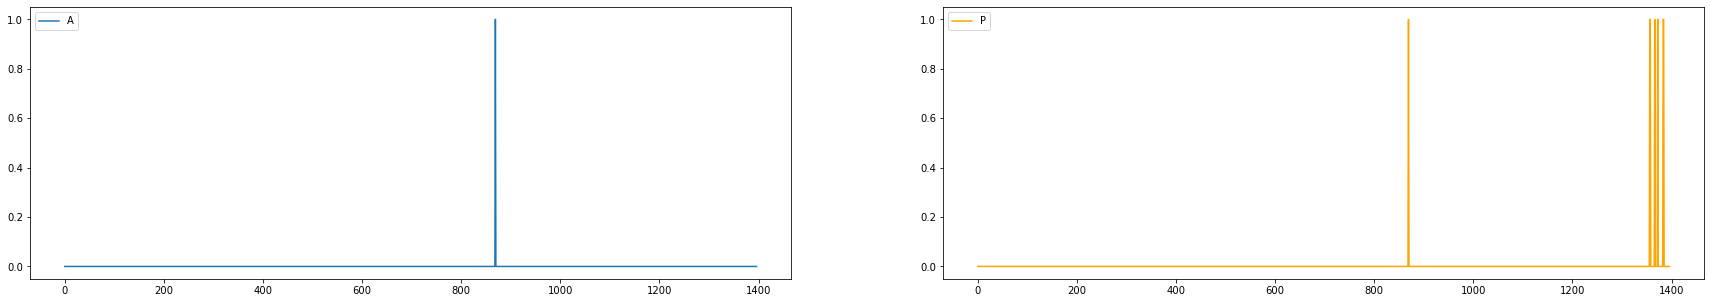

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_22.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_22.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.91517826e-05], Max [0.37943453]
Deviation 99.5th pctile [0.16084521]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 171152 ms


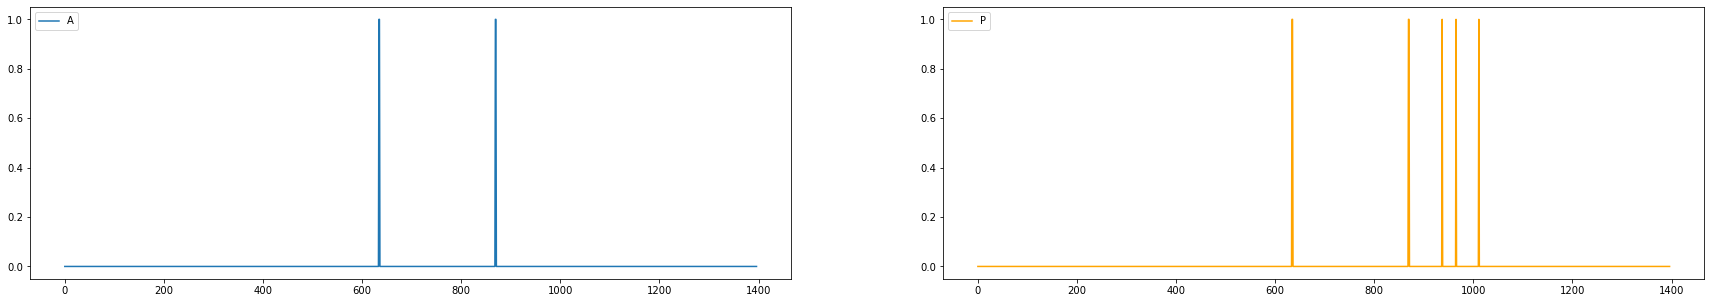

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_23.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_23.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.50891748e-06], Max [0.70777699]
Deviation 99.5th pctile [0.56721515]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 172565 ms


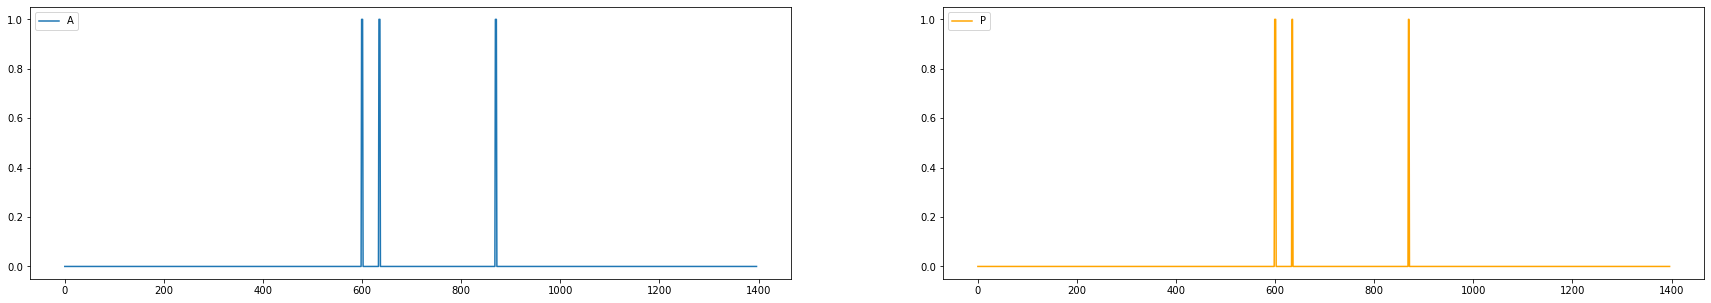

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_24.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_24.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00031475], Max [0.21851674]
Deviation 99.5th pctile [0.16611036]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 174807 ms


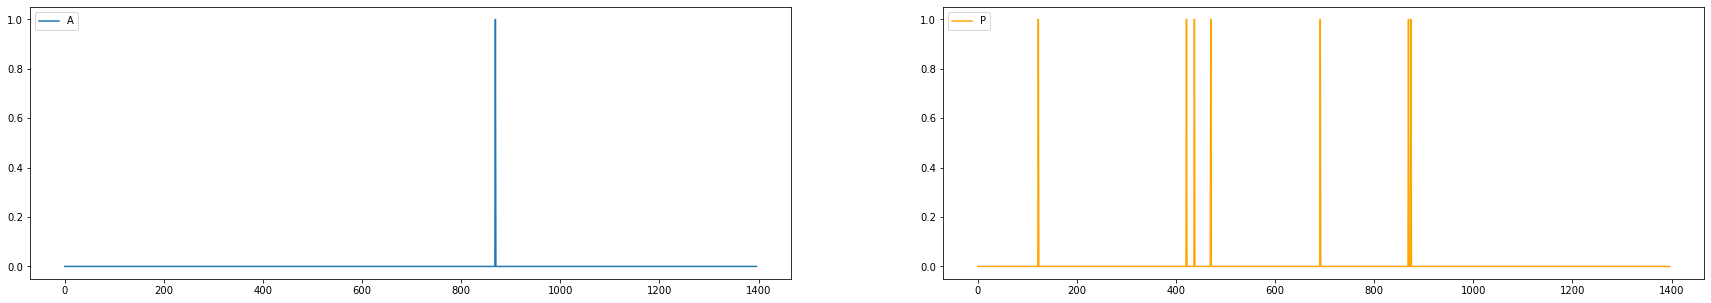

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_25.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_25.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.13990279e-05], Max [0.7447215]
Deviation 99.5th pctile [0.10681813]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 177069 ms


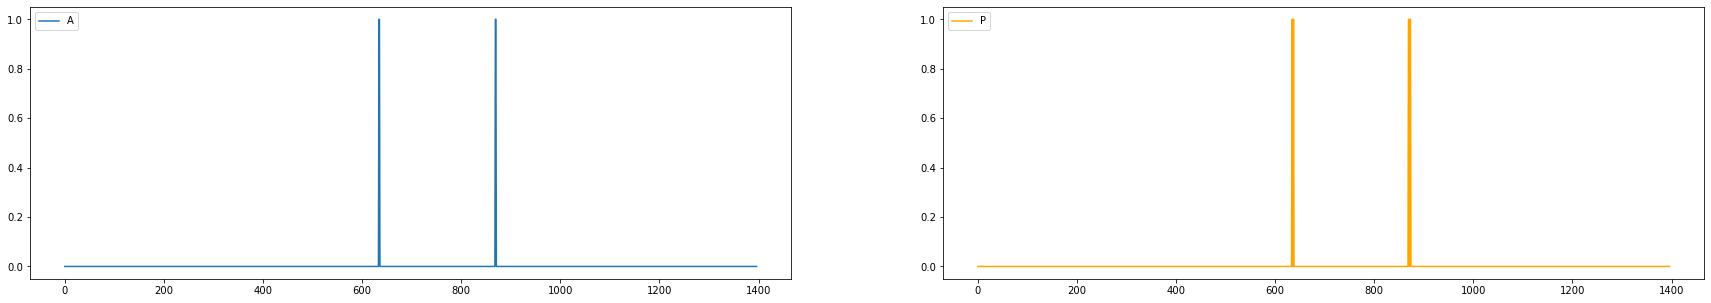

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_26.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_26.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [9.43737717e-05], Max [0.37856317]
Deviation 99.5th pctile [0.3022964]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 181845 ms


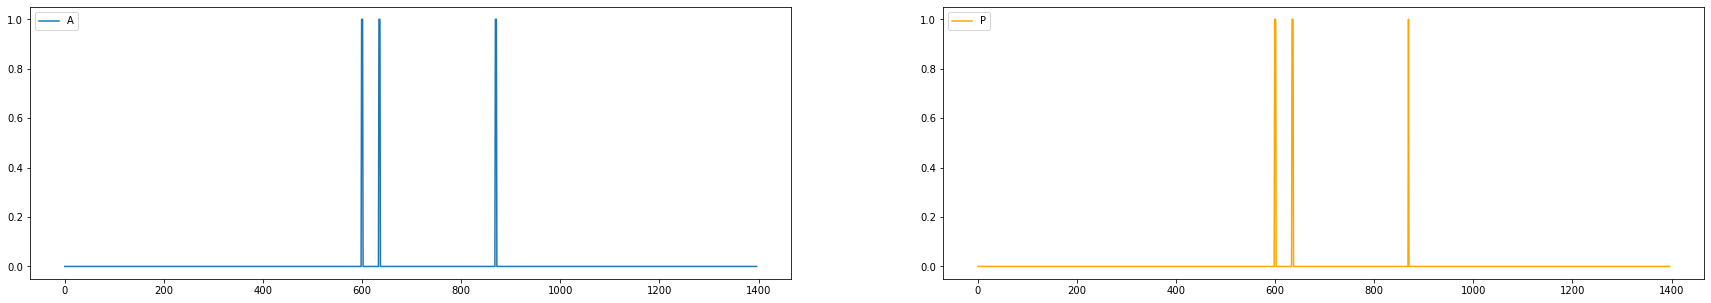

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_27.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_27.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.02113013e-05], Max [0.61536106]
Deviation 99.5th pctile [0.08332844]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 183559 ms


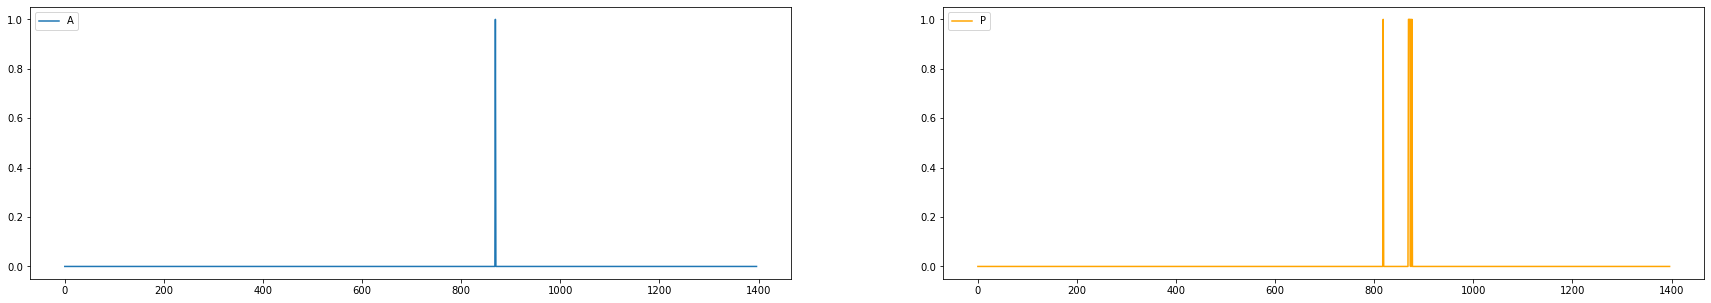

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_28.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_28.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00010441], Max [0.62085367]
Deviation 99.5th pctile [0.10718829]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 186506 ms


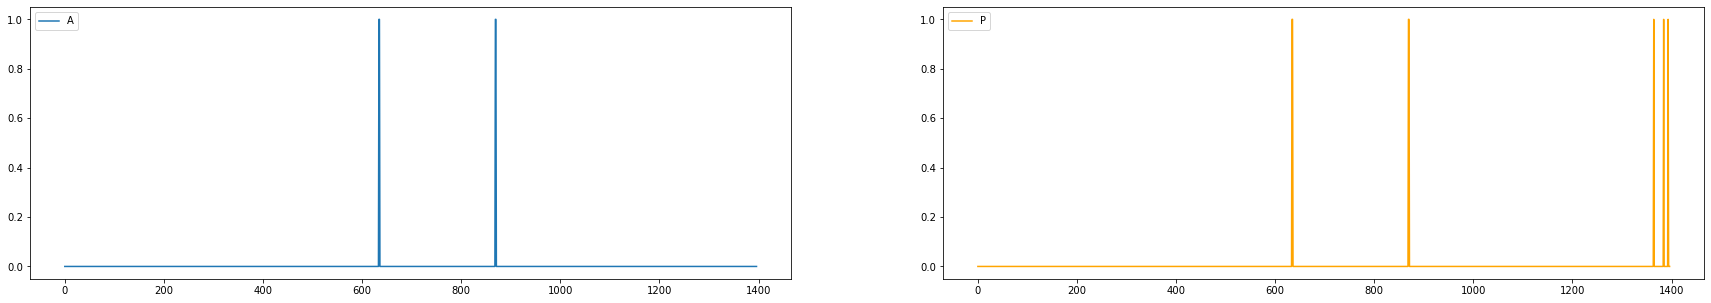

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_29.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_29.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00015465], Max [0.75693215]
Deviation 99.5th pctile [0.5874574]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 188880 ms


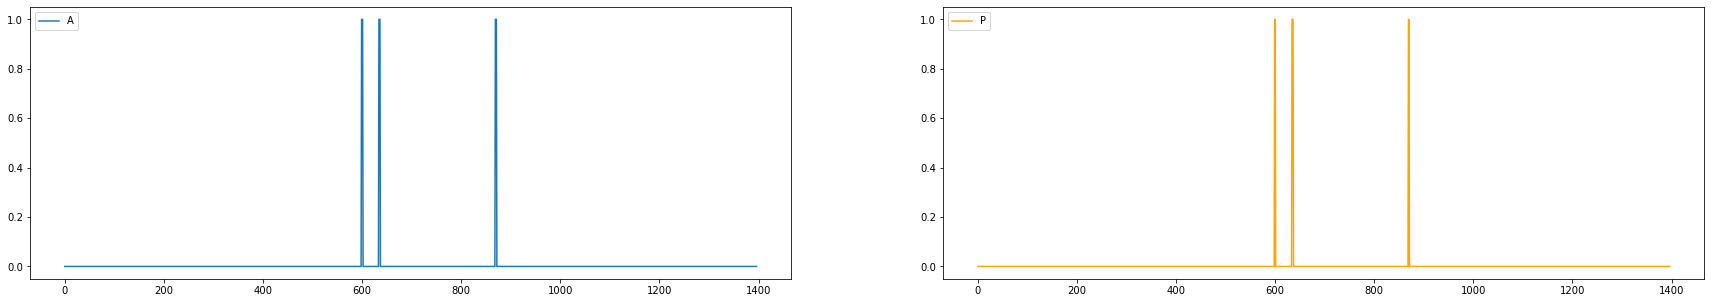

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_3.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_3.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.36158526e-05], Max [0.66423548]
Deviation 99.5th pctile [0.05847155]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 192404 ms


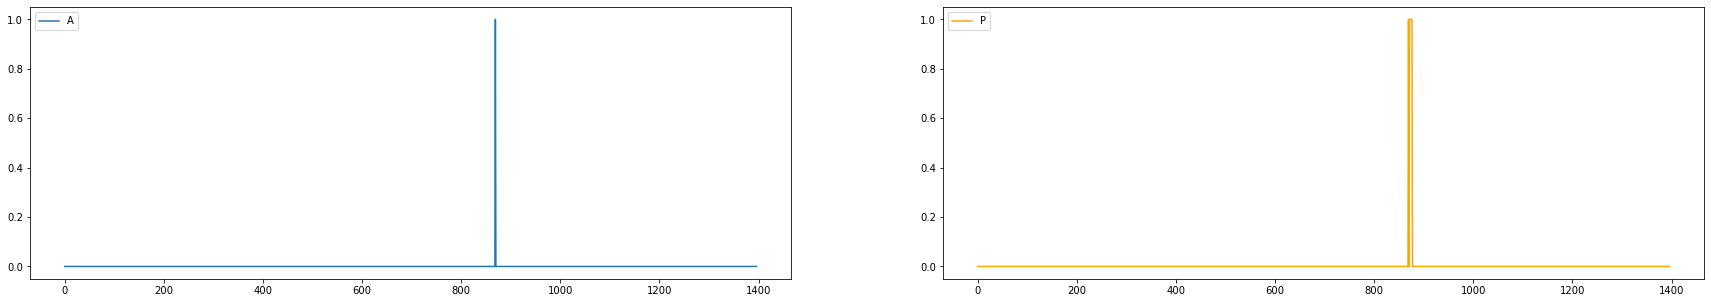

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_30.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_30.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.22821047e-07], Max [0.56759596]
Deviation 99.5th pctile [0.08791585]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 194225 ms


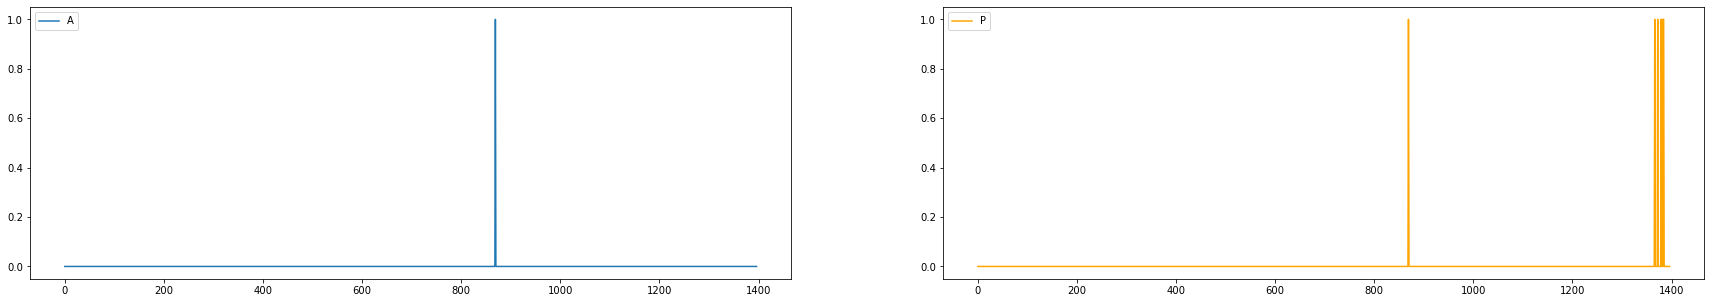

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_31.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_31.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [7.226633e-05], Max [0.56463411]
Deviation 99.5th pctile [0.13836393]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 195816 ms


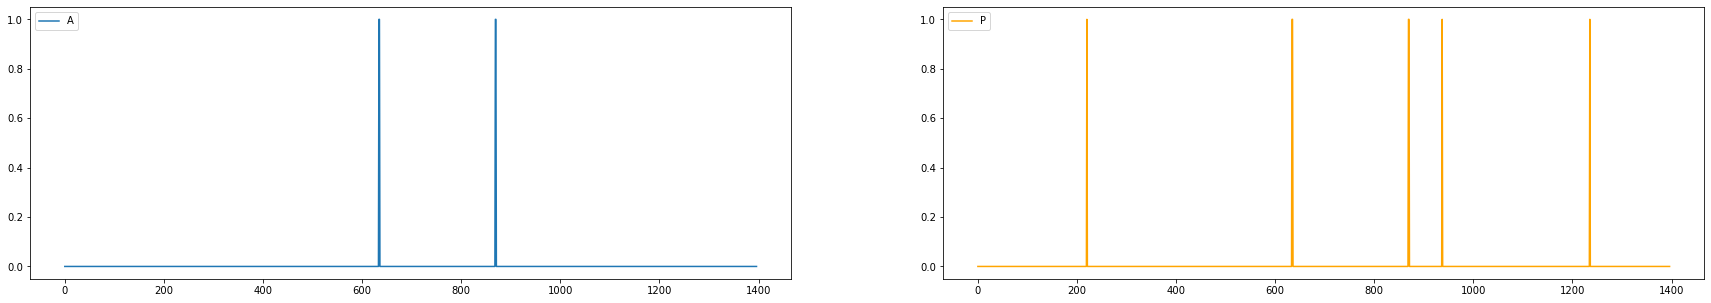

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_32.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_32.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.41181586e-05], Max [0.61125987]
Deviation 99.5th pctile [0.46547408]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 197160 ms


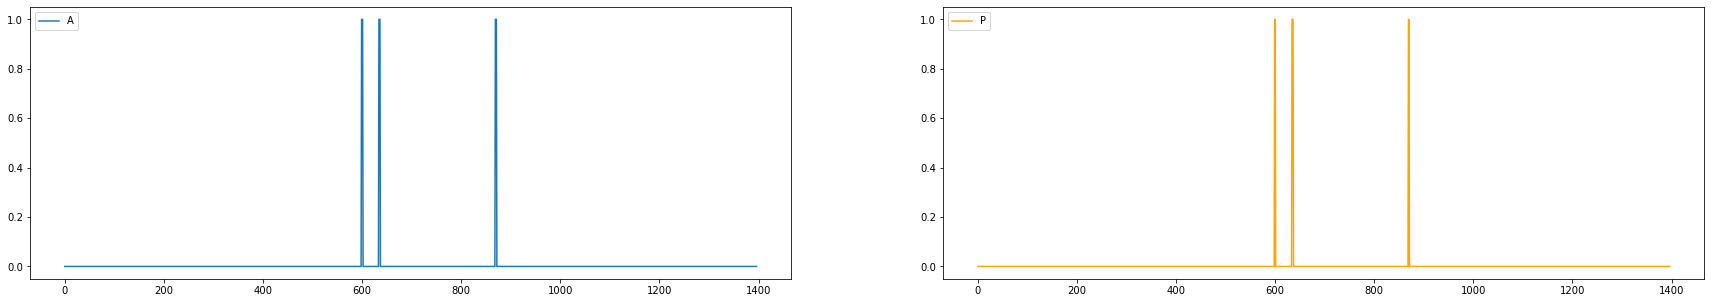

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_33.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_33.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00012375], Max [0.55263013]
Deviation 99.5th pctile [0.20770984]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 199990 ms


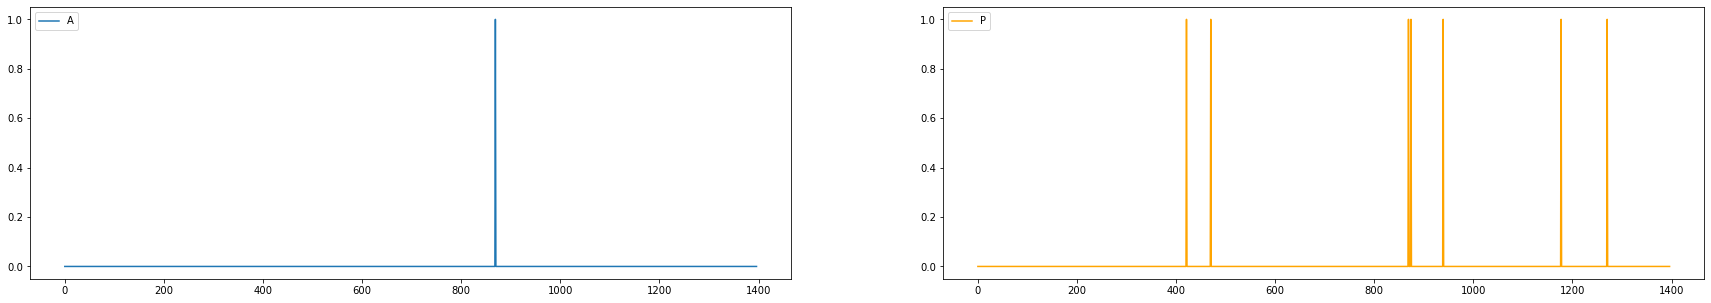

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_34.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_34.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.9147615e-06], Max [0.47163212]
Deviation 99.5th pctile [0.13028152]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 201896 ms


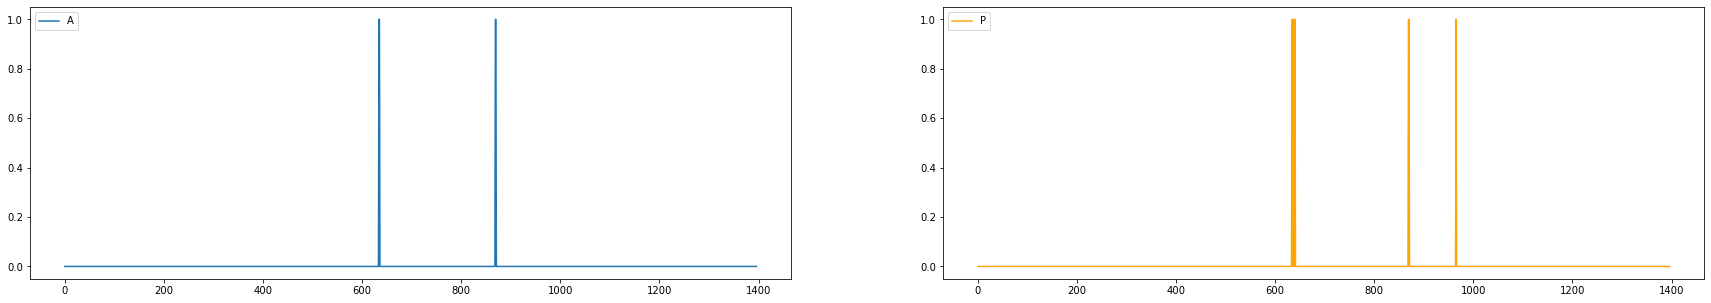

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_35.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_35.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.73790833e-05], Max [0.77443613]
Deviation 99.5th pctile [0.62819418]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 204170 ms


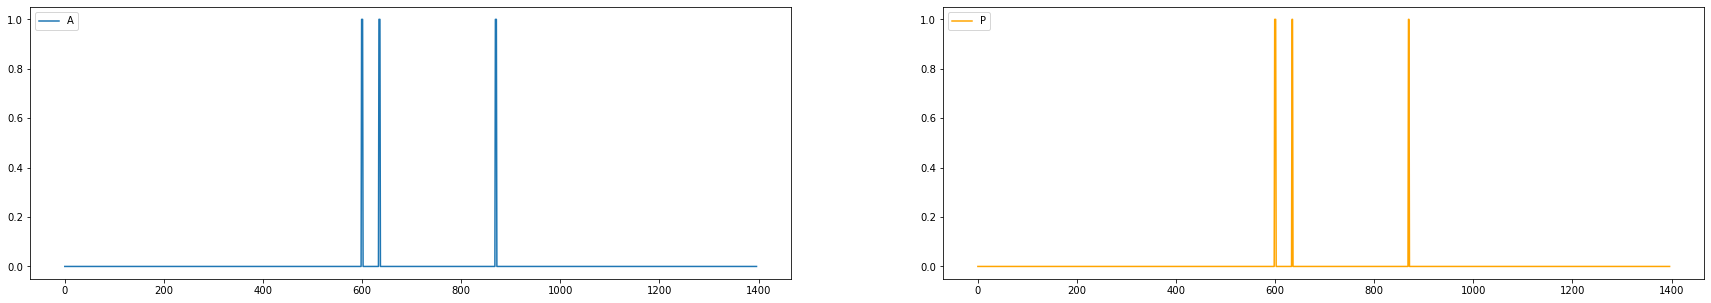

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_36.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_36.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [9.48577511e-05], Max [0.33276186]
Deviation 99.5th pctile [0.23252285]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 205959 ms


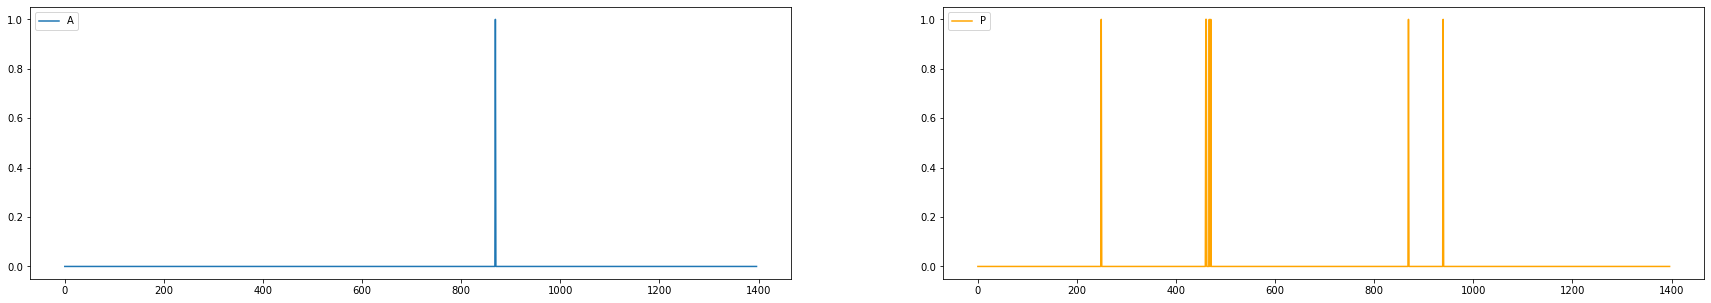

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_37.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_37.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.52433116e-07], Max [0.74210944]
Deviation 99.5th pctile [0.09151652]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 208315 ms


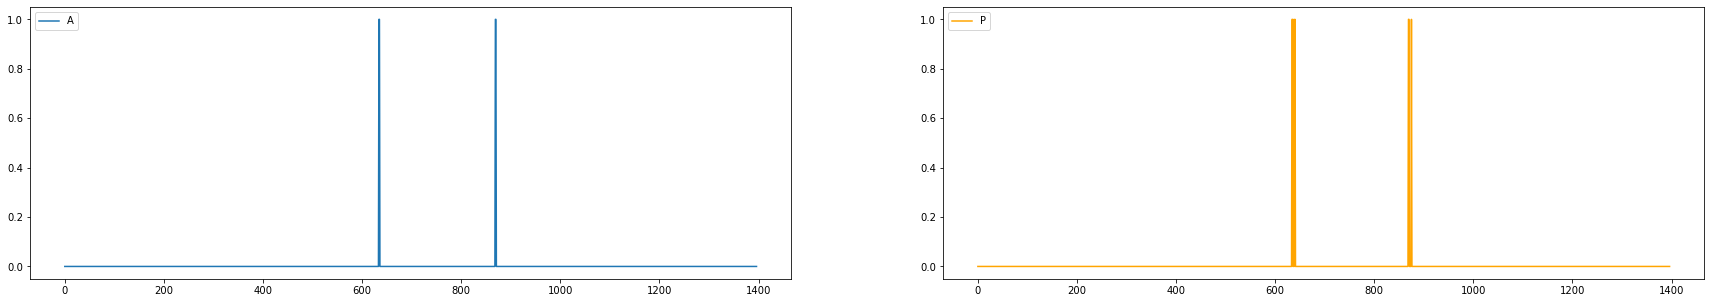

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_38.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_38.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.79566706e-06], Max [0.44521058]
Deviation 99.5th pctile [0.29518878]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 210527 ms


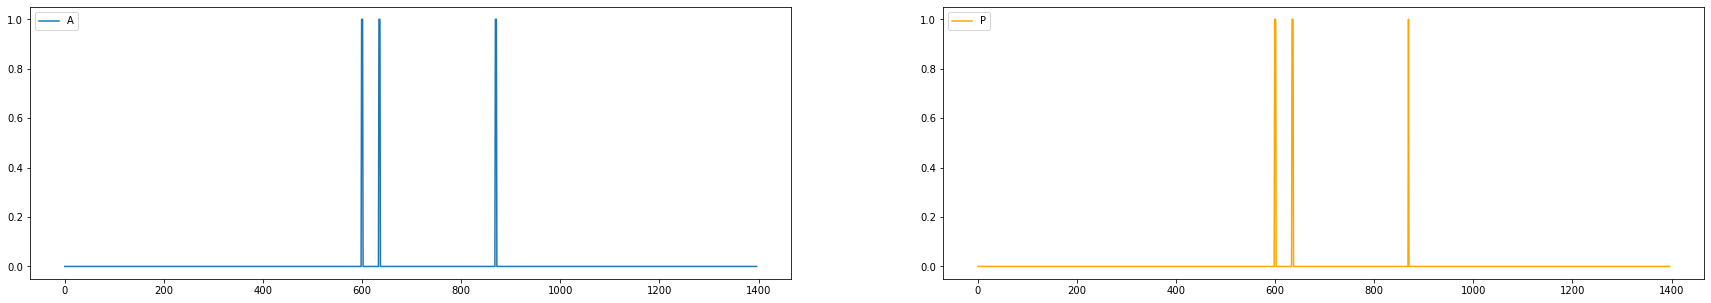

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_39.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_39.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.02355787e-05], Max [0.68283454]
Deviation 99.5th pctile [0.06671744]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 213842 ms


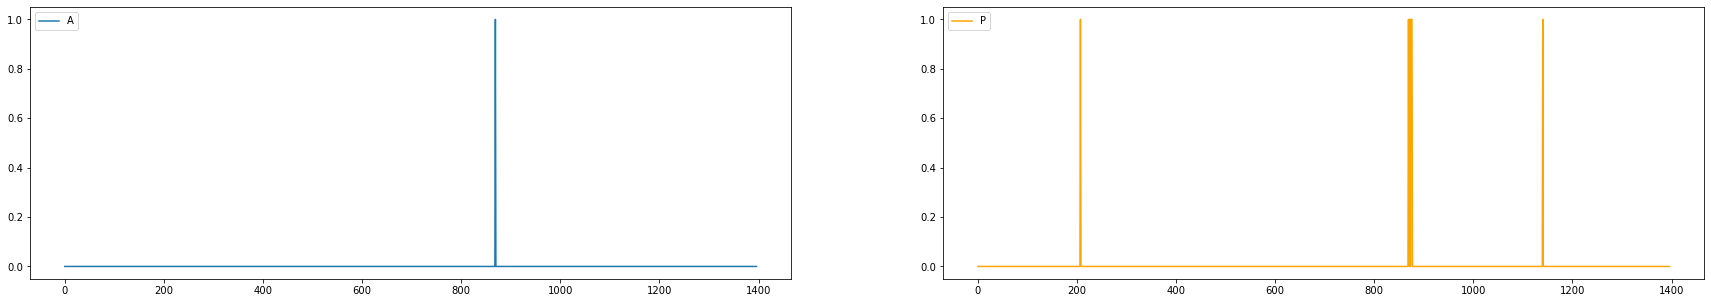

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_4.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_4.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.78601278e-06], Max [0.4580138]
Deviation 99.5th pctile [0.10397508]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 216751 ms


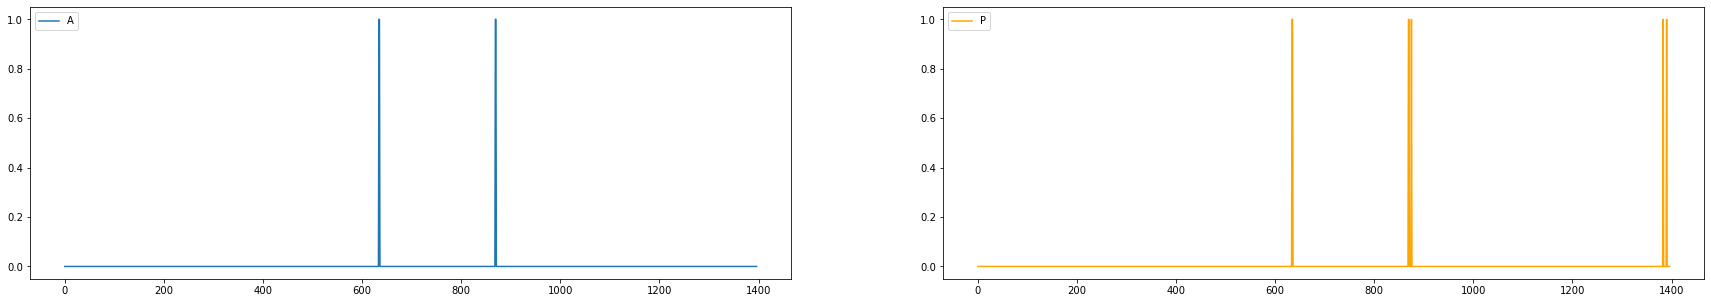

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_40.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_40.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.38782986e-06], Max [0.48210284]
Deviation 99.5th pctile [0.21439292]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 219819 ms


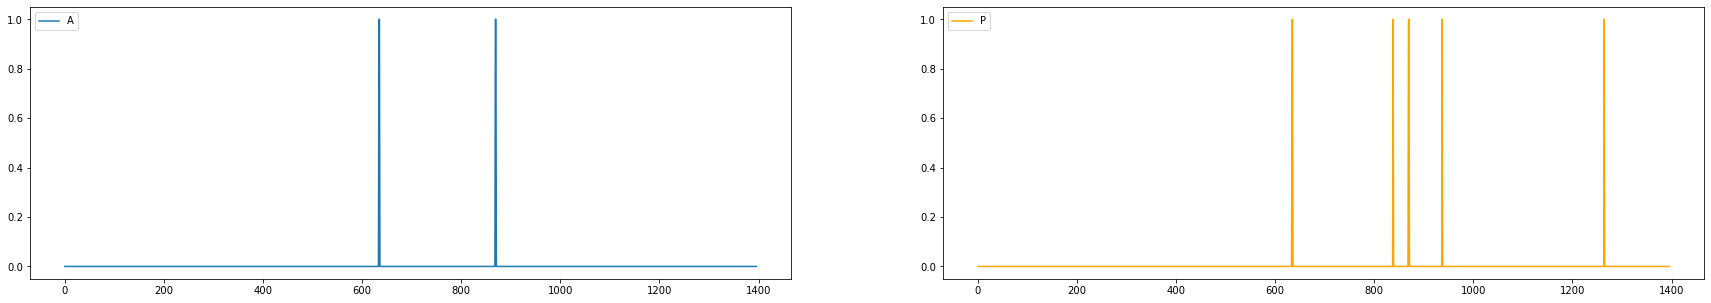

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_41.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_41.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.89404523e-05], Max [0.68670855]
Deviation 99.5th pctile [0.54796317]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 222263 ms


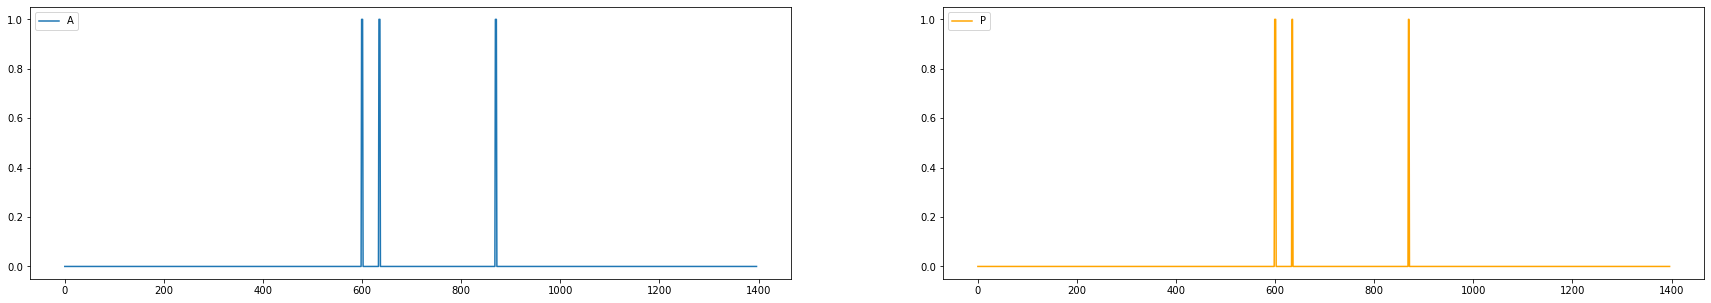

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_42.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_42.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.14849099e-05], Max [0.55490535]
Deviation 99.5th pctile [0.128776]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 225781 ms


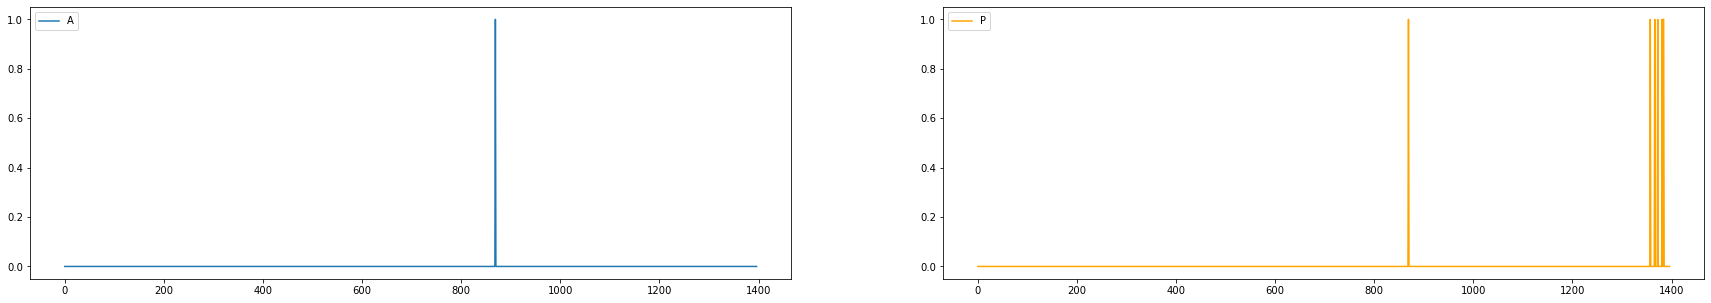

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_43.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_43.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.67156144e-05], Max [0.77439907]
Deviation 99.5th pctile [0.16270023]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 228811 ms


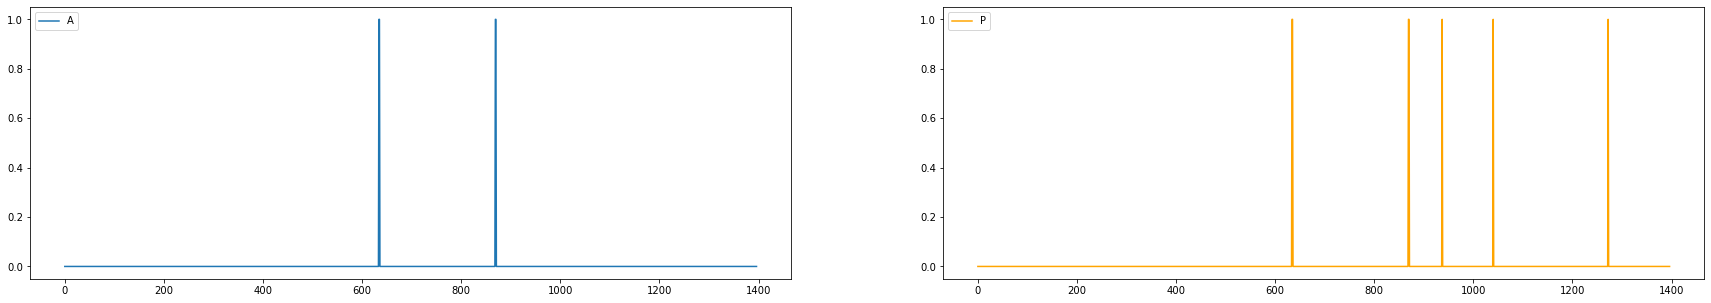

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_44.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_44.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.63084298e-05], Max [0.62445471]
Deviation 99.5th pctile [0.49006974]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 230688 ms


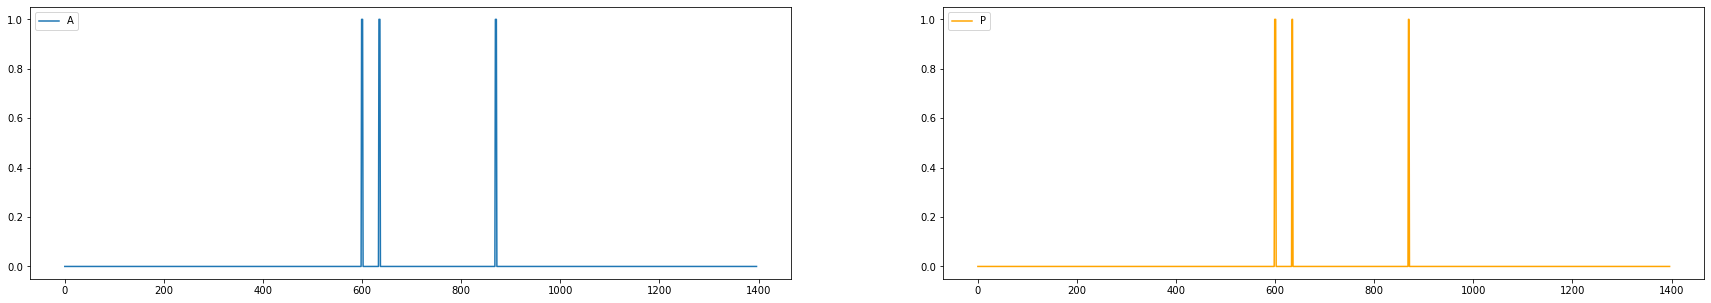

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_45.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_45.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.54033628e-05], Max [0.55746053]
Deviation 99.5th pctile [0.19965773]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 235020 ms


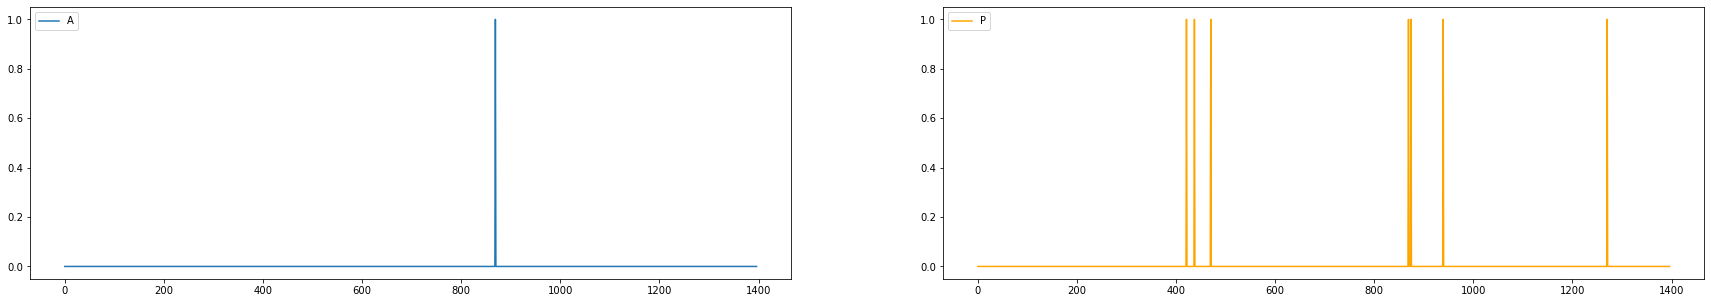

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_46.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_46.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.03443909e-05], Max [0.61537617]
Deviation 99.5th pctile [0.1156099]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 237370 ms


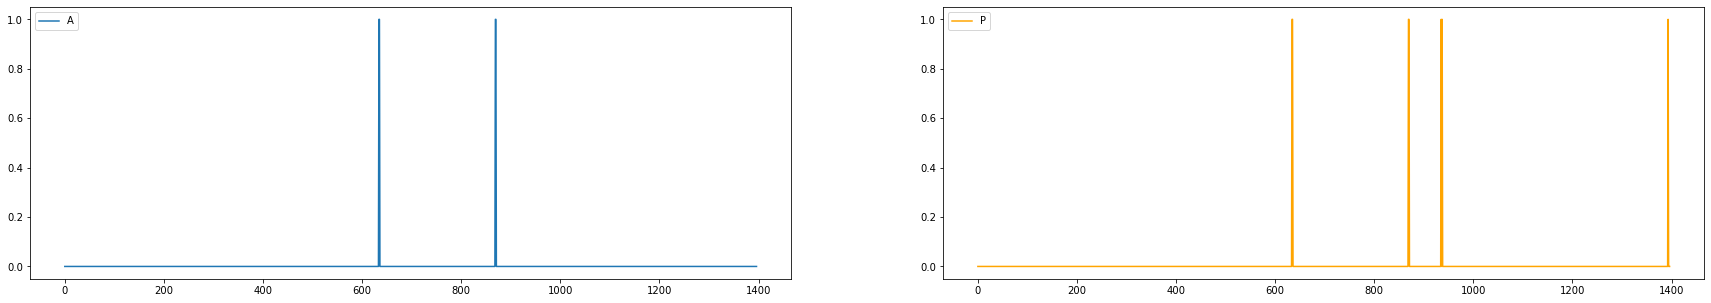

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_47.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_47.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.02378703e-06], Max [0.64064595]
Deviation 99.5th pctile [0.5038332]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 239617 ms


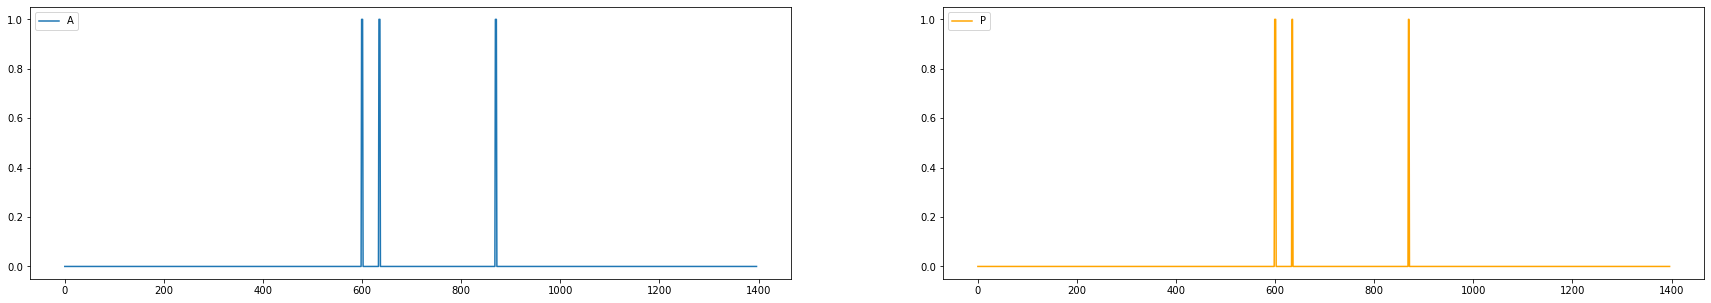

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_48.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_48.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.41948013e-06], Max [0.43182051]
Deviation 99.5th pctile [0.12945027]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 241894 ms


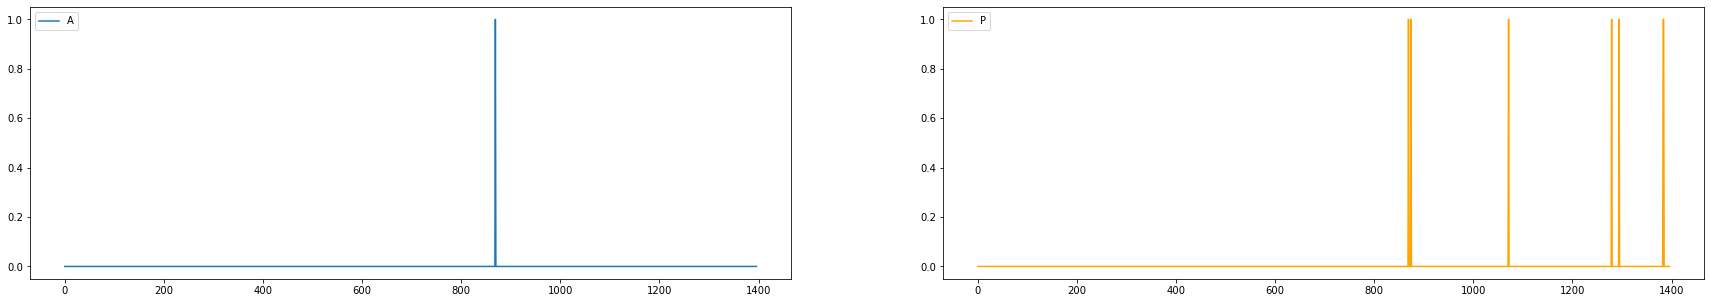

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_49.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_49.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.27942448e-06], Max [0.73008388]
Deviation 99.5th pctile [0.1219987]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 243939 ms


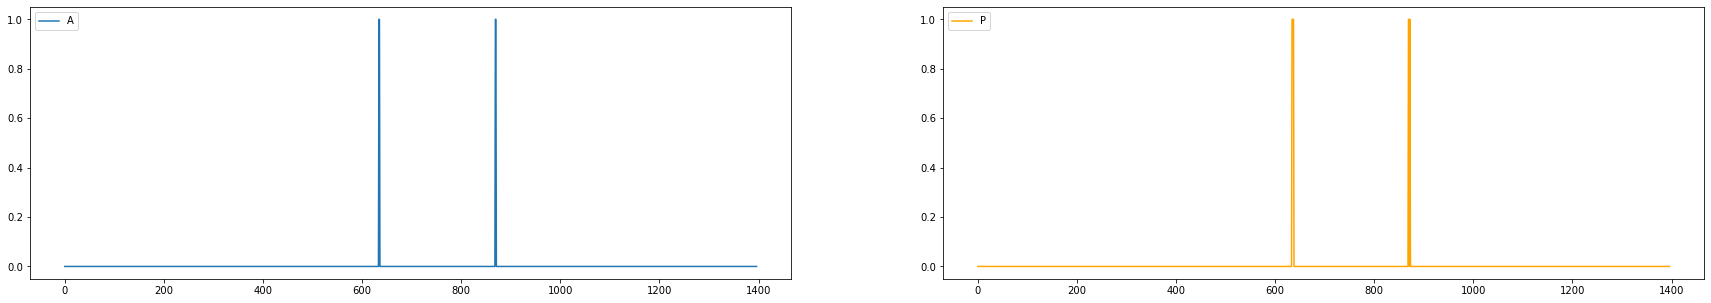

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_5.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_5.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.85925803e-06], Max [0.42150235]
Deviation 99.5th pctile [0.31232321]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 246229 ms


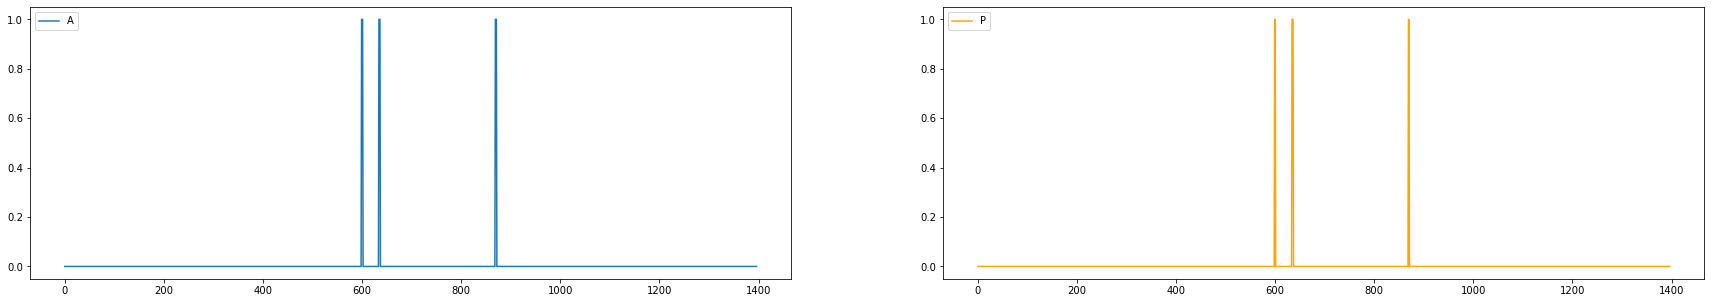

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_50.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.61732298e-05], Max [0.53383544]
Deviation 99.5th pctile [0.45418761]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 248585 ms


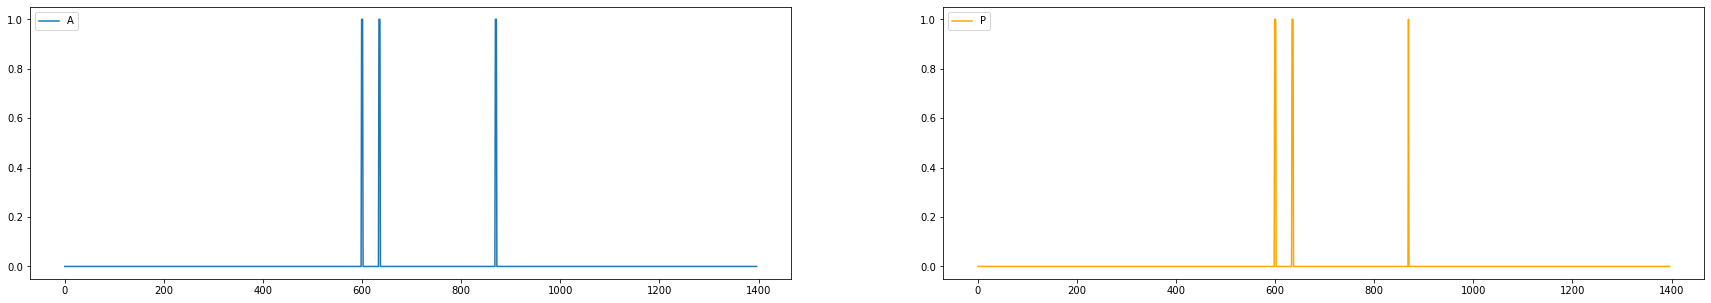

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_51.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_51.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.96183102e-06], Max [0.7228111]
Deviation 99.5th pctile [0.05048064]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 250185 ms


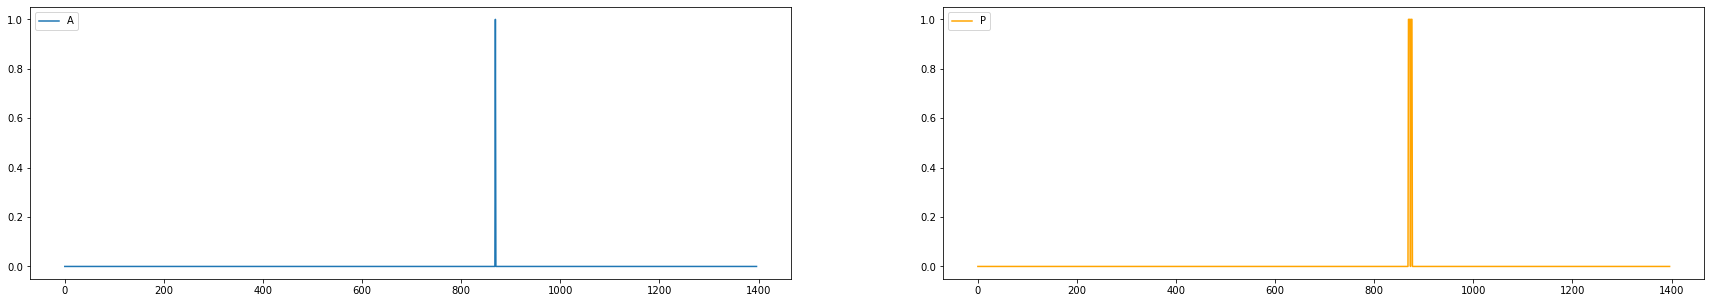

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_52.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_52.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.31247804e-05], Max [0.51555386]
Deviation 99.5th pctile [0.17549884]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 251696 ms


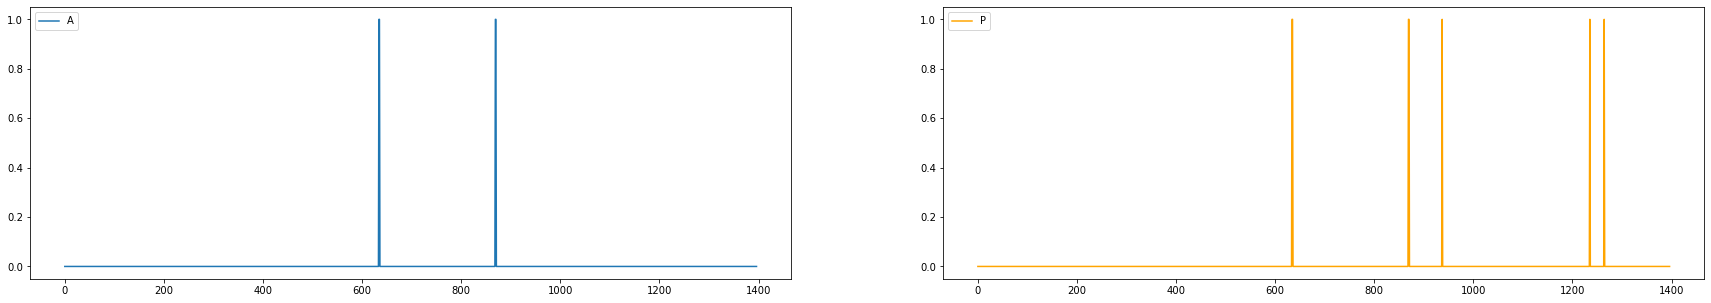

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_53.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_53.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.33506e-05], Max [0.75081022]
Deviation 99.5th pctile [0.68383582]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 254329 ms


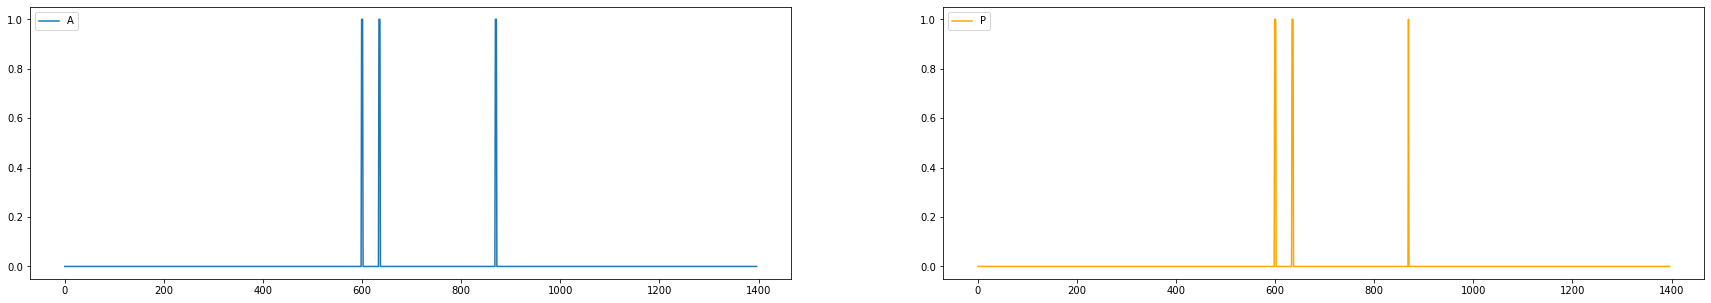

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_54.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_54.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.92216701e-05], Max [0.33244319]
Deviation 99.5th pctile [0.26021696]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 257323 ms


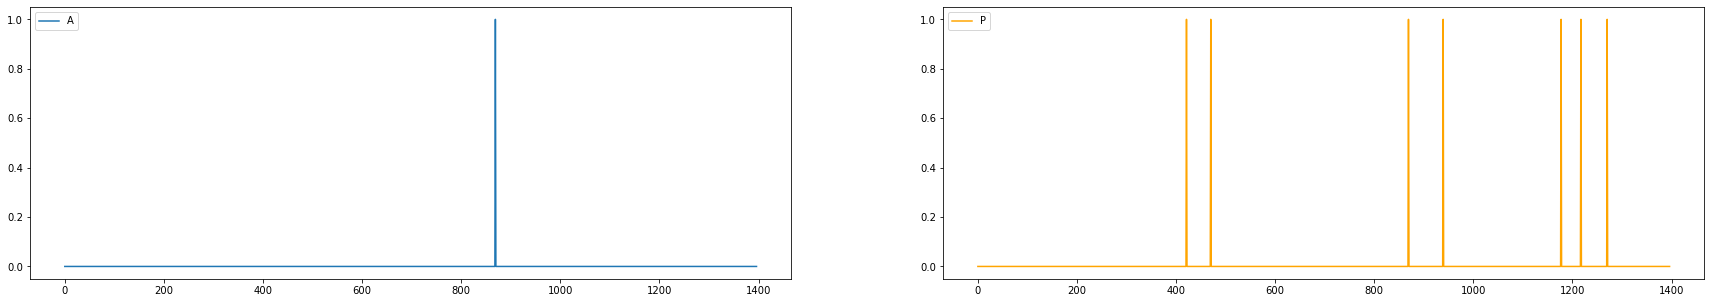

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_55.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_55.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.92902487e-05], Max [0.66141391]
Deviation 99.5th pctile [0.11884853]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 258984 ms


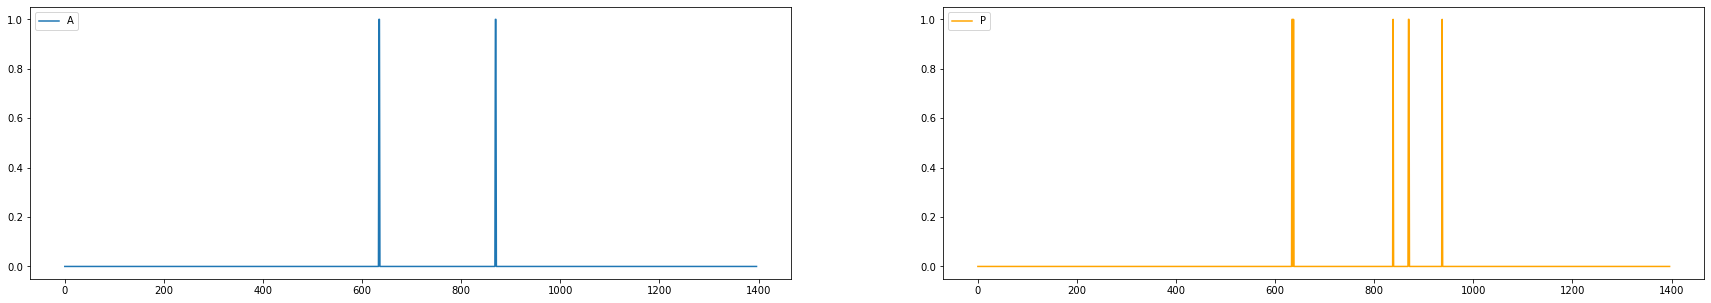

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_56.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_56.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.58329325e-06], Max [0.57966038]
Deviation 99.5th pctile [0.5331958]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 262551 ms


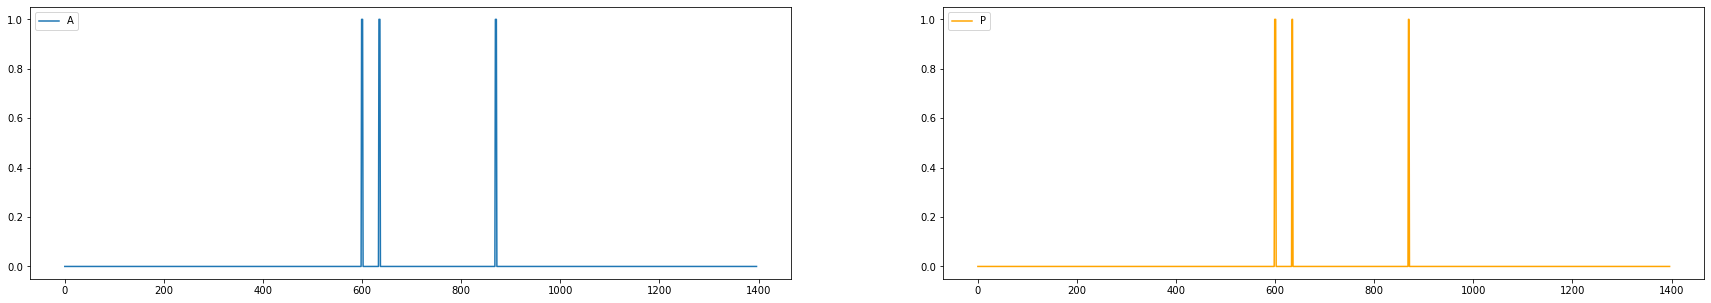

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_57.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_57.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.0001683], Max [0.67142171]
Deviation 99.5th pctile [0.2107069]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 267726 ms


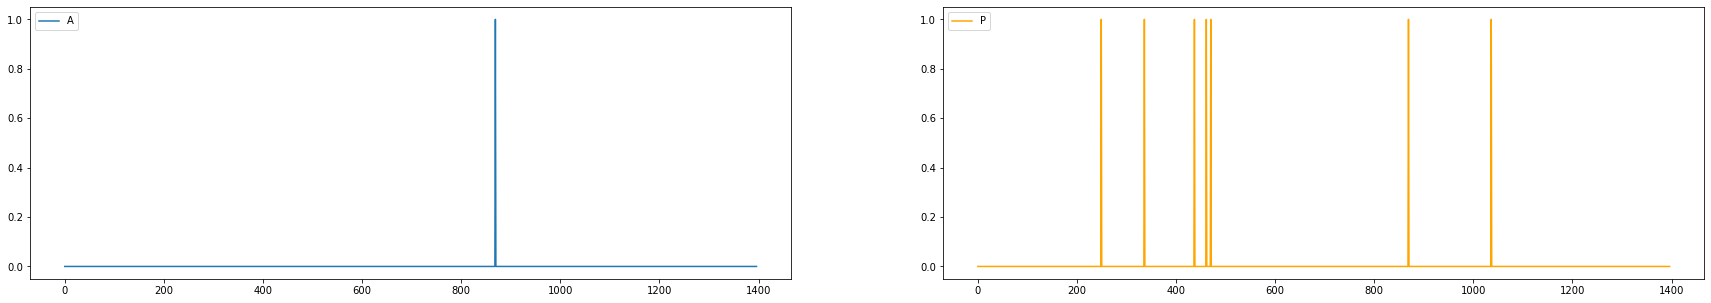

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_58.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_58.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00011759], Max [0.59649773]
Deviation 99.5th pctile [0.10138871]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 271844 ms


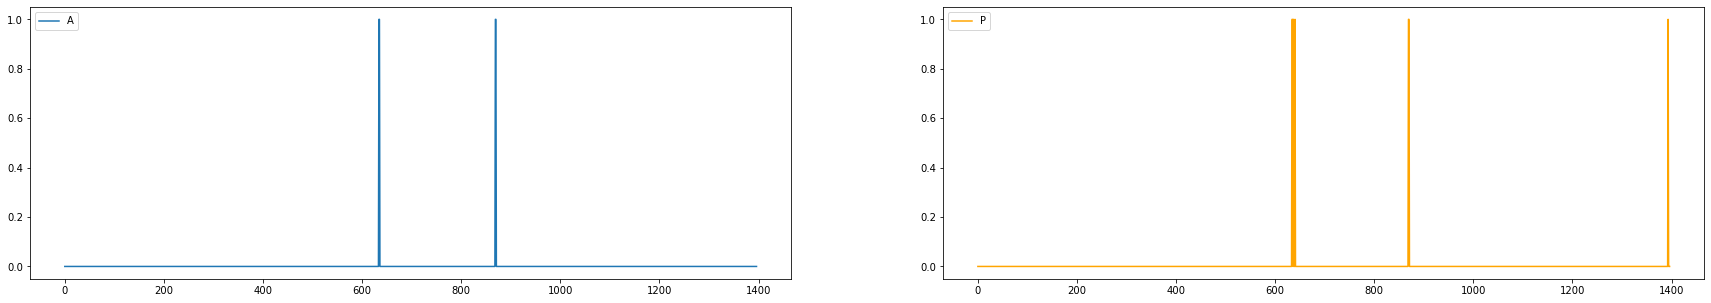

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_59.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_59.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.21336278e-05], Max [0.68287361]
Deviation 99.5th pctile [0.53330496]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 277080 ms


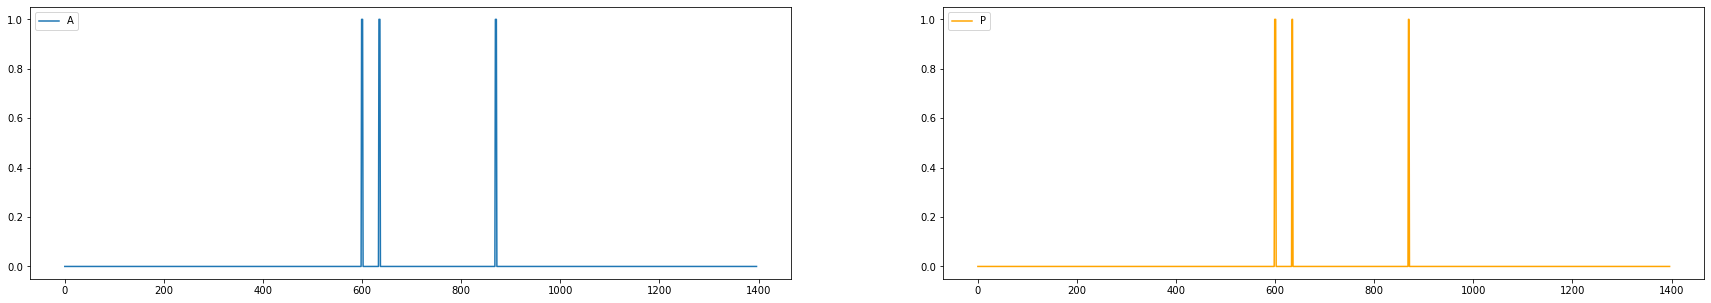

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_6.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_6.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.39916786e-05], Max [0.44981863]
Deviation 99.5th pctile [0.08813548]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 282855 ms


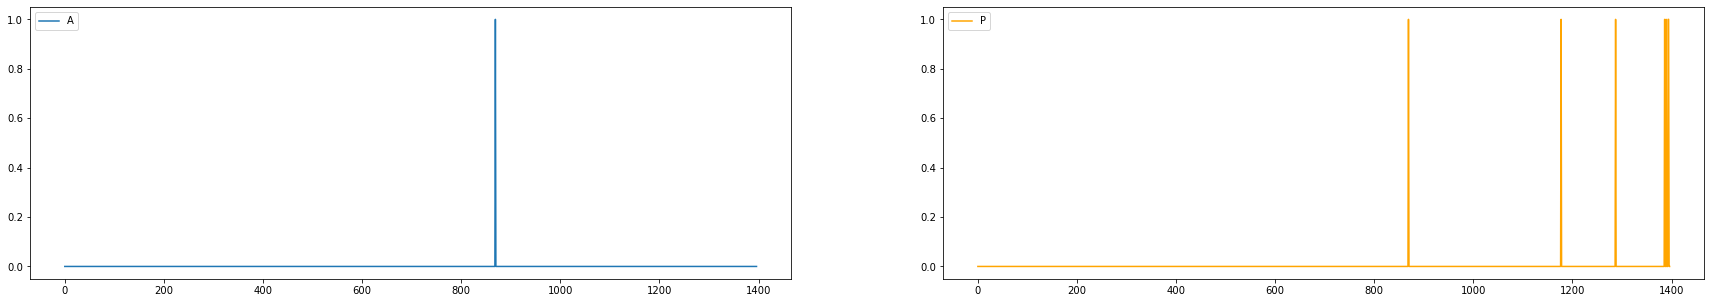

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_60.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_60.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.3889778e-05], Max [0.57461479]
Deviation 99.5th pctile [0.03472788]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 285683 ms


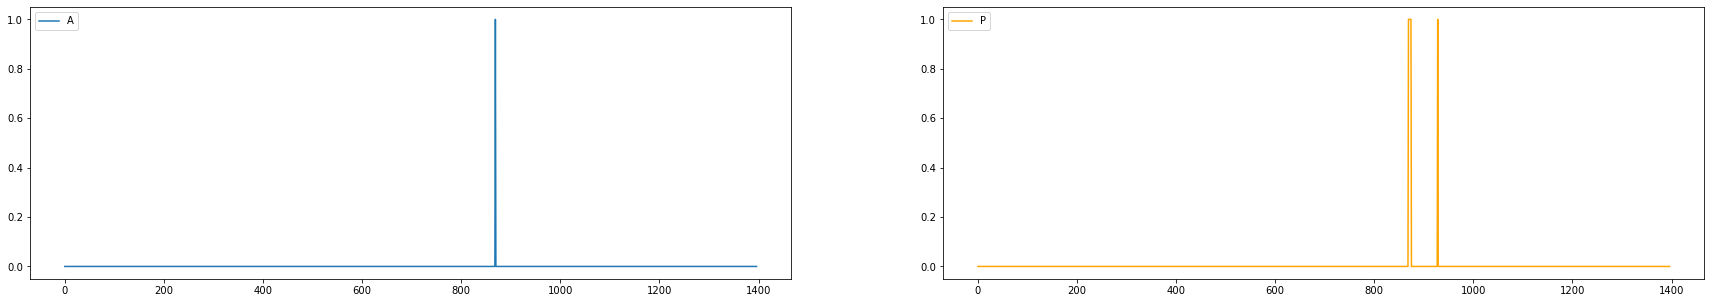

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_61.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_61.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.65421563e-05], Max [0.68976071]
Deviation 99.5th pctile [0.13127804]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 290068 ms


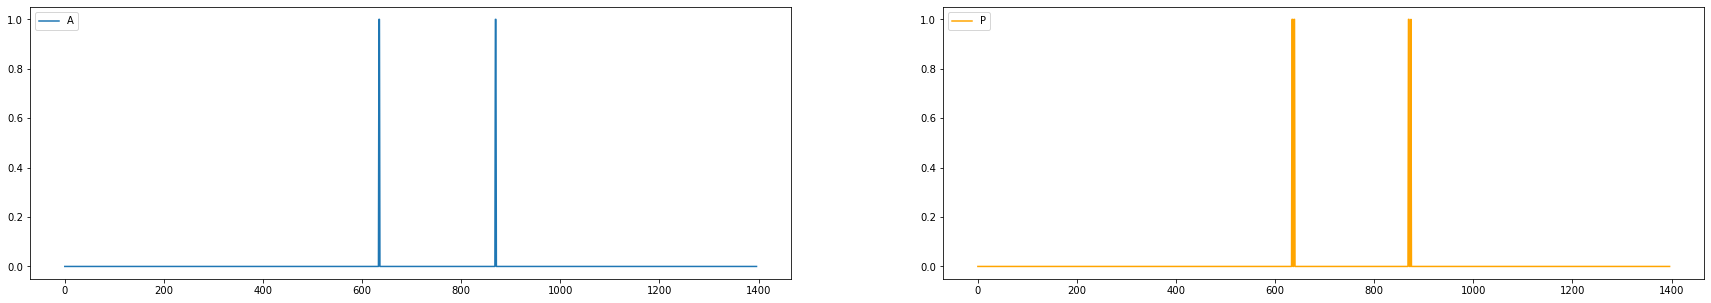

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_62.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_62.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.56697446e-06], Max [0.56008652]
Deviation 99.5th pctile [0.41801661]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 291819 ms


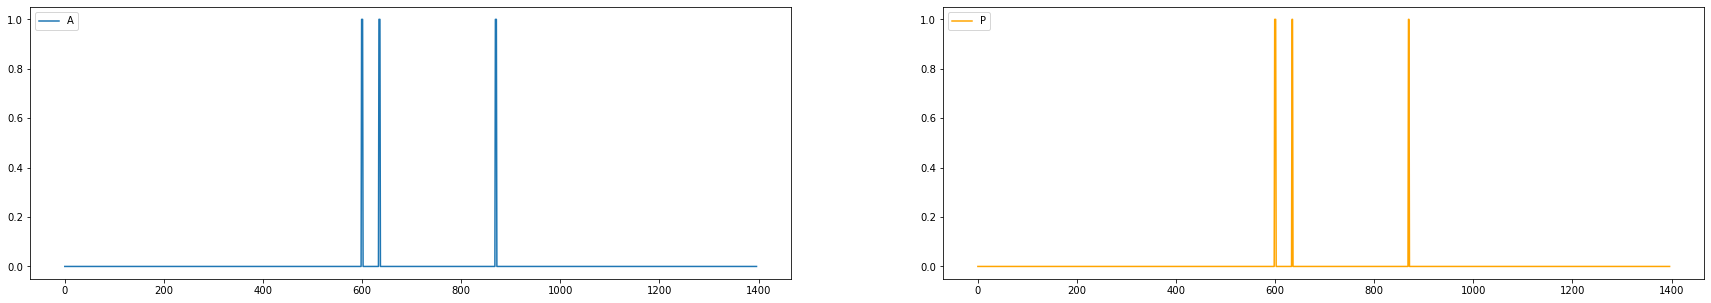

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_63.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_63.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [7.08821935e-06], Max [0.72279751]
Deviation 99.5th pctile [0.0493544]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 294577 ms


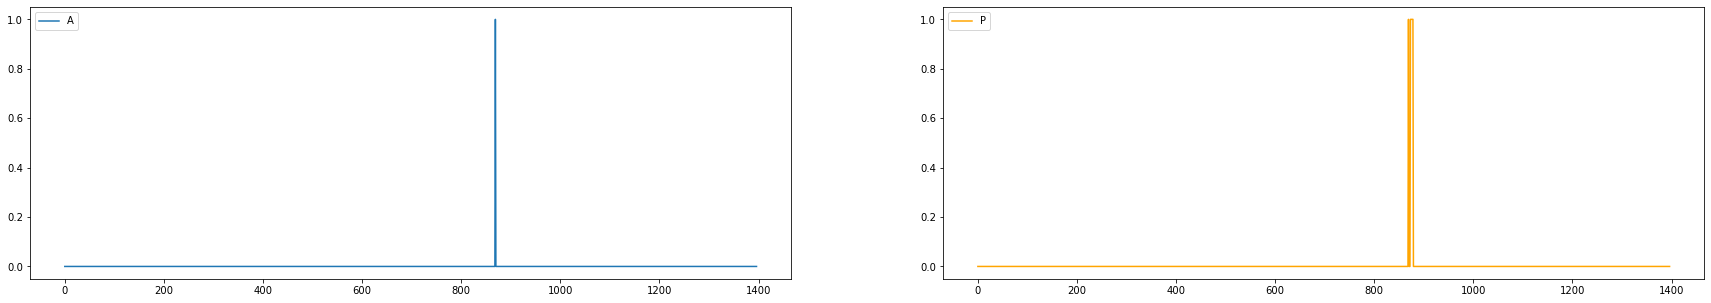

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_64.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_64.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.09580466e-05], Max [0.38700476]
Deviation 99.5th pctile [0.06521902]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 298097 ms


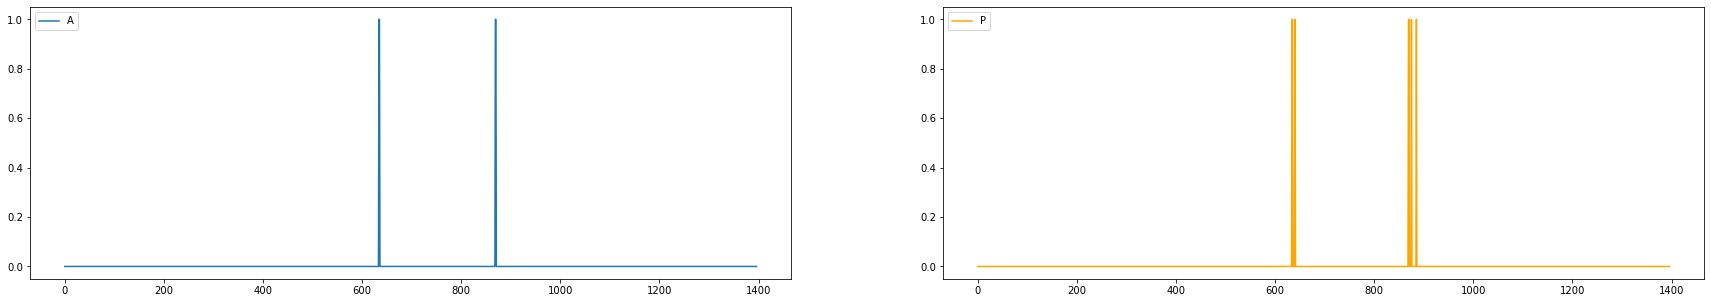

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_65.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_65.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00101052], Max [0.73560484]
Deviation 99.5th pctile [0.56077525]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 299875 ms


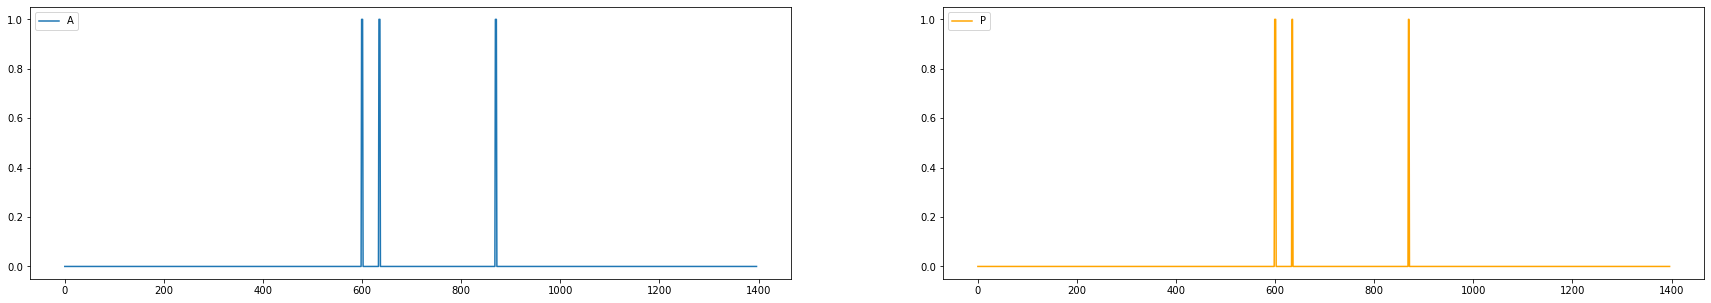

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_66.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_66.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00010493], Max [0.31423]
Deviation 99.5th pctile [0.08341186]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 303897 ms


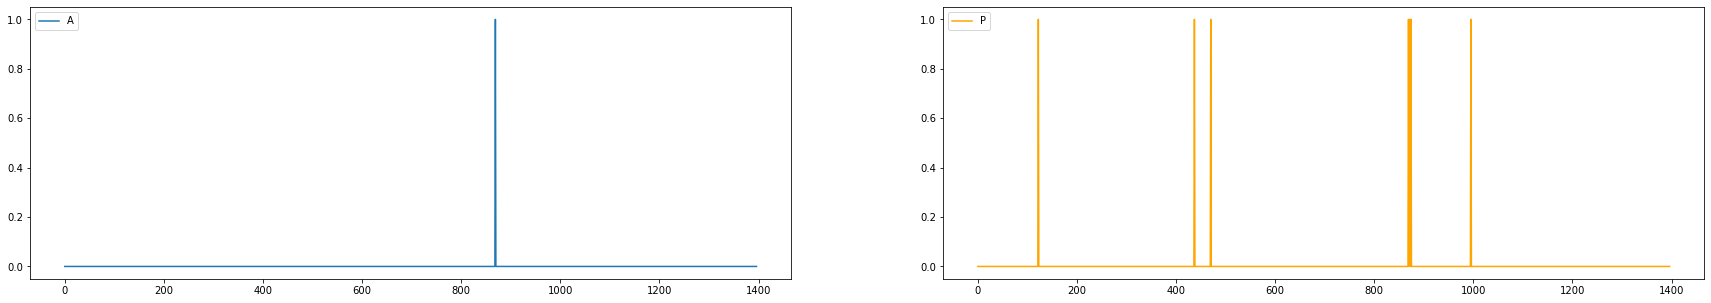

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_67.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_67.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.08889462e-05], Max [0.73515942]
Deviation 99.5th pctile [0.10993031]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 305928 ms


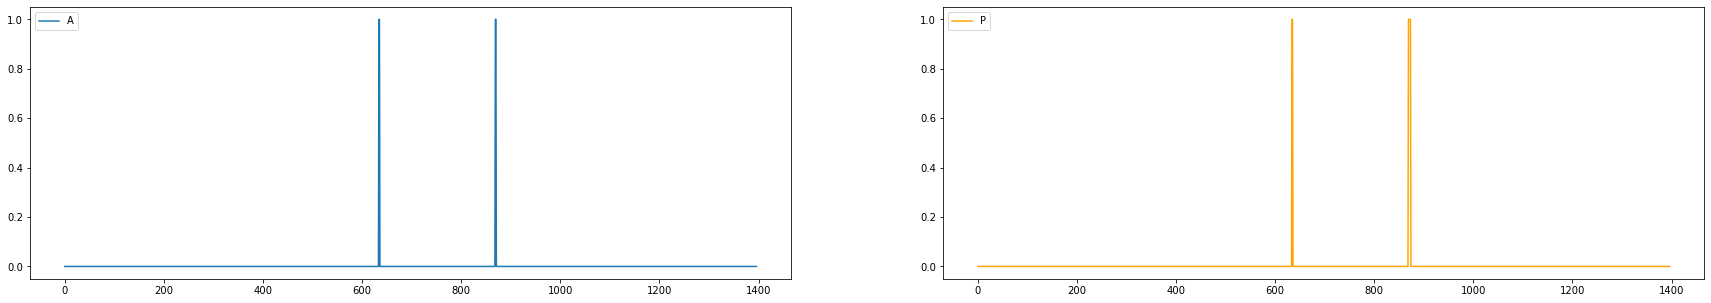

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_68.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_68.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.49239274e-05], Max [0.32966161]
Deviation 99.5th pctile [0.22900528]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 308170 ms


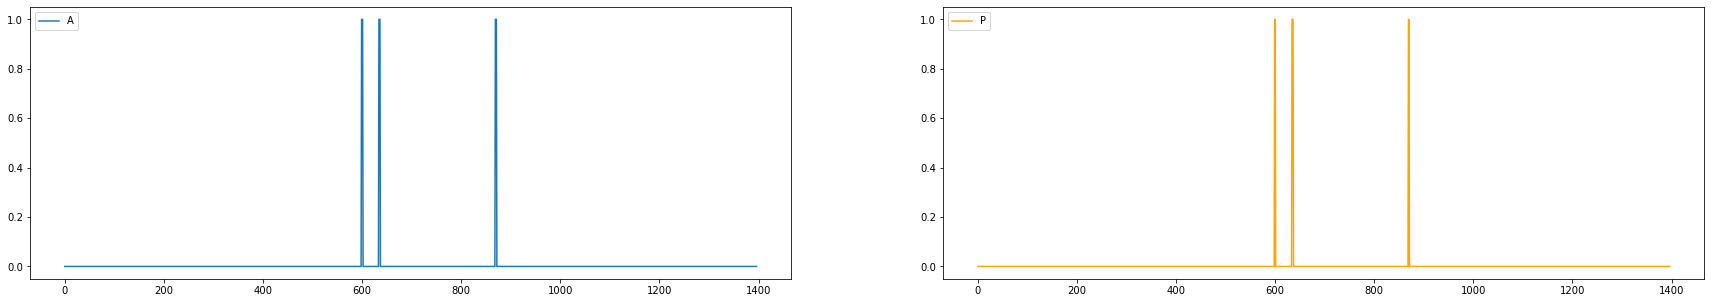

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_69.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_69.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.26804456e-06], Max [0.69100046]
Deviation 99.5th pctile [0.0544939]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 310429 ms


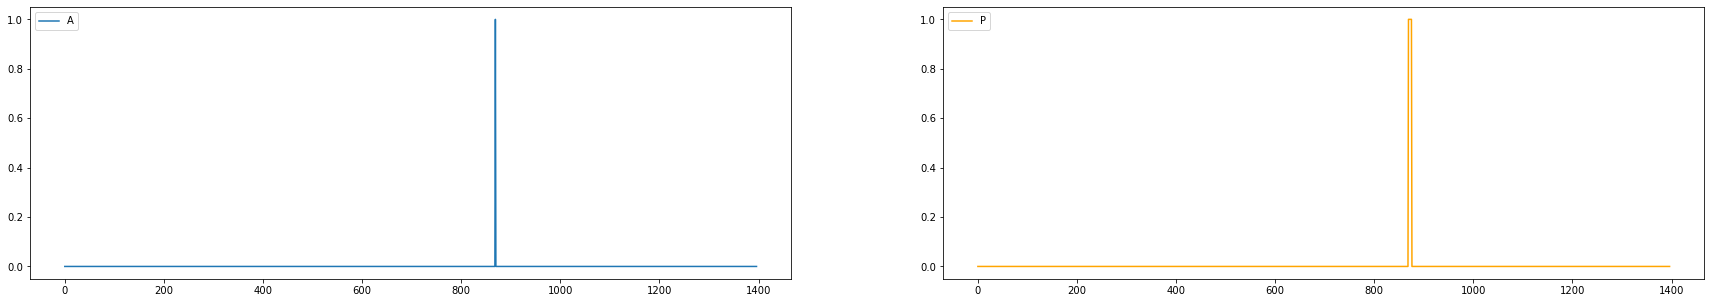

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_7.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_7.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.74971977e-05], Max [0.70476303]
Deviation 99.5th pctile [0.11576936]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 312244 ms


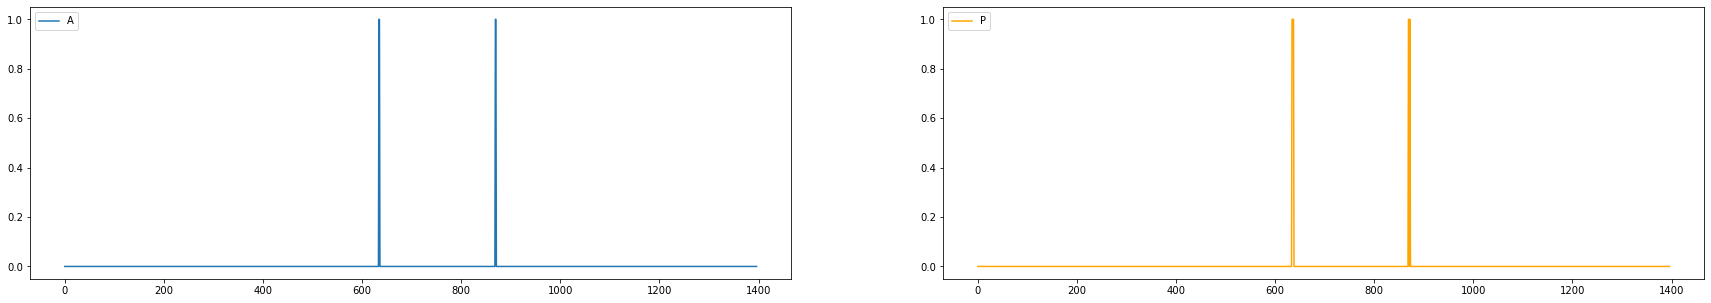

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_70.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_70.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [5.35251302e-05], Max [0.58358249]
Deviation 99.5th pctile [0.05834305]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 315456 ms


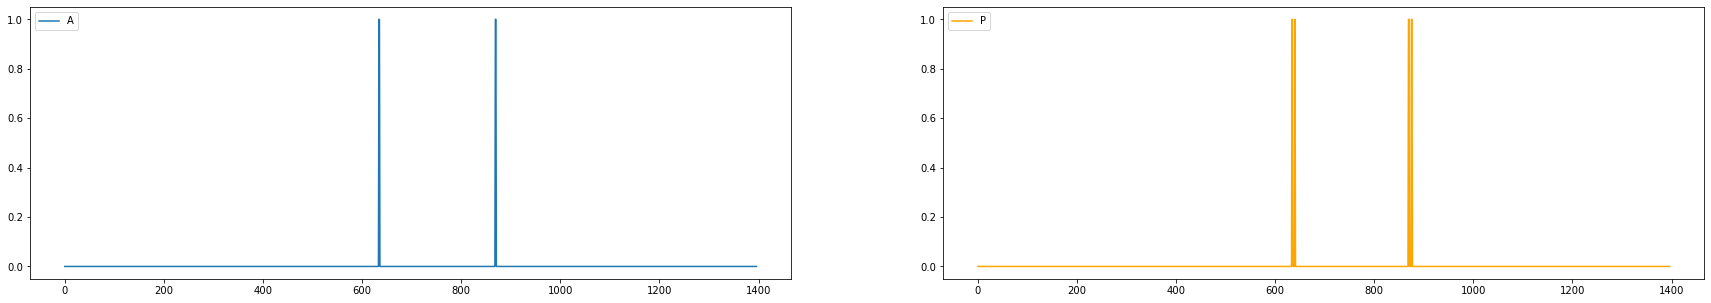

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_71.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_71.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.20631945e-05], Max [0.77555222]
Deviation 99.5th pctile [0.6226901]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 316984 ms


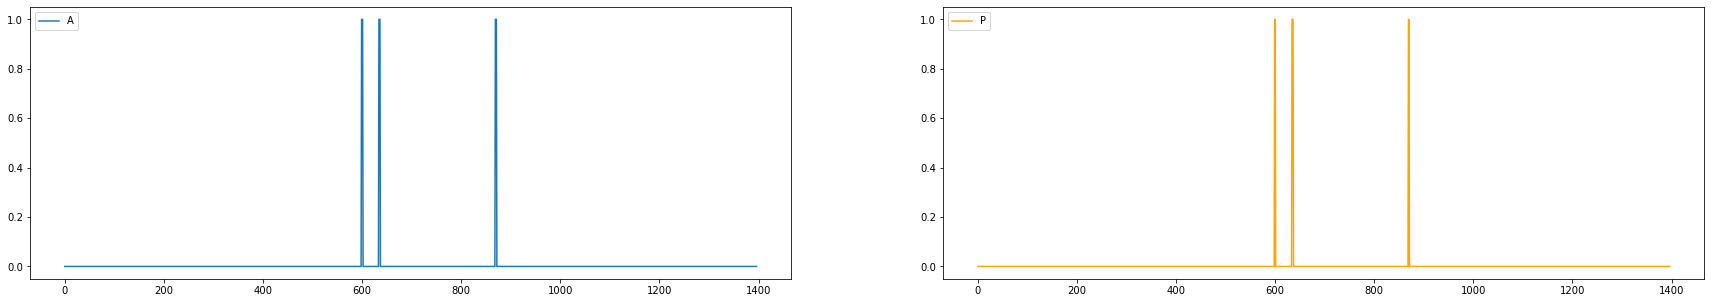

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_72.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_72.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.37665576e-06], Max [0.57666519]
Deviation 99.5th pctile [0.08557486]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 319511 ms


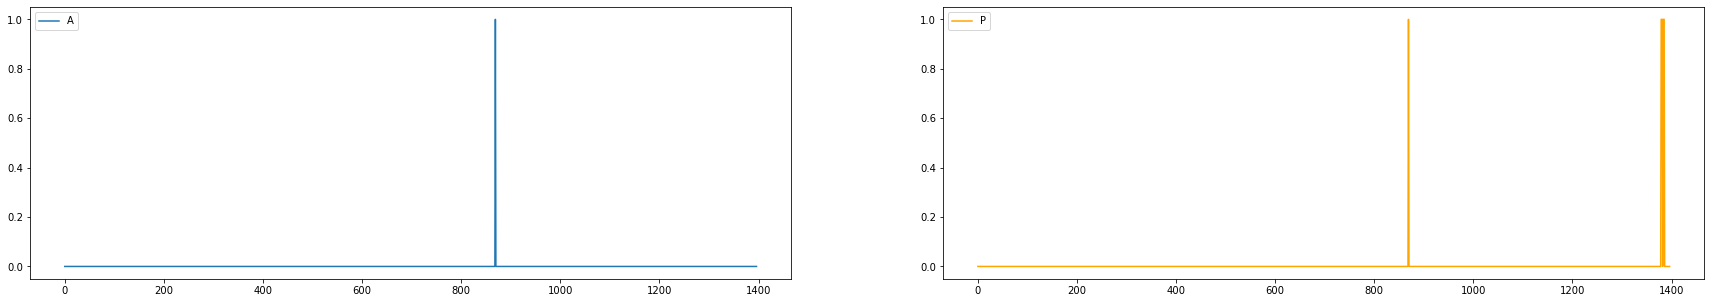

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_73.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_73.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.55673917e-05], Max [0.55024841]
Deviation 99.5th pctile [0.10256986]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 321246 ms


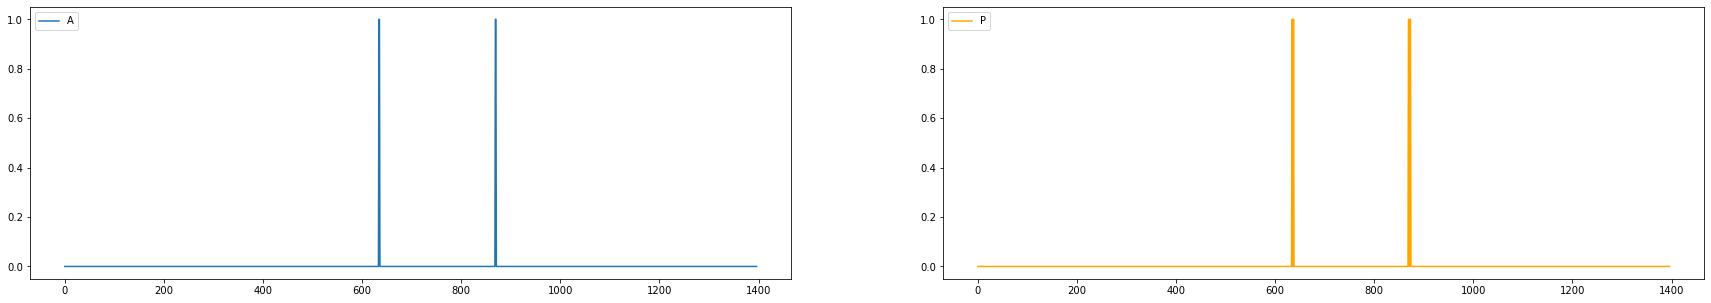

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_74.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_74.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.41388345e-06], Max [0.58757698]
Deviation 99.5th pctile [0.46017205]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 324479 ms


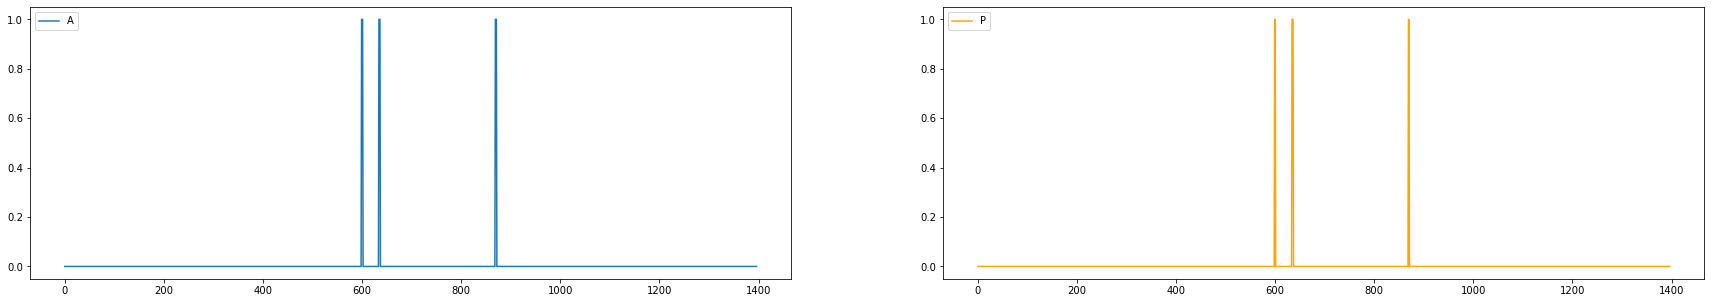

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_75.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_75.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [7.04531411e-05], Max [0.61888951]
Deviation 99.5th pctile [0.11528673]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 330650 ms


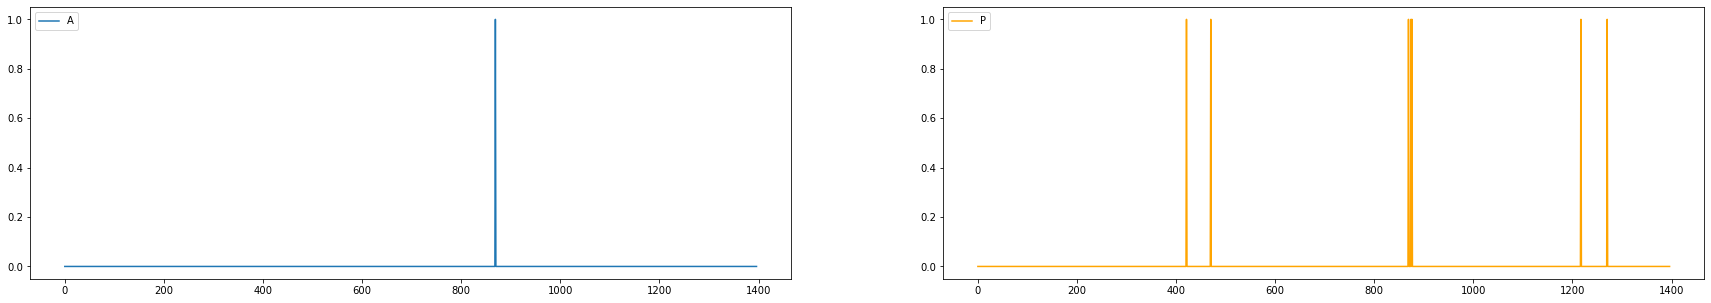

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_76.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_76.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [6.82133311e-06], Max [0.56162852]
Deviation 99.5th pctile [0.09697409]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 333969 ms


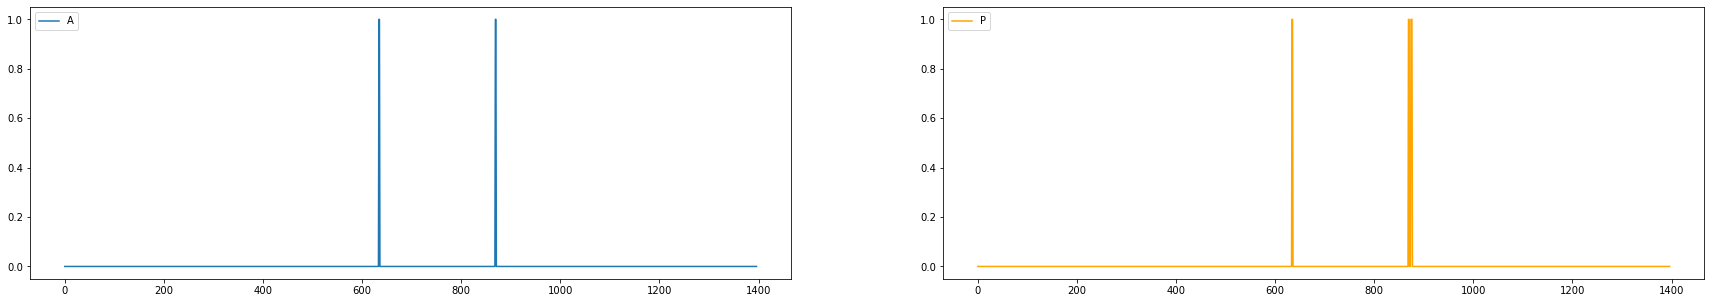

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_77.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_77.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.30372263e-05], Max [0.74705272]
Deviation 99.5th pctile [0.61115048]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 336084 ms


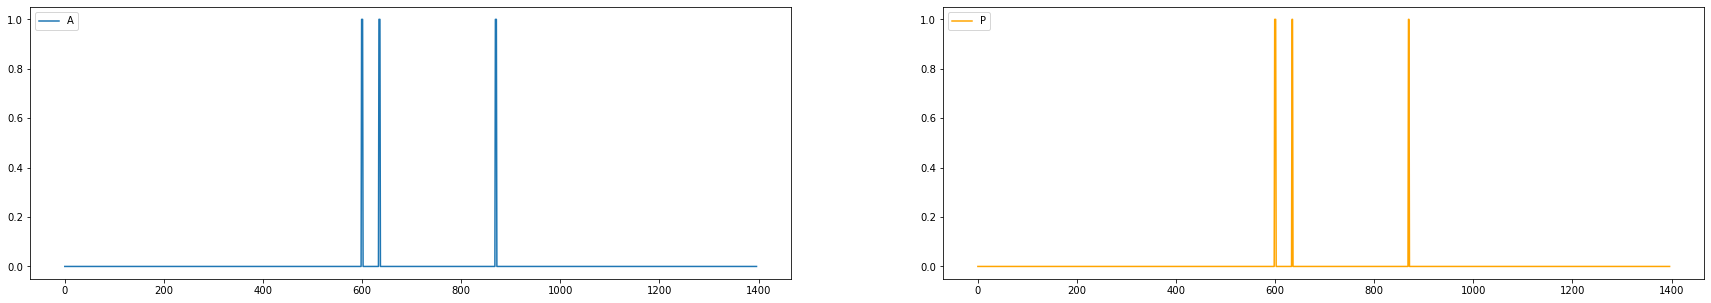

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_78.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_78.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00012587], Max [0.33463313]
Deviation 99.5th pctile [0.14361154]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 339572 ms


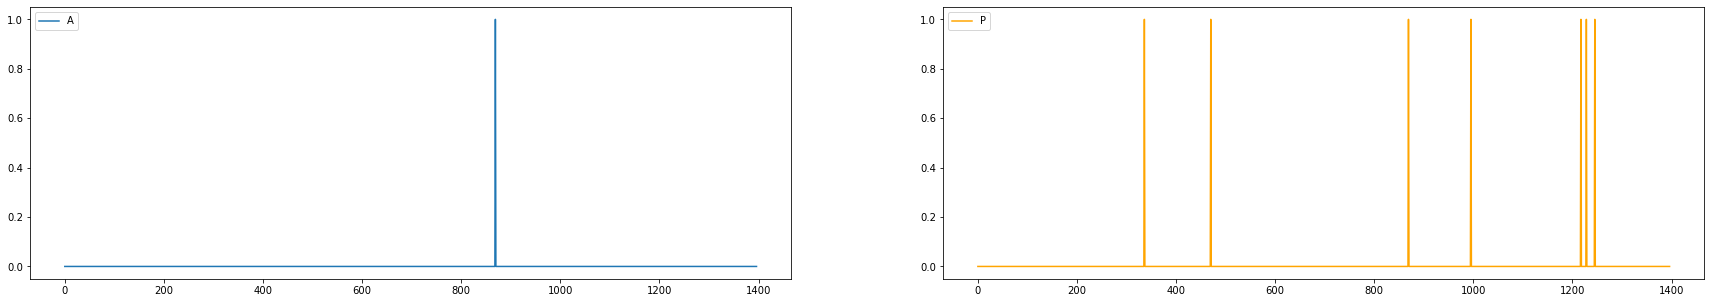

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_79.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_79.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.6383615e-06], Max [0.75760129]
Deviation 99.5th pctile [0.09846464]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 342536 ms


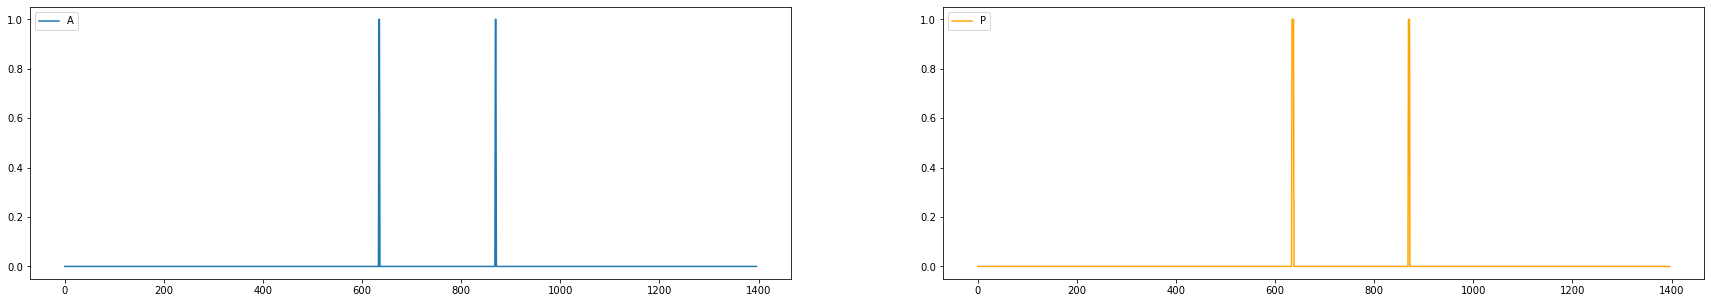

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_8.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_8.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.46016178e-05], Max [0.34404271]
Deviation 99.5th pctile [0.2380673]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 344477 ms


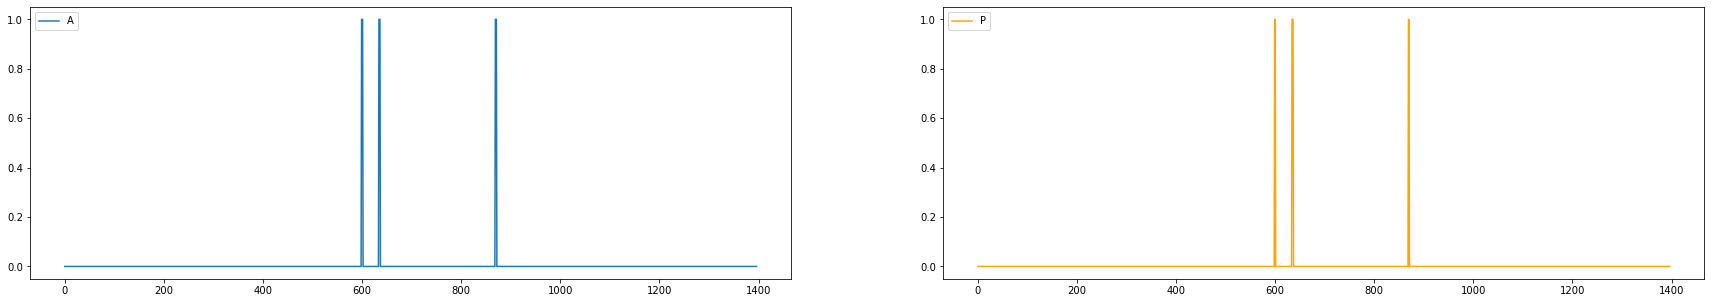

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_80.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_80.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.55950358e-05], Max [0.43523865]
Deviation 99.5th pctile [0.30696518]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 346480 ms


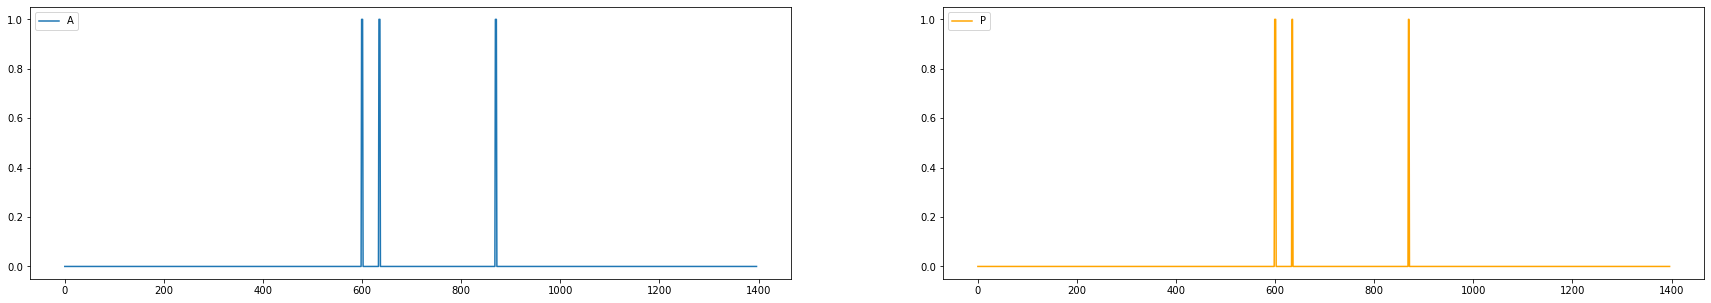

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_81.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_81.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.02883374e-05], Max [0.72328764]
Deviation 99.5th pctile [0.03701835]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 349778 ms


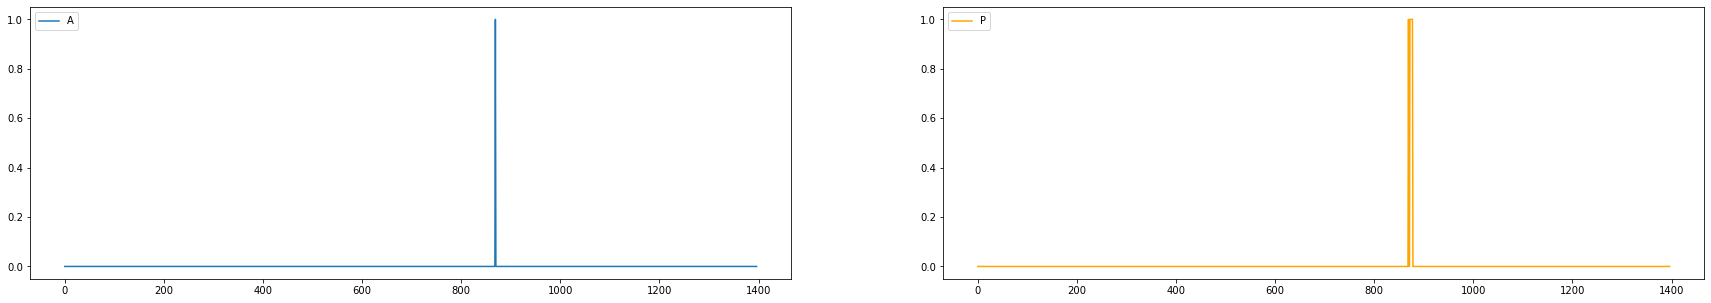

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_82.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_82.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [7.57311783e-06], Max [0.51764908]
Deviation 99.5th pctile [0.15885413]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 353048 ms


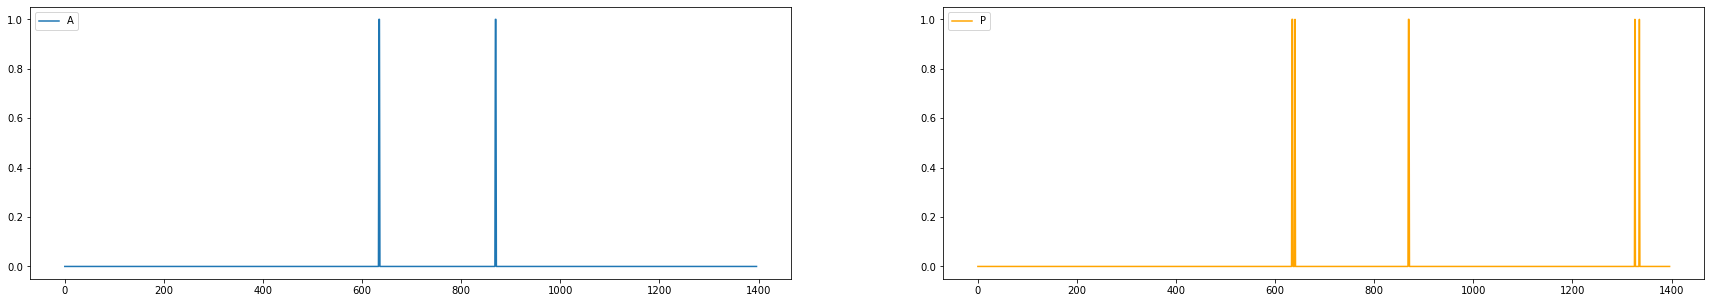

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_83.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_83.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.13233628e-06], Max [0.72752517]
Deviation 99.5th pctile [0.65600485]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 356680 ms


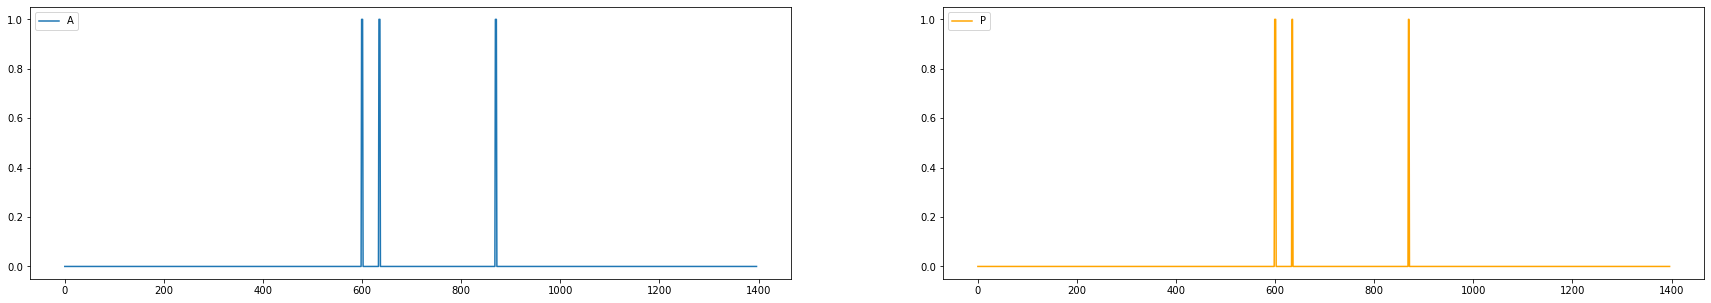

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_84.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_84.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.86864626e-06], Max [0.56879771]
Deviation 99.5th pctile [0.06142634]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 361304 ms


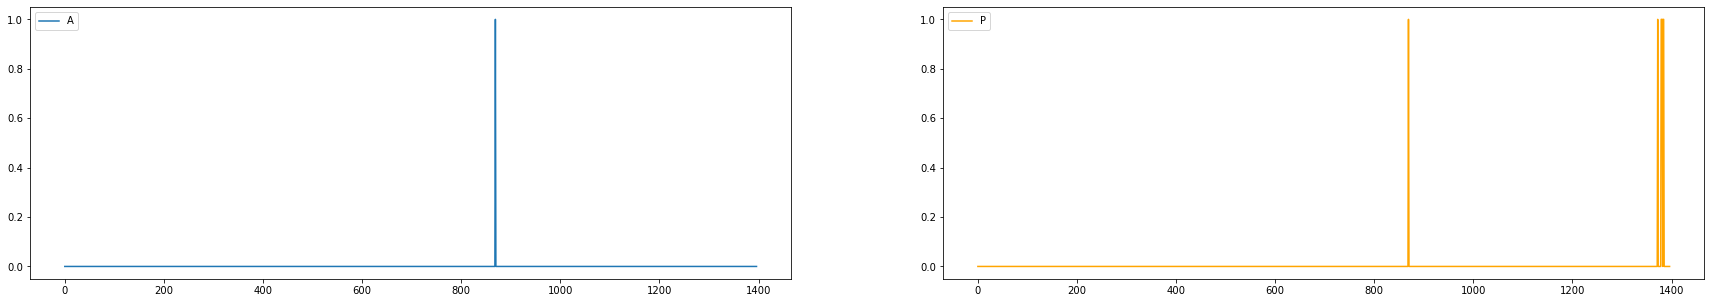

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_85.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_85.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [9.66852198e-06], Max [0.77402374]
Deviation 99.5th pctile [0.12239785]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 364175 ms


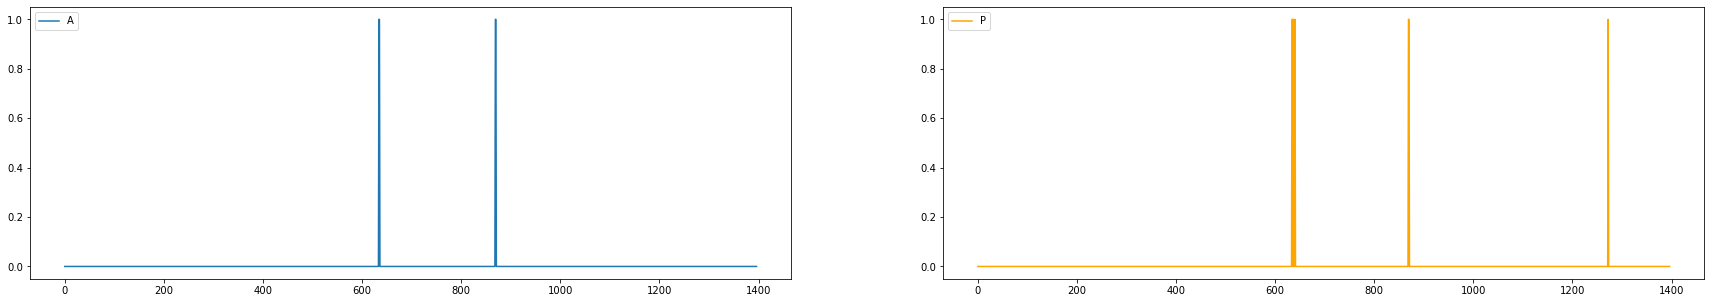

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_86.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_86.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.74947584e-06], Max [0.59290512]
Deviation 99.5th pctile [0.45500856]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 365848 ms


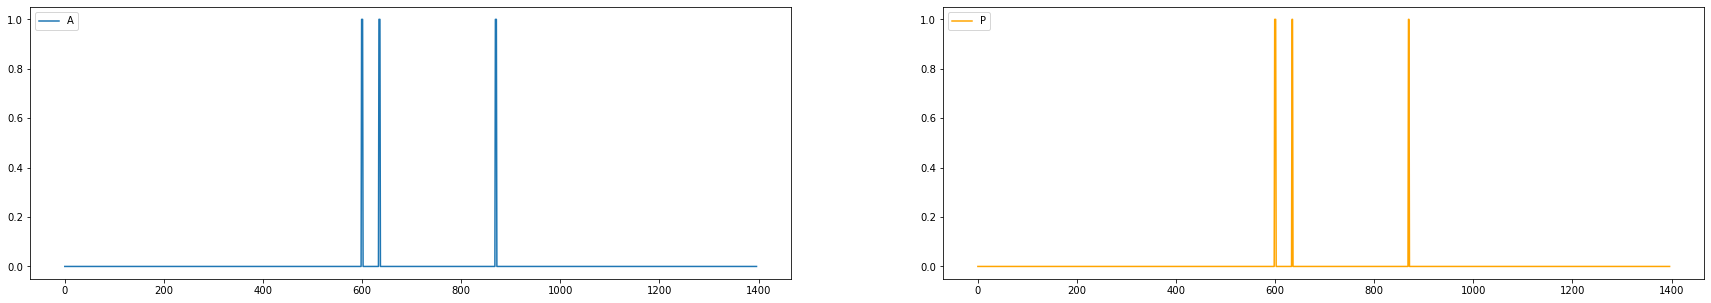

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_87.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_87.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.01221951e-06], Max [0.70356447]
Deviation 99.5th pctile [0.15333926]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 368303 ms


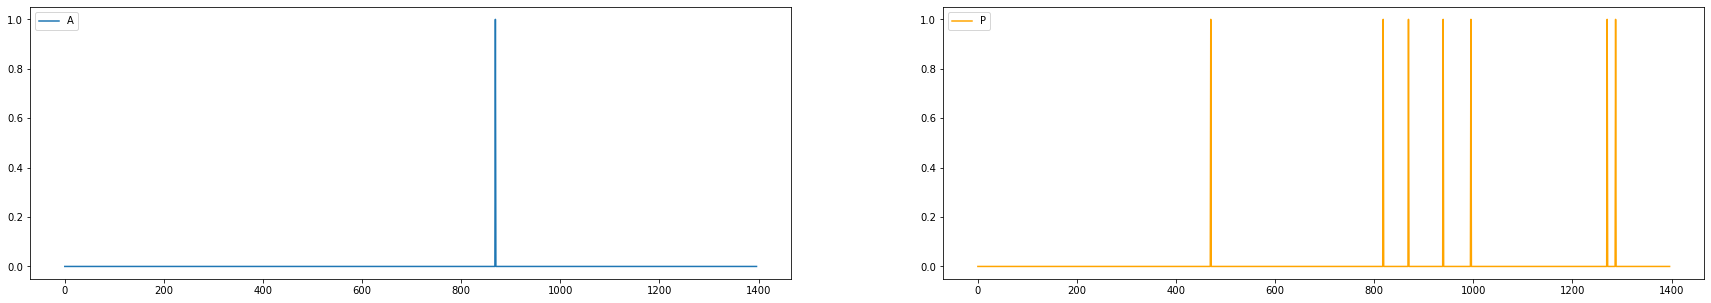

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_88.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_88.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.820712e-05], Max [0.58986079]
Deviation 99.5th pctile [0.09913817]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 370400 ms


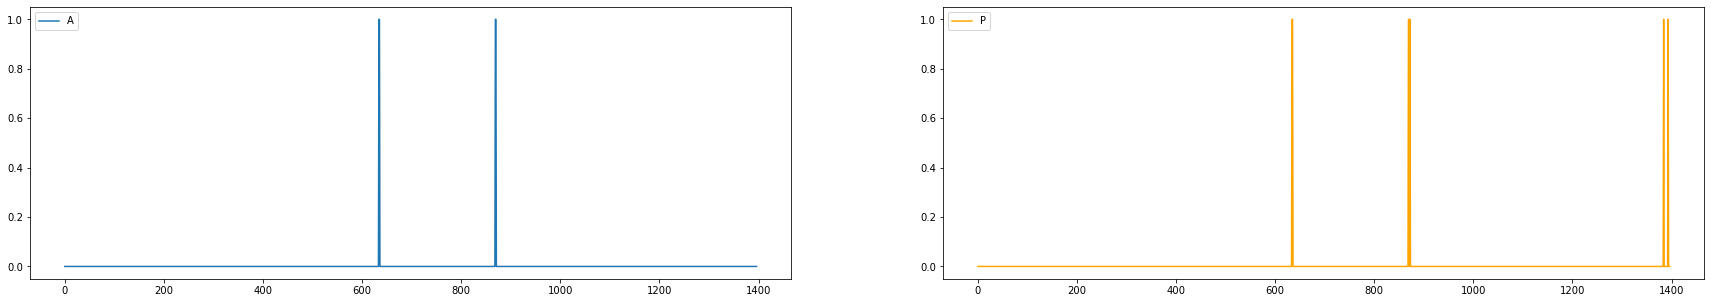

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_89.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_89.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.28165814e-05], Max [0.65918306]
Deviation 99.5th pctile [0.49003281]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 372471 ms


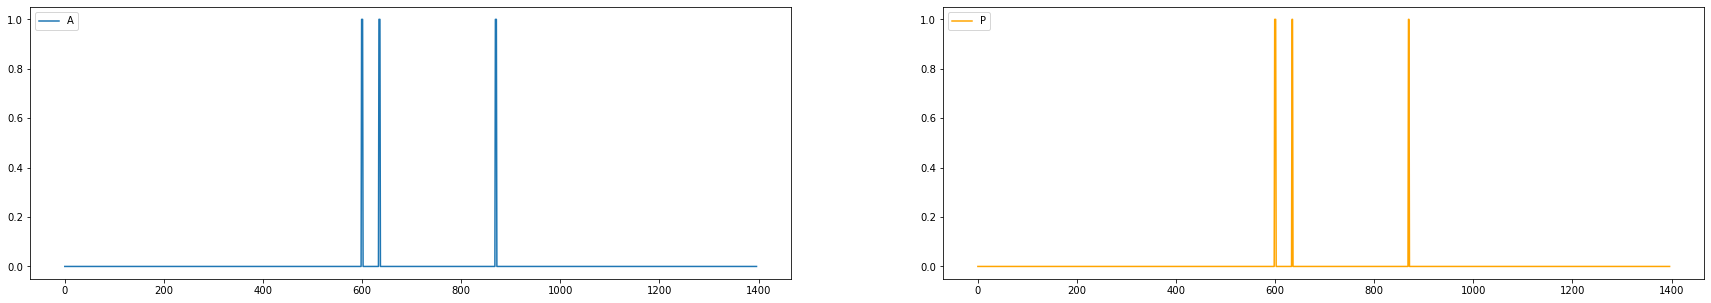

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_9.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_9.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.25836436e-05], Max [0.74406451]
Deviation 99.5th pctile [0.06266094]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 374005 ms


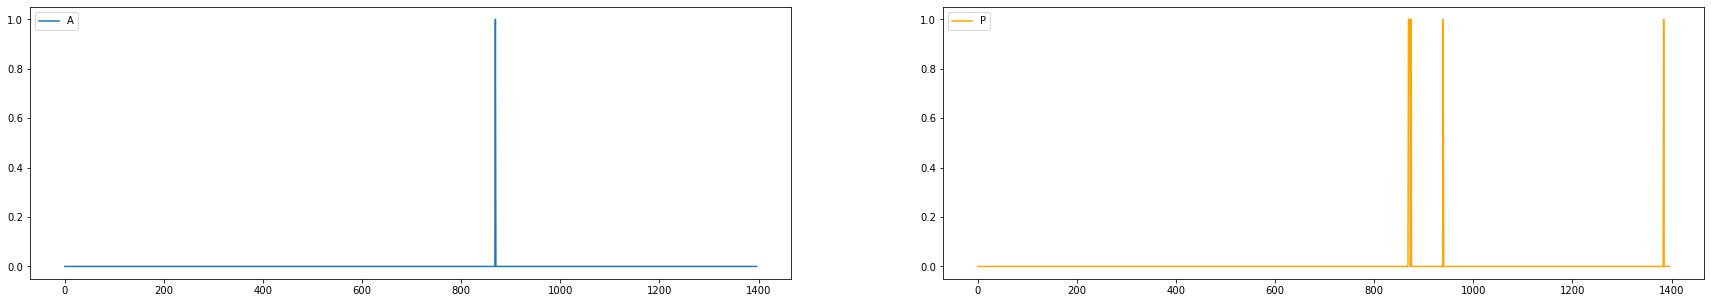

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_90.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_90.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.53841768e-05], Max [0.53093159]
Deviation 99.5th pctile [0.05975607]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 375858 ms


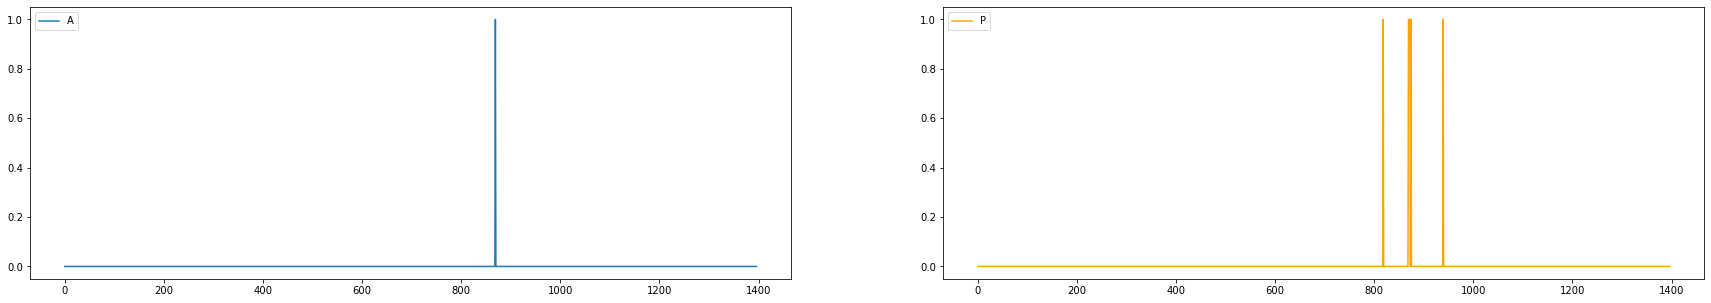

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_91.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_91.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [3.90620143e-05], Max [0.74770916]
Deviation 99.5th pctile [0.06715991]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 378960 ms


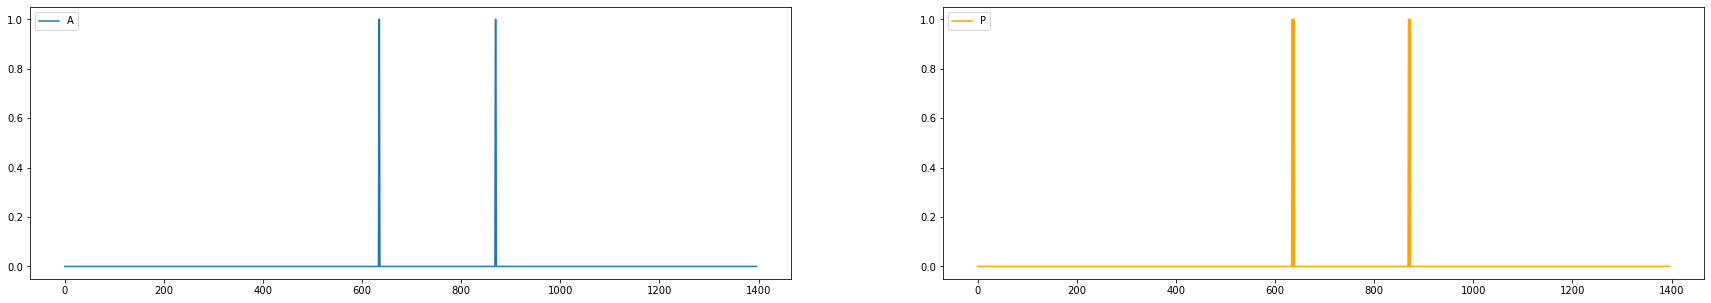

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_92.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_92.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [6.49431703e-05], Max [0.60169407]
Deviation 99.5th pctile [0.49393453]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 382228 ms


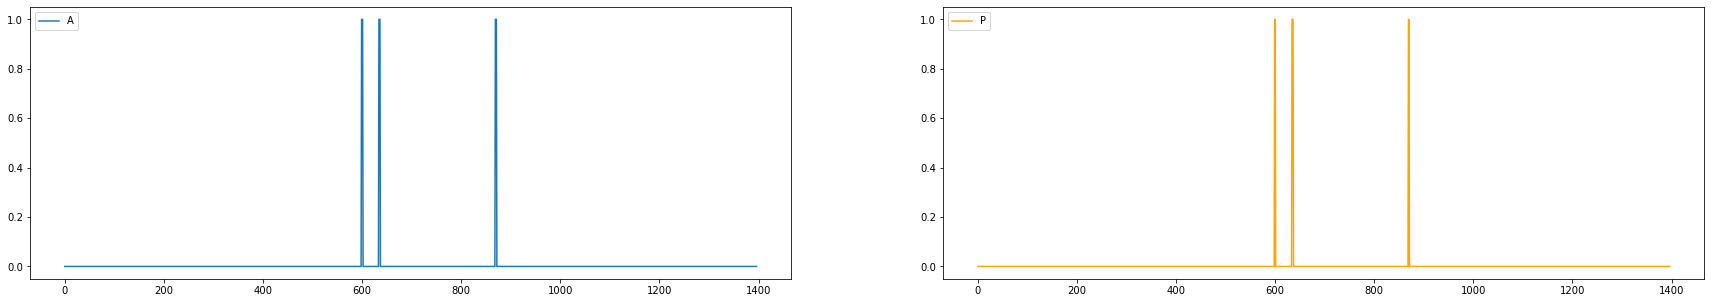

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_93.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_93.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [2.13863809e-06], Max [0.72013062]
Deviation 99.5th pctile [0.07434837]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 383842 ms


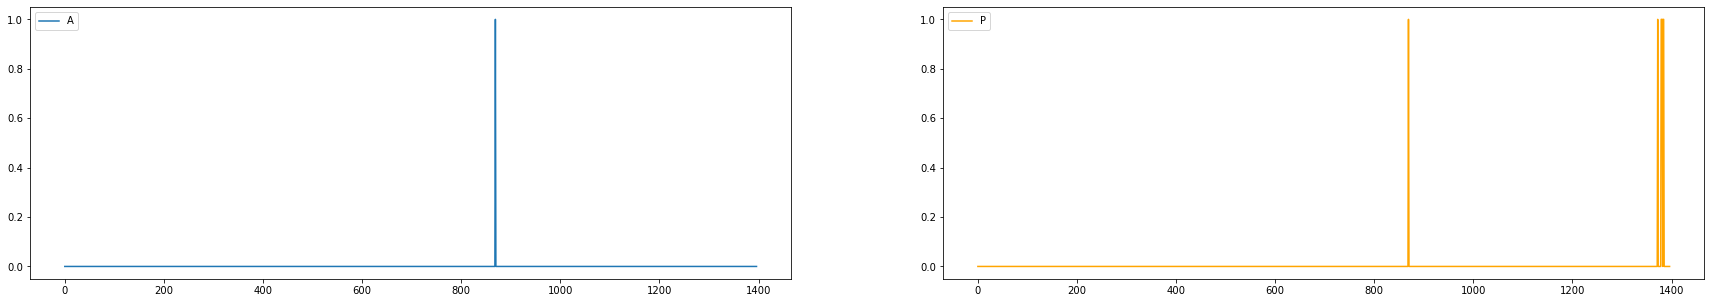

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_94.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_94.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00015207], Max [0.52732754]
Deviation 99.5th pctile [0.11526836]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 385625 ms


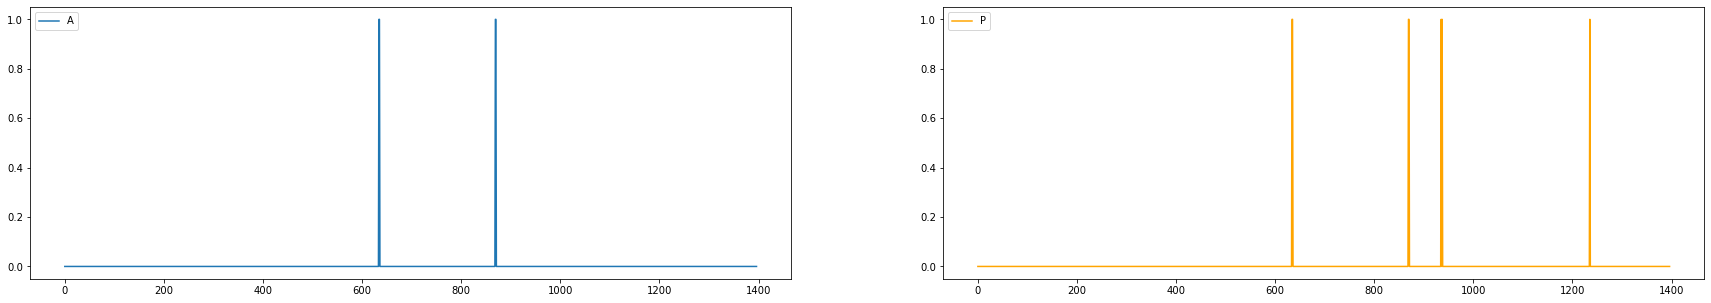

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_95.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_95.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [4.57341971e-06], Max [0.74839638]
Deviation 99.5th pctile [0.59406049]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 388807 ms


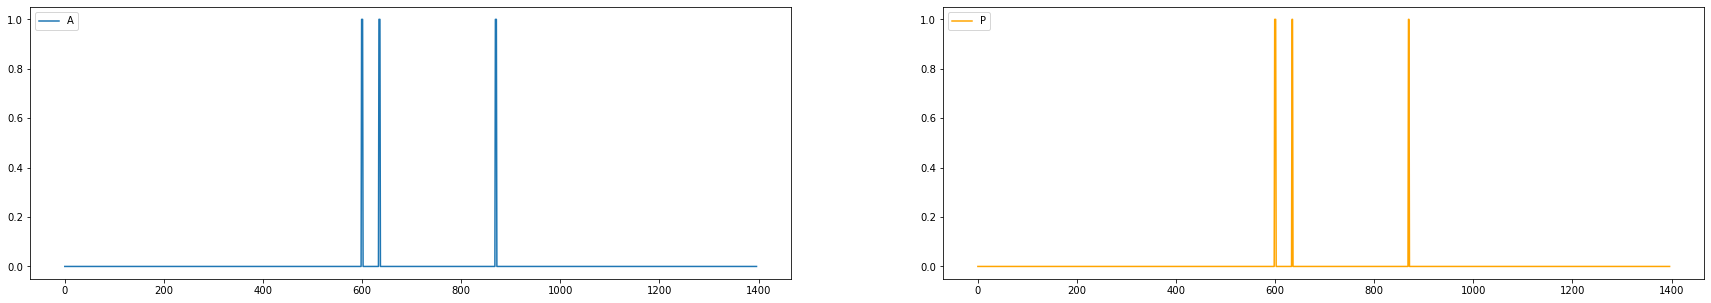

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_96.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_96.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [0.00012464], Max [0.40498668]
Deviation 99.5th pctile [0.17041909]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 393101 ms


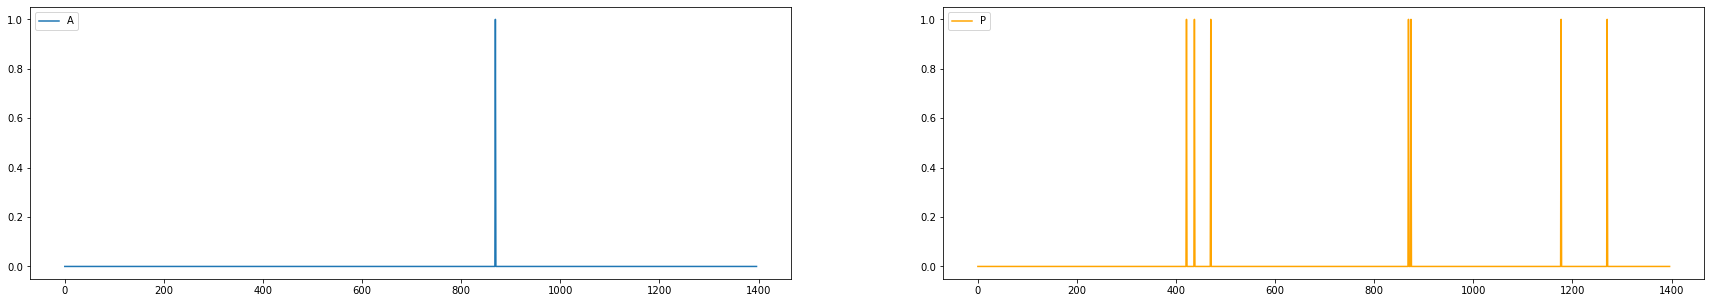

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_97.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_97.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.37828363e-05], Max [0.72057696]
Deviation 99.5th pctile [0.1263197]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to predict and get records above deviation : 396401 ms


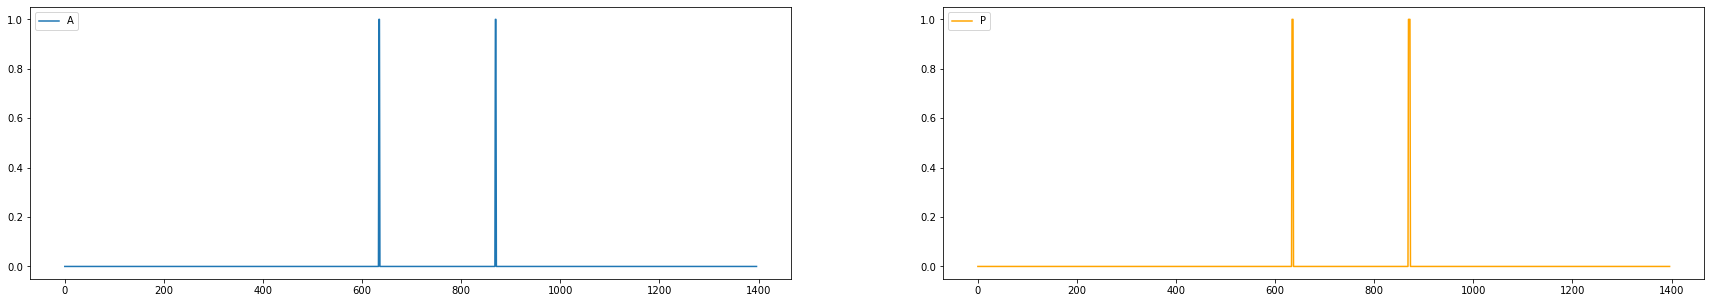

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_98.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_98.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [7.58576659e-05], Max [0.59848286]
Deviation 99.5th pctile [0.47673537]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to predict and get records above deviation : 399111 ms


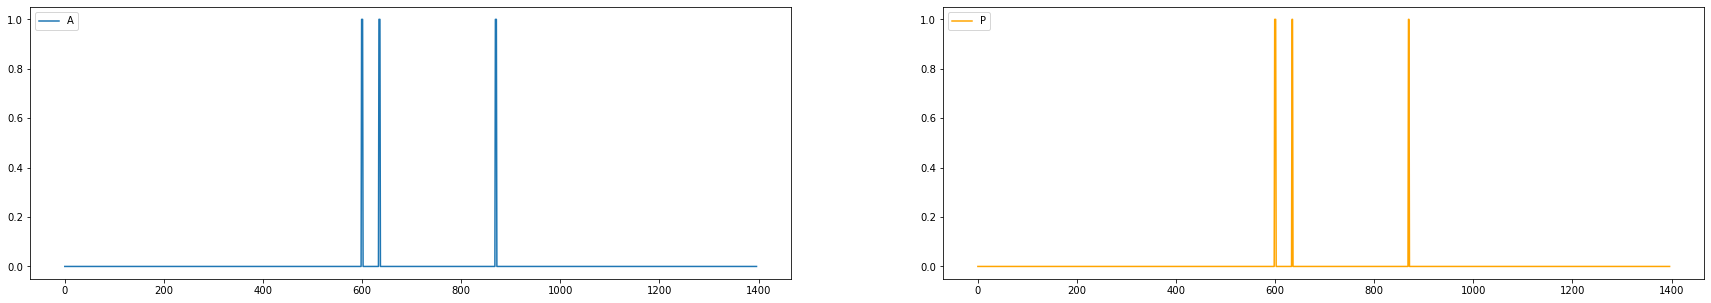

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_99.csv
Model file will be loaded from  models-yahoo-lstm/A2Benchmark/synthetic_99.csv.h5
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back data shapes: lookbackX (1397, 24, 1) lookbackY (1397, 2)
Deviation Min [1.93777911e-06], Max [0.71755418]
Deviation 99.5th pctile [0.14802463]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1396,    1]))
Confusion matrix 
[[1390    6]
 [   0    1]]
precision 0.14286, recall 1.00000, f1 0.25000
Time to predict and get records above deviation : 401786 ms


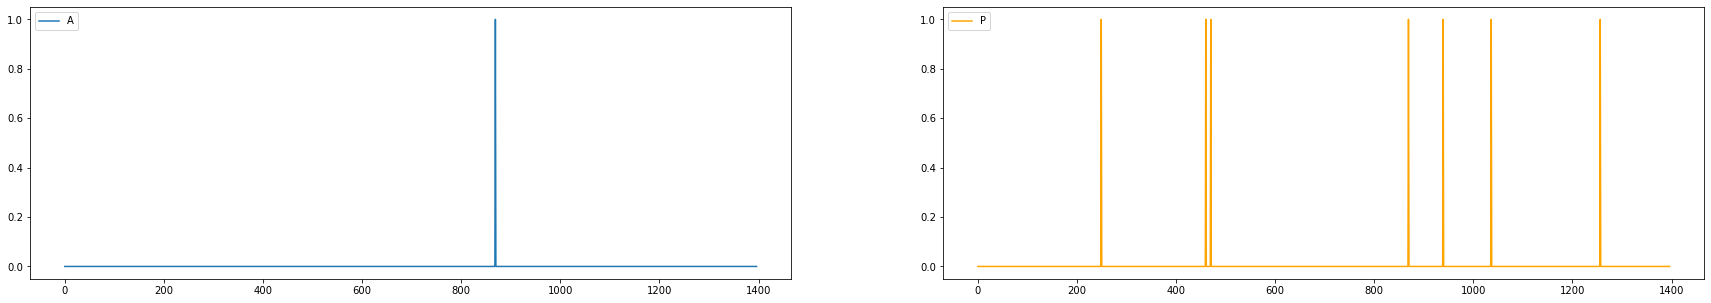

Processing 100 files in folder A3Benchmark
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS1.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS1.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.0001309], Max [0.41756272]
Deviation 99.5th pctile [0.24576295]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1644    1]
 [   3    8]]
precision 0.88889, recall 0.72727, f1 0.80000
Time to predict and get records above deviation : 405923 ms


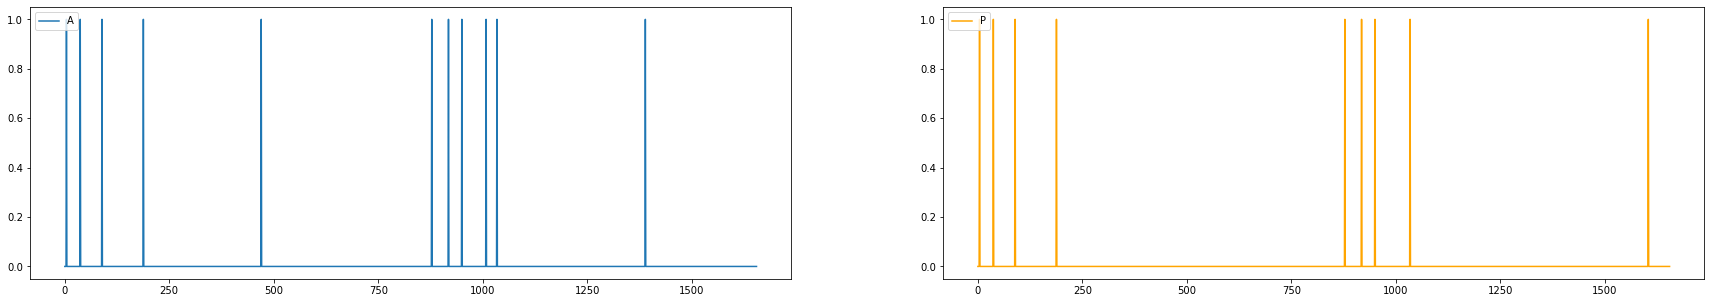

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS10.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS10.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.17644723e-06], Max [0.23276073]
Deviation 99.5th pctile [0.14101107]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1639    7]
 [   8    2]]
precision 0.22222, recall 0.20000, f1 0.21053
Time to predict and get records above deviation : 408833 ms


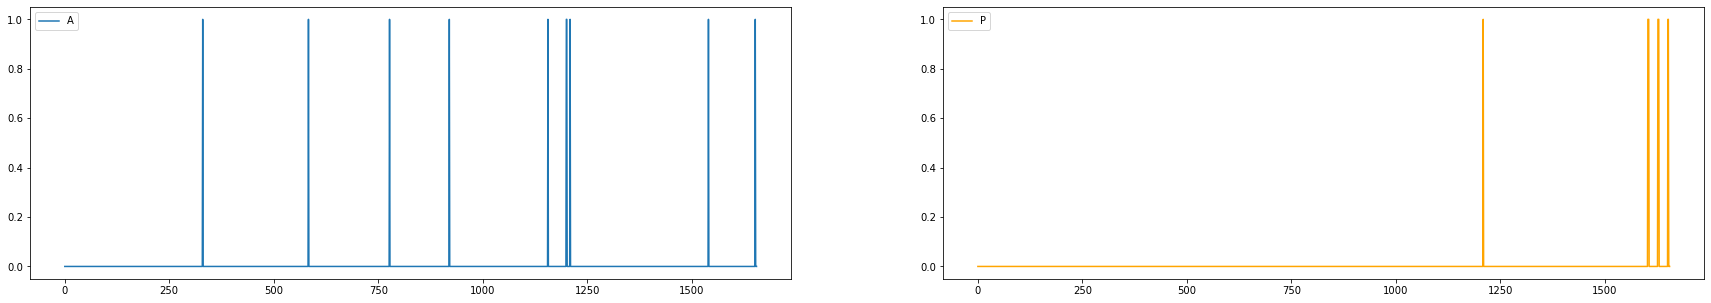

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS100.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS100.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.12734833e-05], Max [0.52529556]
Deviation 99.5th pctile [0.37279733]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1646    0]
 [   1    9]]
precision 1.00000, recall 0.90000, f1 0.94737
Time to predict and get records above deviation : 415440 ms


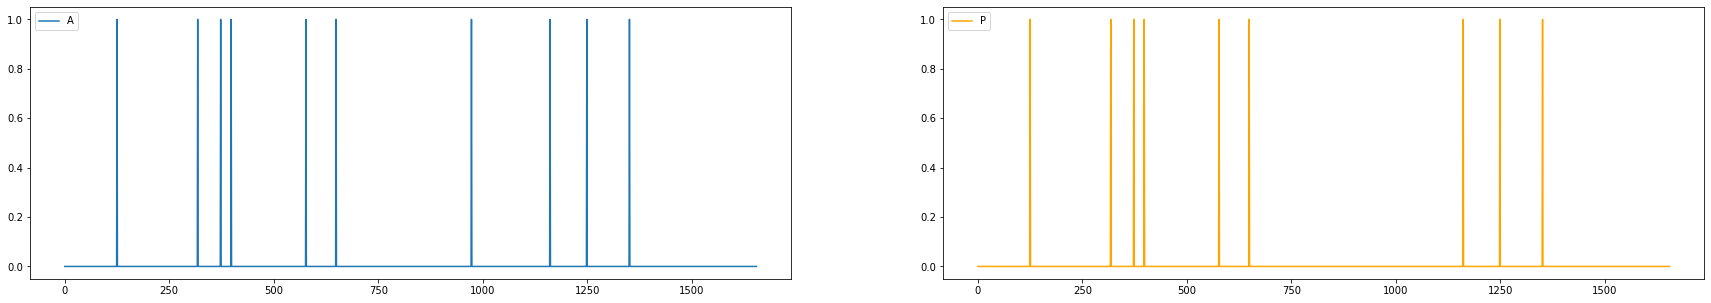

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS11.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS11.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.94601797e-05], Max [0.35344273]
Deviation 99.5th pctile [0.23225157]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1645    4]
 [   2    5]]
precision 0.55556, recall 0.71429, f1 0.62500
Time to predict and get records above deviation : 418189 ms


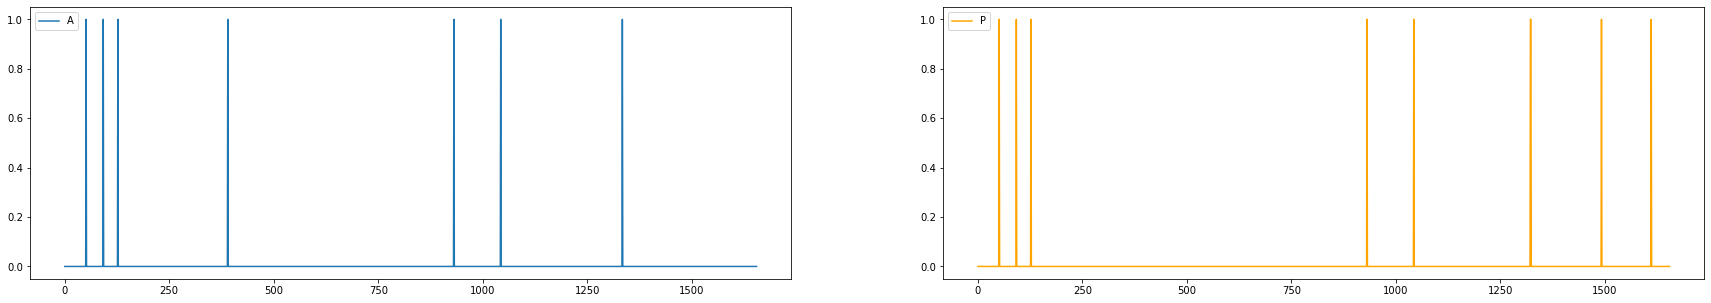

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS12.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS12.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.42519005e-05], Max [0.47994145]
Deviation 99.5th pctile [0.33599255]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 421009 ms


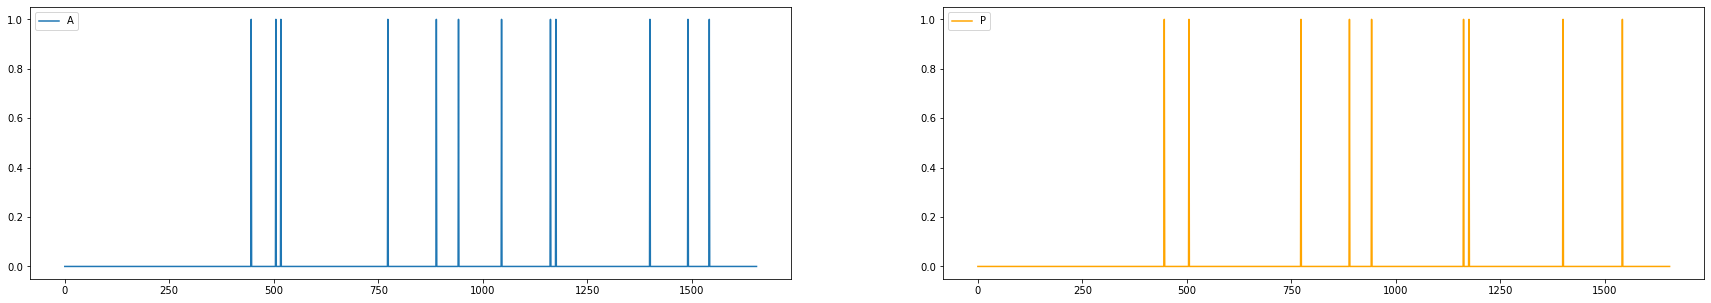

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS13.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS13.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.06737007e-05], Max [0.43379193]
Deviation 99.5th pctile [0.18877587]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 426547 ms


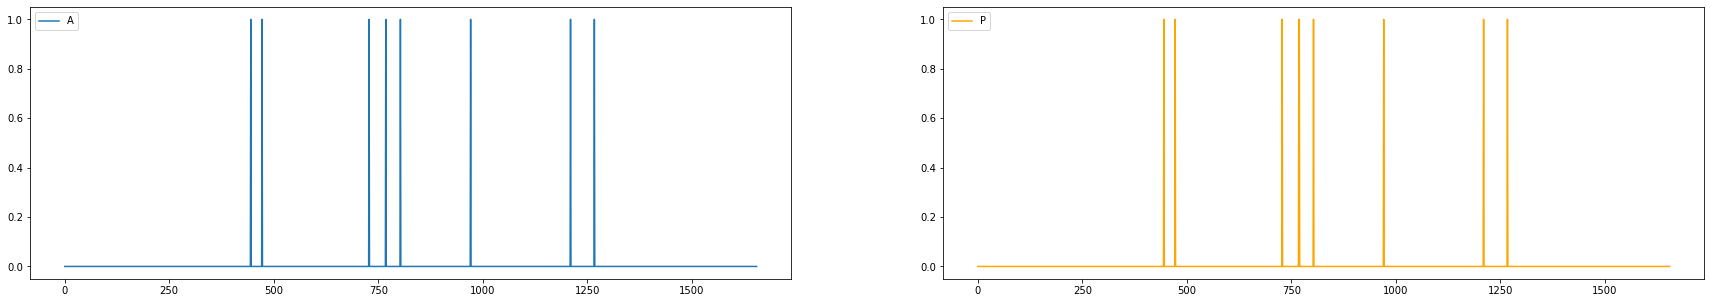

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS14.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS14.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.7036589e-05], Max [0.16002584]
Deviation 99.5th pctile [0.14829002]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1633    8]
 [  14    1]]
precision 0.11111, recall 0.06667, f1 0.08333
Time to predict and get records above deviation : 431077 ms


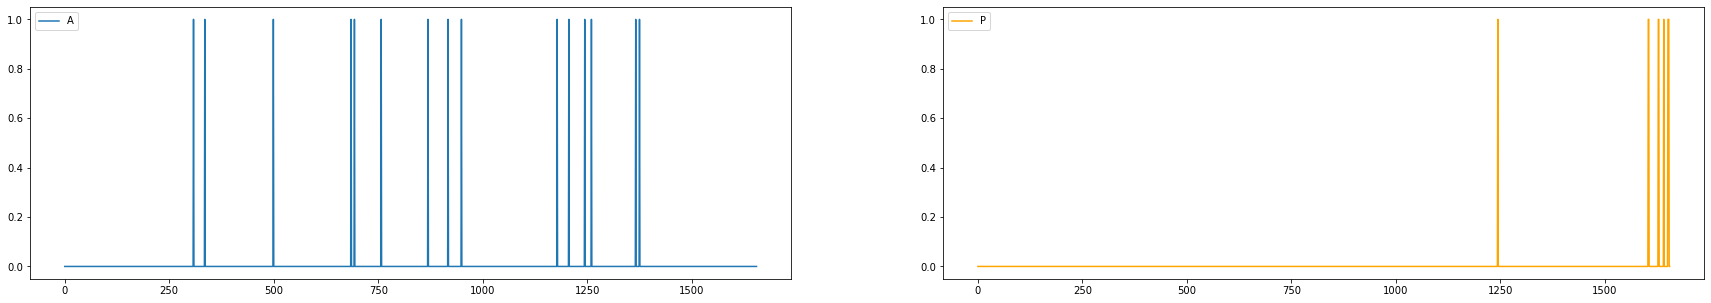

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS15.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS15.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.34135131e-05], Max [0.30605834]
Deviation 99.5th pctile [0.19373115]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1644    6]
 [   3    3]]
precision 0.33333, recall 0.50000, f1 0.40000
Time to predict and get records above deviation : 434752 ms


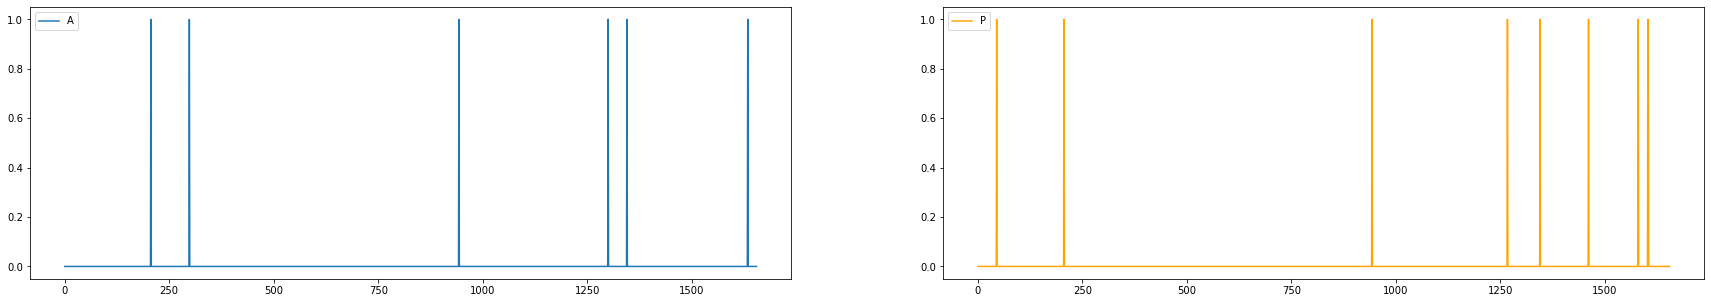

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS16.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS16.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.31816419e-05], Max [0.28540563]
Deviation 99.5th pctile [0.1436068]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1644    4]
 [   3    5]]
precision 0.55556, recall 0.62500, f1 0.58824
Time to predict and get records above deviation : 439357 ms


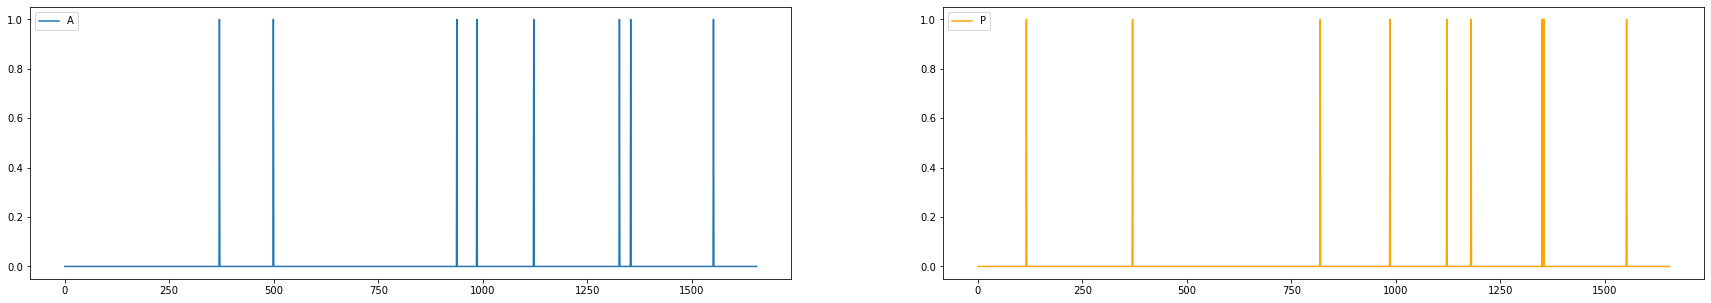

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS17.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS17.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.2765407e-05], Max [0.27438093]
Deviation 99.5th pctile [0.10410061]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 442702 ms


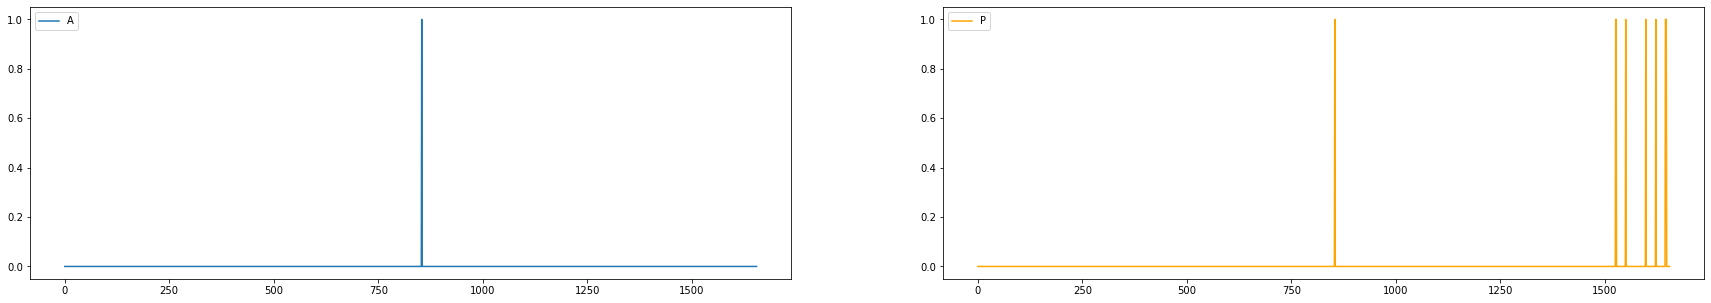

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS18.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS18.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00012983], Max [0.29495221]
Deviation 99.5th pctile [0.21344862]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1639    5]
 [   8    4]]
precision 0.44444, recall 0.33333, f1 0.38095
Time to predict and get records above deviation : 444863 ms


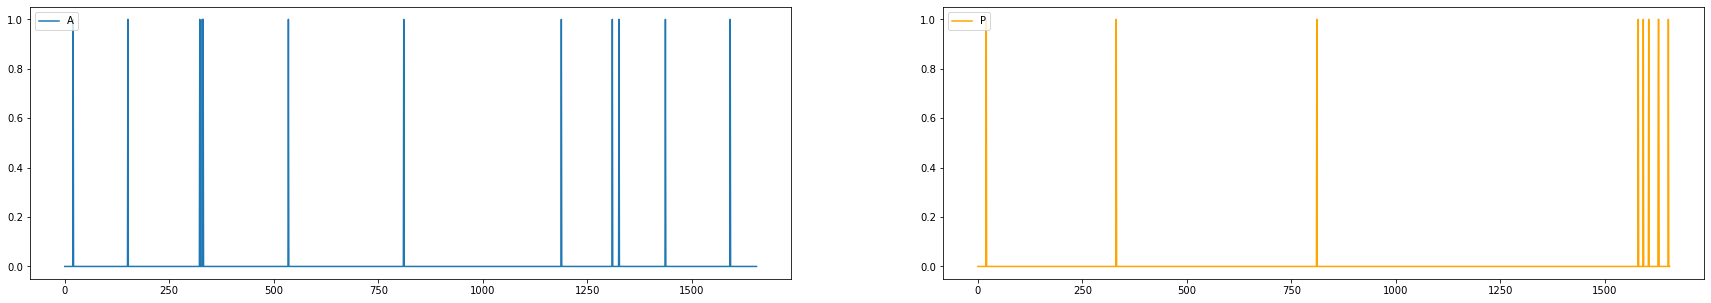

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS19.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS19.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.75119136e-05], Max [0.31659919]
Deviation 99.5th pctile [0.19826603]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1646    0]
 [   1    9]]
precision 1.00000, recall 0.90000, f1 0.94737
Time to predict and get records above deviation : 448169 ms


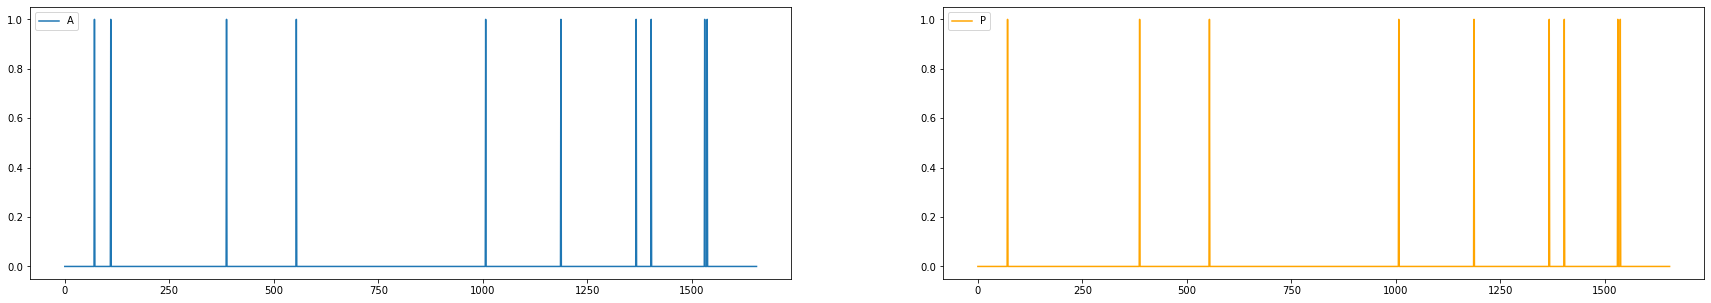

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS2.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS2.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.61390196e-05], Max [0.33428005]
Deviation 99.5th pctile [0.22424444]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 450375 ms


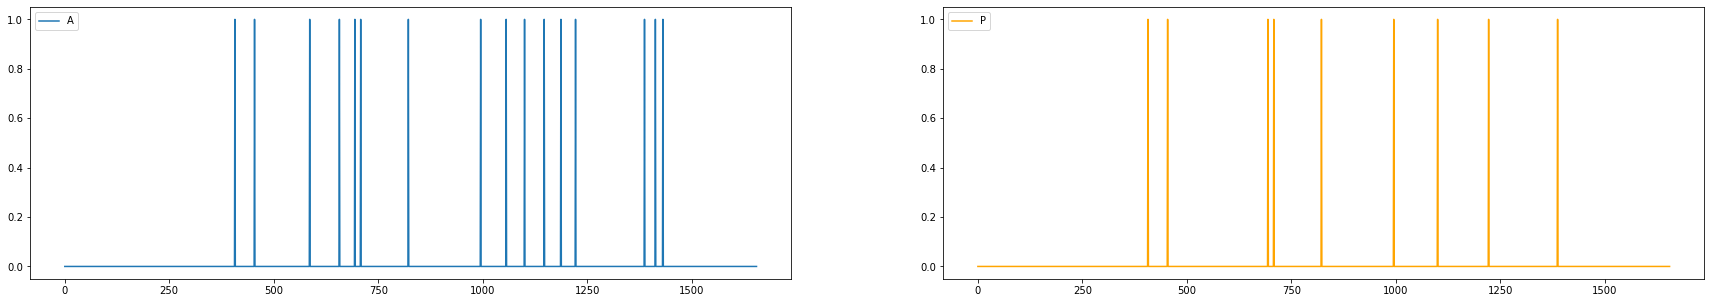

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS20.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS20.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00025918], Max [0.27047728]
Deviation 99.5th pctile [0.21404778]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1639    5]
 [   8    4]]
precision 0.44444, recall 0.33333, f1 0.38095
Time to predict and get records above deviation : 452978 ms


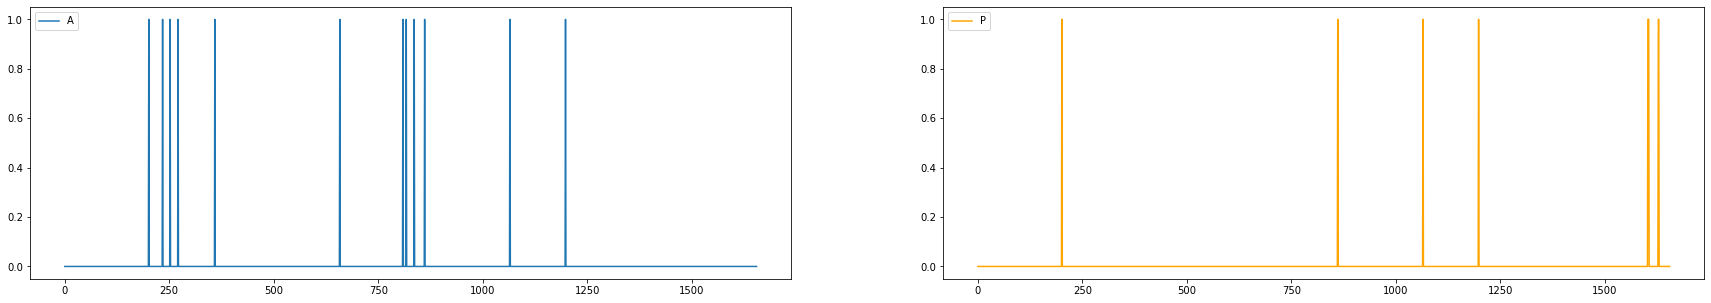

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS21.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS21.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.25210645e-05], Max [0.1384168]
Deviation 99.5th pctile [0.12538896]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1636    8]
 [  11    1]]
precision 0.11111, recall 0.08333, f1 0.09524
Time to predict and get records above deviation : 456554 ms


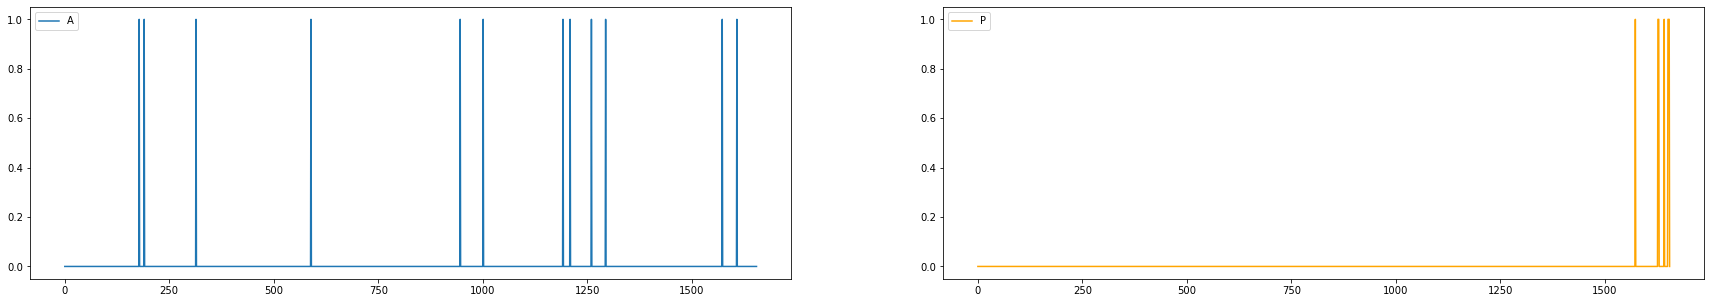

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS22.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS22.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.37898766e-05], Max [0.32195966]
Deviation 99.5th pctile [0.12847122]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 459753 ms


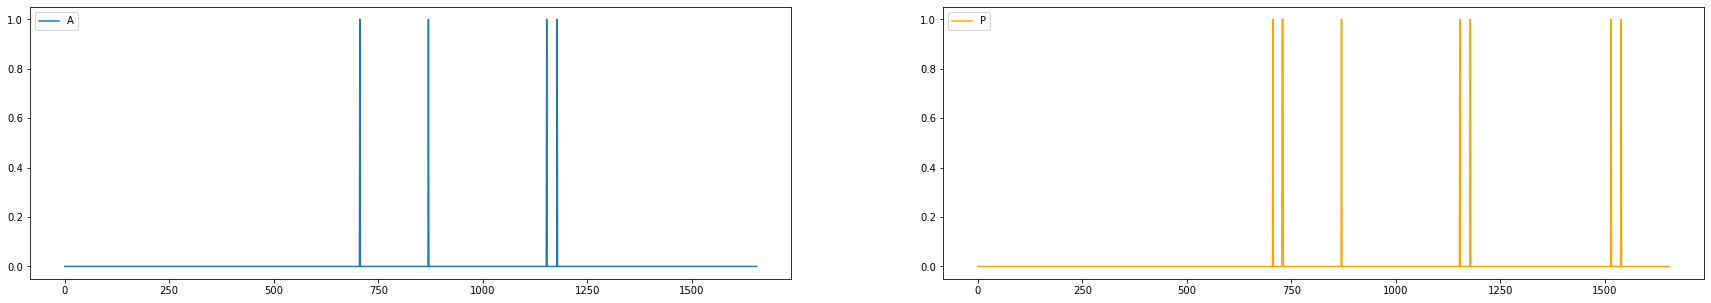

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS23.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS23.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.09031428e-05], Max [0.49887071]
Deviation 99.5th pctile [0.33443535]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1642    0]
 [   5    9]]
precision 1.00000, recall 0.64286, f1 0.78261
Time to predict and get records above deviation : 462845 ms


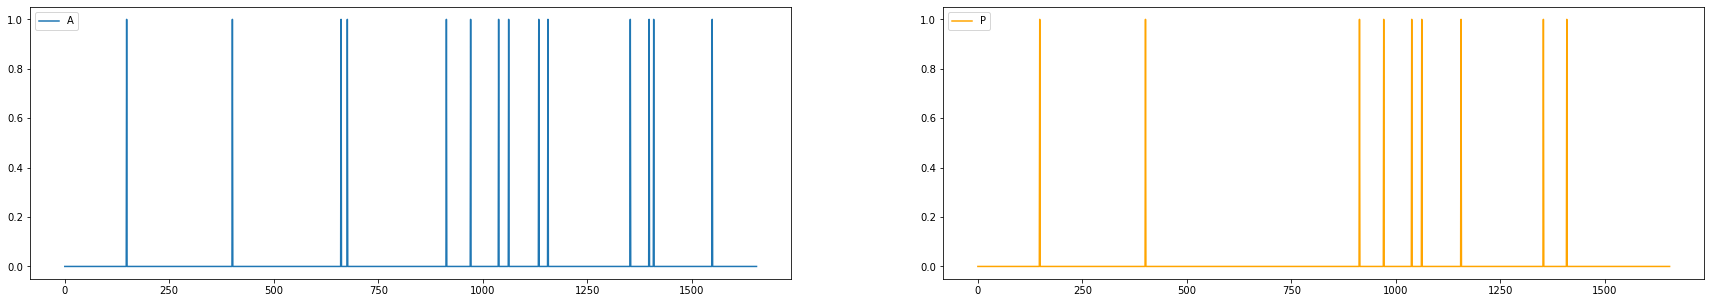

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS24.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS24.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.29165752e-06], Max [0.52316176]
Deviation 99.5th pctile [0.31641119]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 465296 ms


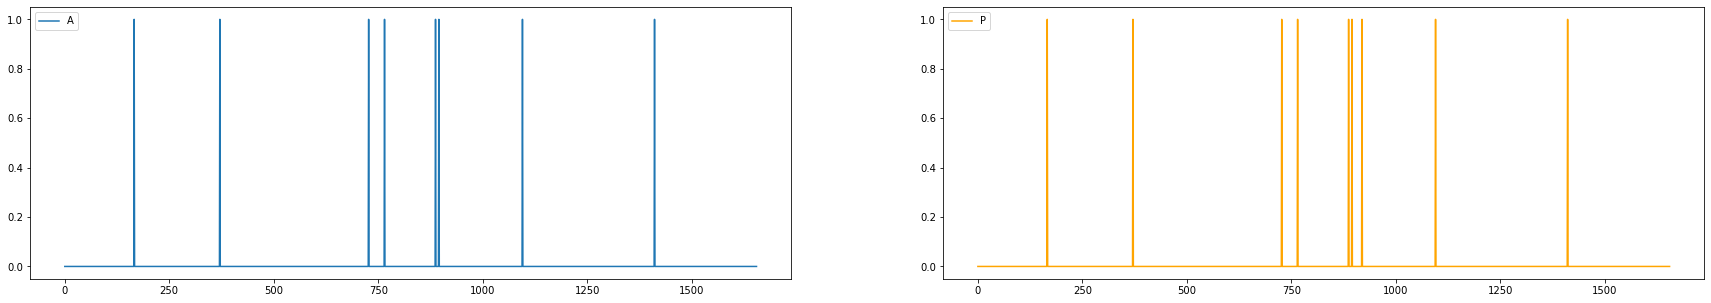

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS25.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS25.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.54595421e-07], Max [0.27800703]
Deviation 99.5th pctile [0.10030478]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 469463 ms


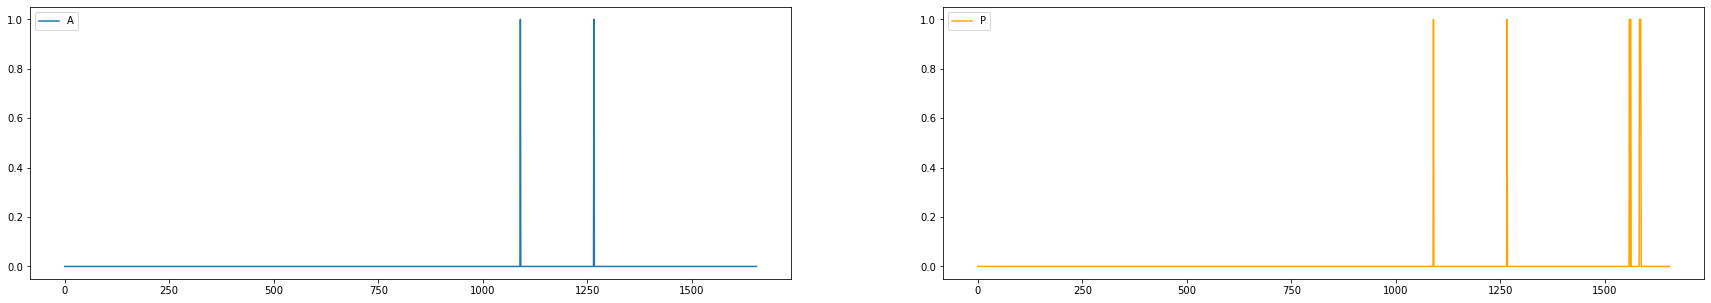

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS26.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS26.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.49545937e-05], Max [0.21402566]
Deviation 99.5th pctile [0.16844983]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1641    5]
 [   6    4]]
precision 0.44444, recall 0.40000, f1 0.42105
Time to predict and get records above deviation : 473407 ms


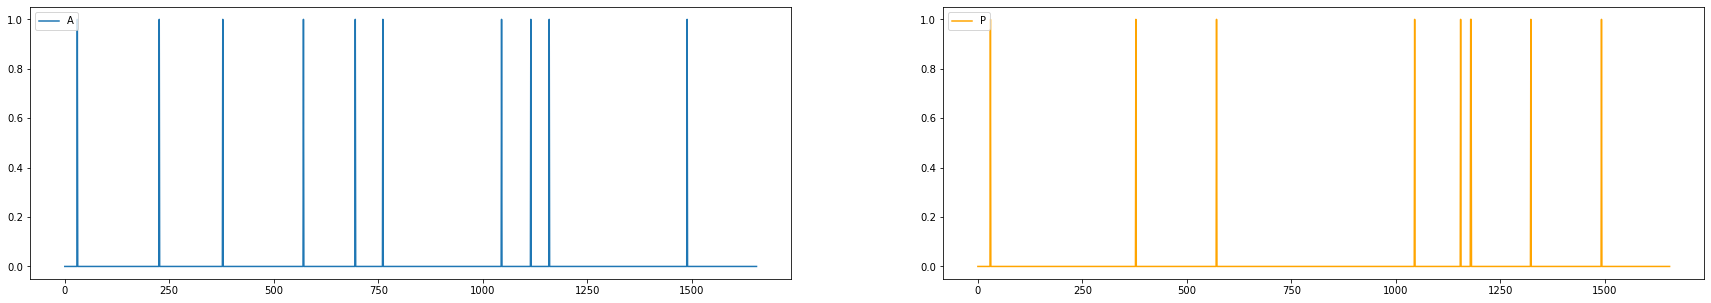

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS27.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS27.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.68601243e-05], Max [0.19924938]
Deviation 99.5th pctile [0.14969287]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1646    1]
 [   1    8]]
precision 0.88889, recall 0.88889, f1 0.88889
Time to predict and get records above deviation : 477734 ms


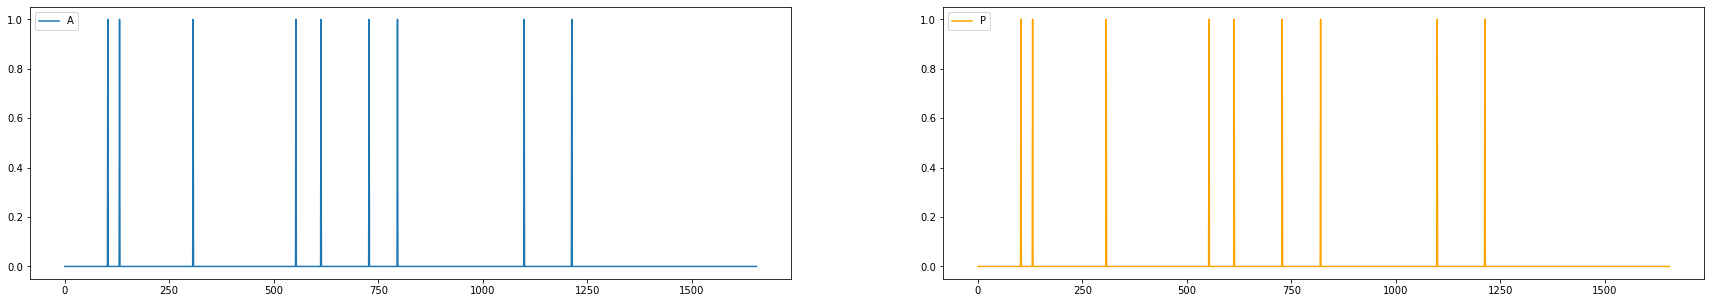

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS28.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS28.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.6646835e-05], Max [0.38667631]
Deviation 99.5th pctile [0.15123774]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 480320 ms


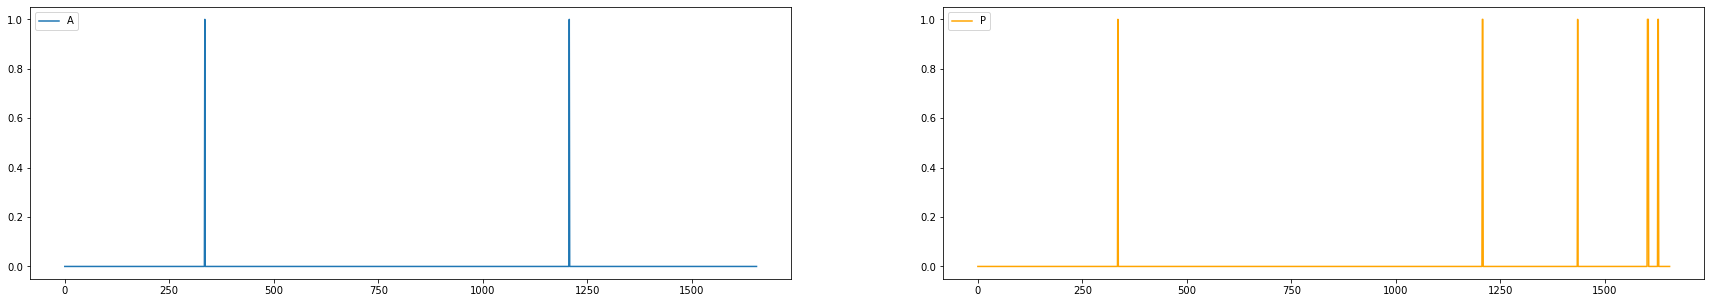

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS29.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS29.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.48102022e-05], Max [0.25274917]
Deviation 99.5th pctile [0.10856269]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 481933 ms


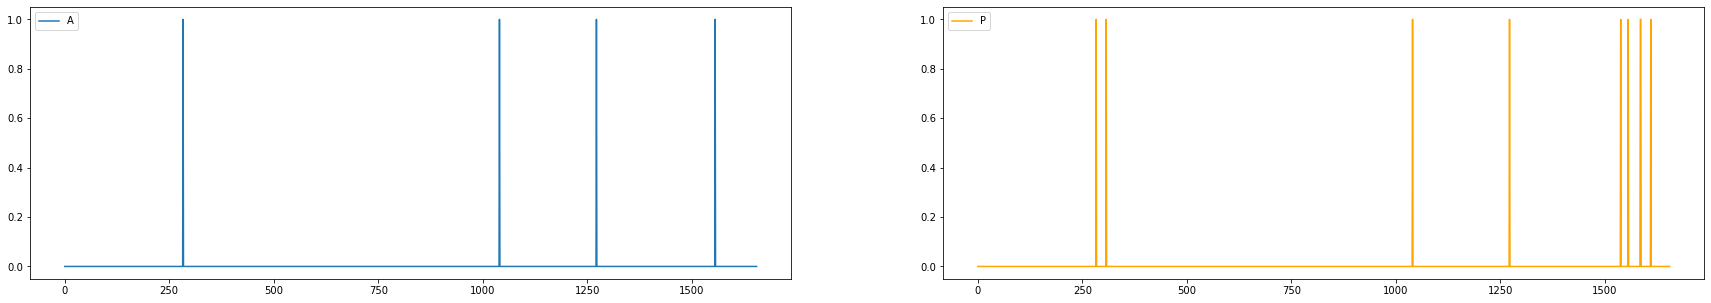

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS3.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS3.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.90909331e-05], Max [0.26473245]
Deviation 99.5th pctile [0.15307876]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1645    5]
 [   2    4]]
precision 0.44444, recall 0.66667, f1 0.53333
Time to predict and get records above deviation : 483596 ms


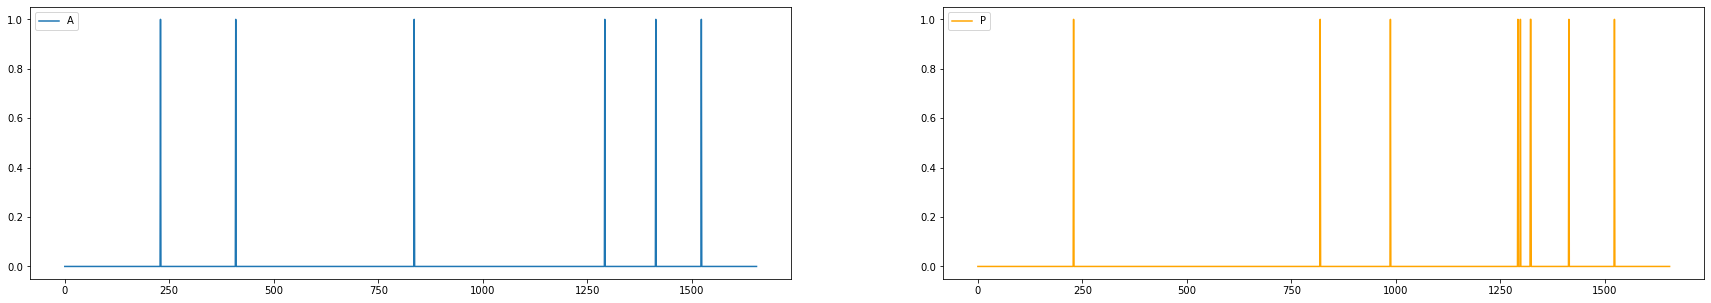

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS30.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS30.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.1113586e-05], Max [0.14647496]
Deviation 99.5th pctile [0.09300234]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1642    6]
 [   5    3]]
precision 0.33333, recall 0.37500, f1 0.35294
Time to predict and get records above deviation : 485651 ms


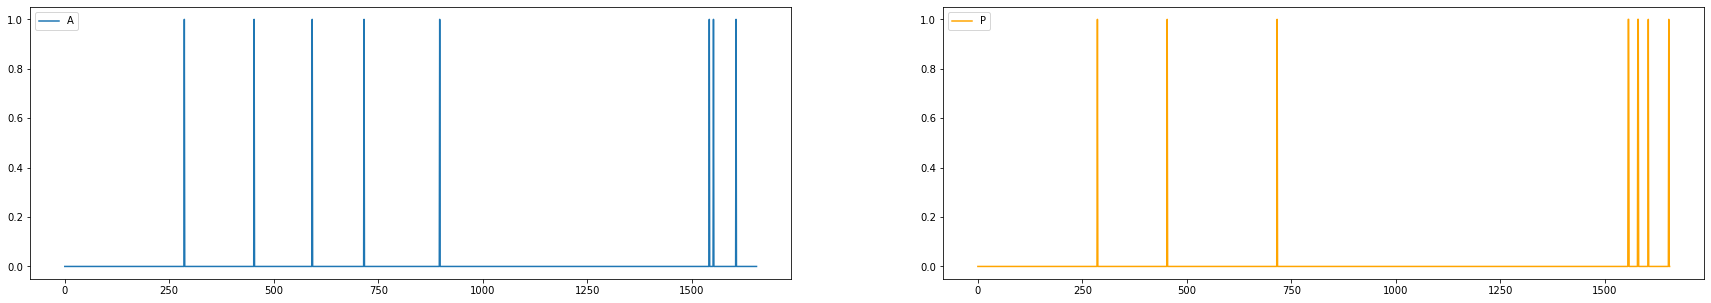

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS31.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS31.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.97262953e-05], Max [0.40706122]
Deviation 99.5th pctile [0.13065371]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1647    2]
 [   0    7]]
precision 0.77778, recall 1.00000, f1 0.87500
Time to predict and get records above deviation : 487944 ms


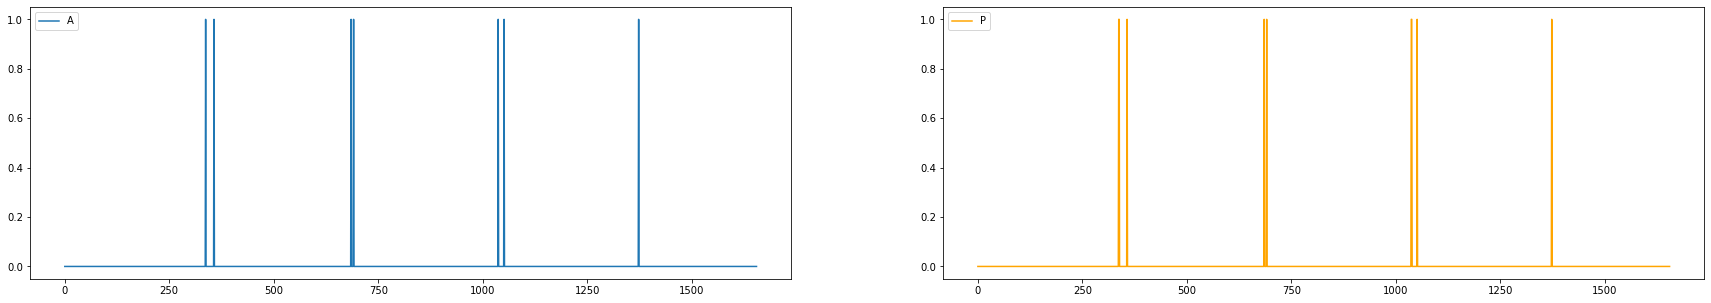

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS32.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS32.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.10459248e-07], Max [0.37703204]
Deviation 99.5th pctile [0.27989762]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to predict and get records above deviation : 493162 ms


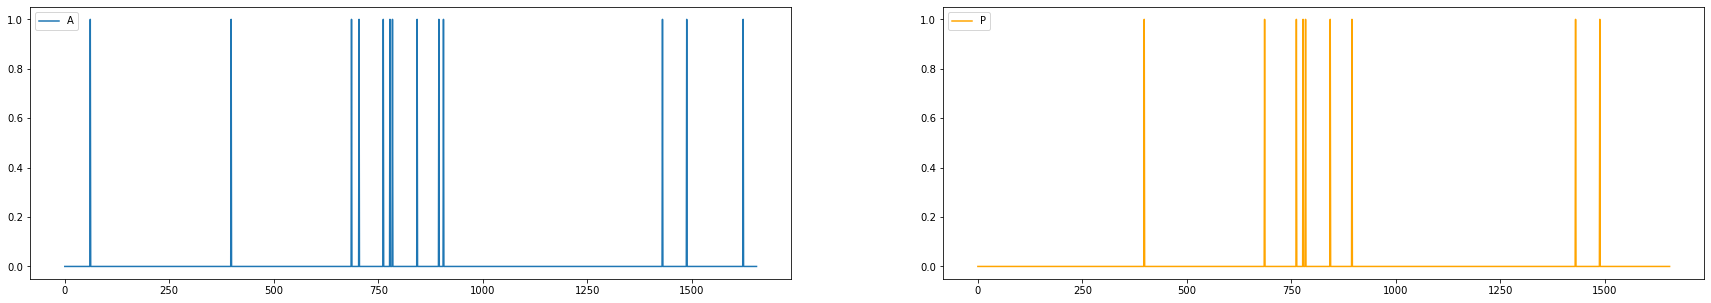

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS33.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS33.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.61968592e-05], Max [0.46434054]
Deviation 99.5th pctile [0.18878152]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 496164 ms


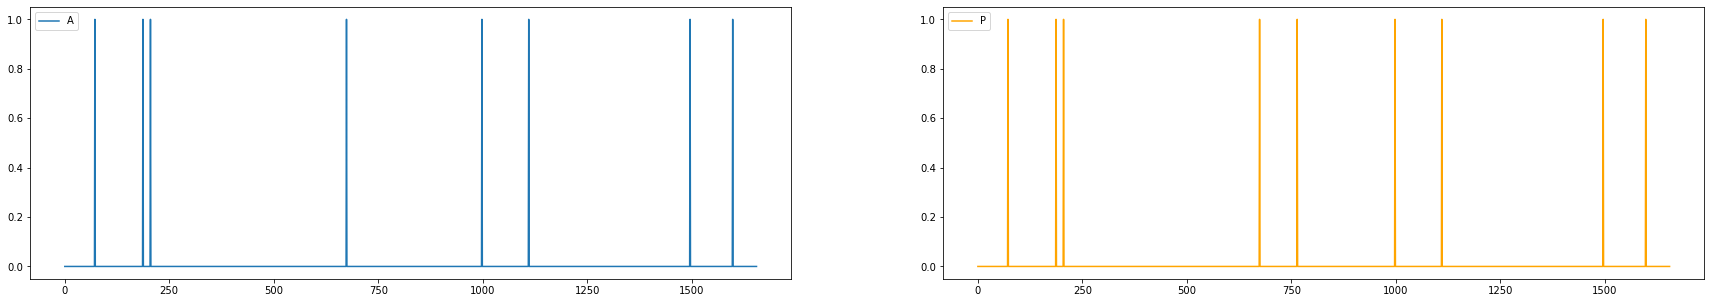

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS34.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS34.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.12958247e-05], Max [0.35016599]
Deviation 99.5th pctile [0.14584914]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 498654 ms


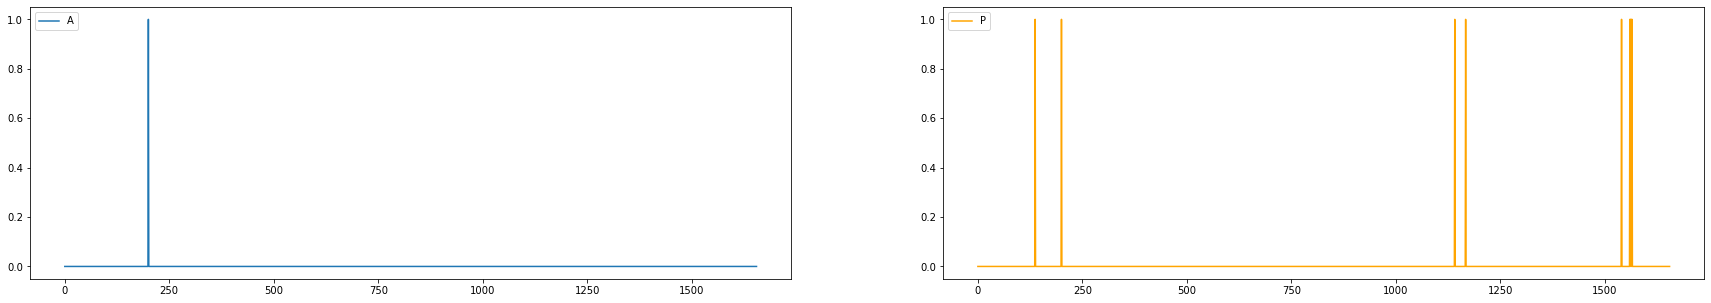

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS35.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS35.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.98400893e-05], Max [0.43694728]
Deviation 99.5th pctile [0.13529151]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1647    6]
 [   0    3]]
precision 0.33333, recall 1.00000, f1 0.50000
Time to predict and get records above deviation : 501624 ms


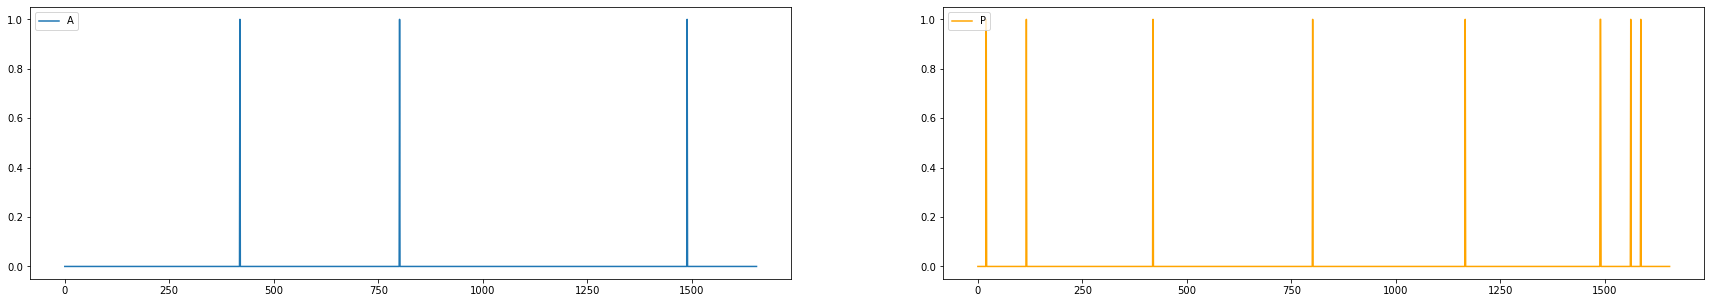

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS36.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS36.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [9.09709785e-06], Max [0.3517256]
Deviation 99.5th pctile [0.1172003]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 506279 ms


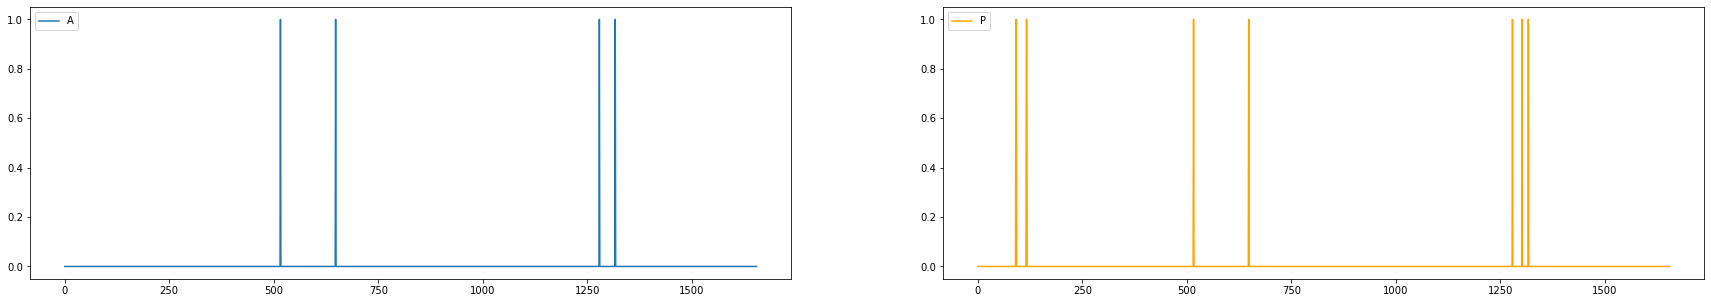

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS37.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS37.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.1186284e-05], Max [0.42719668]
Deviation 99.5th pctile [0.25503371]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1645    1]
 [   2    8]]
precision 0.88889, recall 0.80000, f1 0.84211
Time to predict and get records above deviation : 509052 ms


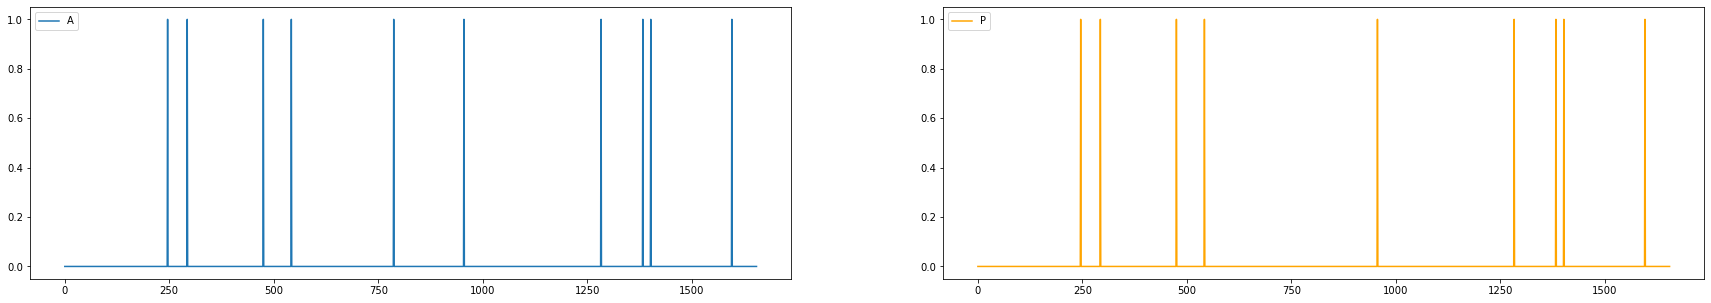

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS38.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS38.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.00740447e-05], Max [0.19427459]
Deviation 99.5th pctile [0.12609417]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1646    7]
 [   1    2]]
precision 0.22222, recall 0.66667, f1 0.33333
Time to predict and get records above deviation : 511166 ms


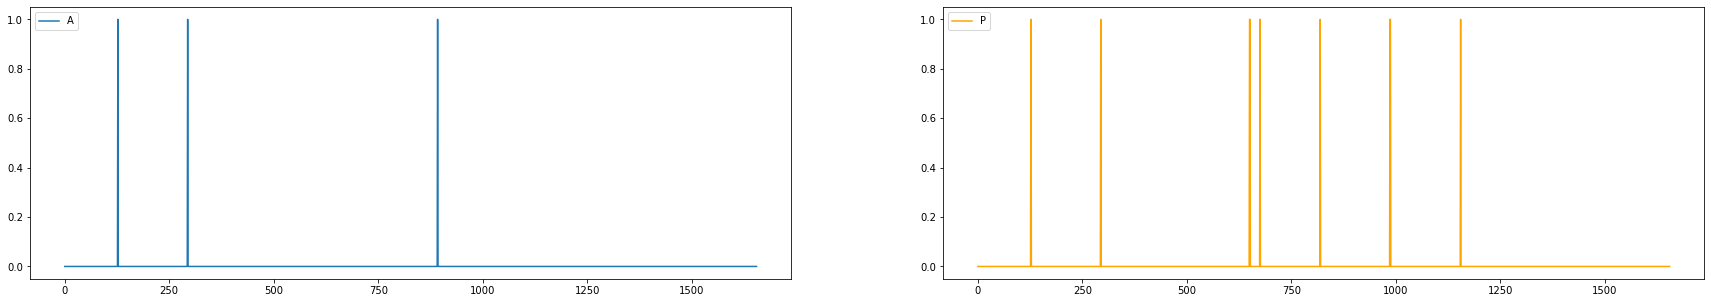

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS39.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS39.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.90481827e-06], Max [0.15556237]
Deviation 99.5th pctile [0.11245244]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1639    5]
 [   8    4]]
precision 0.44444, recall 0.33333, f1 0.38095
Time to predict and get records above deviation : 514010 ms


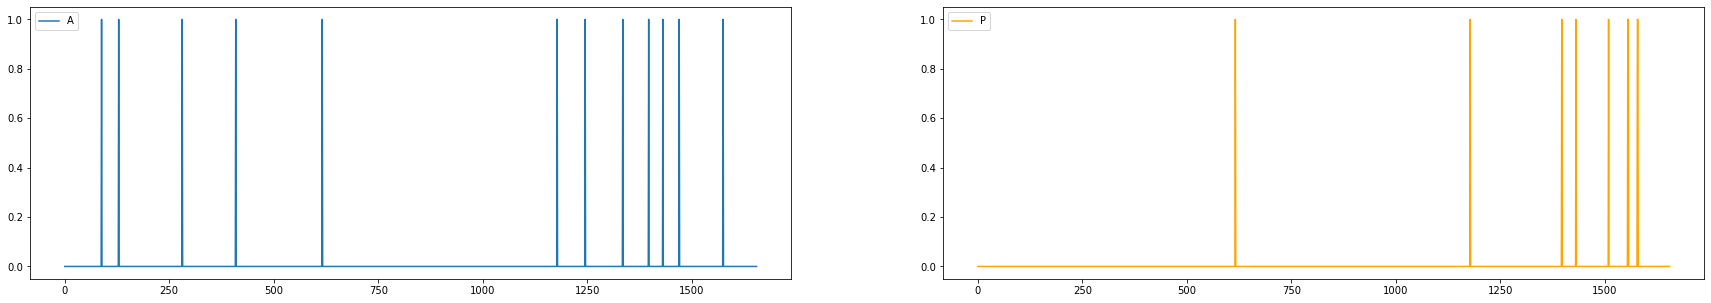

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS4.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS4.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.38301518e-05], Max [0.46271796]
Deviation 99.5th pctile [0.27529284]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1643    7]
 [   4    2]]
precision 0.22222, recall 0.33333, f1 0.26667
Time to predict and get records above deviation : 516975 ms


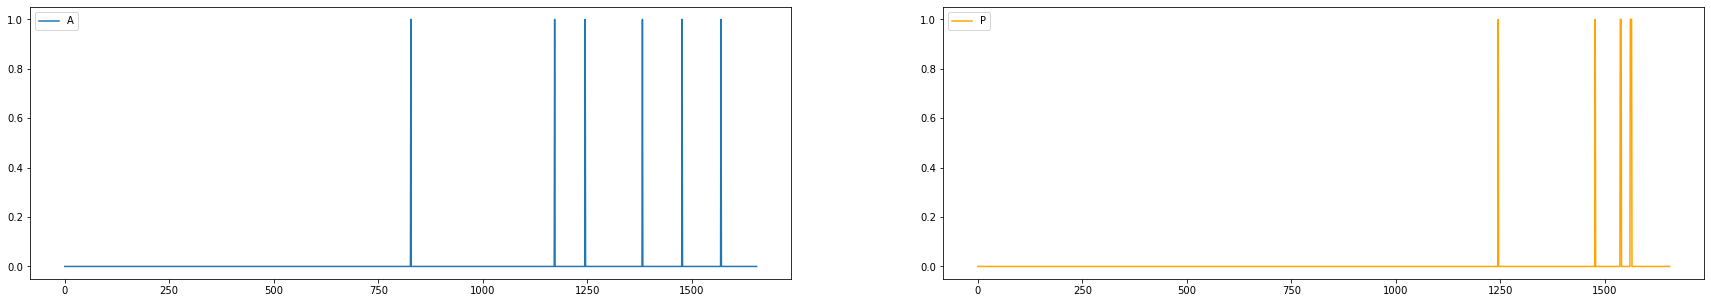

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS40.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS40.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.94855398e-05], Max [0.20588407]
Deviation 99.5th pctile [0.15926393]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1641    5]
 [   6    4]]
precision 0.44444, recall 0.40000, f1 0.42105
Time to predict and get records above deviation : 519224 ms


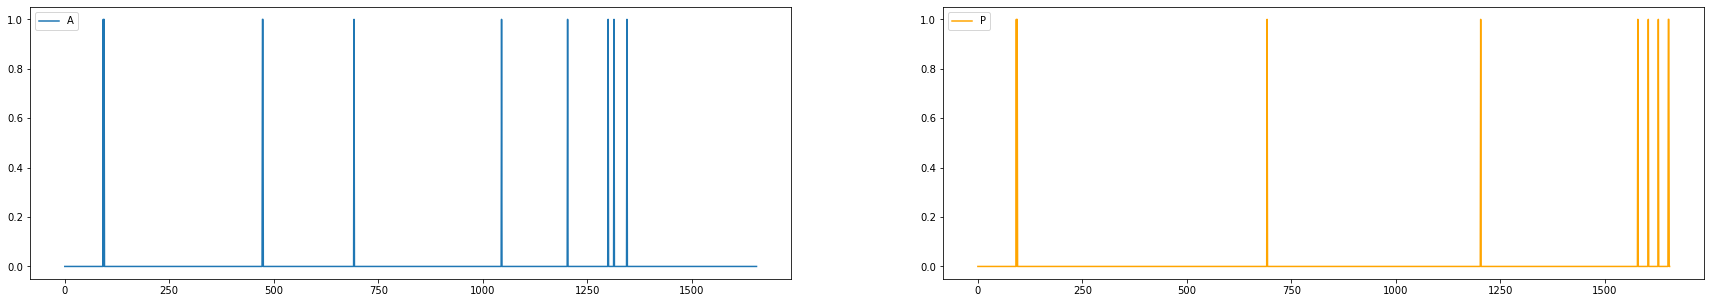

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS41.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS41.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.44349449e-05], Max [0.44010259]
Deviation 99.5th pctile [0.35229235]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1642    0]
 [   5    9]]
precision 1.00000, recall 0.64286, f1 0.78261
Time to predict and get records above deviation : 521754 ms


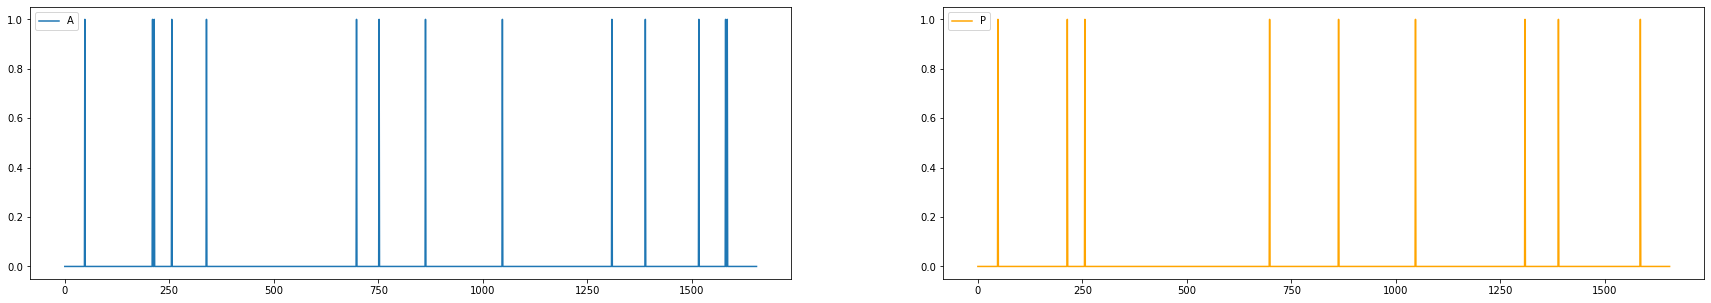

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS42.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS42.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.30434674e-05], Max [0.23614979]
Deviation 99.5th pctile [0.18623035]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1634    6]
 [  13    3]]
precision 0.33333, recall 0.18750, f1 0.24000
Time to predict and get records above deviation : 523464 ms


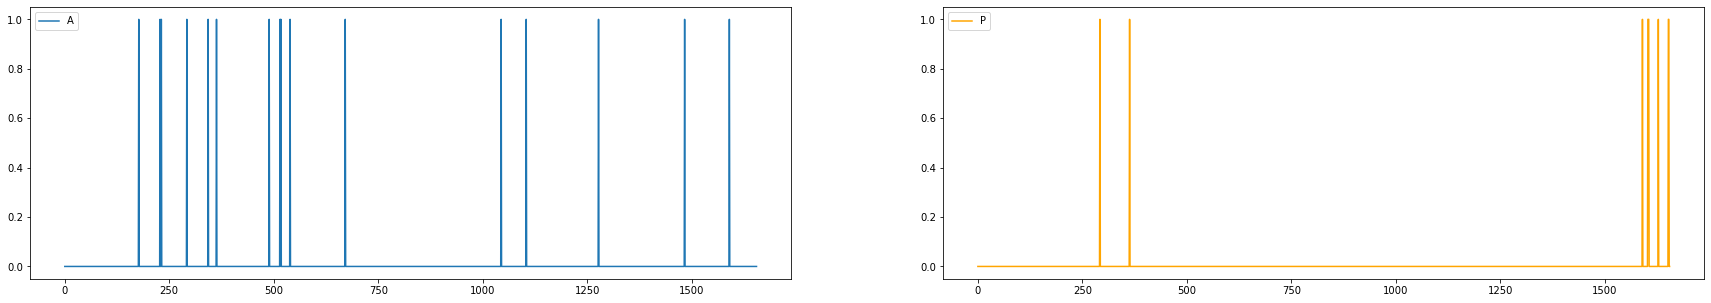

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS43.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS43.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00012782], Max [0.18100889]
Deviation 99.5th pctile [0.12510782]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1637    4]
 [  10    5]]
precision 0.55556, recall 0.33333, f1 0.41667
Time to predict and get records above deviation : 526520 ms


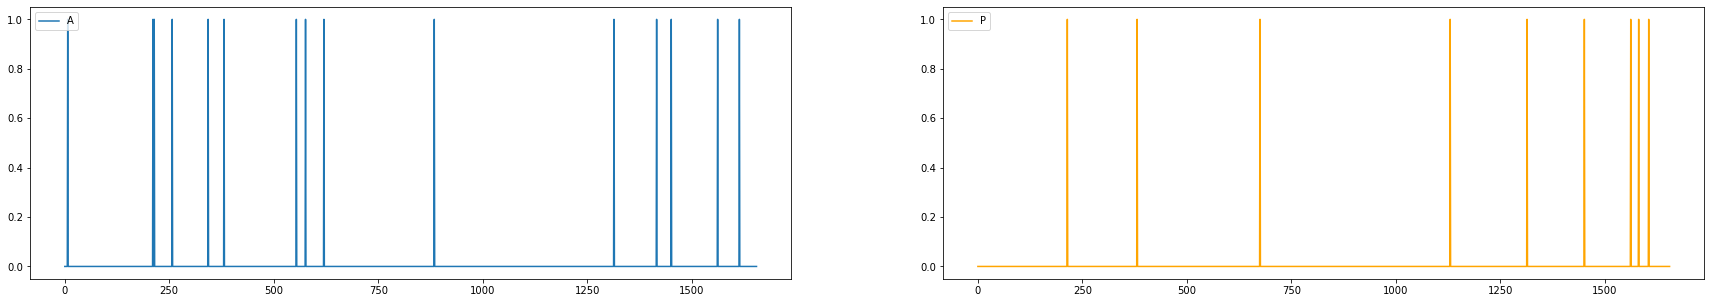

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS44.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS44.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.86335437e-05], Max [0.38535658]
Deviation 99.5th pctile [0.31622428]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 528360 ms


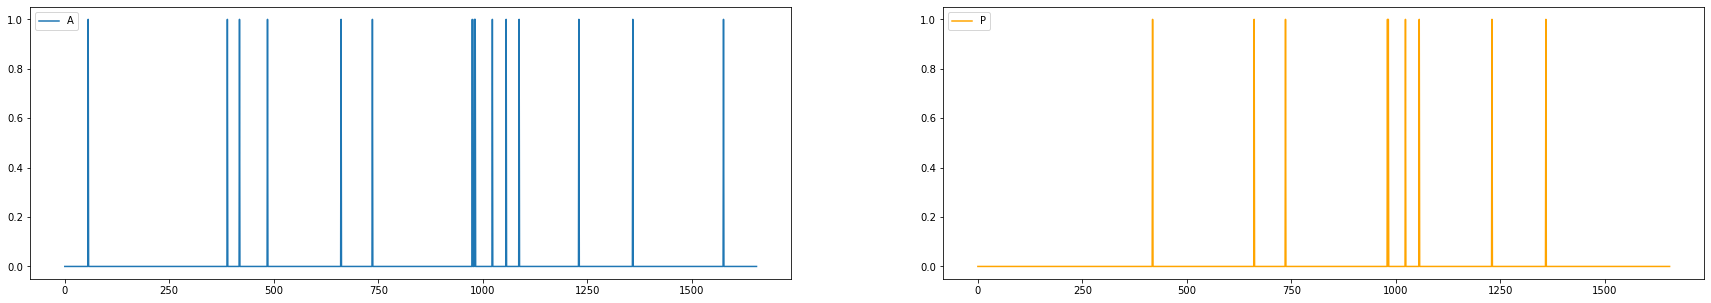

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS45.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS45.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00013493], Max [0.40765035]
Deviation 99.5th pctile [0.1928861]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 533849 ms


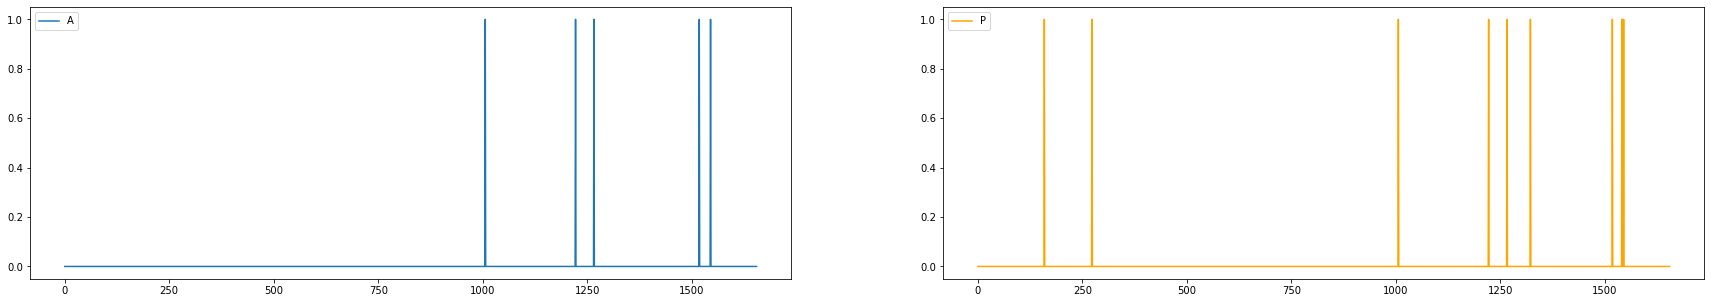

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS46.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS46.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00026901], Max [0.2814532]
Deviation 99.5th pctile [0.19060028]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1646    7]
 [   1    2]]
precision 0.22222, recall 0.66667, f1 0.33333
Time to predict and get records above deviation : 540323 ms


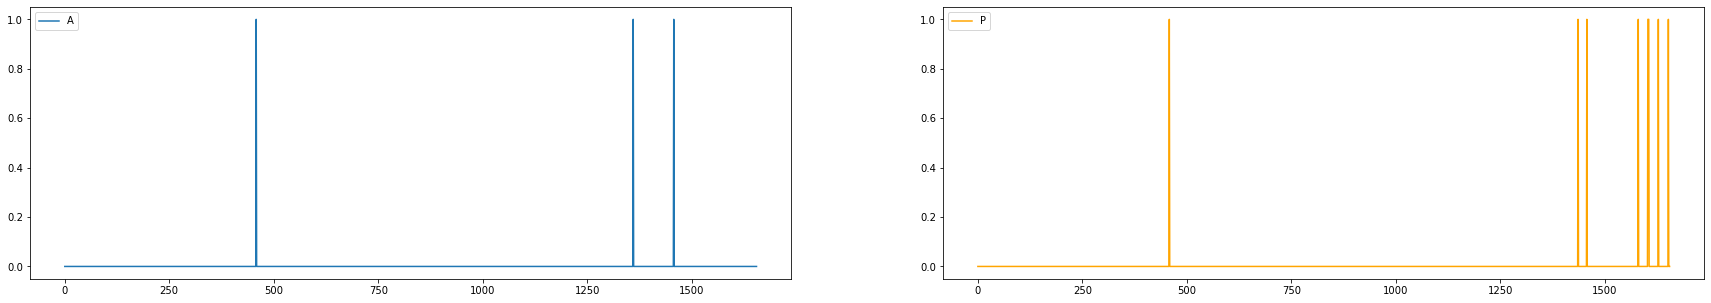

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS47.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS47.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.3722971e-05], Max [0.29981082]
Deviation 99.5th pctile [0.22617902]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 543168 ms


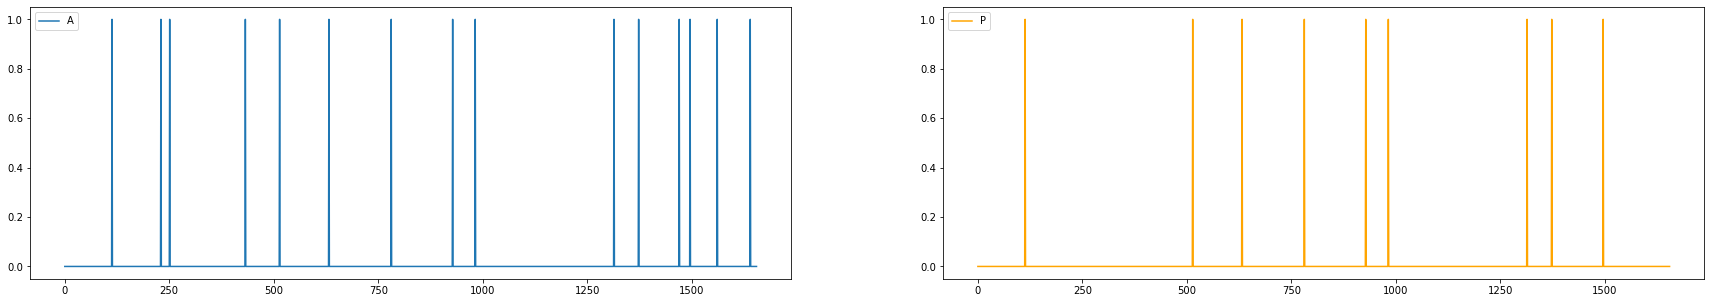

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS48.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS48.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.00478031e-05], Max [0.25712359]
Deviation 99.5th pctile [0.15662057]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1639    4]
 [   8    5]]
precision 0.55556, recall 0.38462, f1 0.45455
Time to predict and get records above deviation : 547654 ms


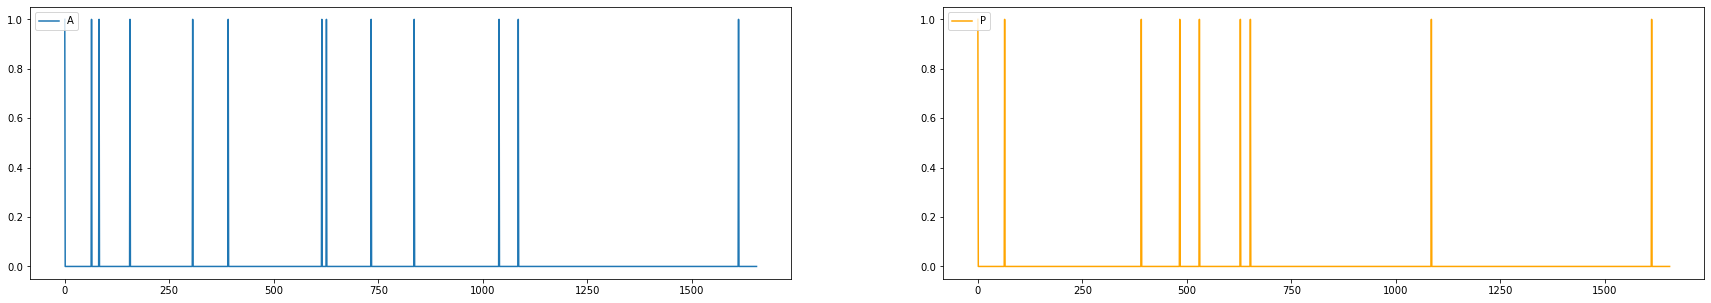

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS49.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS49.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.07521657e-05], Max [0.46101678]
Deviation 99.5th pctile [0.35406991]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 549476 ms


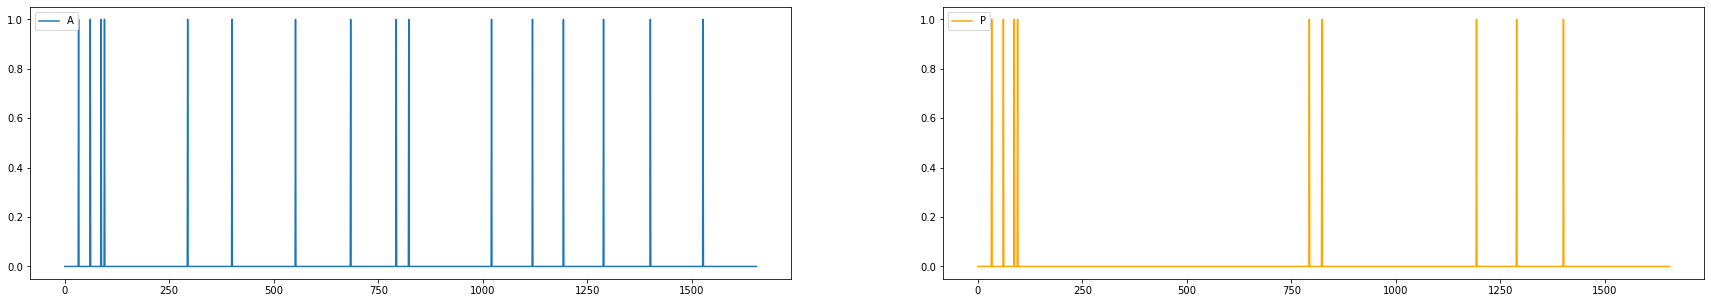

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS5.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS5.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00011513], Max [0.25393835]
Deviation 99.5th pctile [0.24105944]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1645    9]
 [   2    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 555381 ms


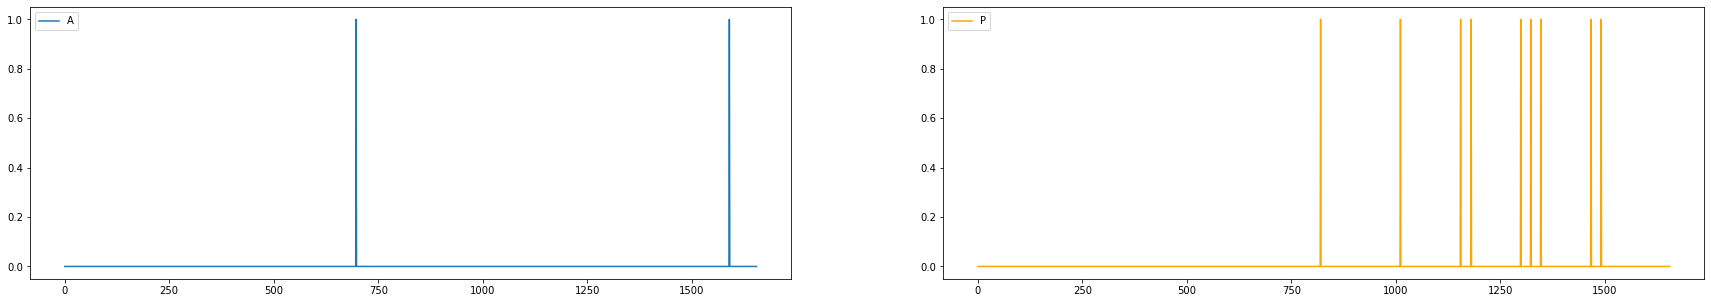

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS50.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS50.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.22315624e-06], Max [0.10918835]
Deviation 99.5th pctile [0.07845156]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1643    7]
 [   4    2]]
precision 0.22222, recall 0.33333, f1 0.26667
Time to predict and get records above deviation : 557411 ms


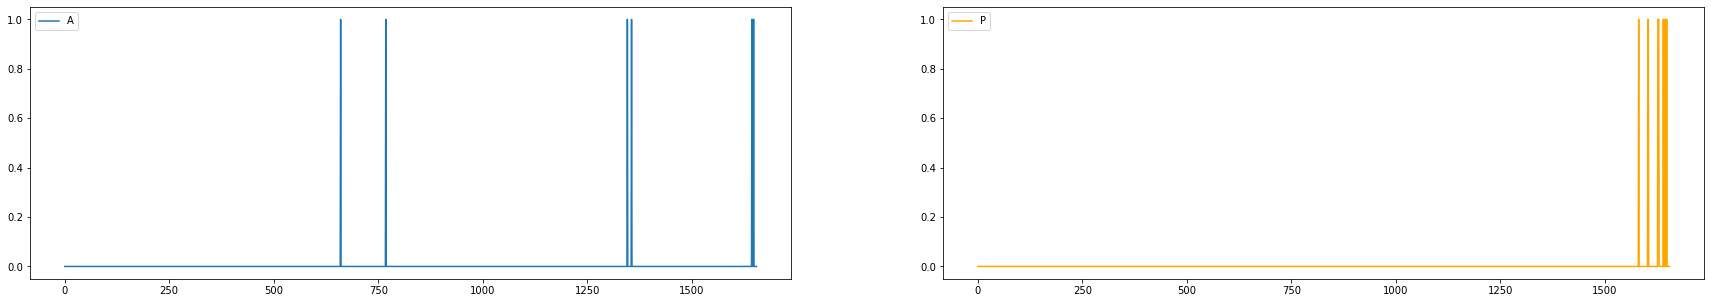

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS51.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS51.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.71135719e-05], Max [0.44285914]
Deviation 99.5th pctile [0.33788203]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1634    9]
 [  13    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 559311 ms


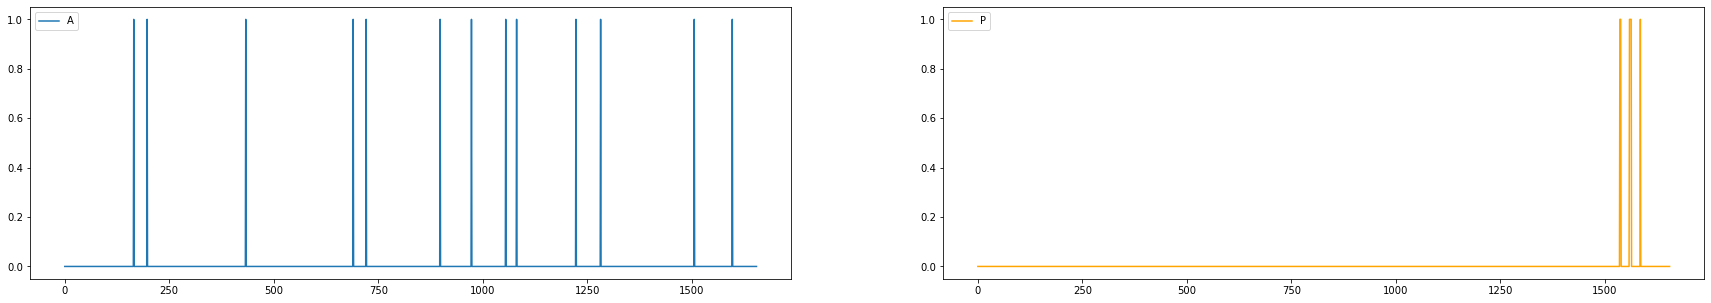

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS52.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS52.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.73096136e-06], Max [0.45858714]
Deviation 99.5th pctile [0.16773596]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 564490 ms


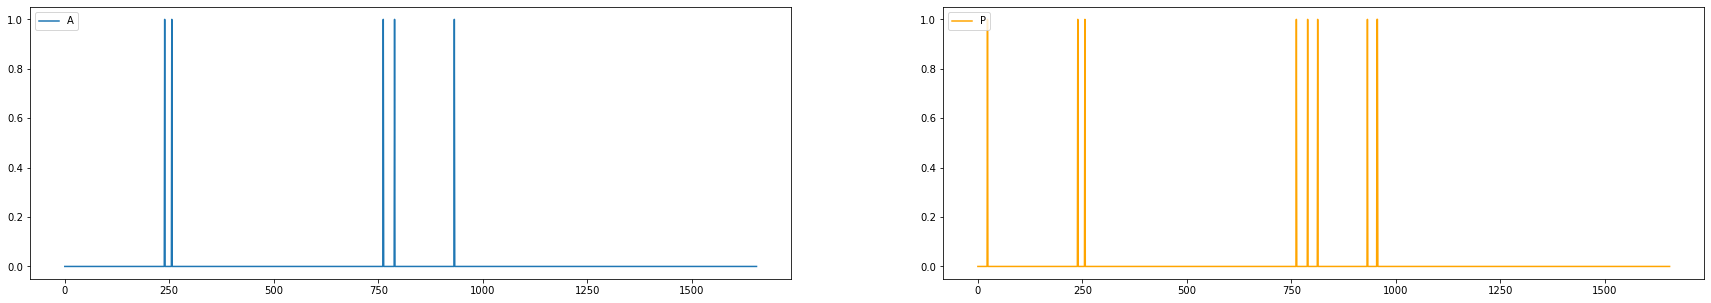

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS53.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS53.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.41320837e-05], Max [0.36766598]
Deviation 99.5th pctile [0.25128681]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 567767 ms


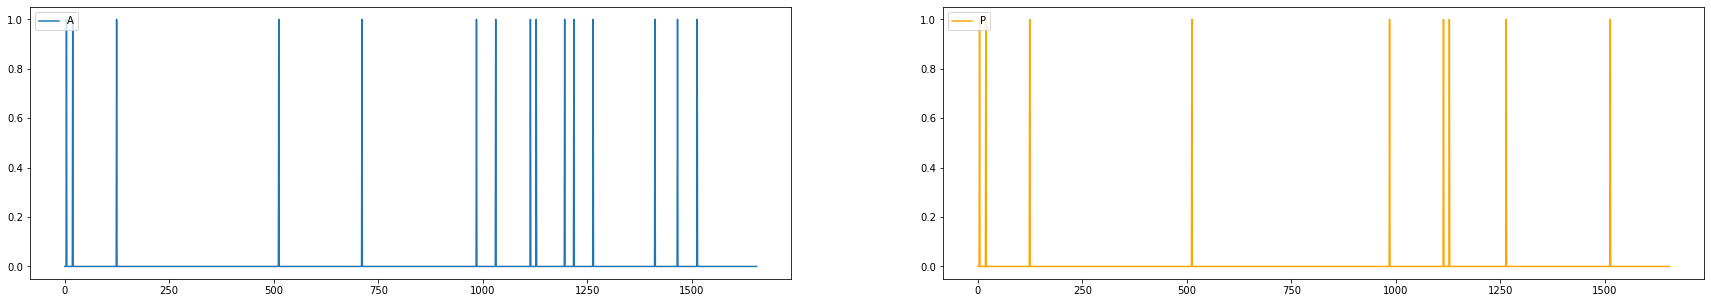

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS54.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS54.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00014956], Max [0.41945601]
Deviation 99.5th pctile [0.31176535]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 572307 ms


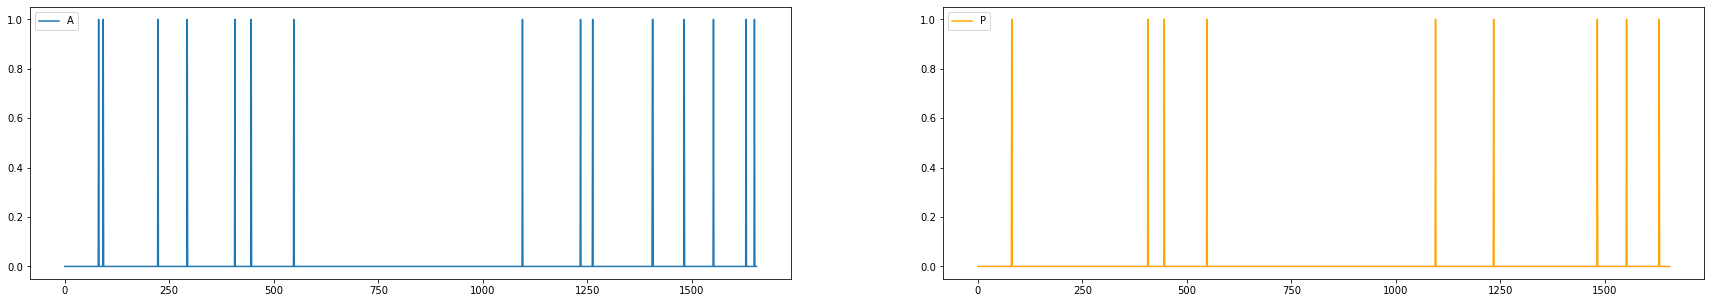

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS55.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS55.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.5623332e-05], Max [0.40106652]
Deviation 99.5th pctile [0.1978184]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1643    2]
 [   4    7]]
precision 0.77778, recall 0.63636, f1 0.70000
Time to predict and get records above deviation : 577806 ms


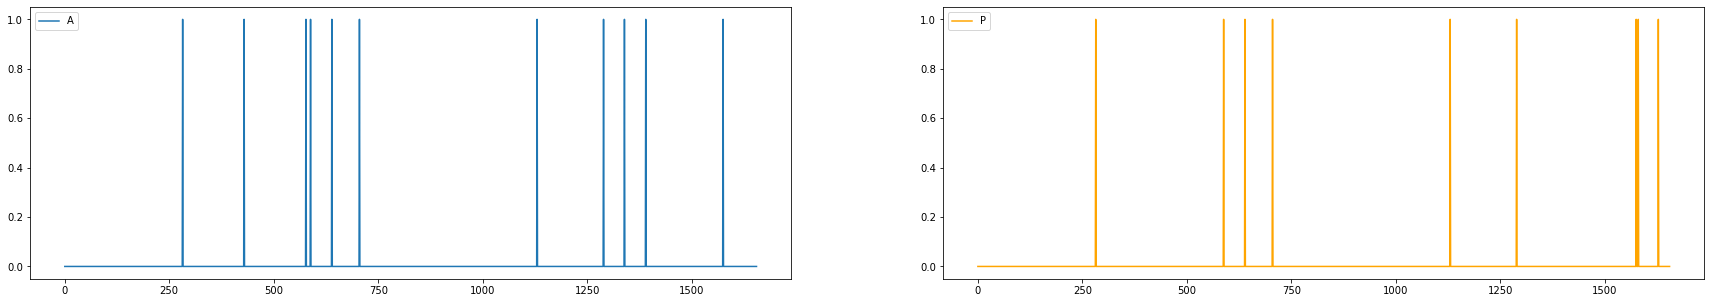

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS56.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS56.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.47608209e-05], Max [0.24985321]
Deviation 99.5th pctile [0.08633488]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 586841 ms


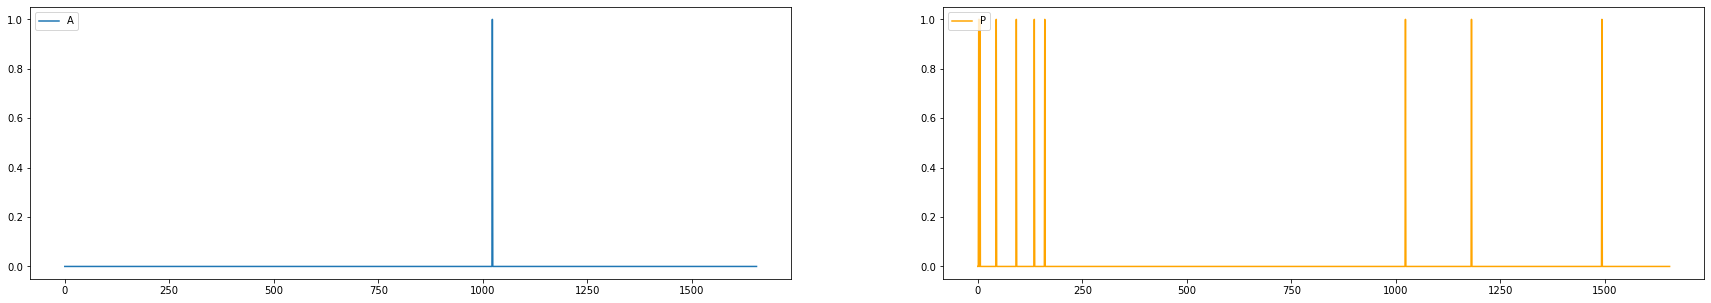

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS57.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS57.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.25792804e-05], Max [0.25328832]
Deviation 99.5th pctile [0.20763554]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1643    4]
 [   4    5]]
precision 0.55556, recall 0.55556, f1 0.55556
Time to predict and get records above deviation : 589645 ms


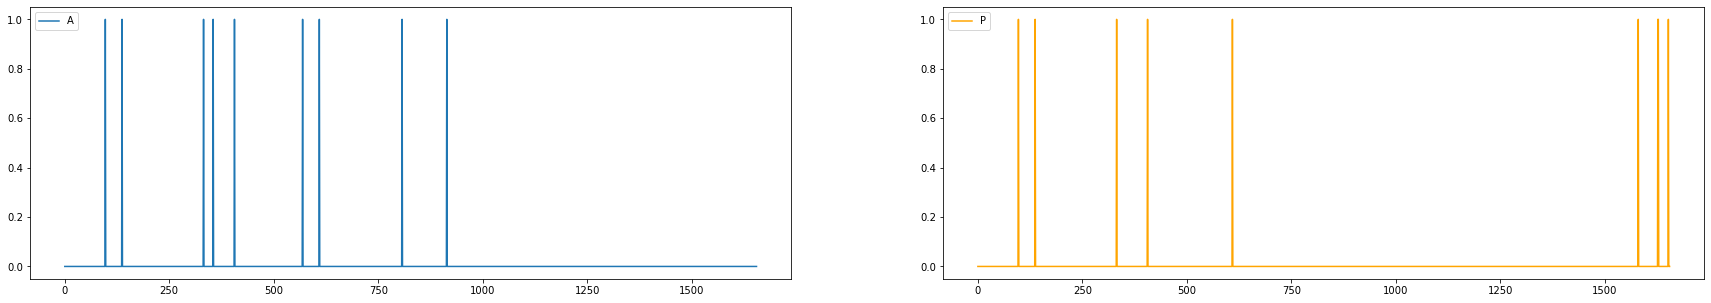

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS58.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS58.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.06609253e-05], Max [0.52909662]
Deviation 99.5th pctile [0.2063216]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1647    6]
 [   0    3]]
precision 0.33333, recall 1.00000, f1 0.50000
Time to predict and get records above deviation : 593292 ms


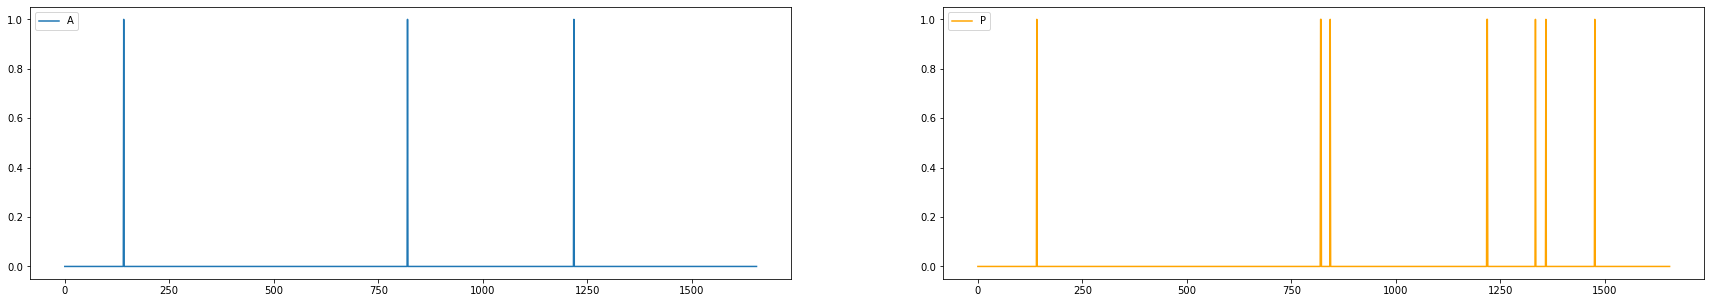

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS59.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS59.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.37486223e-05], Max [0.2623078]
Deviation 99.5th pctile [0.21129834]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1645    0]
 [   2    9]]
precision 1.00000, recall 0.81818, f1 0.90000
Time to predict and get records above deviation : 595561 ms


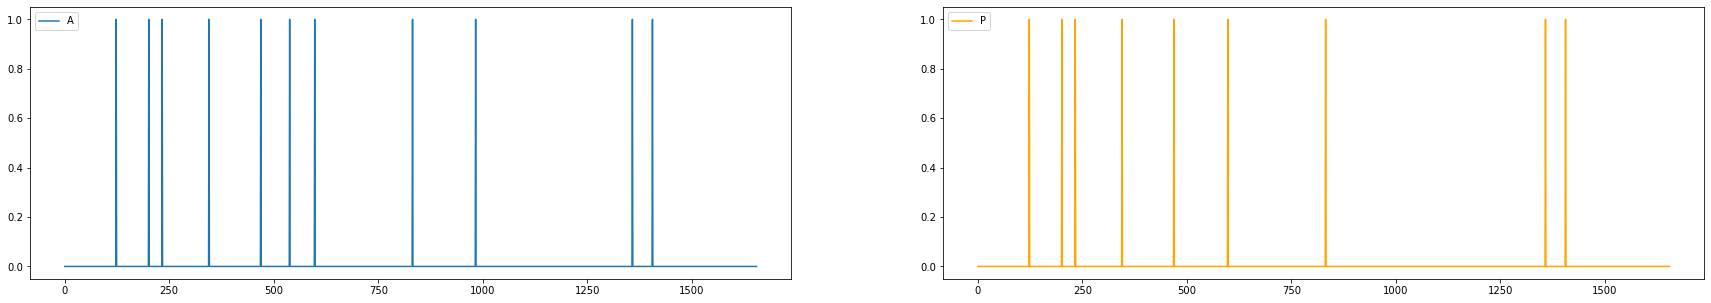

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS6.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS6.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [9.71669037e-05], Max [0.45992082]
Deviation 99.5th pctile [0.19923389]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1647    3]
 [   0    6]]
precision 0.66667, recall 1.00000, f1 0.80000
Time to predict and get records above deviation : 597715 ms


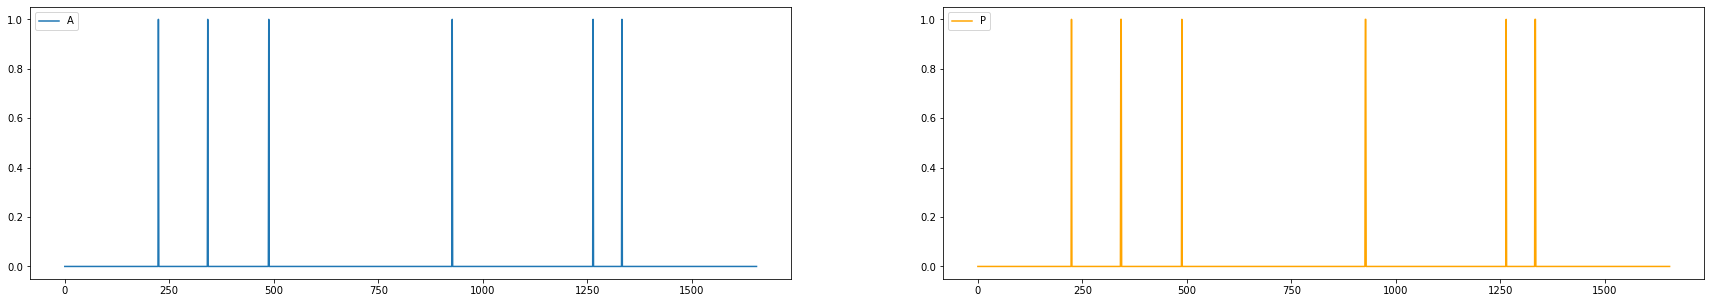

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS60.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS60.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.75991959e-05], Max [0.18719355]
Deviation 99.5th pctile [0.16723765]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1636    8]
 [  11    1]]
precision 0.11111, recall 0.08333, f1 0.09524
Time to predict and get records above deviation : 600836 ms


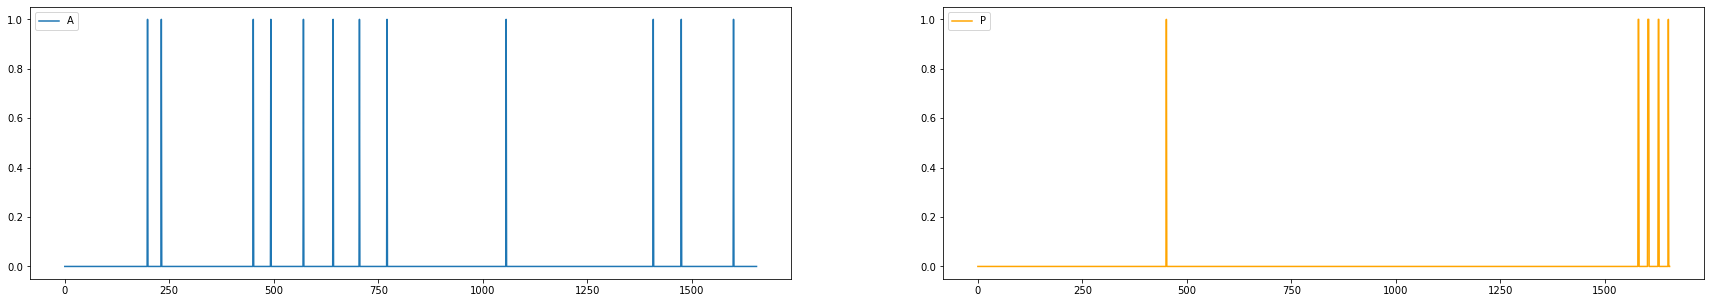

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS61.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS61.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.56549033e-06], Max [0.4764174]
Deviation 99.5th pctile [0.27453286]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1642    1]
 [   5    8]]
precision 0.88889, recall 0.61538, f1 0.72727
Time to predict and get records above deviation : 602691 ms


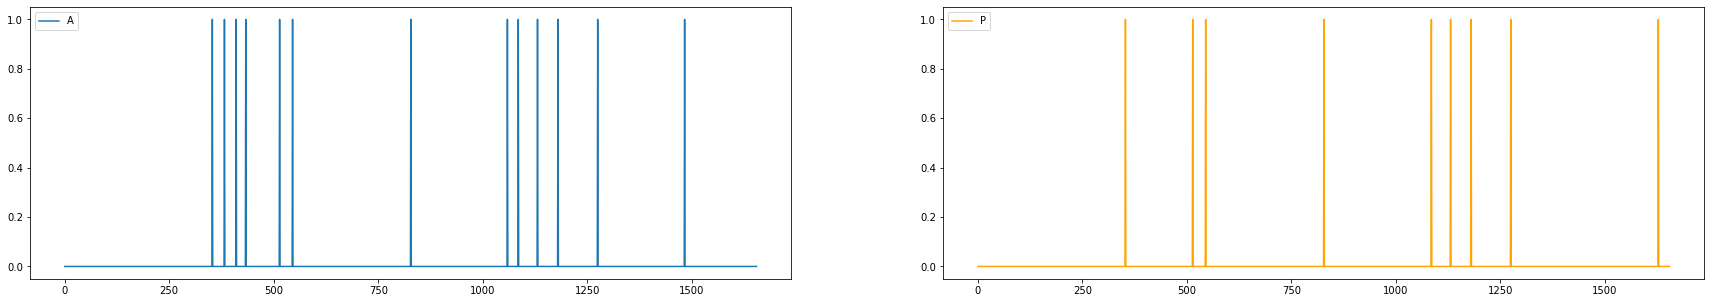

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS62.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS62.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.189957e-06], Max [0.11399184]
Deviation 99.5th pctile [0.09272933]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1636    8]
 [  11    1]]
precision 0.11111, recall 0.08333, f1 0.09524
Time to predict and get records above deviation : 605386 ms


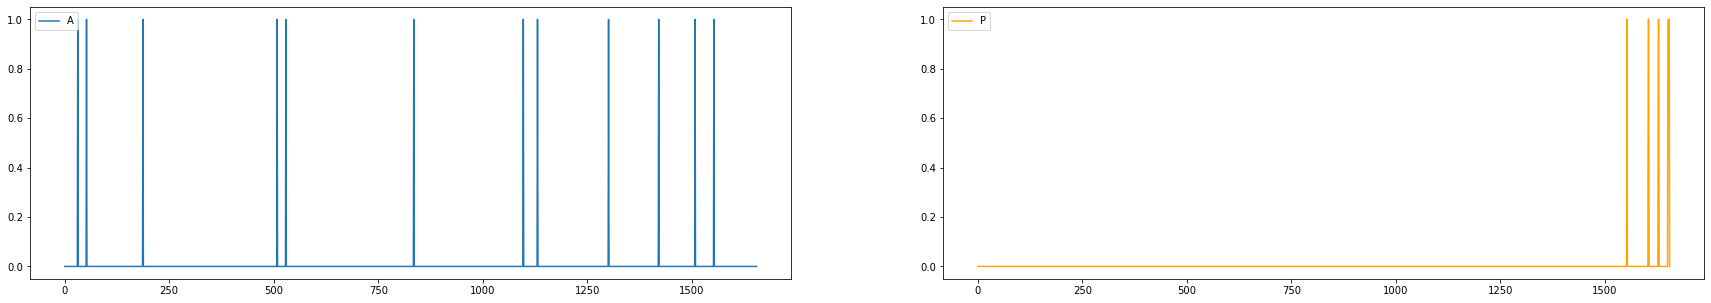

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS63.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS63.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.38550113e-06], Max [0.26621613]
Deviation 99.5th pctile [0.19144296]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1646    0]
 [   1    9]]
precision 1.00000, recall 0.90000, f1 0.94737
Time to predict and get records above deviation : 607438 ms


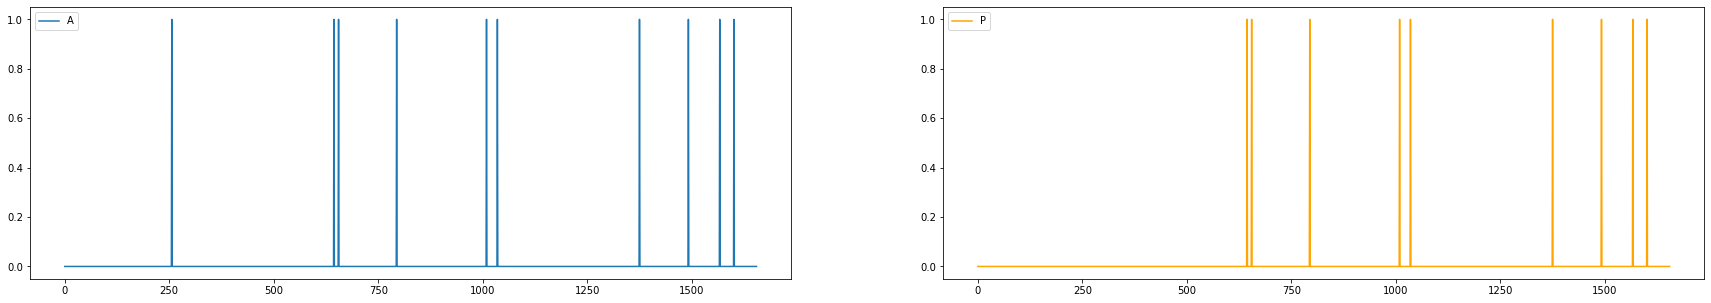

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS64.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS64.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.71658915e-05], Max [0.42884701]
Deviation 99.5th pctile [0.12766332]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 609168 ms


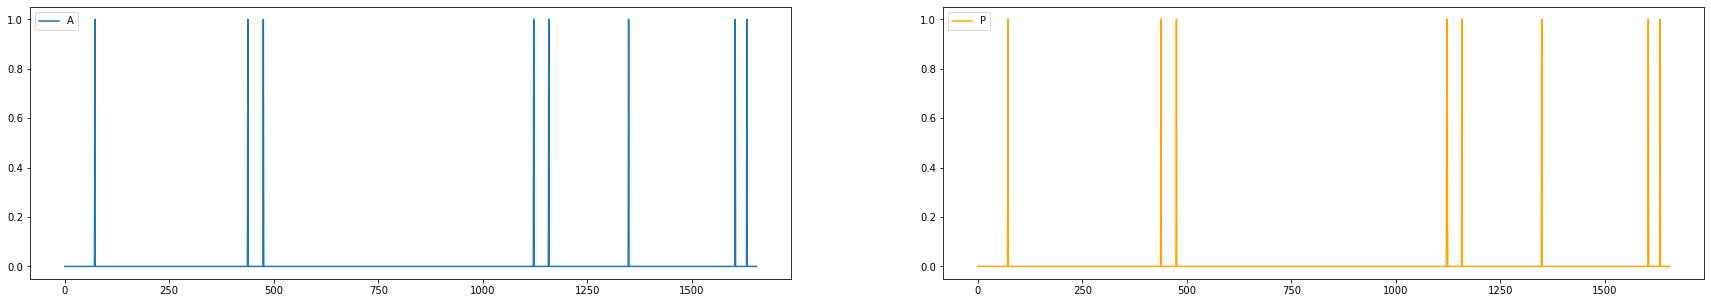

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS65.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS65.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.94782923e-05], Max [0.42973883]
Deviation 99.5th pctile [0.21705234]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1647    2]
 [   0    7]]
precision 0.77778, recall 1.00000, f1 0.87500
Time to predict and get records above deviation : 610831 ms


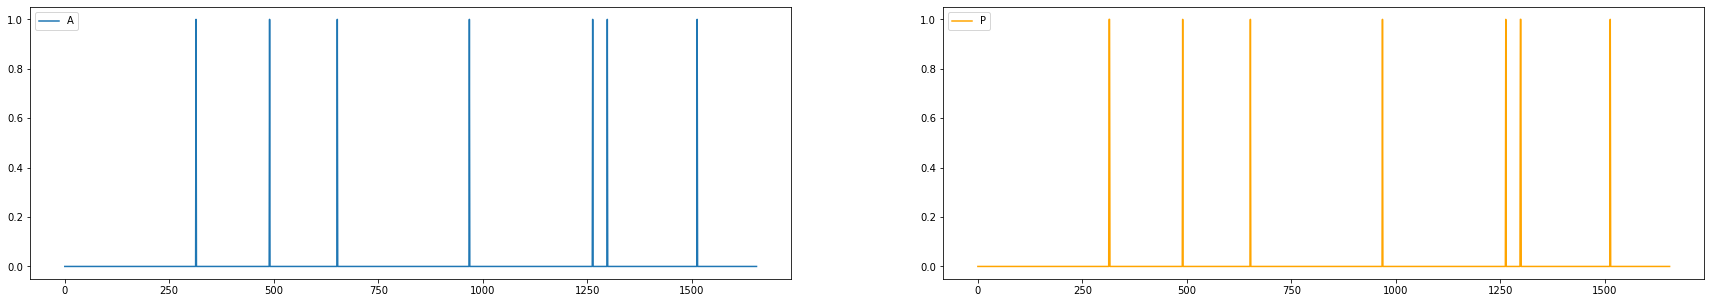

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS66.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS66.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.41612331e-05], Max [0.58624196]
Deviation 99.5th pctile [0.11369668]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 612763 ms


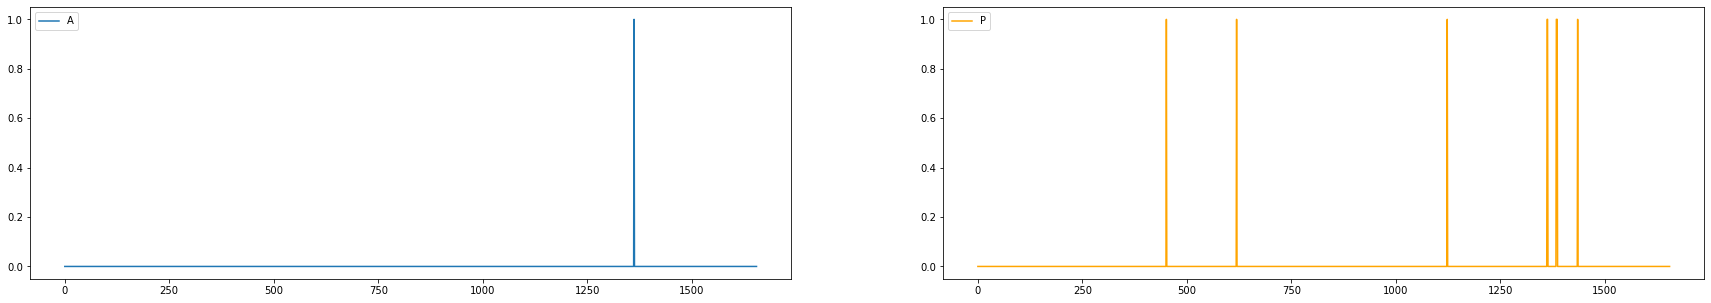

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS67.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS67.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.58225964e-06], Max [0.32641971]
Deviation 99.5th pctile [0.23339004]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 614554 ms


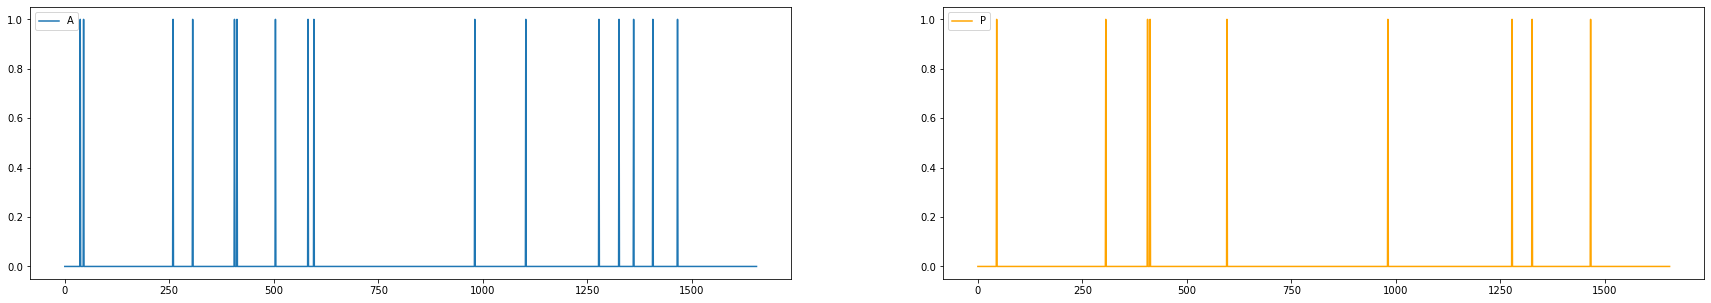

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS68.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS68.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.98750146e-05], Max [0.33641607]
Deviation 99.5th pctile [0.28288483]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 616699 ms


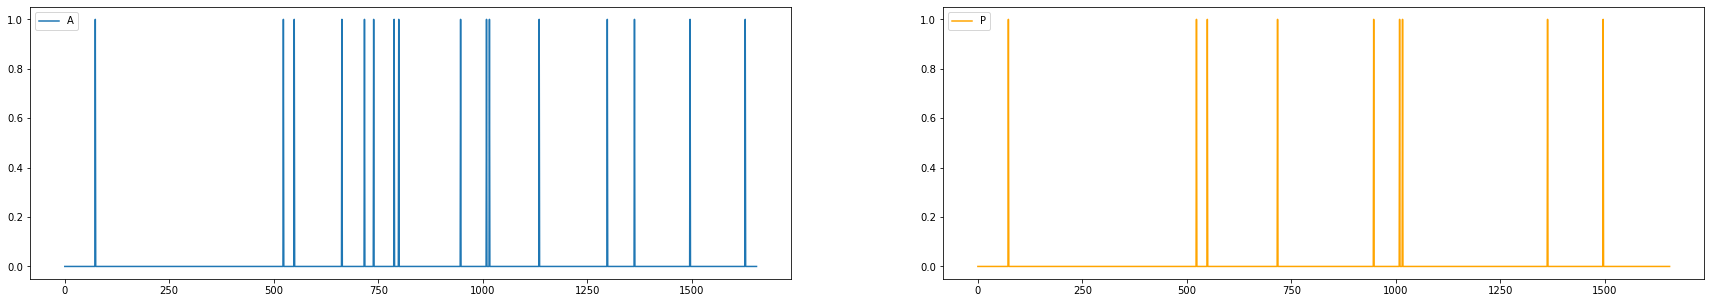

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS69.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS69.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.9665361e-05], Max [0.46350347]
Deviation 99.5th pctile [0.24271029]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1647    2]
 [   0    7]]
precision 0.77778, recall 1.00000, f1 0.87500
Time to predict and get records above deviation : 620082 ms


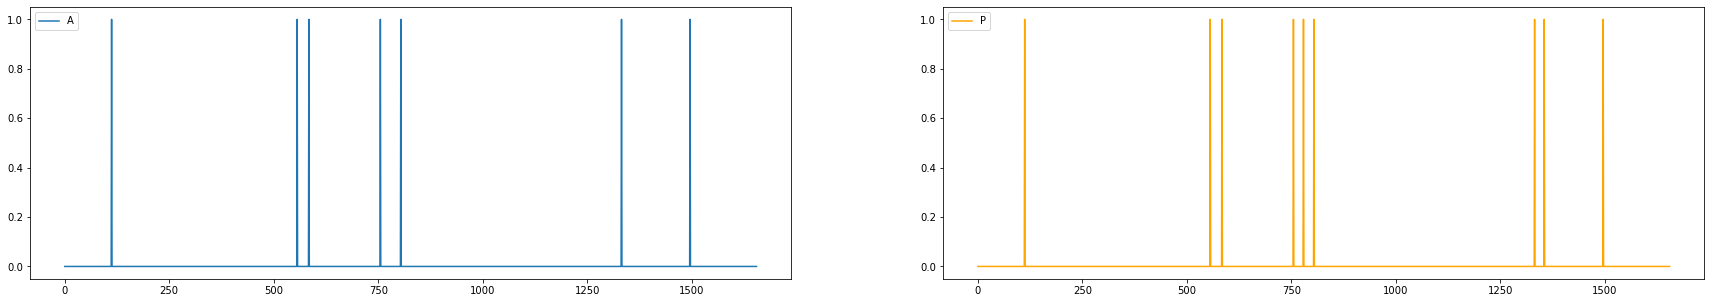

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS7.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS7.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00016062], Max [0.47552119]
Deviation 99.5th pctile [0.22764023]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 622365 ms


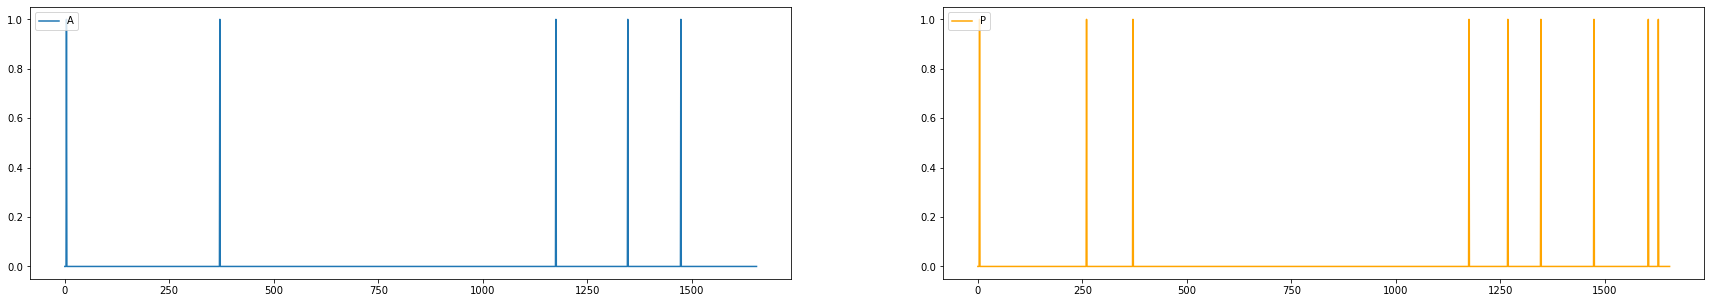

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS70.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS70.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.93012667e-05], Max [0.27842363]
Deviation 99.5th pctile [0.15264704]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1647    0]
 [   0    9]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 624614 ms


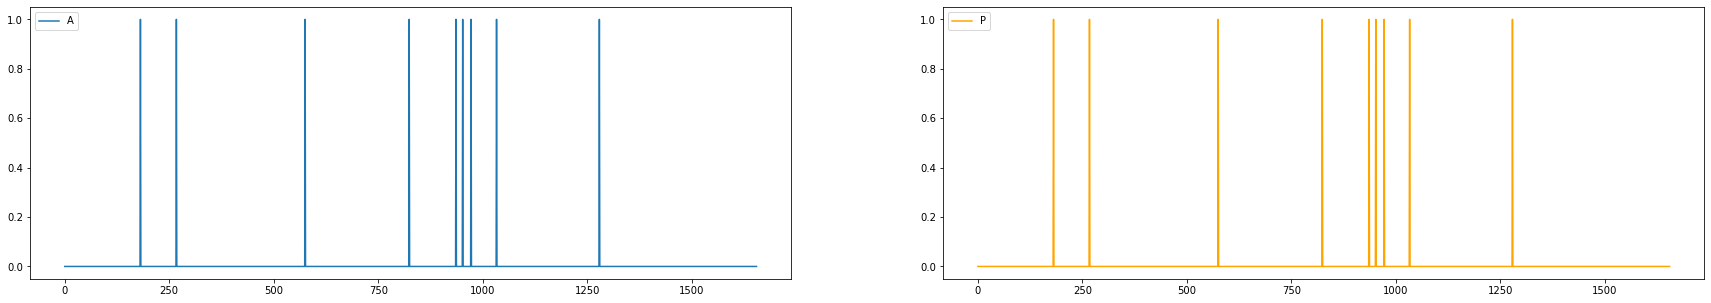

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS71.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS71.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.42912717e-05], Max [0.1788094]
Deviation 99.5th pctile [0.10234023]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1640    1]
 [   7    8]]
precision 0.88889, recall 0.53333, f1 0.66667
Time to predict and get records above deviation : 626448 ms


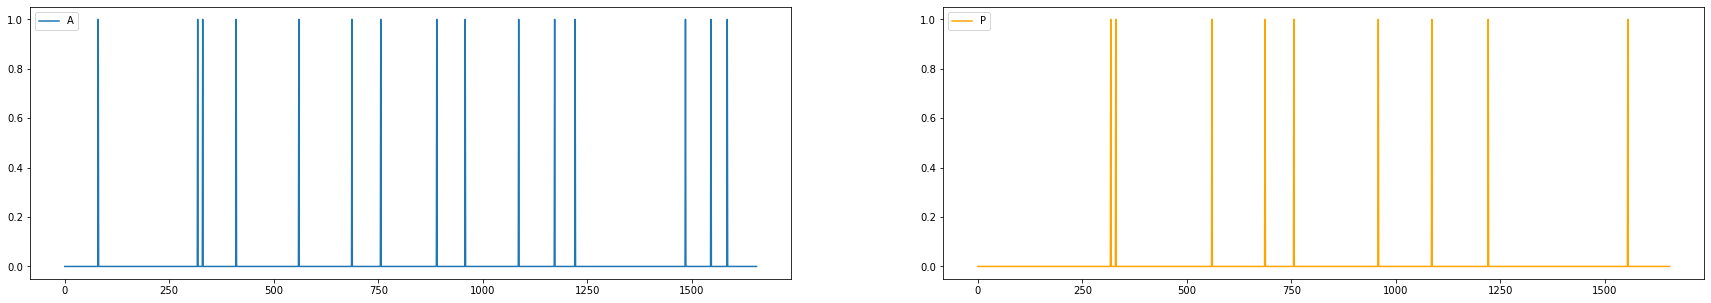

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS72.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS72.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [9.83679895e-06], Max [0.14535716]
Deviation 99.5th pctile [0.13610956]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1639    9]
 [   8    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 628425 ms


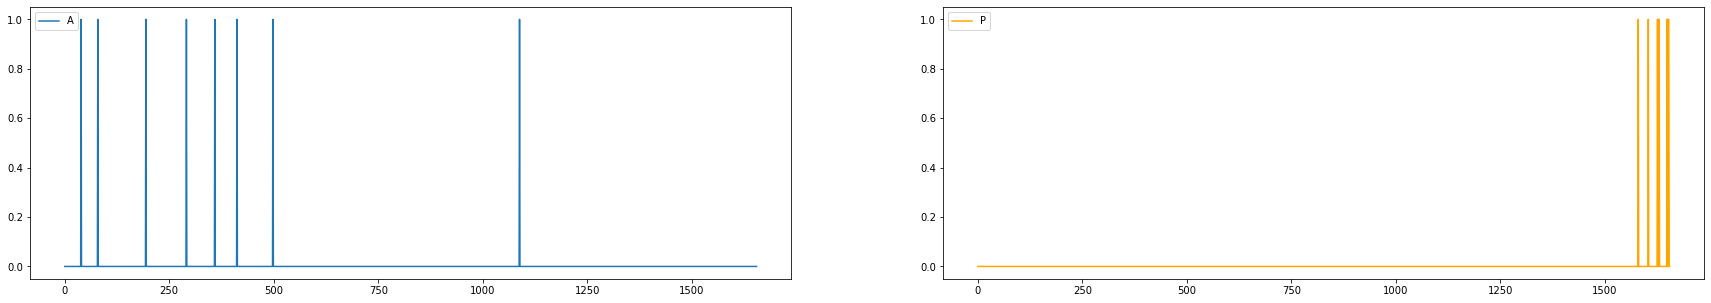

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS73.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS73.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.53023599e-05], Max [0.46703082]
Deviation 99.5th pctile [0.32078469]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 630581 ms


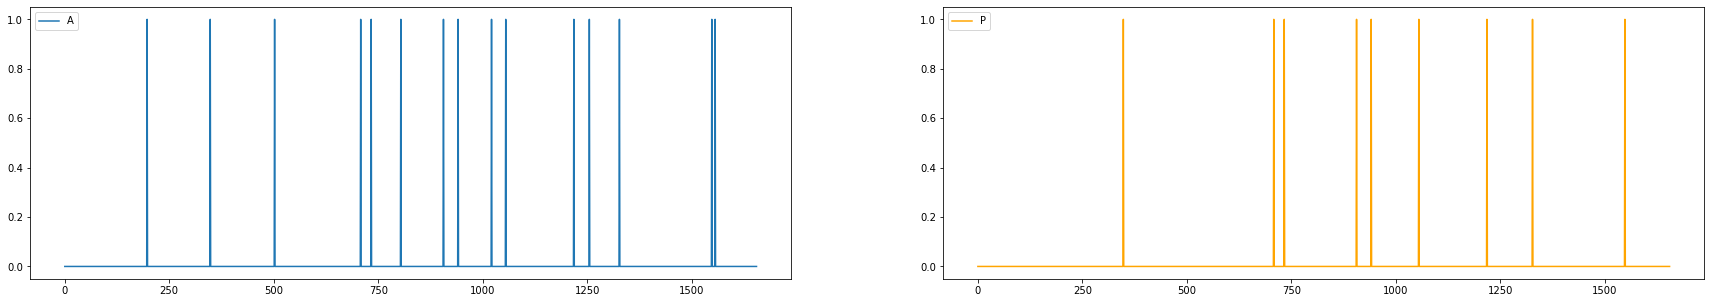

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS74.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS74.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.3793766e-05], Max [0.17078834]
Deviation 99.5th pctile [0.16122939]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1642    8]
 [   5    1]]
precision 0.11111, recall 0.16667, f1 0.13333
Time to predict and get records above deviation : 632168 ms


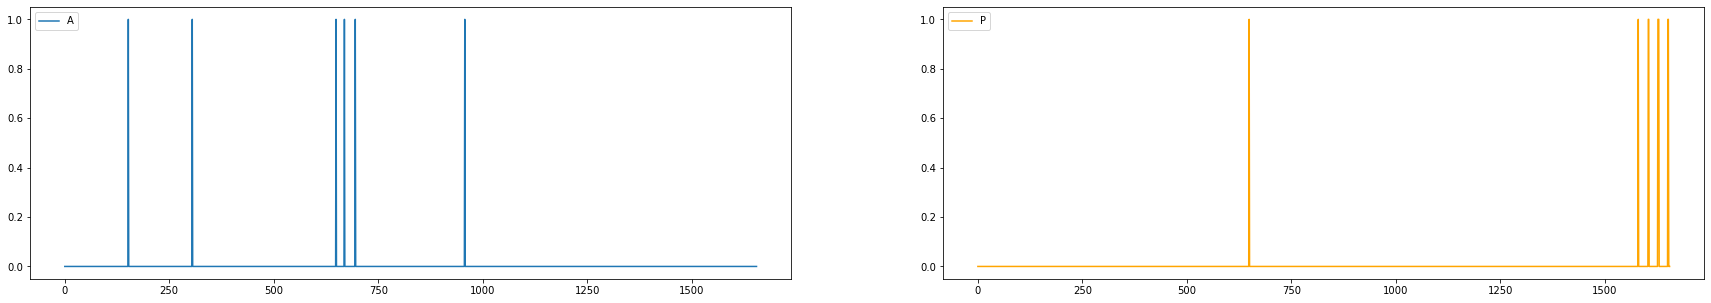

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS75.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS75.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00025617], Max [0.34922189]
Deviation 99.5th pctile [0.26718321]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to predict and get records above deviation : 634793 ms


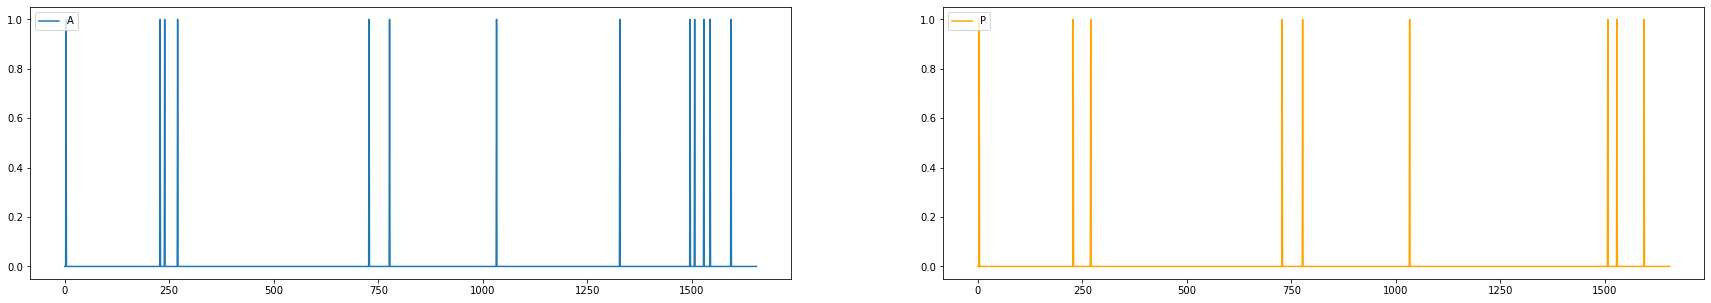

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS76.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS76.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.65649249e-06], Max [0.44866964]
Deviation 99.5th pctile [0.15533589]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 636375 ms


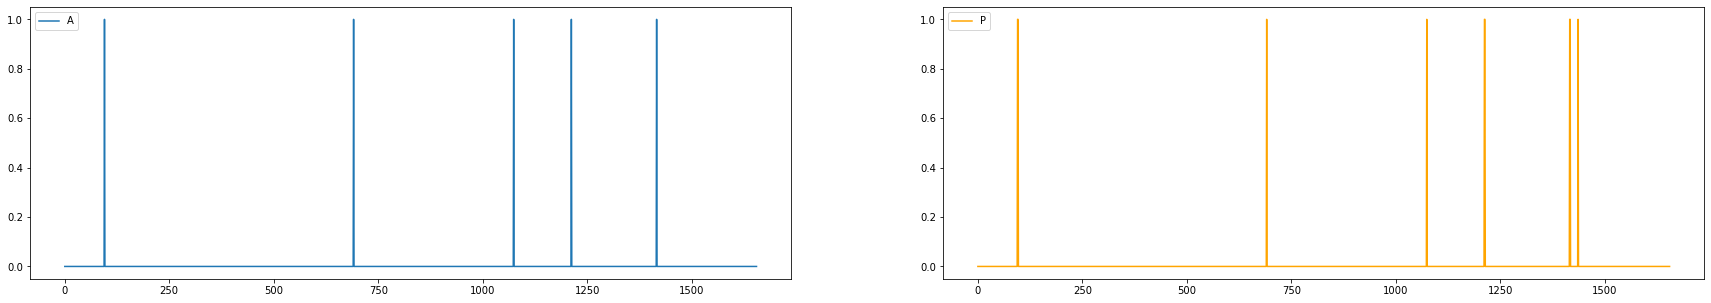

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS77.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS77.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.75367145e-05], Max [0.52790881]
Deviation 99.5th pctile [0.35542138]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 640131 ms


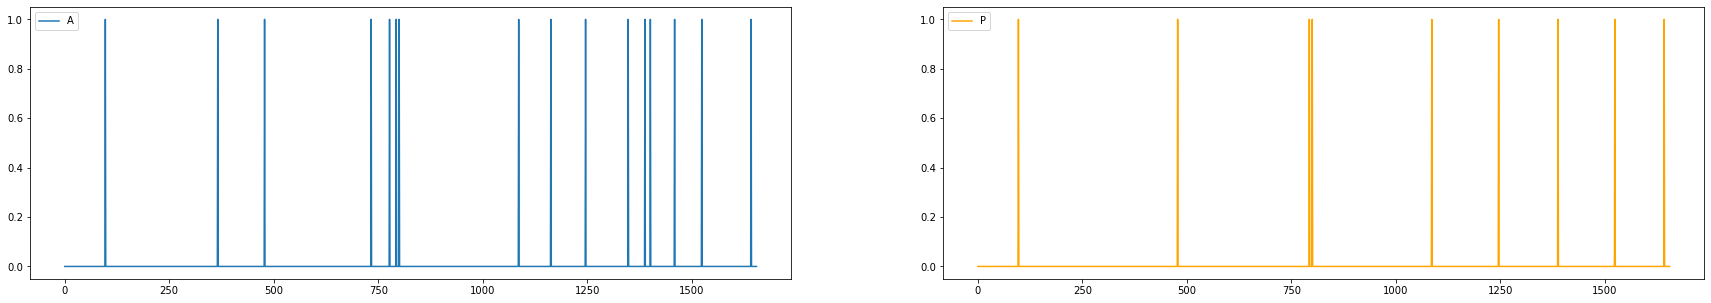

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS78.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS78.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.00417715e-05], Max [0.32127169]
Deviation 99.5th pctile [0.19108027]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 641985 ms


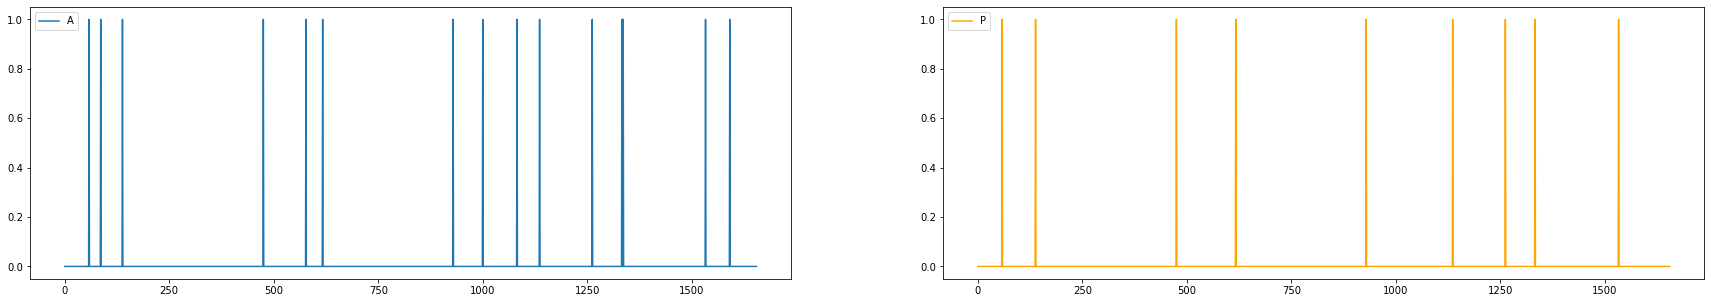

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS79.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS79.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.98160172e-05], Max [0.3724721]
Deviation 99.5th pctile [0.16453387]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 644420 ms


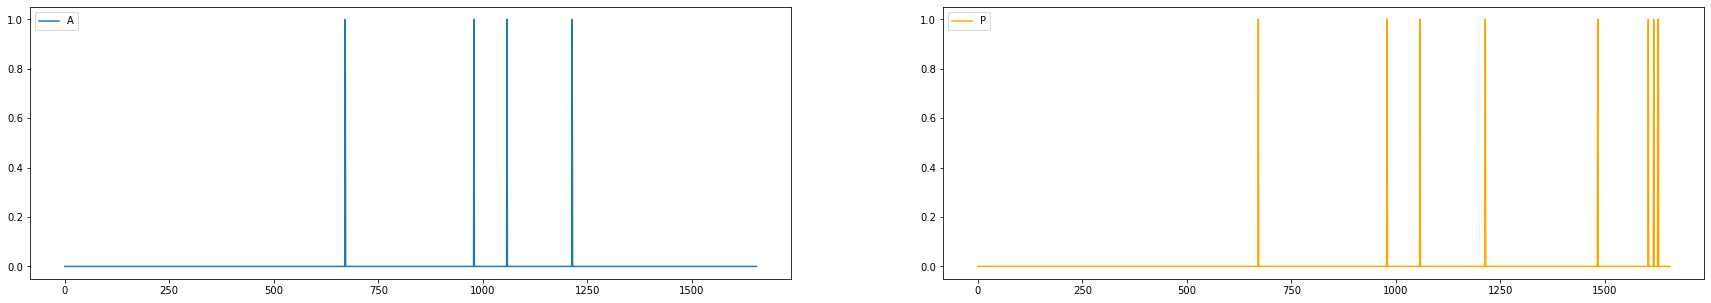

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS8.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS8.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.98611655e-05], Max [0.30452091]
Deviation 99.5th pctile [0.2103151]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1645    7]
 [   2    2]]
precision 0.22222, recall 0.50000, f1 0.30769
Time to predict and get records above deviation : 646657 ms


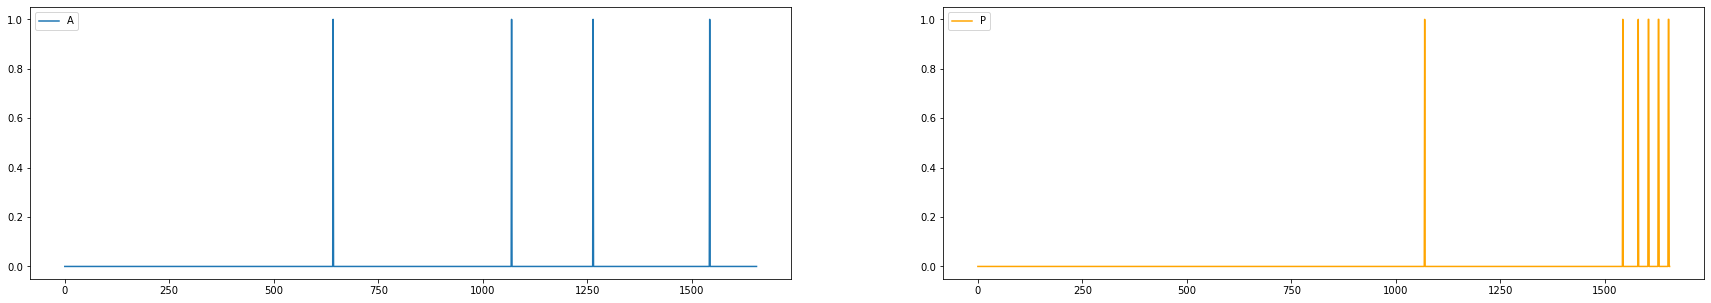

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS80.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS80.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.95850798e-05], Max [0.18383007]
Deviation 99.5th pctile [0.16085096]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1634    9]
 [  13    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 648756 ms


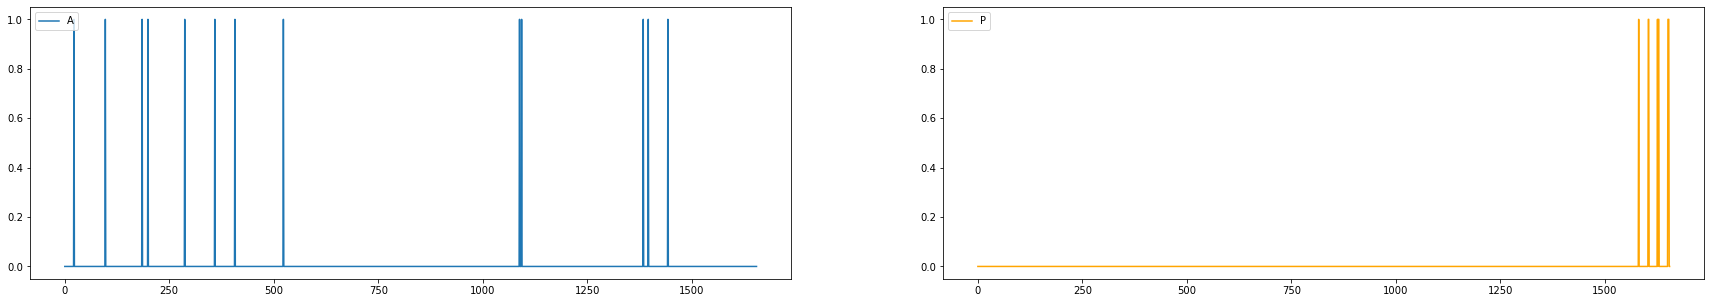

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS81.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS81.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.86731745e-05], Max [0.35413841]
Deviation 99.5th pctile [0.20530013]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 650799 ms


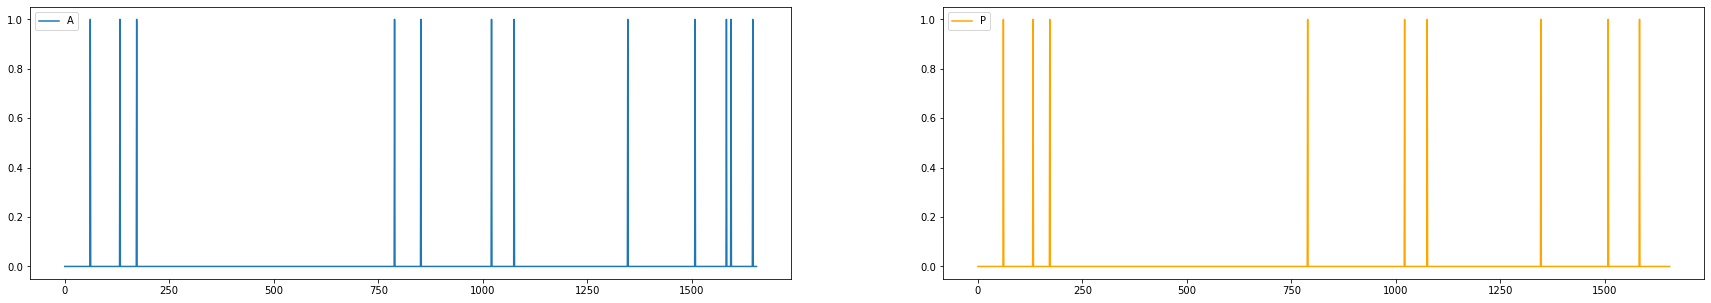

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS82.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS82.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.31677461e-06], Max [0.22181171]
Deviation 99.5th pctile [0.15538921]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1643    6]
 [   4    3]]
precision 0.33333, recall 0.42857, f1 0.37500
Time to predict and get records above deviation : 652726 ms


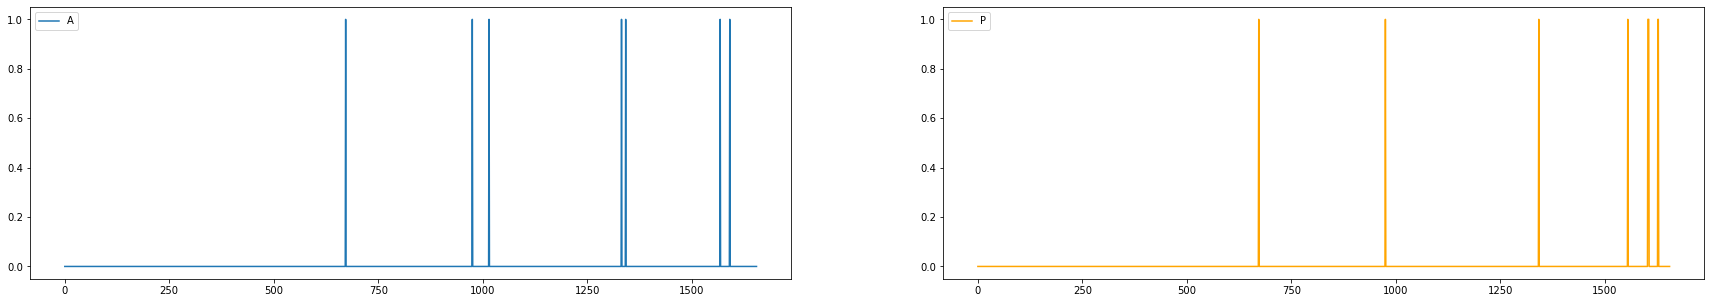

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS83.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS83.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.64025669e-05], Max [0.41238642]
Deviation 99.5th pctile [0.29991225]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 654550 ms


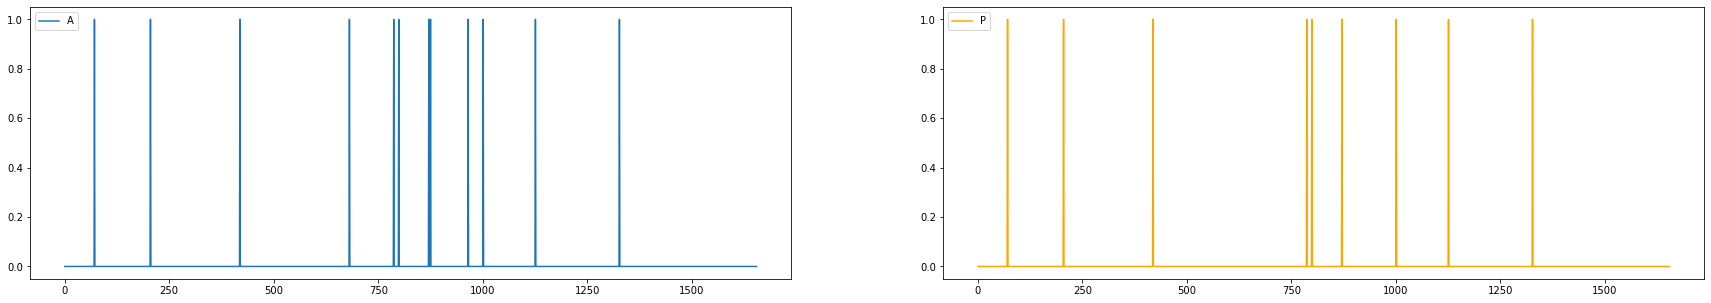

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS84.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS84.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.93396094e-05], Max [0.2387253]
Deviation 99.5th pctile [0.21607773]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1643    8]
 [   4    1]]
precision 0.11111, recall 0.20000, f1 0.14286
Time to predict and get records above deviation : 658994 ms


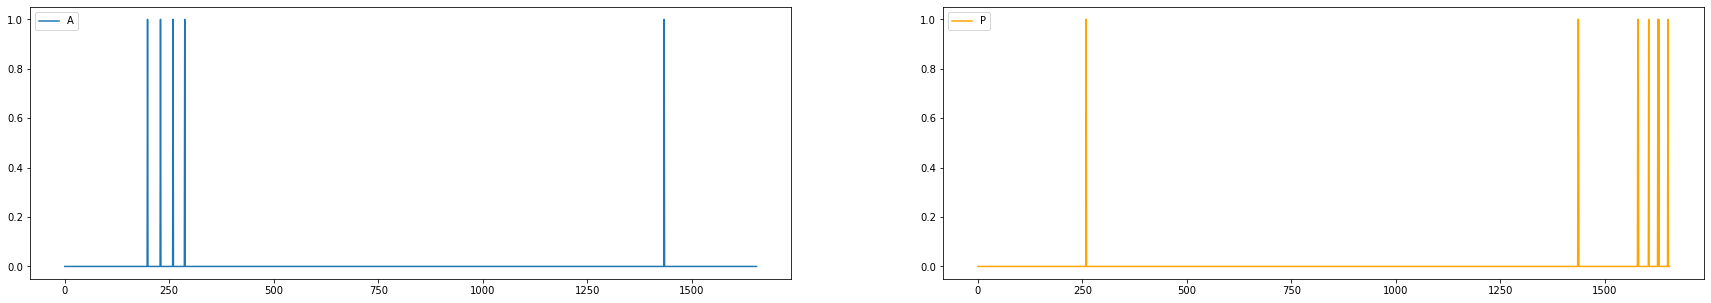

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS85.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS85.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.79985866e-06], Max [0.49303699]
Deviation 99.5th pctile [0.20268317]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 661559 ms


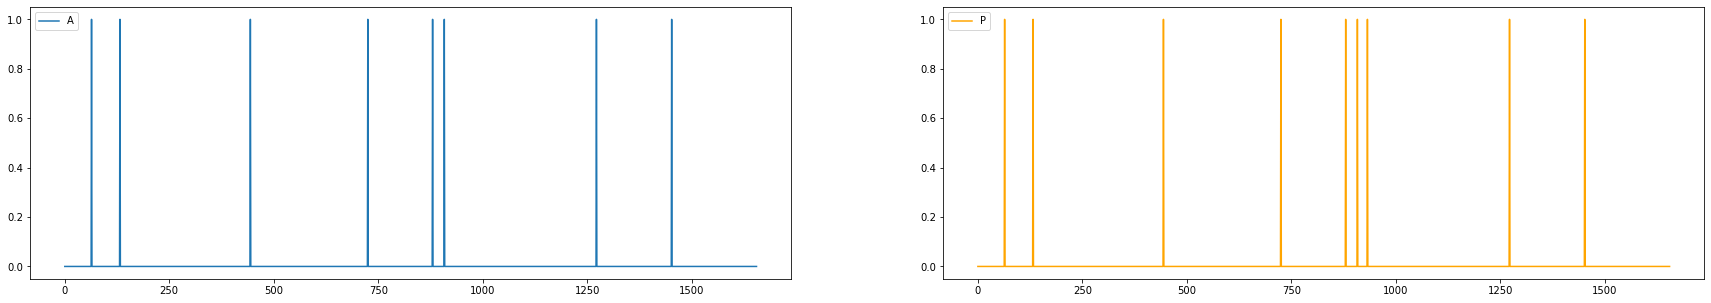

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS86.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS86.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.45501689e-06], Max [0.42124891]
Deviation 99.5th pctile [0.36923267]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to predict and get records above deviation : 664266 ms


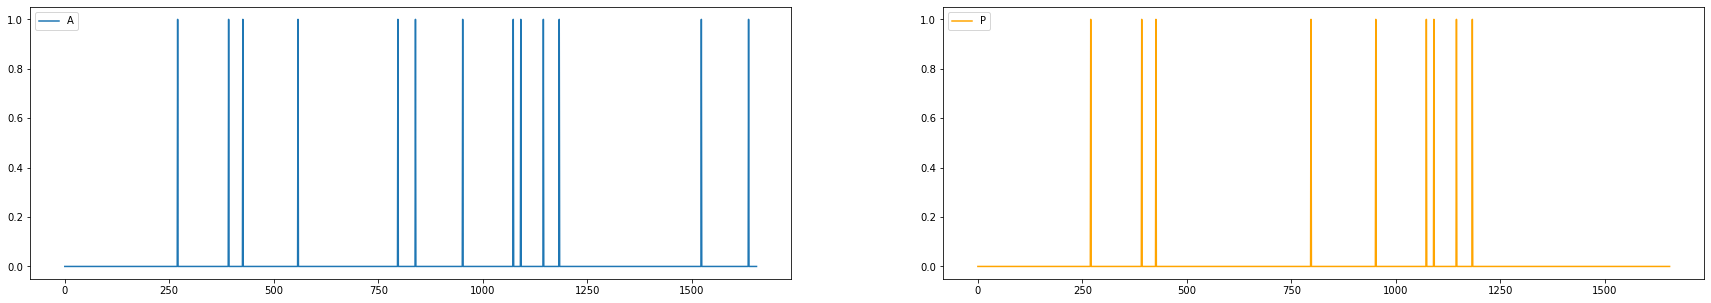

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS87.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS87.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.91822753e-05], Max [0.43374138]
Deviation 99.5th pctile [0.26744231]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1646    3]
 [   1    6]]
precision 0.66667, recall 0.85714, f1 0.75000
Time to predict and get records above deviation : 666796 ms


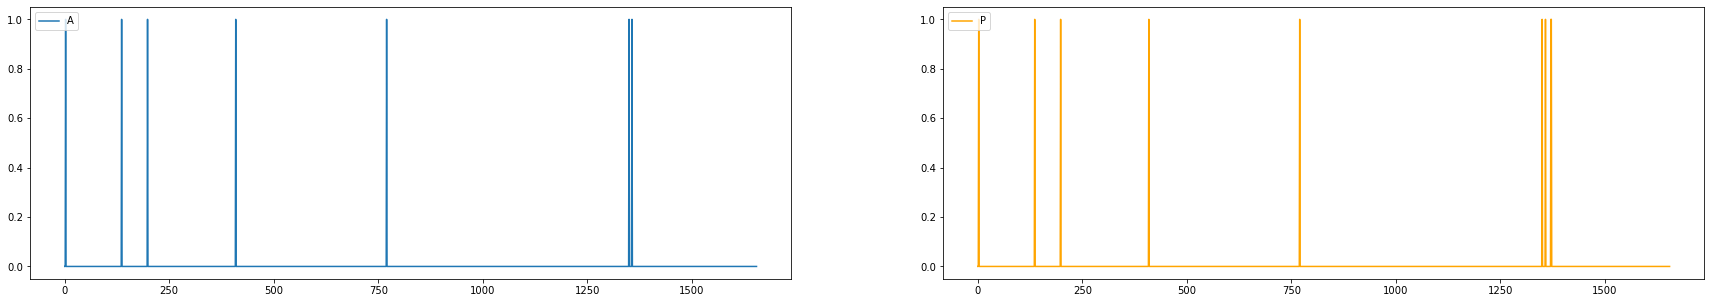

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS88.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS88.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.32157701e-05], Max [0.37682137]
Deviation 99.5th pctile [0.29758295]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 671166 ms


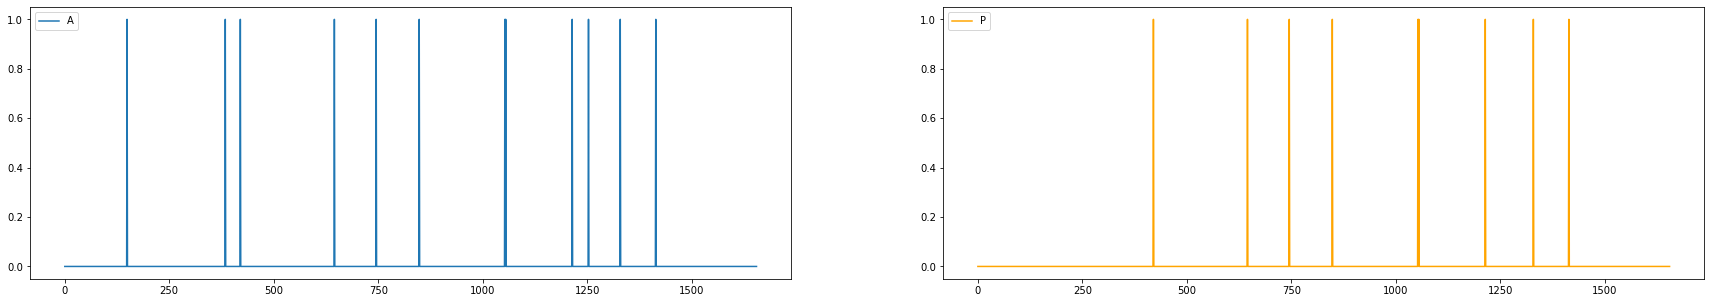

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS89.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS89.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.39904743e-05], Max [0.324085]
Deviation 99.5th pctile [0.19293809]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 674069 ms


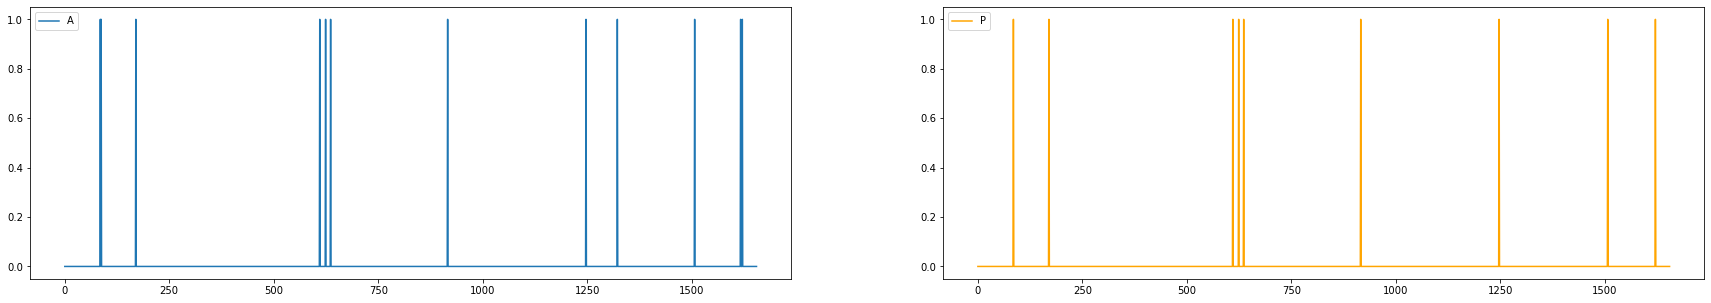

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS9.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS9.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.13924369e-06], Max [0.39005753]
Deviation 99.5th pctile [0.26088407]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1646    0]
 [   1    9]]
precision 1.00000, recall 0.90000, f1 0.94737
Time to predict and get records above deviation : 676556 ms


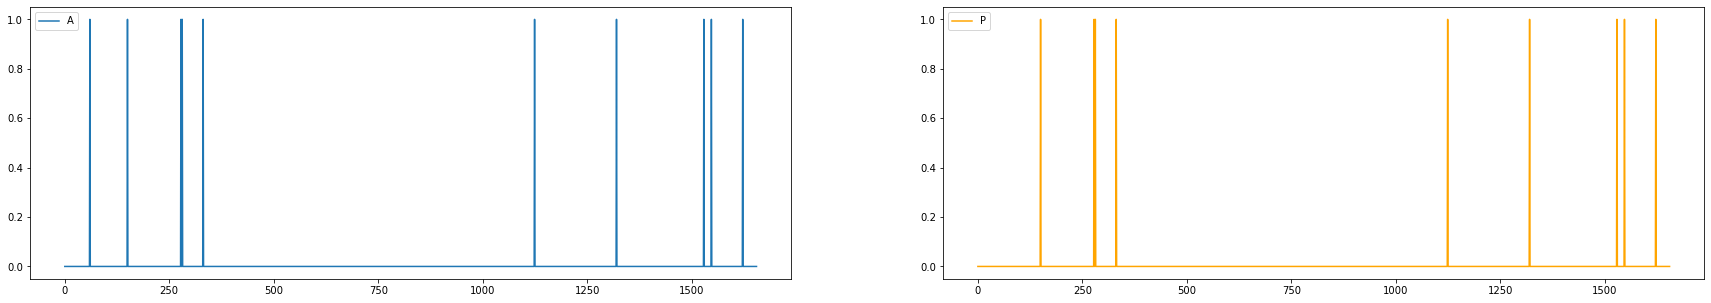

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS90.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS90.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.12247347e-05], Max [0.2457086]
Deviation 99.5th pctile [0.14750579]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1646    0]
 [   1    9]]
precision 1.00000, recall 0.90000, f1 0.94737
Time to predict and get records above deviation : 679233 ms


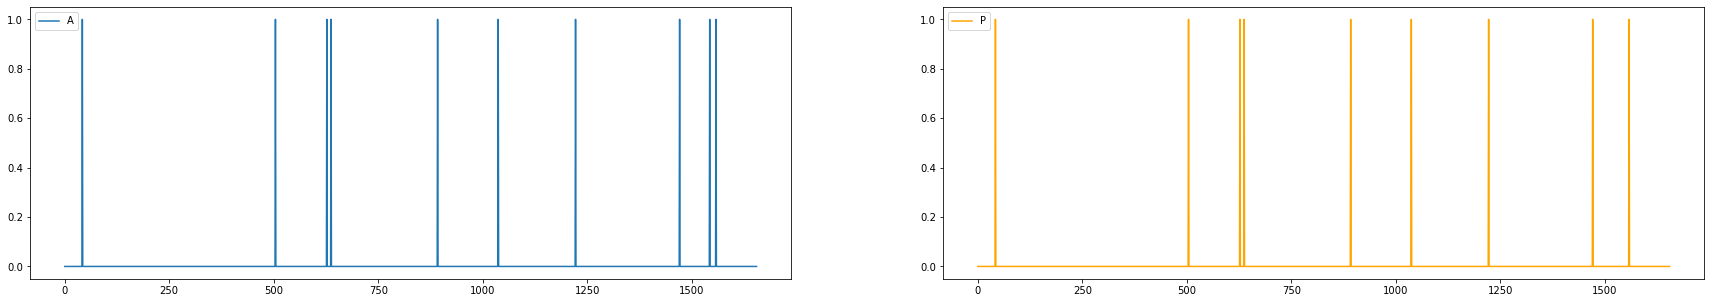

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS91.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS91.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.00514784e-05], Max [0.39170659]
Deviation 99.5th pctile [0.12957722]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 681515 ms


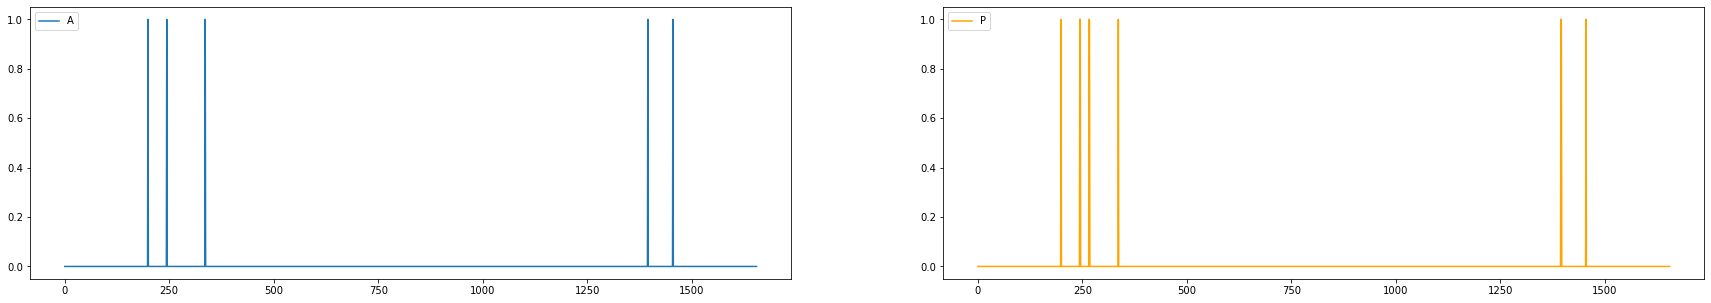

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS92.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS92.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.48302539e-05], Max [0.37317713]
Deviation 99.5th pctile [0.22956494]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 684978 ms


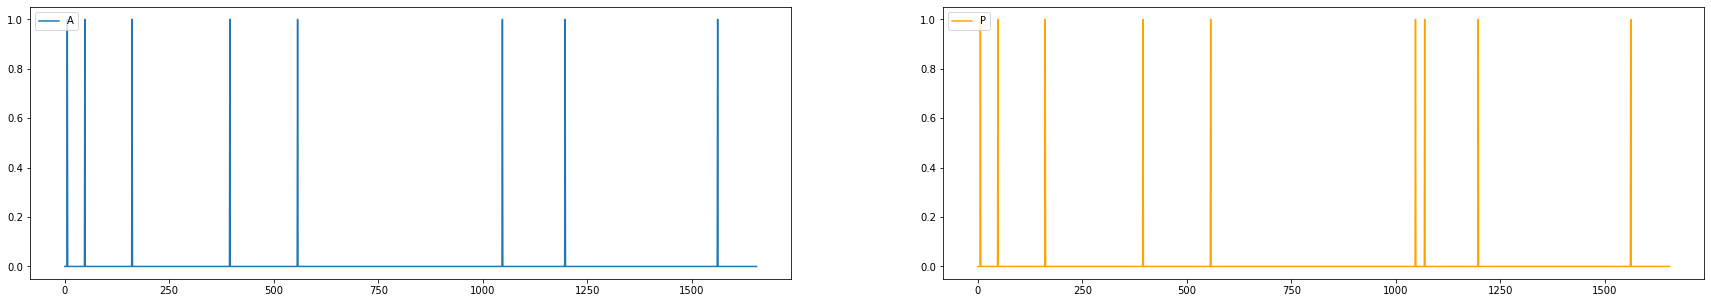

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS93.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS93.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.30048042e-05], Max [0.45846977]
Deviation 99.5th pctile [0.3966622]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 687424 ms


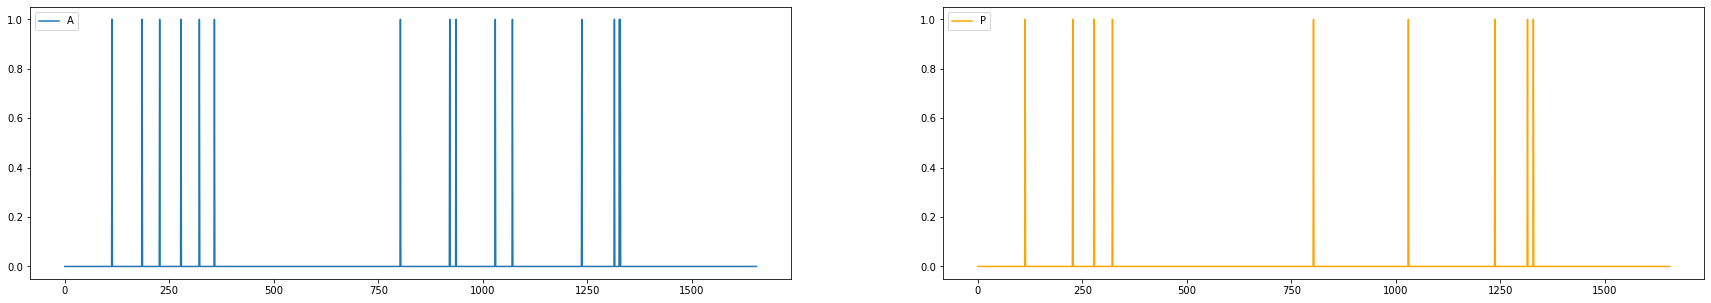

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS94.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS94.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.97886213e-06], Max [0.34161292]
Deviation 99.5th pctile [0.07883705]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1647    6]
 [   0    3]]
precision 0.33333, recall 1.00000, f1 0.50000
Time to predict and get records above deviation : 689672 ms


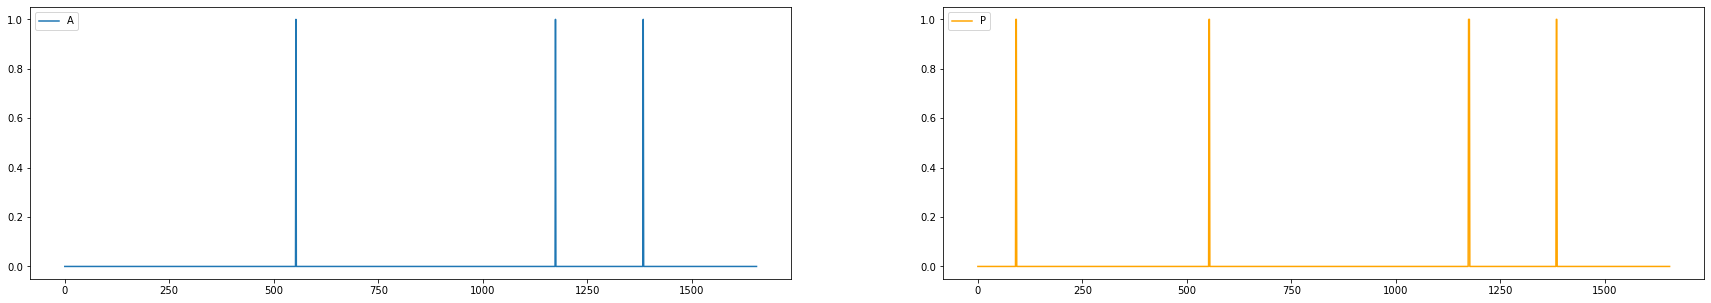

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS95.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS95.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.35717596e-05], Max [0.17515561]
Deviation 99.5th pctile [0.1596158]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1631    9]
 [  16    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 691352 ms


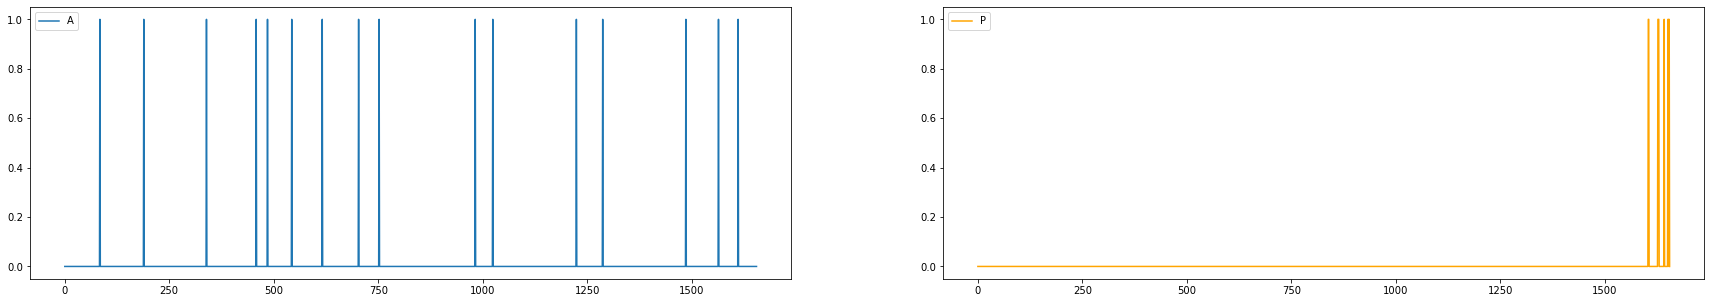

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS96.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS96.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.64502175e-05], Max [0.2885626]
Deviation 99.5th pctile [0.16548787]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1646    5]
 [   1    4]]
precision 0.44444, recall 0.80000, f1 0.57143
Time to predict and get records above deviation : 693103 ms


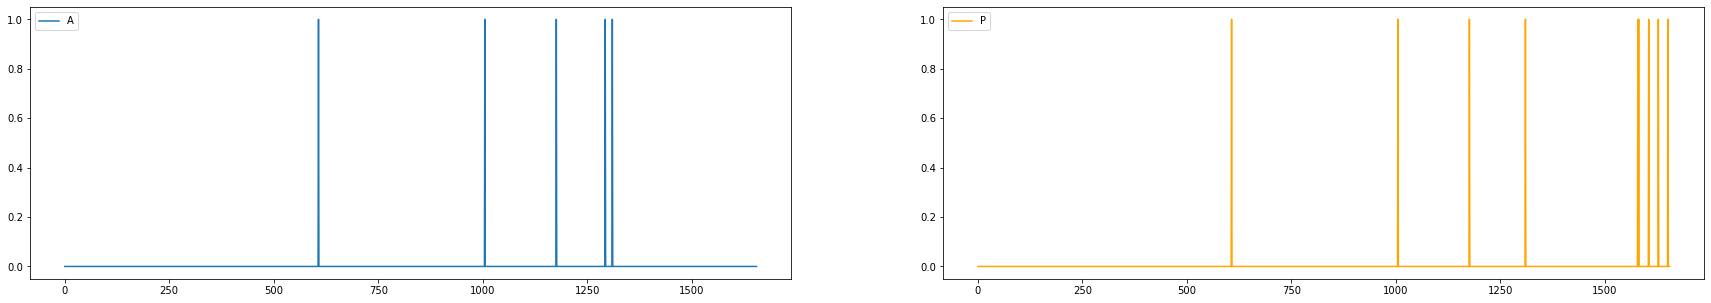

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS97.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS97.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.24156525e-05], Max [0.2976514]
Deviation 99.5th pctile [0.18285316]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1645    2]
 [   2    7]]
precision 0.77778, recall 0.77778, f1 0.77778
Time to predict and get records above deviation : 695409 ms


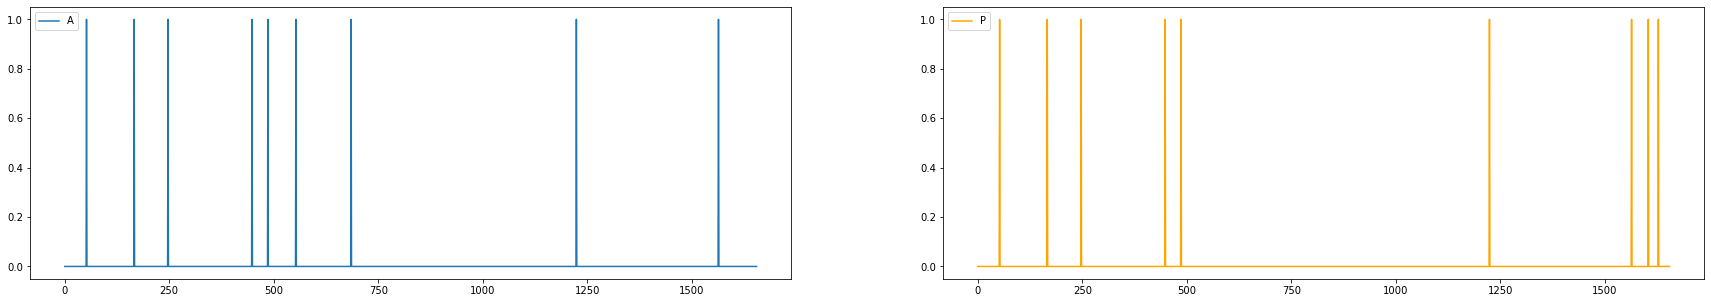

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS98.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS98.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.10298344e-05], Max [0.31951293]
Deviation 99.5th pctile [0.19893716]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1643    1]
 [   4    8]]
precision 0.88889, recall 0.66667, f1 0.76190
Time to predict and get records above deviation : 697430 ms


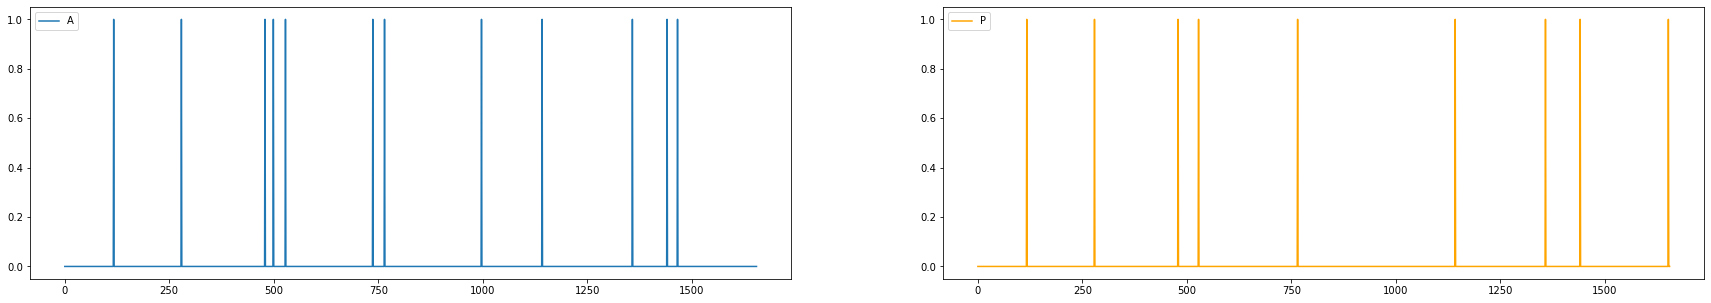

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS99.csv
Model file will be loaded from  models-yahoo-lstm/A3Benchmark/A3Benchmark-TS99.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.30253885e-06], Max [0.23420045]
Deviation 99.5th pctile [0.1737749]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1639    6]
 [   8    3]]
precision 0.33333, recall 0.27273, f1 0.30000
Time to predict and get records above deviation : 699810 ms


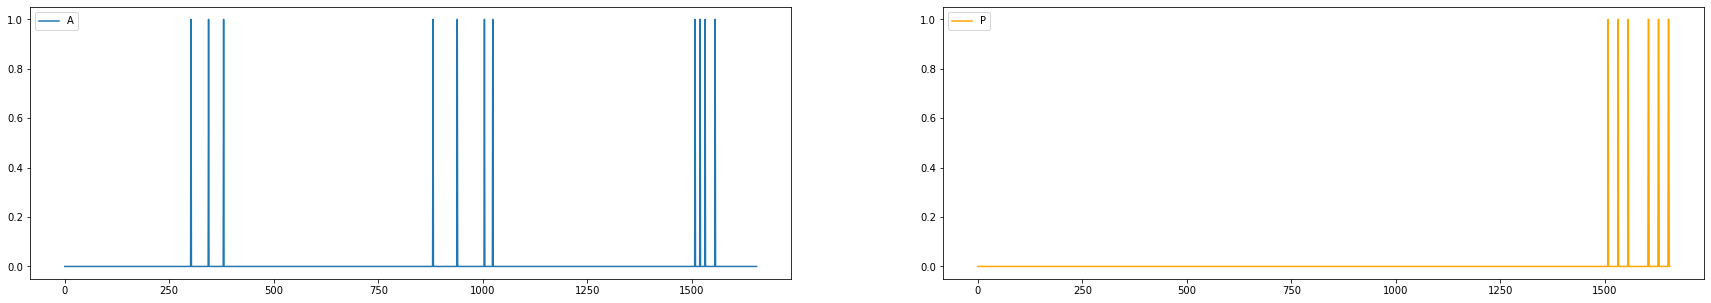

Processing 100 files in folder A4Benchmark
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS1.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS1.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.6096478e-05], Max [0.33537799]
Deviation 99.5th pctile [0.17173421]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1639    4]
 [   8    5]]
precision 0.55556, recall 0.38462, f1 0.45455
Time to predict and get records above deviation : 702282 ms


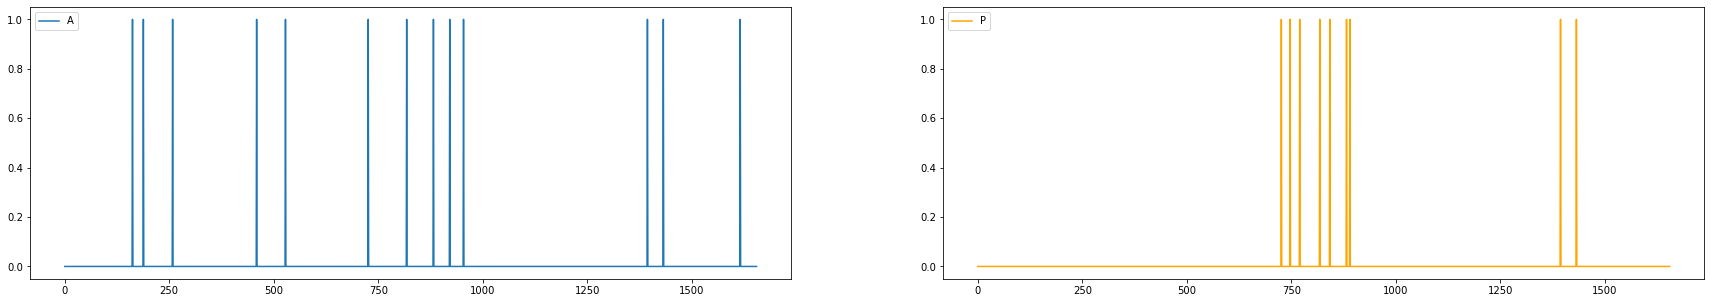

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS10.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS10.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.97416896e-05], Max [0.48089349]
Deviation 99.5th pctile [0.2157639]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 704258 ms


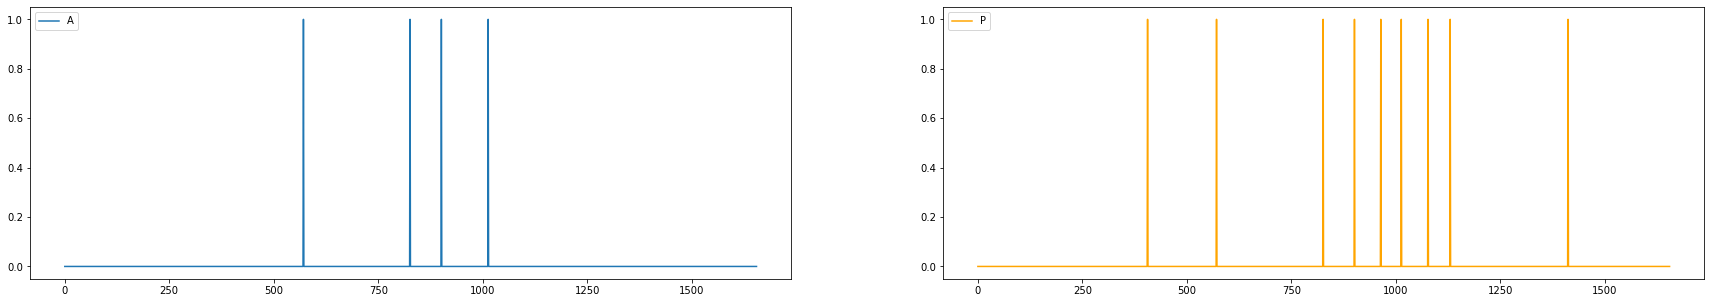

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS100.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS100.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00011745], Max [0.2291623]
Deviation 99.5th pctile [0.19853252]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1642    7]
 [   5    2]]
precision 0.22222, recall 0.28571, f1 0.25000
Time to predict and get records above deviation : 706189 ms


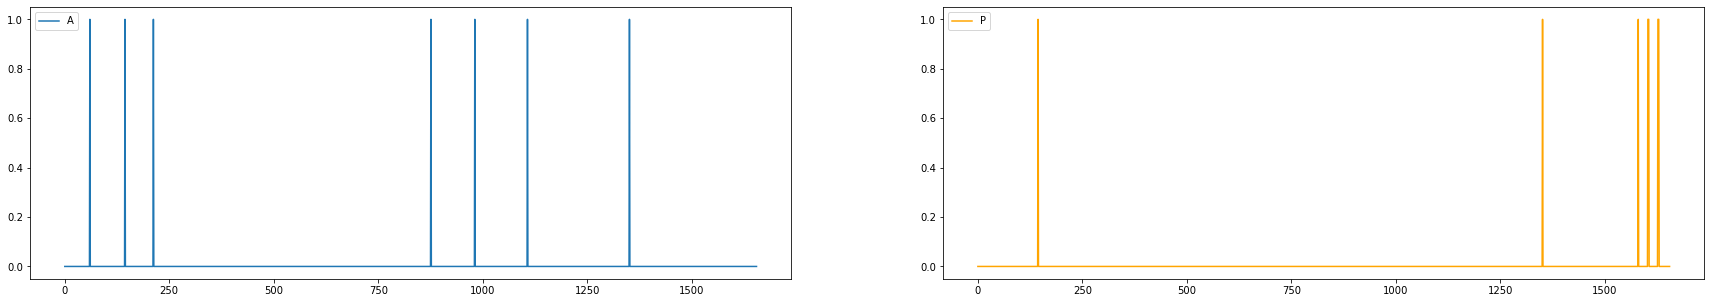

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS11.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS11.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.16890368e-05], Max [0.29481814]
Deviation 99.5th pctile [0.12670299]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1645    6]
 [   2    3]]
precision 0.33333, recall 0.60000, f1 0.42857
Time to predict and get records above deviation : 708033 ms


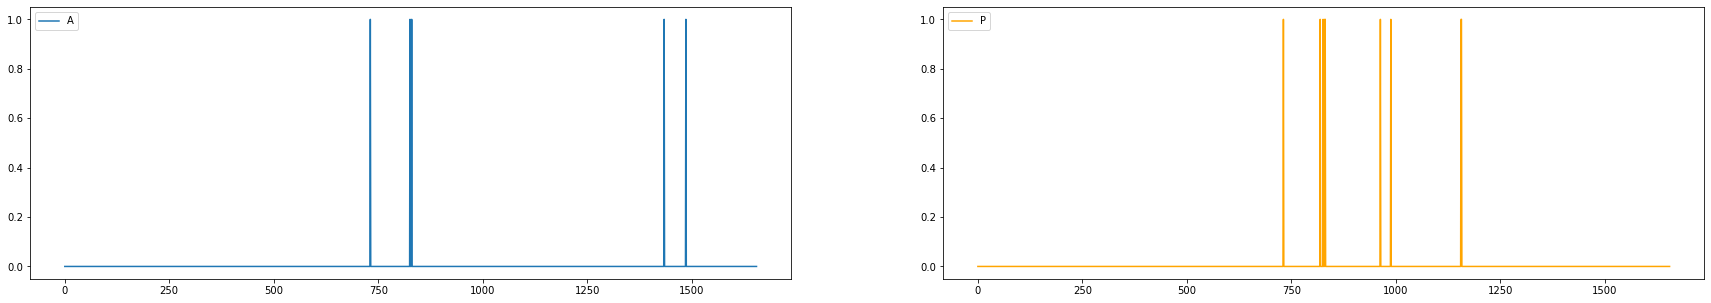

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS12.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS12.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.0412304e-05], Max [0.28553643]
Deviation 99.5th pctile [0.25101619]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1643    8]
 [   4    1]]
precision 0.11111, recall 0.20000, f1 0.14286
Time to predict and get records above deviation : 710367 ms


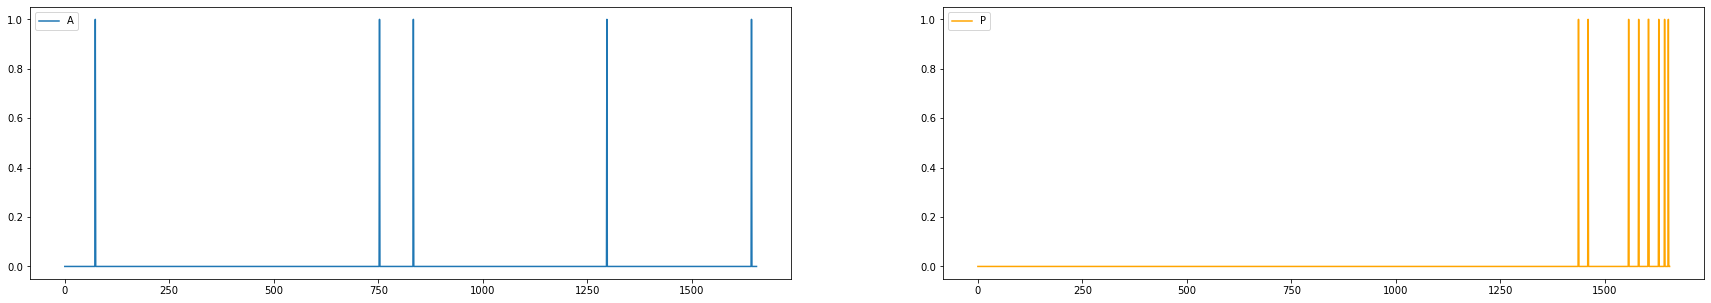

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS13.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS13.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.21651025e-06], Max [0.33949184]
Deviation 99.5th pctile [0.22060012]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1641    2]
 [   6    7]]
precision 0.77778, recall 0.53846, f1 0.63636
Time to predict and get records above deviation : 715269 ms


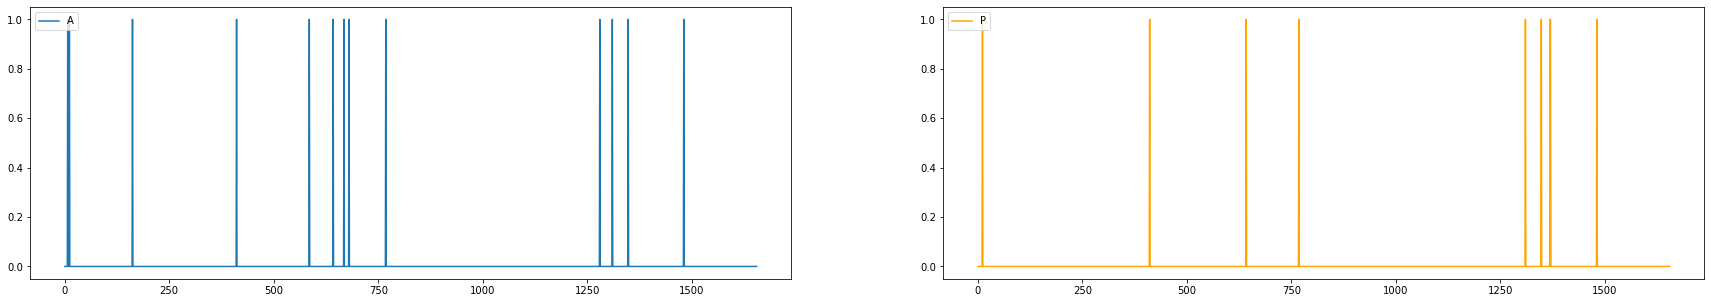

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS14.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS14.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.50599012e-05], Max [0.6772849]
Deviation 99.5th pctile [0.28308773]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1642    3]
 [   5    6]]
precision 0.66667, recall 0.54545, f1 0.60000
Time to predict and get records above deviation : 720188 ms


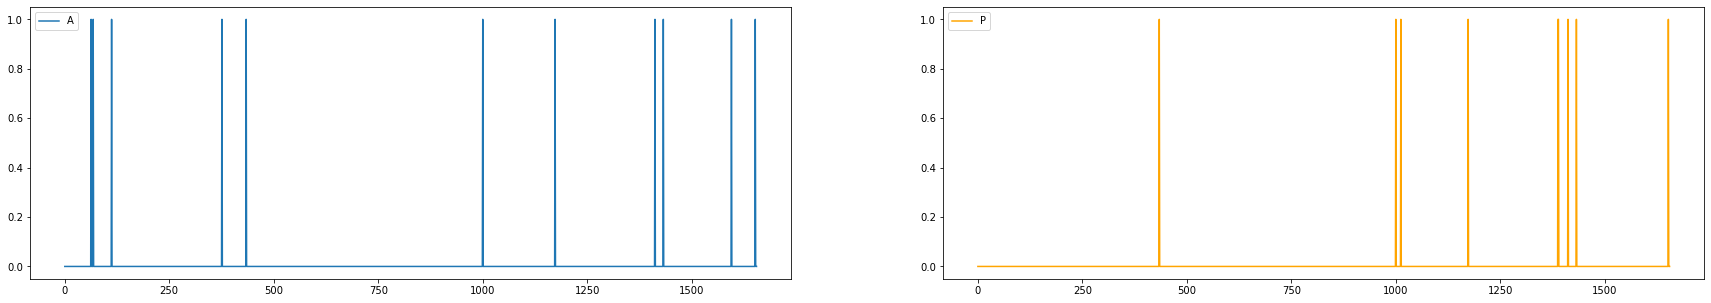

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS15.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS15.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.41123846e-05], Max [0.40736941]
Deviation 99.5th pctile [0.26258129]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1647    0]
 [   0    9]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 723745 ms


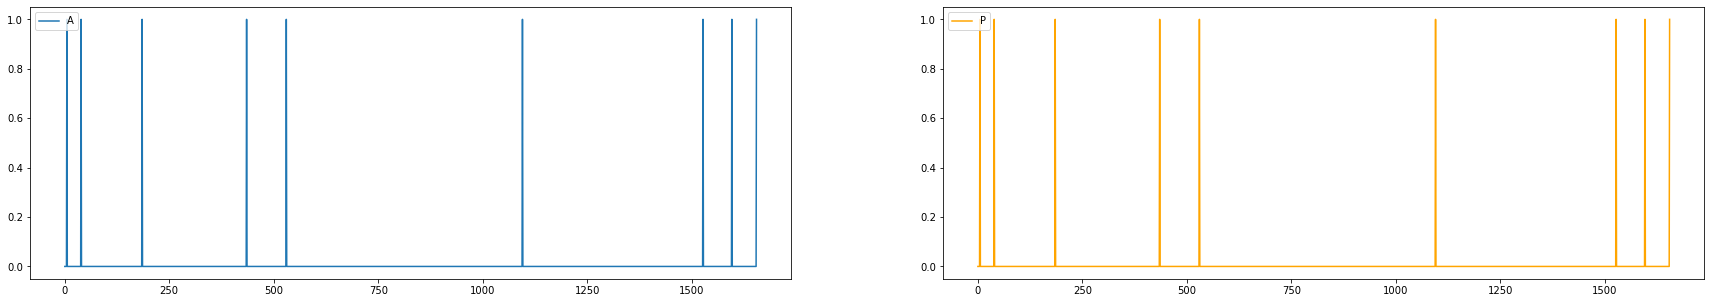

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS16.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS16.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.50614805e-05], Max [0.50470594]
Deviation 99.5th pctile [0.09482102]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 726724 ms


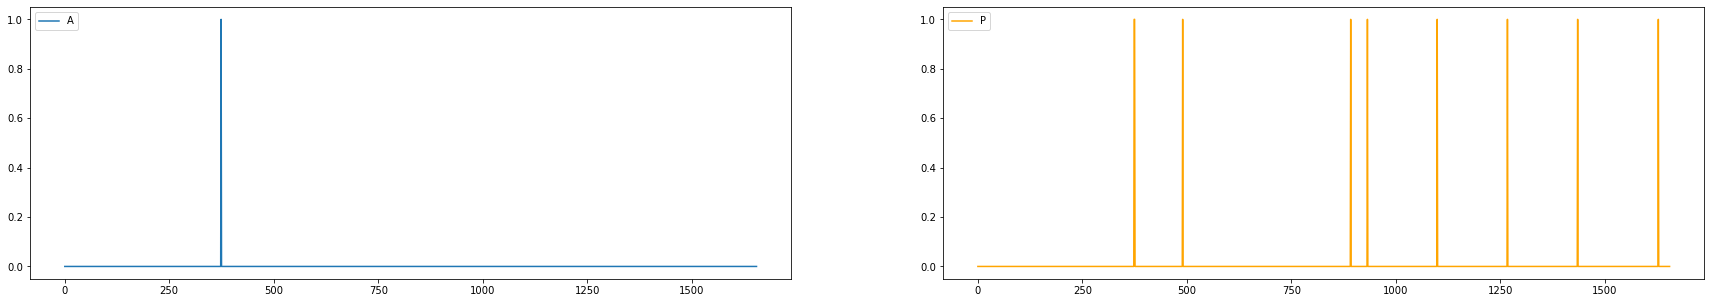

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS17.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS17.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.25165743e-06], Max [0.39993111]
Deviation 99.5th pctile [0.18979882]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1647    0]
 [   0    9]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 729095 ms


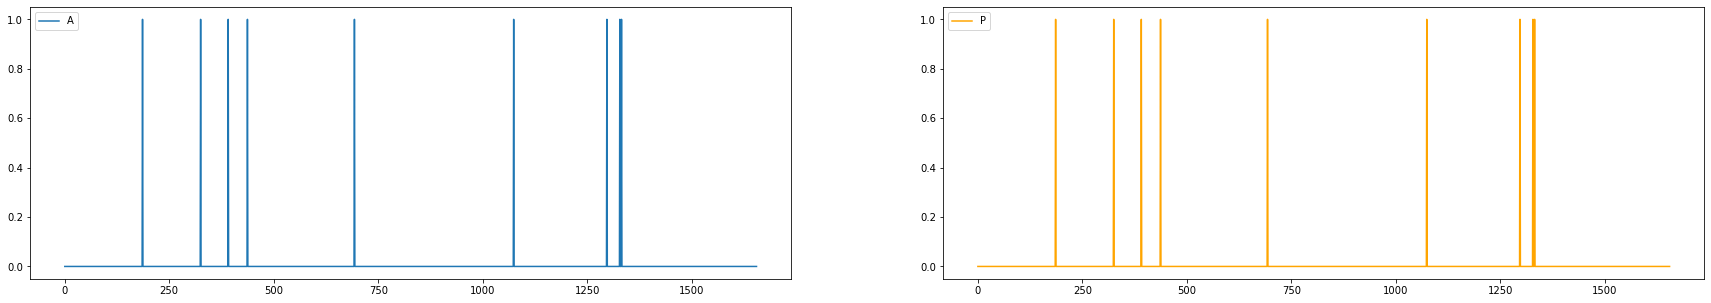

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS18.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS18.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.02361705e-06], Max [0.2852065]
Deviation 99.5th pctile [0.23115311]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1646    9]
 [   1    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 731453 ms


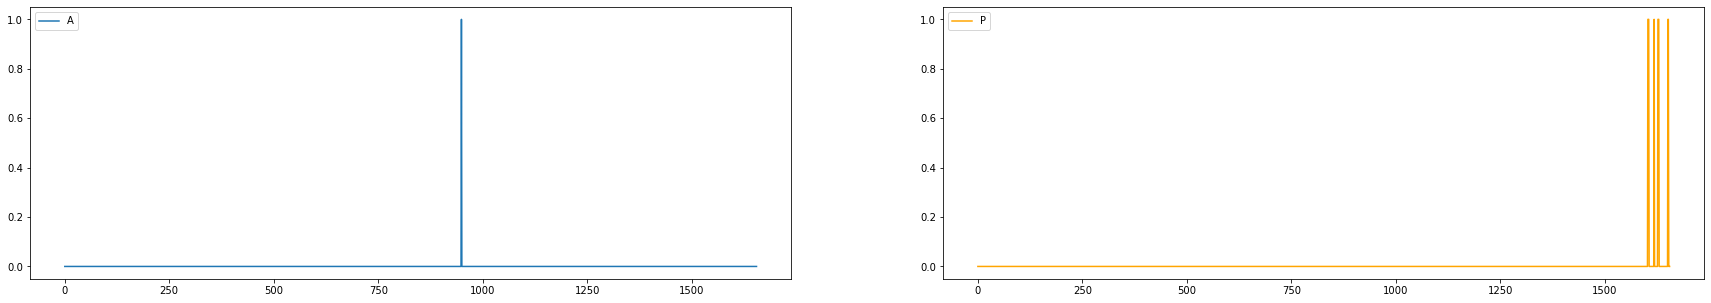

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS19.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS19.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.68411238e-06], Max [0.34251162]
Deviation 99.5th pctile [0.23507914]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1638    6]
 [   9    3]]
precision 0.33333, recall 0.25000, f1 0.28571
Time to predict and get records above deviation : 735549 ms


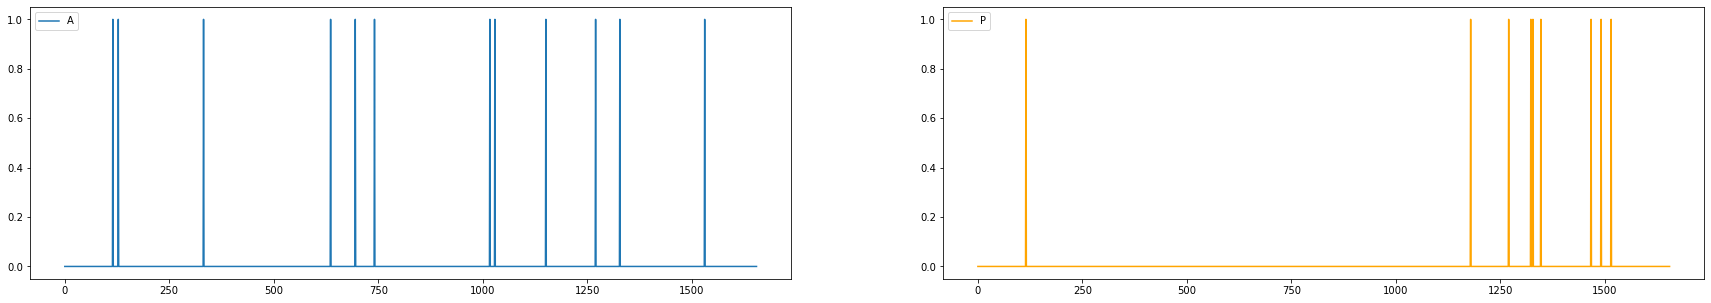

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS2.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS2.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.46229261e-05], Max [0.17295199]
Deviation 99.5th pctile [0.10130072]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1645    6]
 [   2    3]]
precision 0.33333, recall 0.60000, f1 0.42857
Time to predict and get records above deviation : 738763 ms


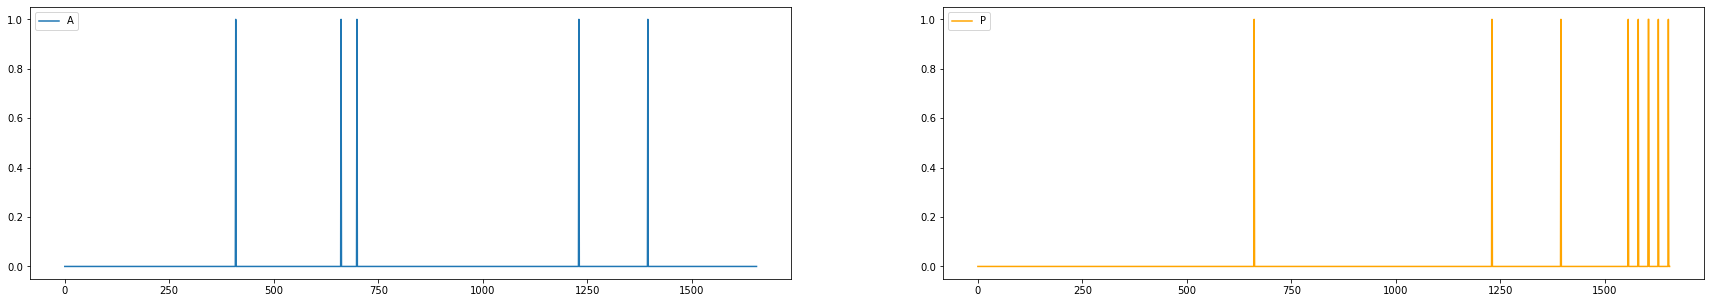

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS20.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS20.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00016073], Max [0.45972565]
Deviation 99.5th pctile [0.28461578]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to predict and get records above deviation : 740777 ms


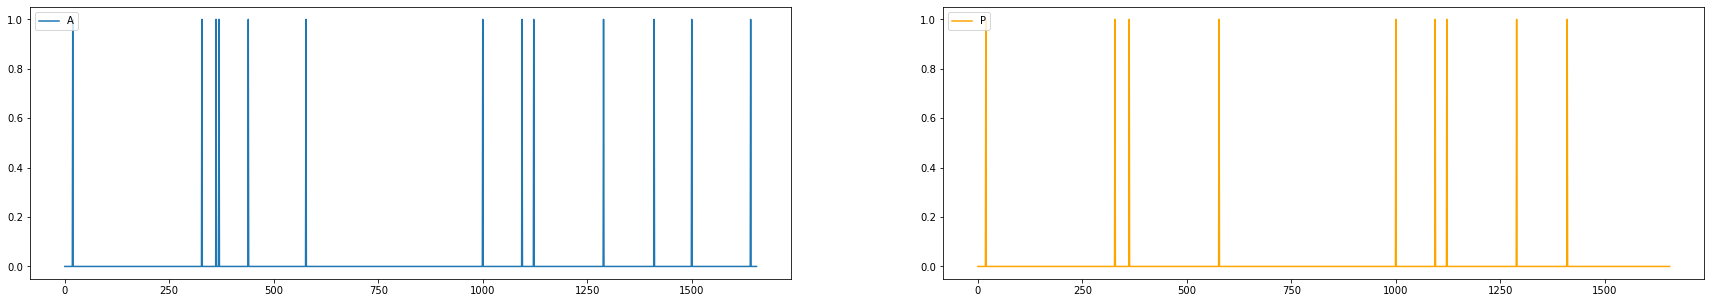

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS21.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS21.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.67911306e-05], Max [0.17742748]
Deviation 99.5th pctile [0.13285918]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1638    5]
 [   9    4]]
precision 0.44444, recall 0.30769, f1 0.36364
Time to predict and get records above deviation : 742670 ms


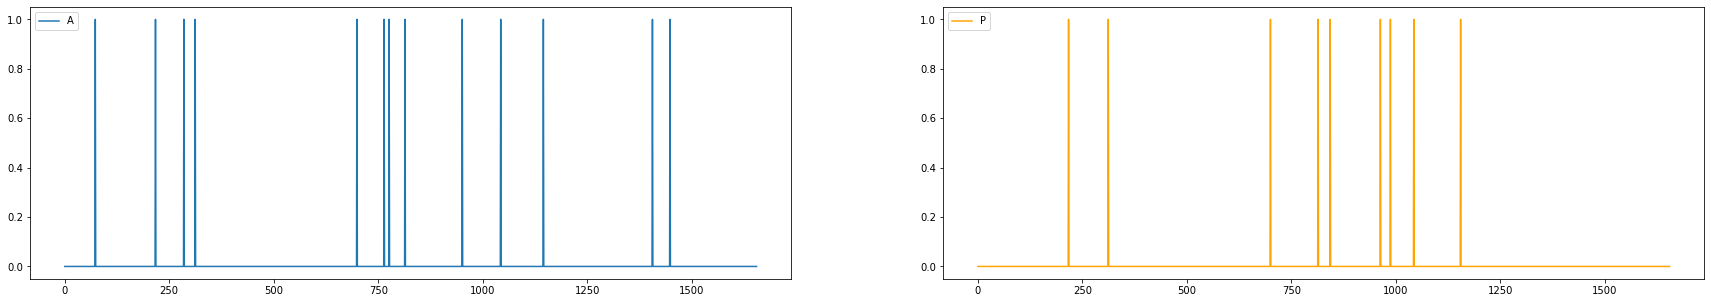

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS22.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS22.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.90454255e-05], Max [0.50642863]
Deviation 99.5th pctile [0.32222182]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1638    8]
 [   9    1]]
precision 0.11111, recall 0.10000, f1 0.10526
Time to predict and get records above deviation : 747032 ms


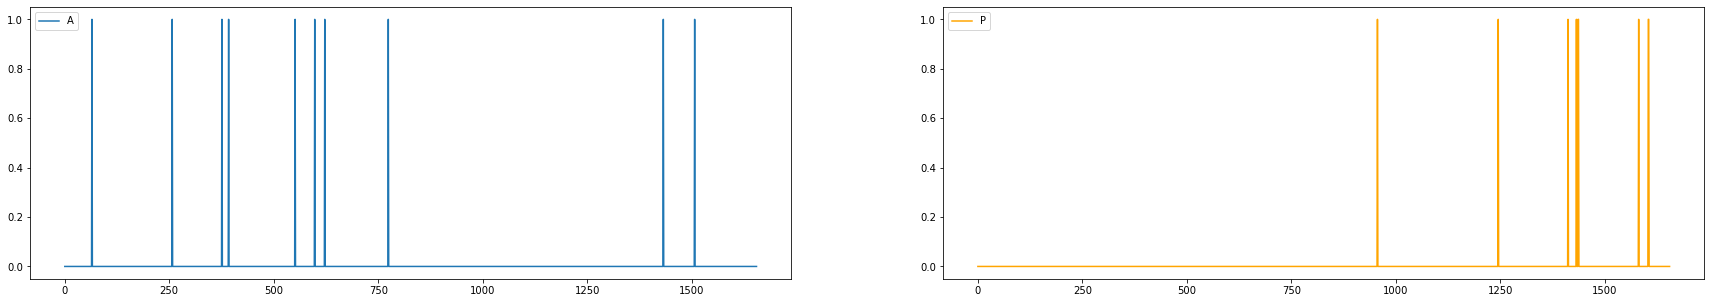

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS23.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS23.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.49281804e-05], Max [0.2806468]
Deviation 99.5th pctile [0.18701876]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 749228 ms


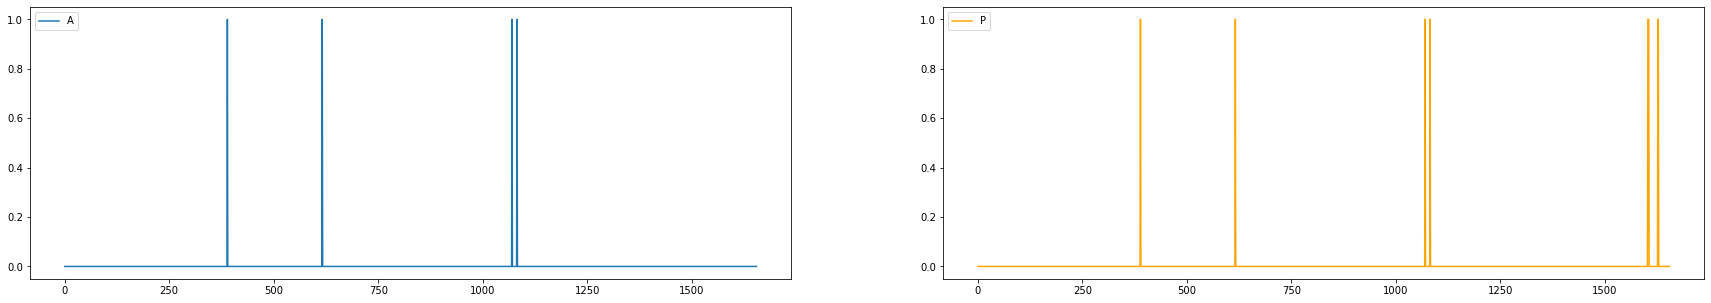

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS24.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS24.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.13511205e-05], Max [0.47232464]
Deviation 99.5th pctile [0.20312818]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1644    3]
 [   3    6]]
precision 0.66667, recall 0.66667, f1 0.66667
Time to predict and get records above deviation : 751192 ms


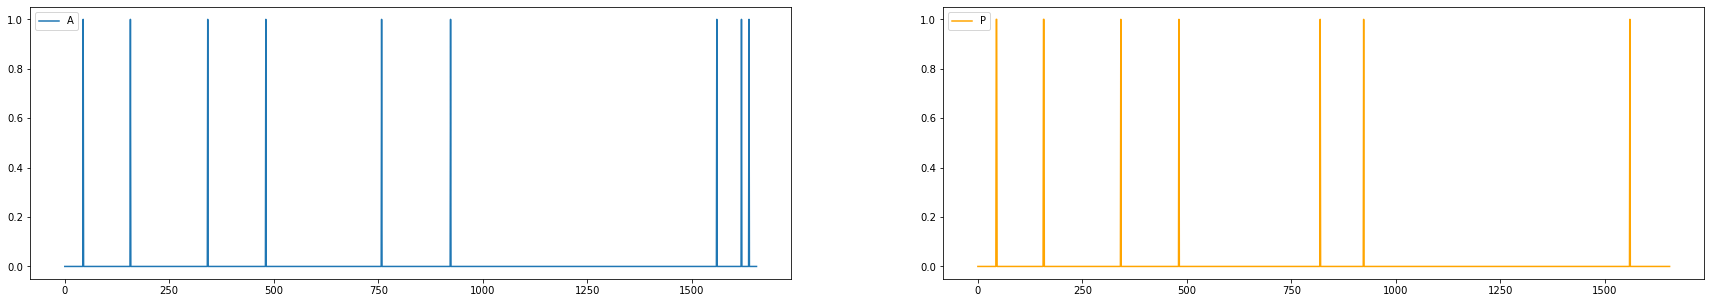

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS25.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS25.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.09036269e-06], Max [1.0985356]
Deviation 99.5th pctile [0.67703446]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1637    9]
 [  10    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 753132 ms


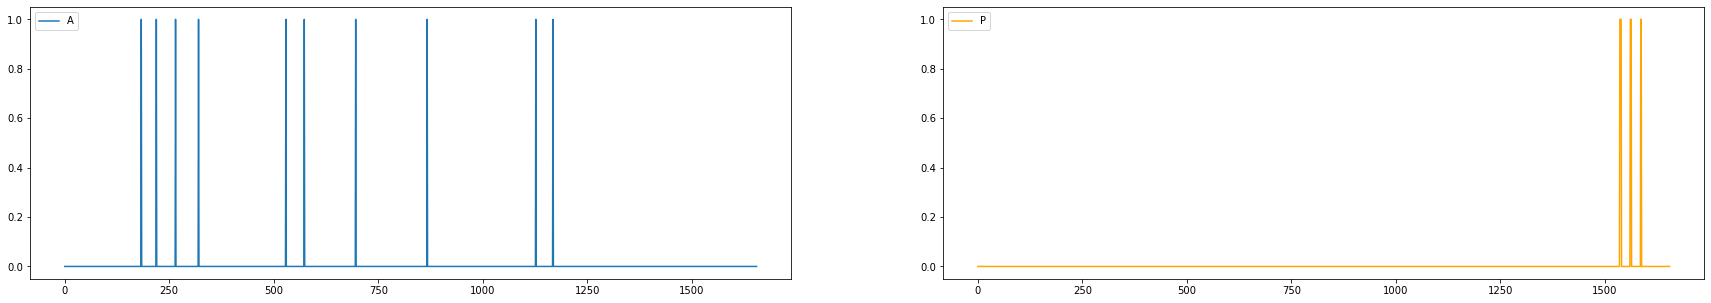

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS26.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS26.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.33266963e-05], Max [0.29997987]
Deviation 99.5th pctile [0.22689346]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1645    9]
 [   2    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 754908 ms


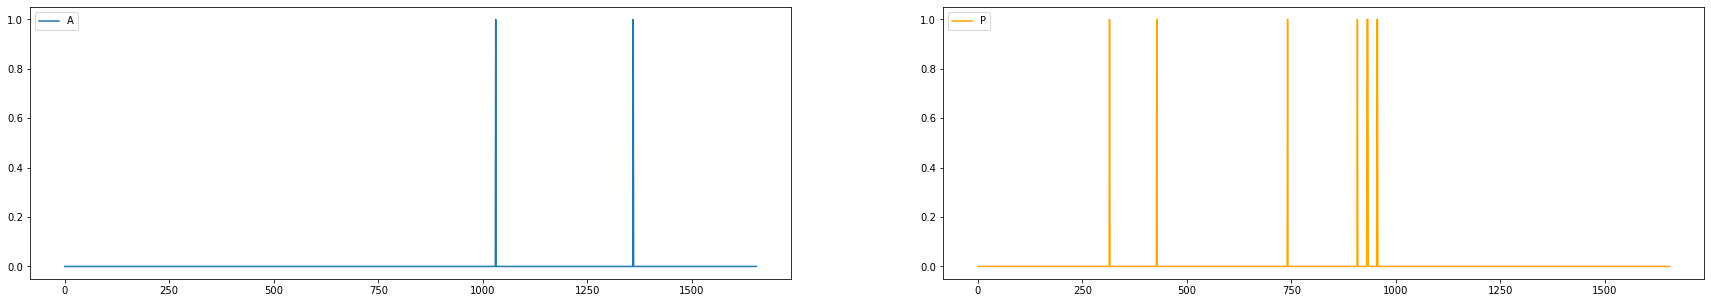

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS27.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS27.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.62156385e-05], Max [0.45715693]
Deviation 99.5th pctile [0.19354444]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1638    3]
 [   9    6]]
precision 0.66667, recall 0.40000, f1 0.50000
Time to predict and get records above deviation : 758204 ms


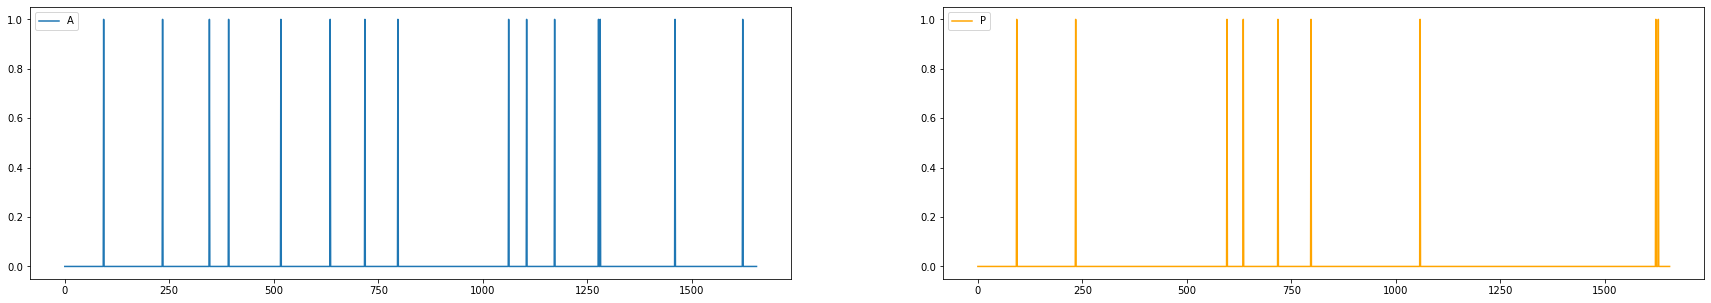

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS28.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS28.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.86733384e-05], Max [0.37370166]
Deviation 99.5th pctile [0.26470777]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1644    0]
 [   3    9]]
precision 1.00000, recall 0.75000, f1 0.85714
Time to predict and get records above deviation : 759907 ms


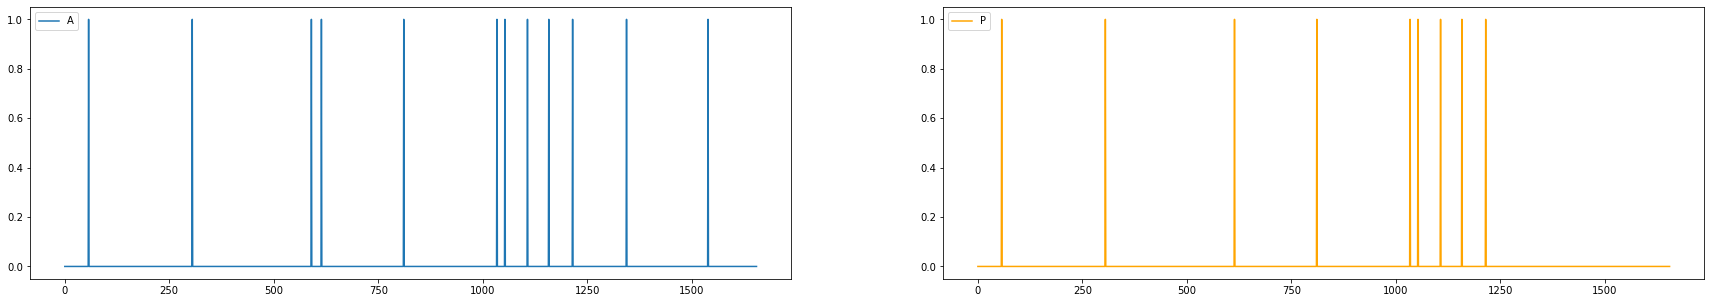

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS29.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS29.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.21356918e-05], Max [0.35199138]
Deviation 99.5th pctile [0.28897045]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1638    5]
 [   9    4]]
precision 0.44444, recall 0.30769, f1 0.36364
Time to predict and get records above deviation : 761797 ms


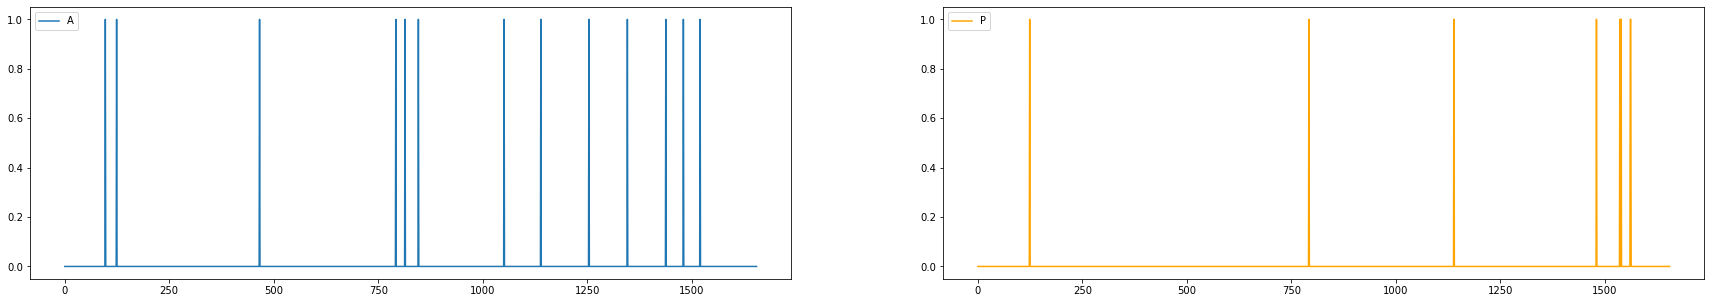

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS3.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS3.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.29353928e-05], Max [0.2641501]
Deviation 99.5th pctile [0.12254472]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1645    5]
 [   2    4]]
precision 0.44444, recall 0.66667, f1 0.53333
Time to predict and get records above deviation : 764219 ms


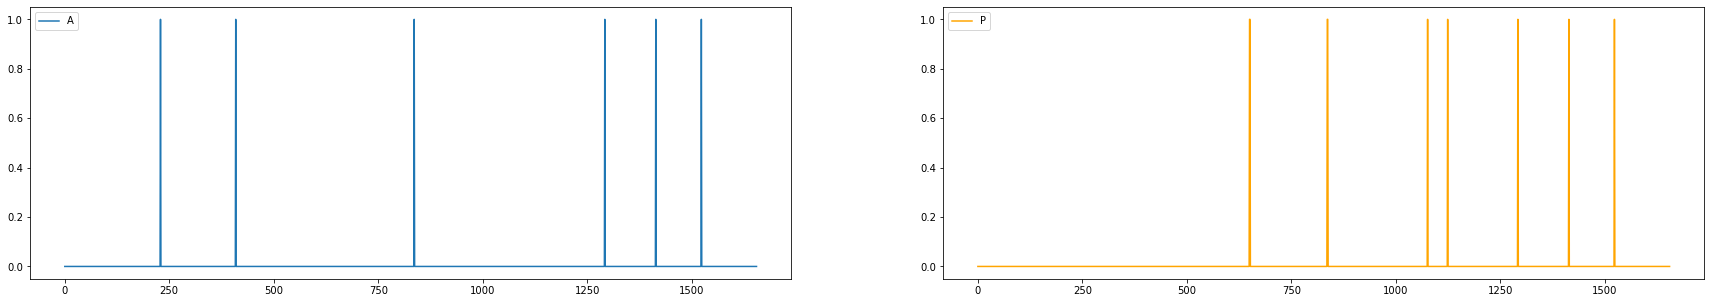

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS30.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS30.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.21629346e-05], Max [0.29261242]
Deviation 99.5th pctile [0.15889089]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 768521 ms


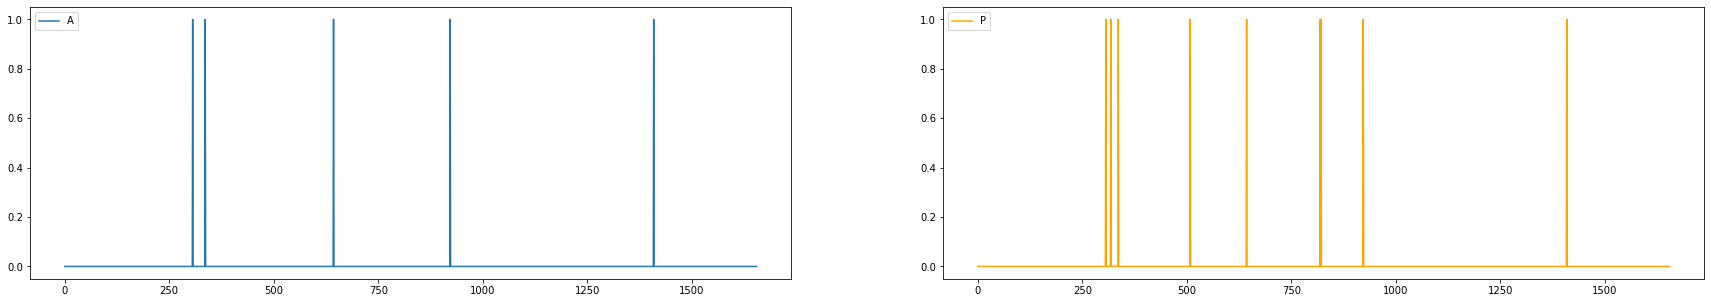

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS31.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS31.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.71446058e-05], Max [0.32121217]
Deviation 99.5th pctile [0.09091479]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1645    7]
 [   2    2]]
precision 0.22222, recall 0.50000, f1 0.30769
Time to predict and get records above deviation : 770352 ms


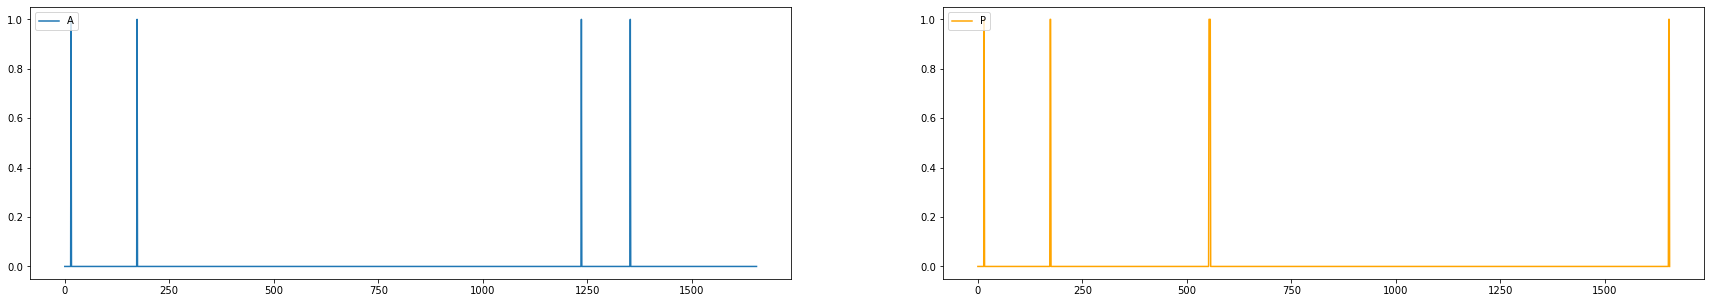

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS32.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS32.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00010644], Max [0.39996609]
Deviation 99.5th pctile [0.26642442]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1639    6]
 [   8    3]]
precision 0.33333, recall 0.27273, f1 0.30000
Time to predict and get records above deviation : 771855 ms


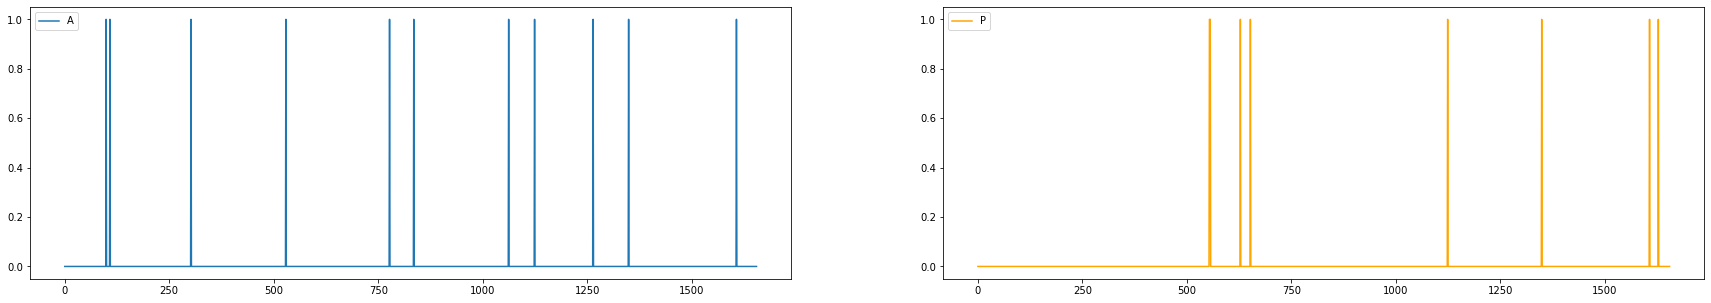

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS33.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS33.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.27156708e-05], Max [0.3304838]
Deviation 99.5th pctile [0.15373076]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 775181 ms


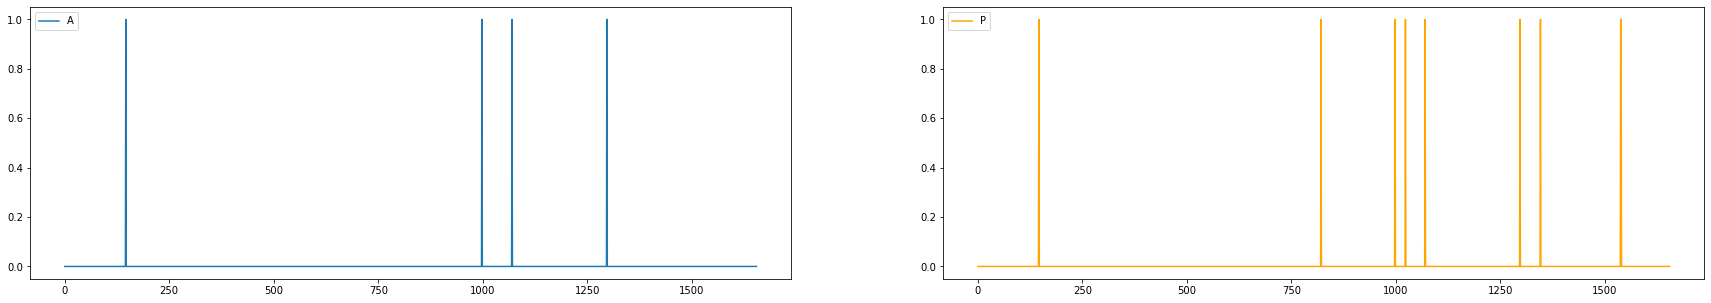

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS34.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS34.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.9992405e-05], Max [0.42221452]
Deviation 99.5th pctile [0.17571279]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1647    2]
 [   0    7]]
precision 0.77778, recall 1.00000, f1 0.87500
Time to predict and get records above deviation : 777107 ms


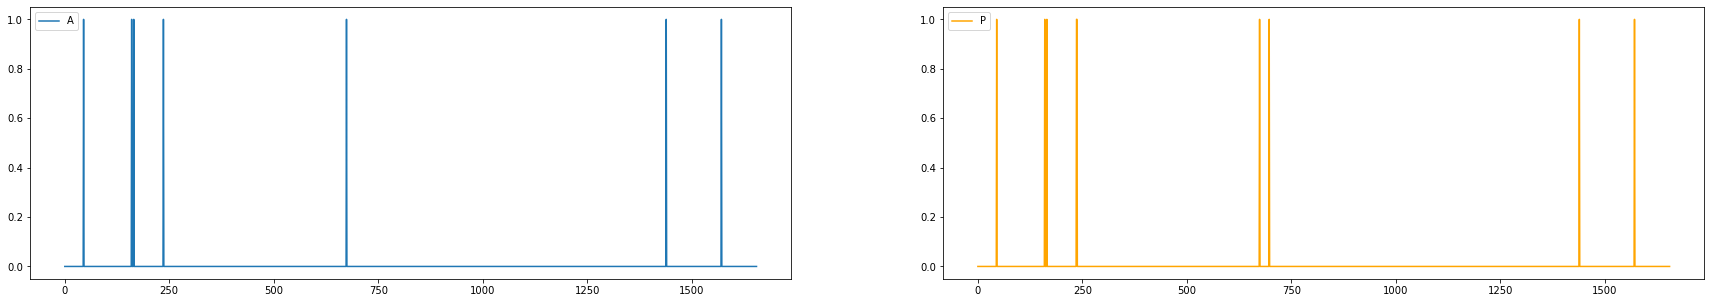

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS35.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS35.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.19567079e-05], Max [0.35575959]
Deviation 99.5th pctile [0.21872001]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1638    6]
 [   9    3]]
precision 0.33333, recall 0.25000, f1 0.28571
Time to predict and get records above deviation : 779402 ms


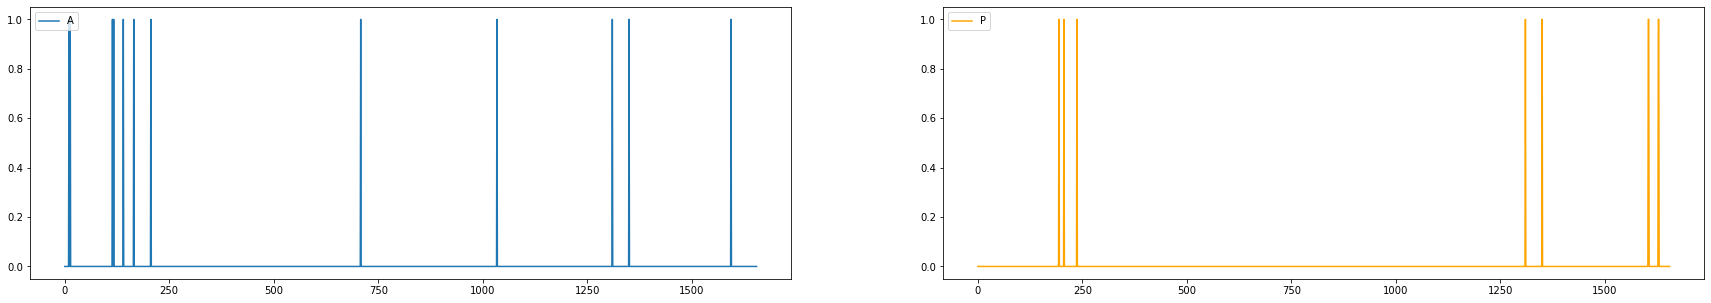

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS36.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS36.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00033833], Max [0.53534672]
Deviation 99.5th pctile [0.29384504]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 780933 ms


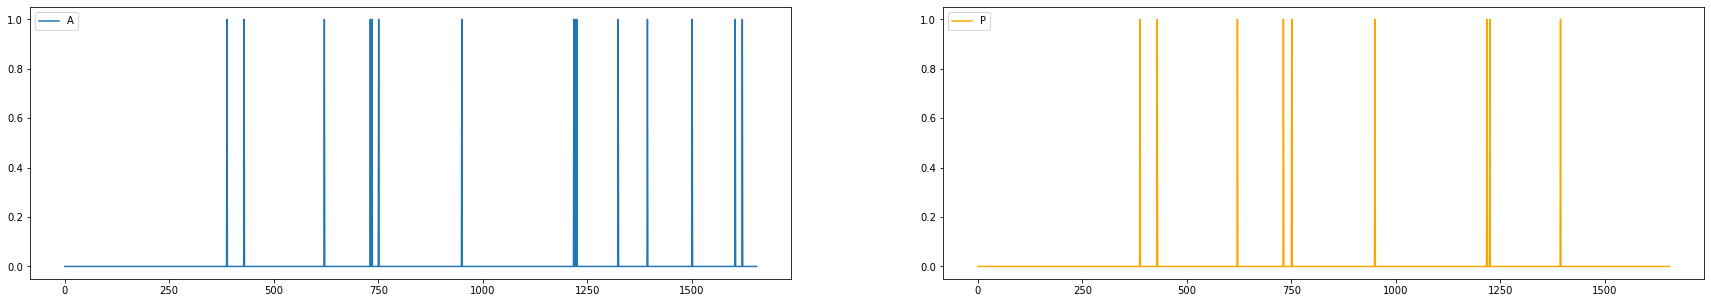

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS37.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS37.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.75494379e-05], Max [0.47258902]
Deviation 99.5th pctile [0.22505845]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1646    7]
 [   1    2]]
precision 0.22222, recall 0.66667, f1 0.33333
Time to predict and get records above deviation : 782973 ms


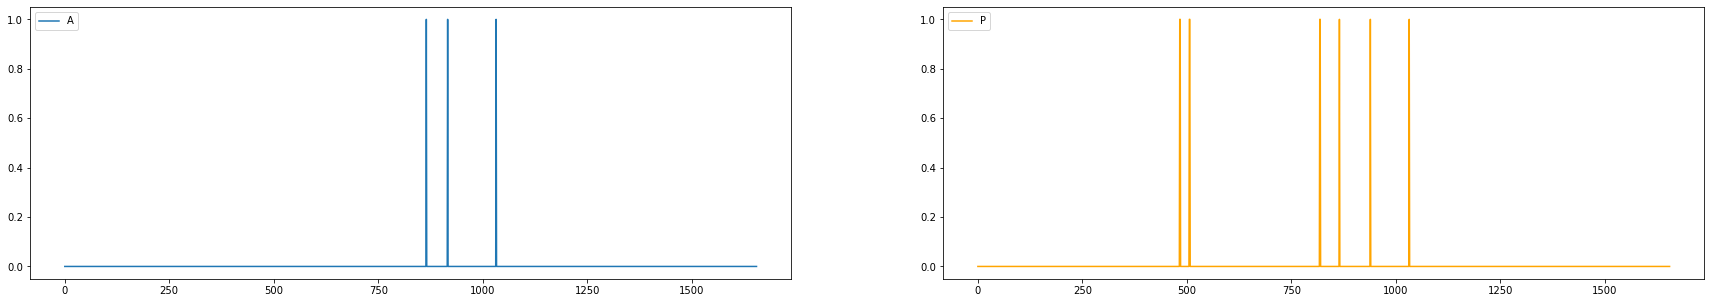

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS38.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS38.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.35900368e-06], Max [0.53808537]
Deviation 99.5th pctile [0.25009119]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1643    4]
 [   4    5]]
precision 0.55556, recall 0.55556, f1 0.55556
Time to predict and get records above deviation : 785071 ms


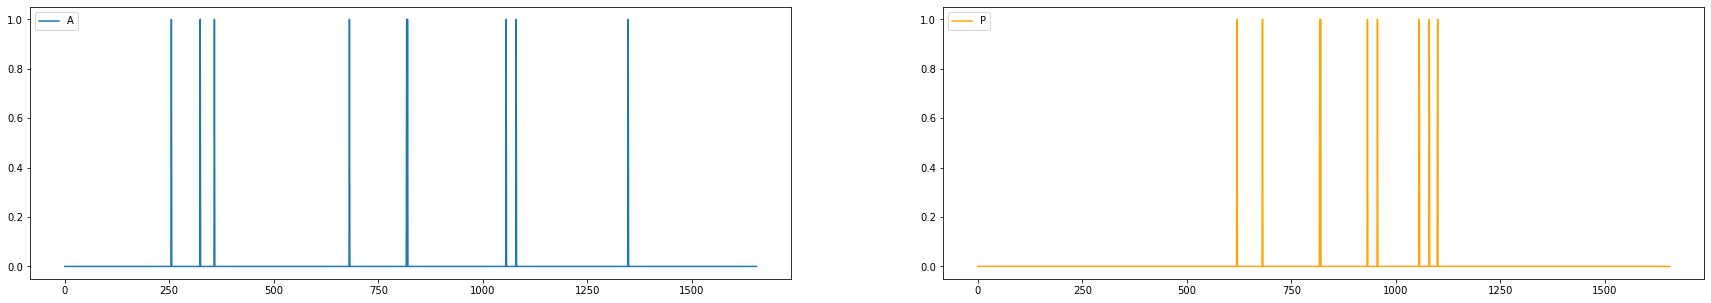

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS39.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS39.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [9.78407274e-05], Max [0.56948075]
Deviation 99.5th pctile [0.4173198]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1635    5]
 [  12    4]]
precision 0.44444, recall 0.25000, f1 0.32000
Time to predict and get records above deviation : 786847 ms


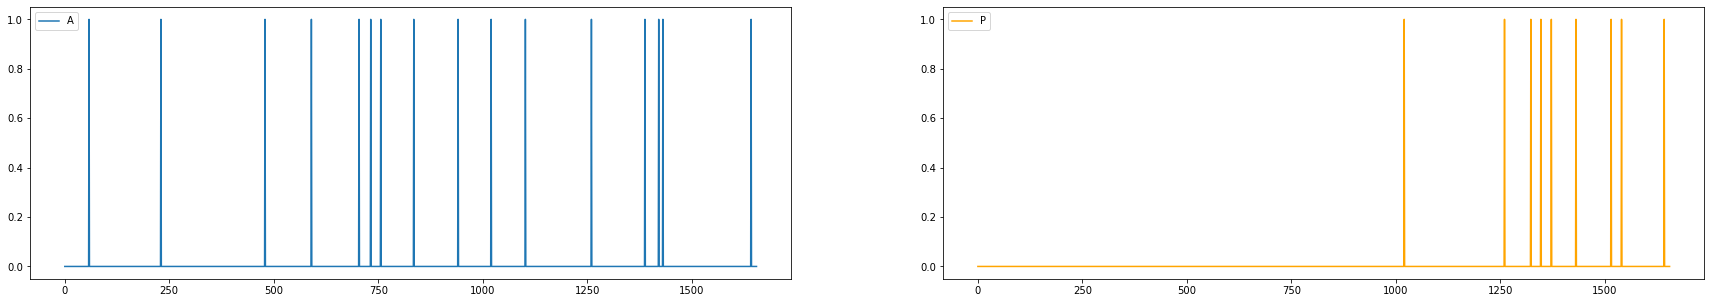

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS4.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS4.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.76935631e-05], Max [0.29848736]
Deviation 99.5th pctile [0.19847583]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1646    4]
 [   1    5]]
precision 0.55556, recall 0.83333, f1 0.66667
Time to predict and get records above deviation : 789327 ms


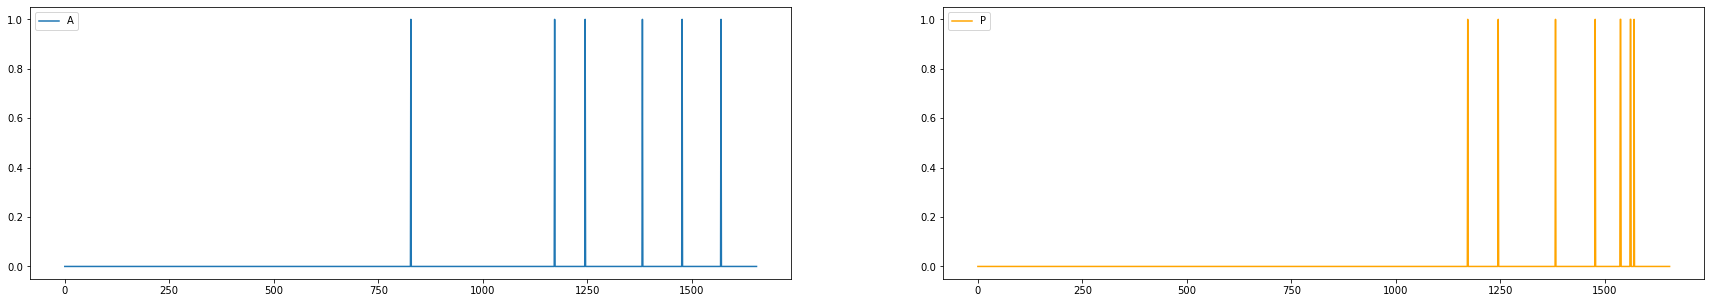

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS40.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS40.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.04964351e-05], Max [0.52269423]
Deviation 99.5th pctile [0.30492643]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1644    6]
 [   3    3]]
precision 0.33333, recall 0.50000, f1 0.40000
Time to predict and get records above deviation : 791080 ms


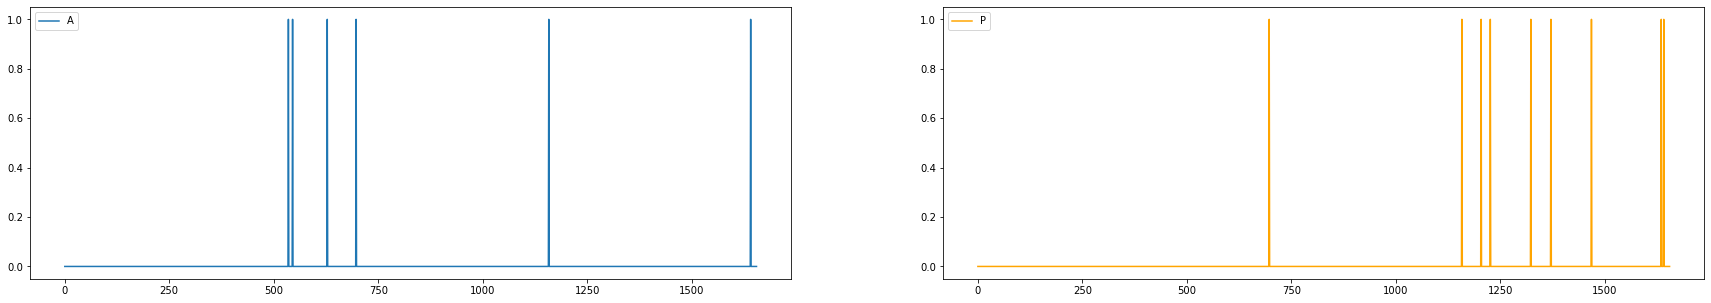

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS41.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS41.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.02868855e-05], Max [0.38138297]
Deviation 99.5th pctile [0.269455]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1636    7]
 [  11    2]]
precision 0.22222, recall 0.15385, f1 0.18182
Time to predict and get records above deviation : 793610 ms


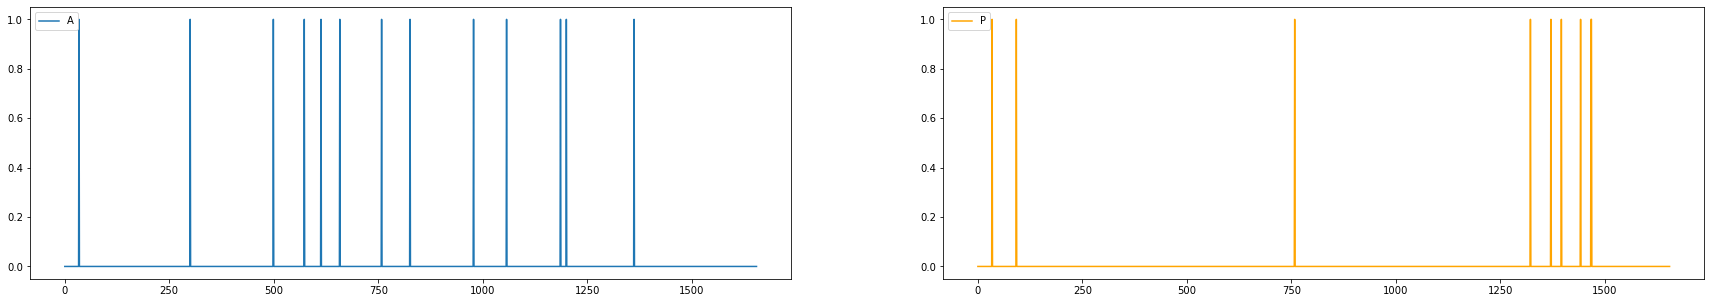

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS42.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS42.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.53472435e-05], Max [0.41303514]
Deviation 99.5th pctile [0.2076526]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1644    8]
 [   3    1]]
precision 0.11111, recall 0.25000, f1 0.15385
Time to predict and get records above deviation : 797185 ms


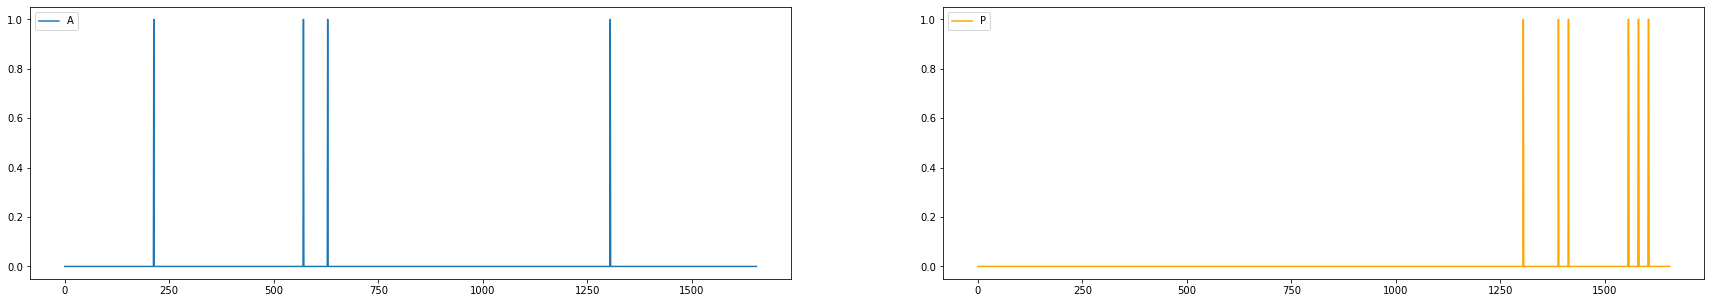

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS43.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS43.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.40885459e-05], Max [0.49706619]
Deviation 99.5th pctile [0.19030707]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1644    1]
 [   3    8]]
precision 0.88889, recall 0.72727, f1 0.80000
Time to predict and get records above deviation : 799828 ms


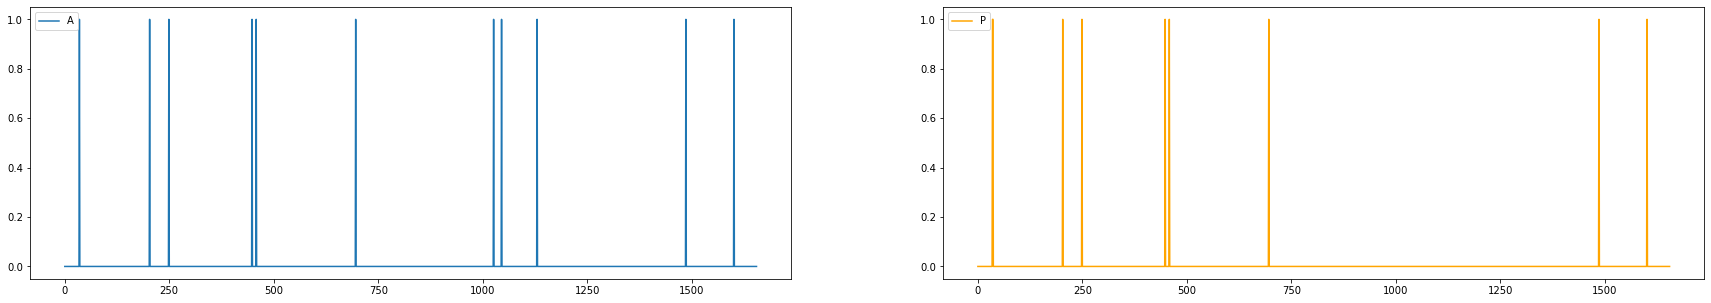

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS44.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS44.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.31811288e-06], Max [0.59069306]
Deviation 99.5th pctile [0.29614207]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1636    4]
 [  11    5]]
precision 0.55556, recall 0.31250, f1 0.40000
Time to predict and get records above deviation : 801863 ms


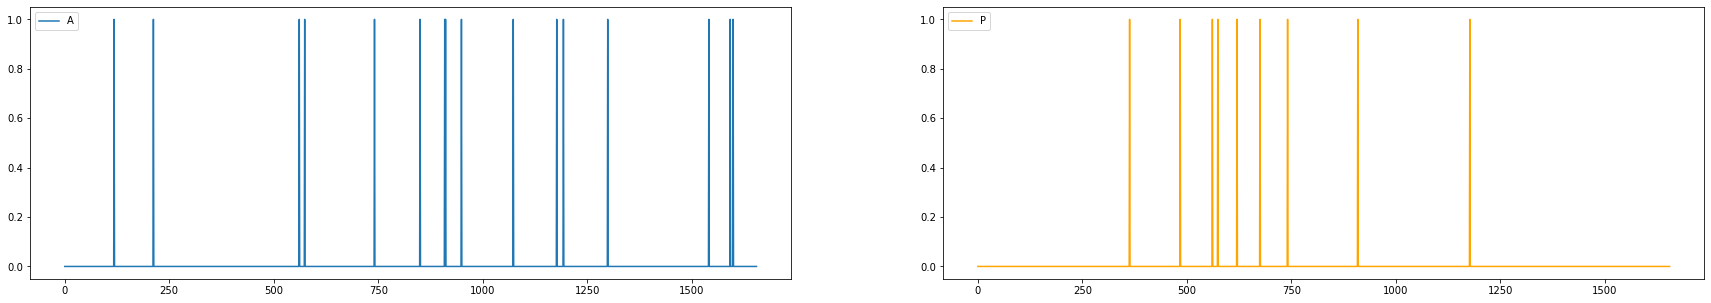

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS45.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS45.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00015654], Max [0.47855286]
Deviation 99.5th pctile [0.24157569]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1647    2]
 [   0    7]]
precision 0.77778, recall 1.00000, f1 0.87500
Time to predict and get records above deviation : 803392 ms


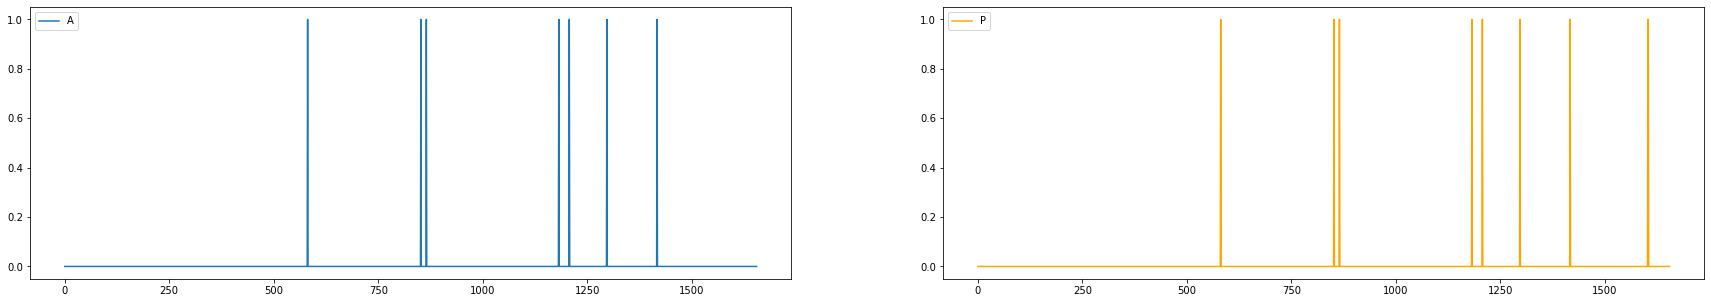

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS46.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS46.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.68238743e-06], Max [0.47055158]
Deviation 99.5th pctile [0.2129589]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1647    0]
 [   0    9]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 805299 ms


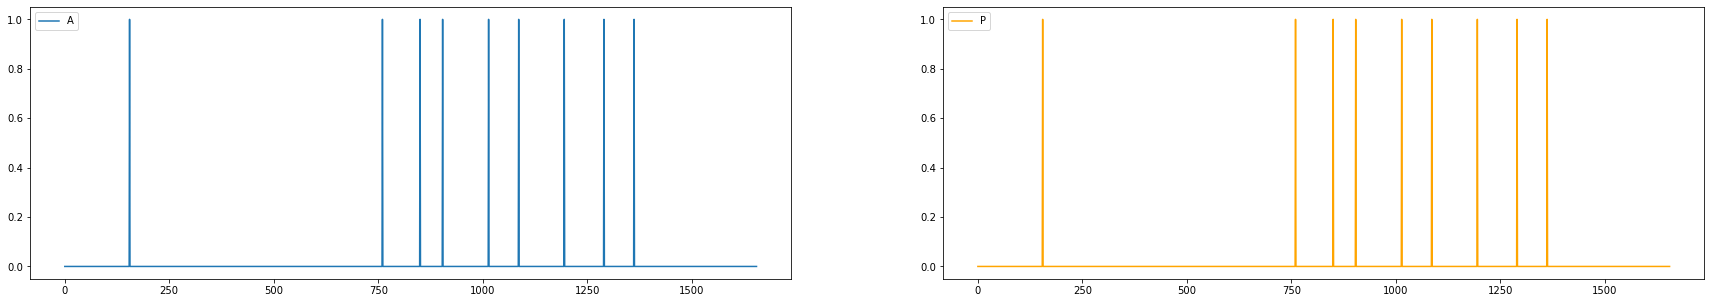

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS47.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS47.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.07410364e-05], Max [0.42614363]
Deviation 99.5th pctile [0.16026784]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 806803 ms


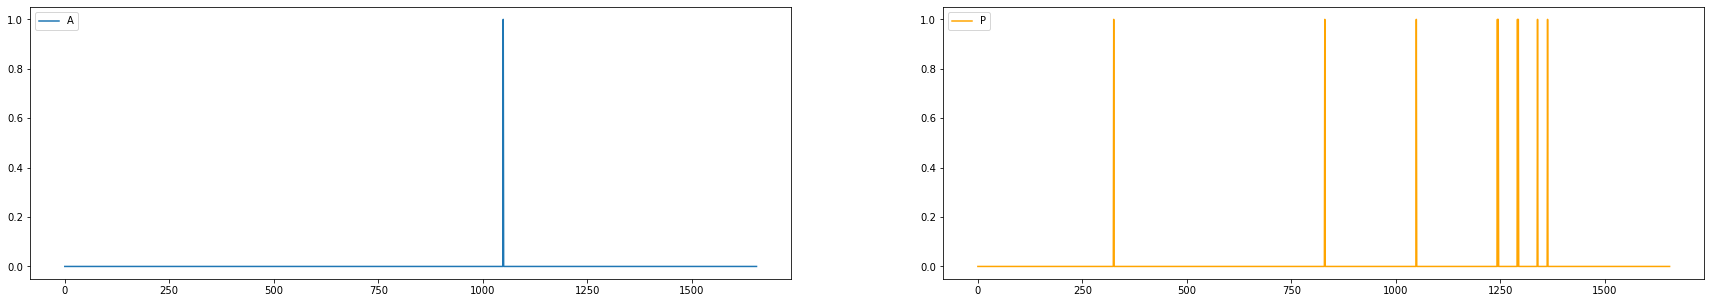

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS48.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS48.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.1698135e-05], Max [0.60902619]
Deviation 99.5th pctile [0.24188941]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1640    5]
 [   7    4]]
precision 0.44444, recall 0.36364, f1 0.40000
Time to predict and get records above deviation : 808271 ms


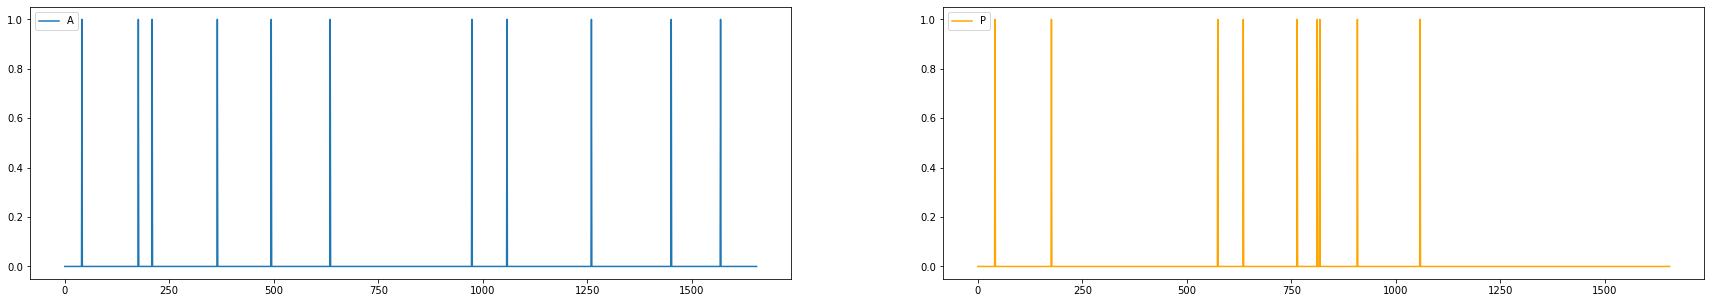

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS49.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS49.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.07873328e-05], Max [0.17226461]
Deviation 99.5th pctile [0.15950412]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1638    9]
 [   9    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 810333 ms


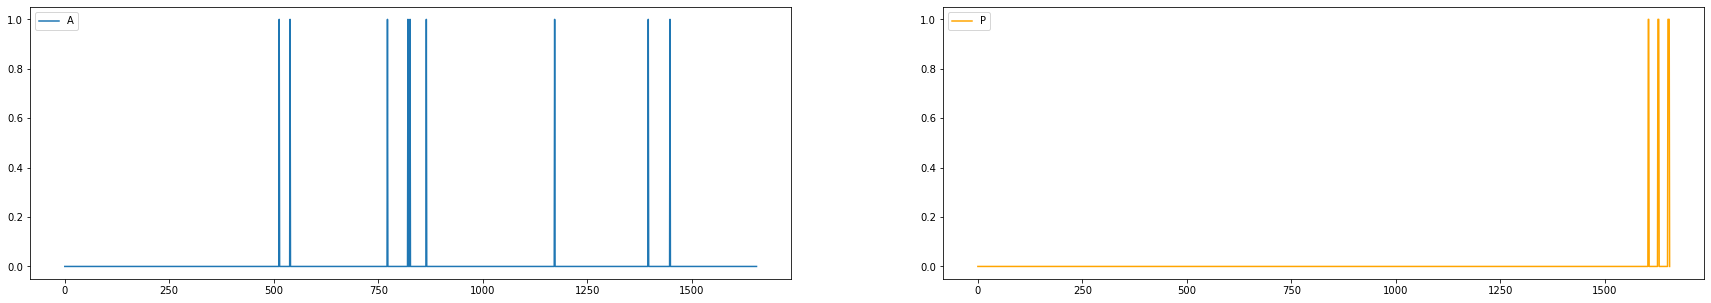

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS5.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS5.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.88335365e-05], Max [0.32720103]
Deviation 99.5th pctile [0.31369913]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1641    9]
 [   6    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 814076 ms


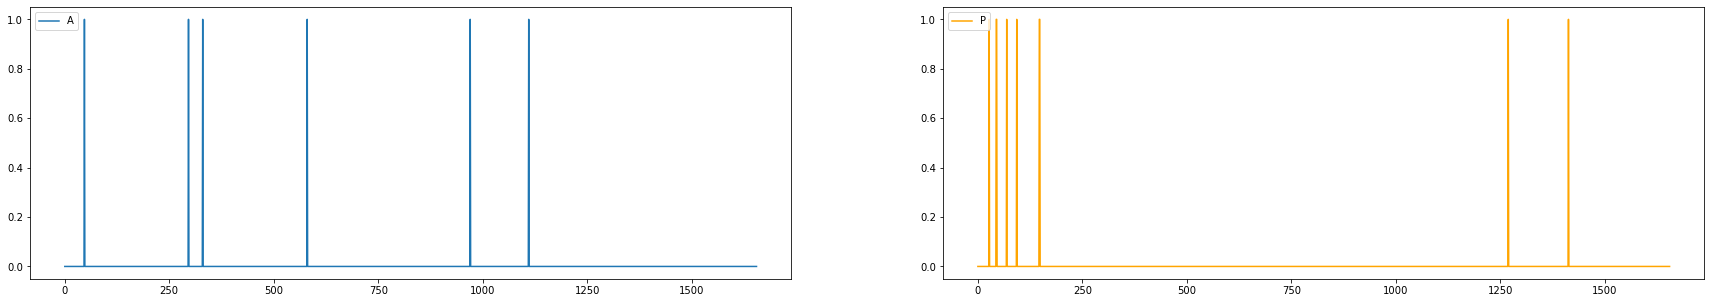

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS50.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS50.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [6.60858113e-06], Max [0.65676636]
Deviation 99.5th pctile [0.2864906]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1643    6]
 [   4    3]]
precision 0.33333, recall 0.42857, f1 0.37500
Time to predict and get records above deviation : 817559 ms


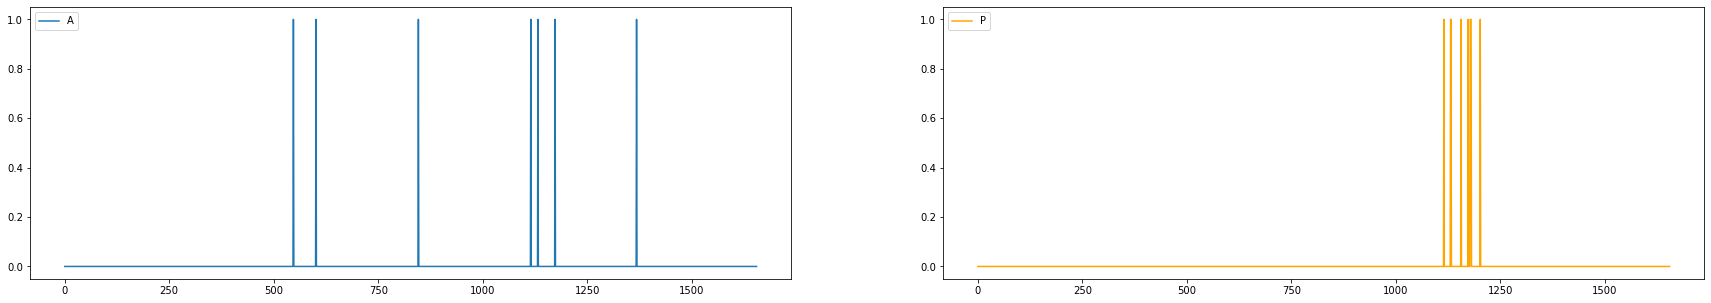

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS51.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS51.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.51929047e-05], Max [0.2146412]
Deviation 99.5th pctile [0.13900158]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 819438 ms


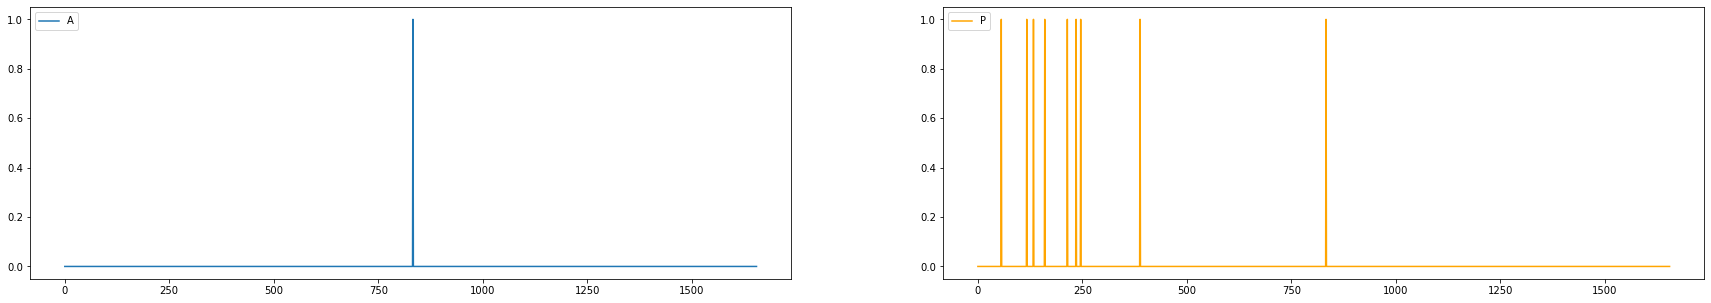

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS52.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS52.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.20043404e-05], Max [0.37058861]
Deviation 99.5th pctile [0.25308086]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1645    0]
 [   2    9]]
precision 1.00000, recall 0.81818, f1 0.90000
Time to predict and get records above deviation : 821916 ms


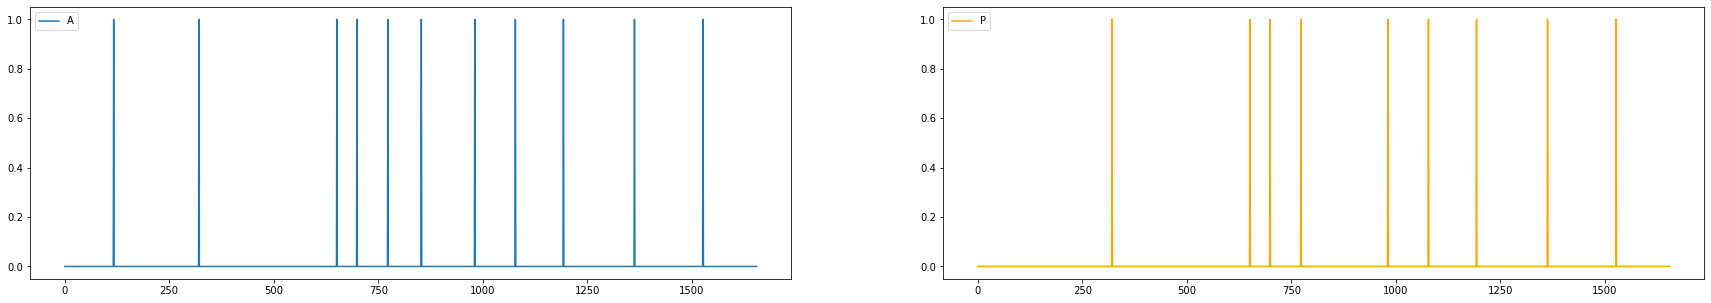

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS53.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS53.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.76070427e-05], Max [0.32500942]
Deviation 99.5th pctile [0.24215038]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 824251 ms


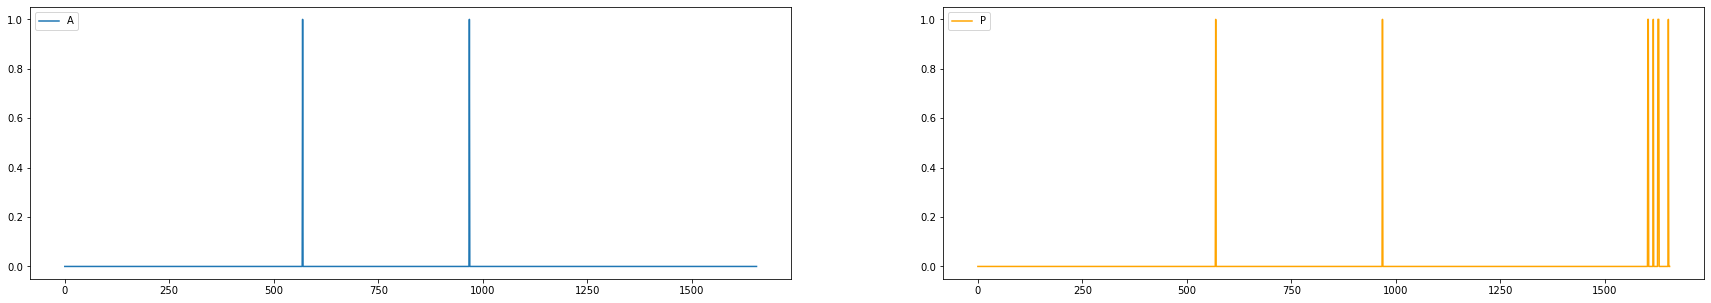

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS54.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS54.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00010304], Max [0.22189201]
Deviation 99.5th pctile [0.14726348]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1646    7]
 [   1    2]]
precision 0.22222, recall 0.66667, f1 0.33333
Time to predict and get records above deviation : 826075 ms


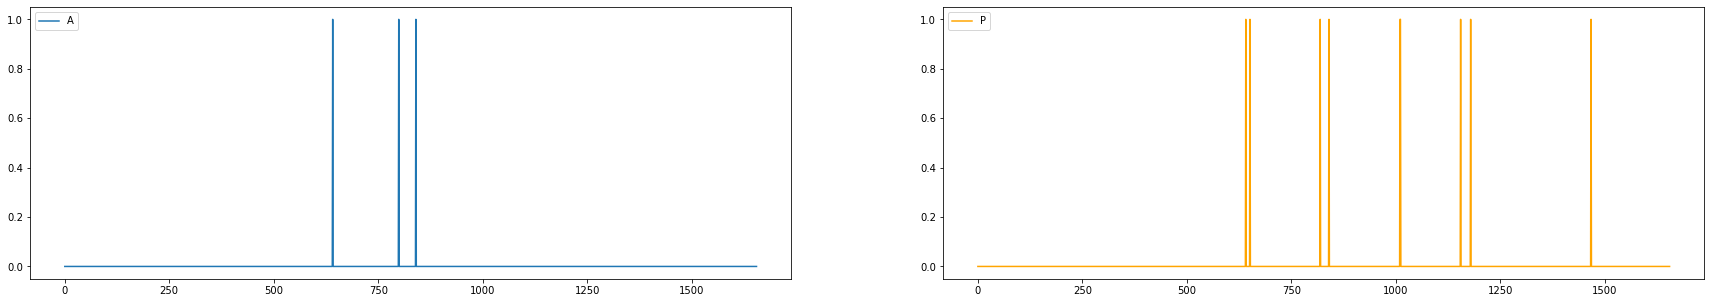

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS55.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS55.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.12112581e-06], Max [0.45543712]
Deviation 99.5th pctile [0.28046155]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1646    8]
 [   1    1]]
precision 0.11111, recall 0.50000, f1 0.18182
Time to predict and get records above deviation : 827757 ms


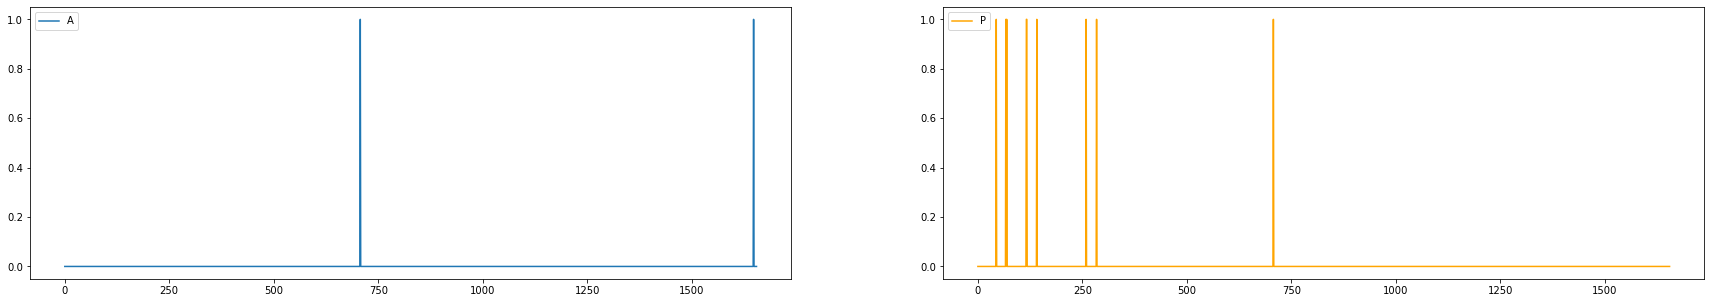

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS56.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS56.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.66506414e-06], Max [0.41730633]
Deviation 99.5th pctile [0.25421463]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1634    6]
 [  13    3]]
precision 0.33333, recall 0.18750, f1 0.24000
Time to predict and get records above deviation : 829467 ms


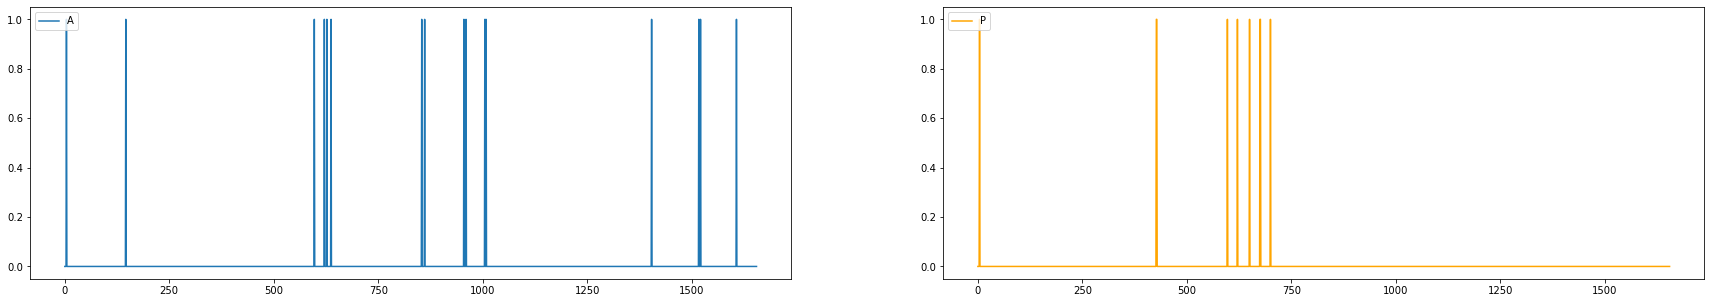

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS57.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS57.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.69418979e-05], Max [0.42966544]
Deviation 99.5th pctile [0.25089015]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1646    4]
 [   1    5]]
precision 0.55556, recall 0.83333, f1 0.66667
Time to predict and get records above deviation : 832611 ms


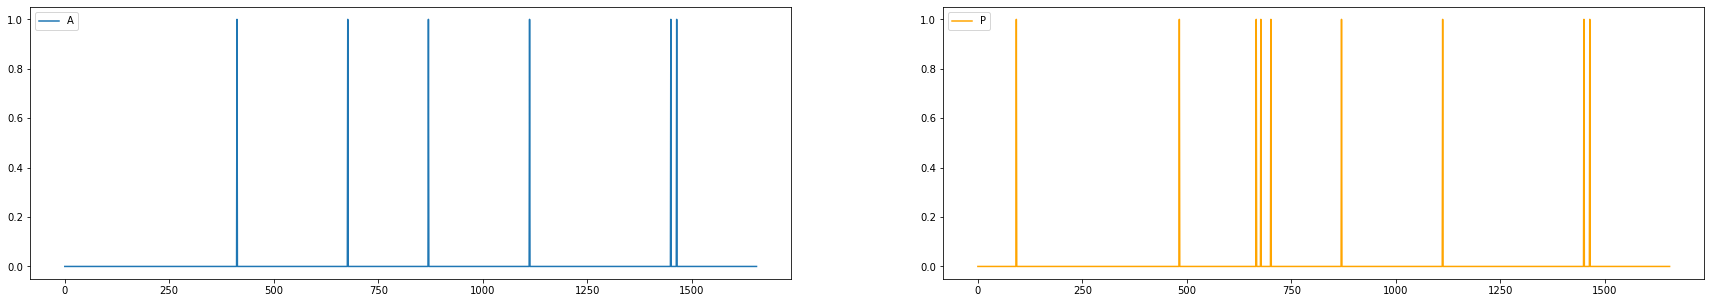

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS58.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS58.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.00459562e-05], Max [0.36166864]
Deviation 99.5th pctile [0.20353101]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1641    7]
 [   6    2]]
precision 0.22222, recall 0.25000, f1 0.23529
Time to predict and get records above deviation : 834379 ms


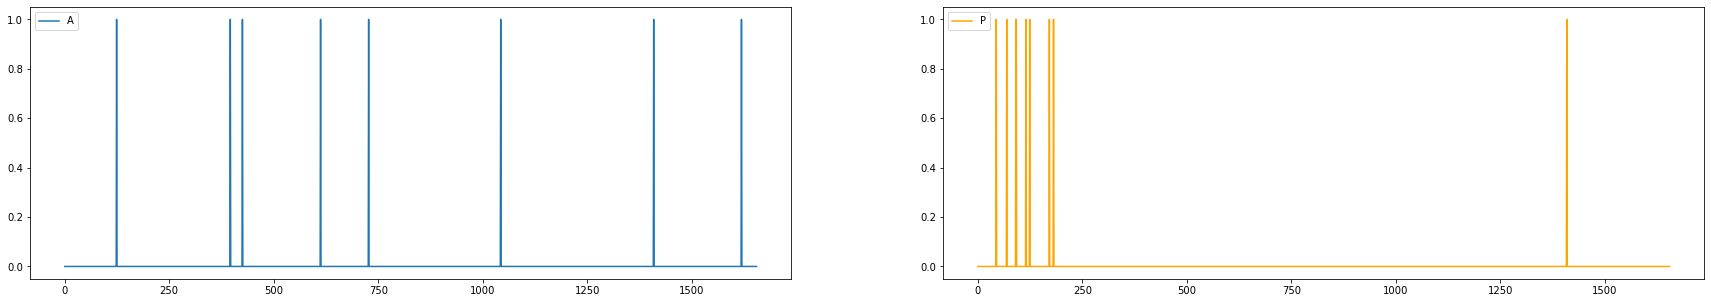

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS59.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS59.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.99273145e-06], Max [0.40880962]
Deviation 99.5th pctile [0.36135029]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1646    9]
 [   1    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 836358 ms


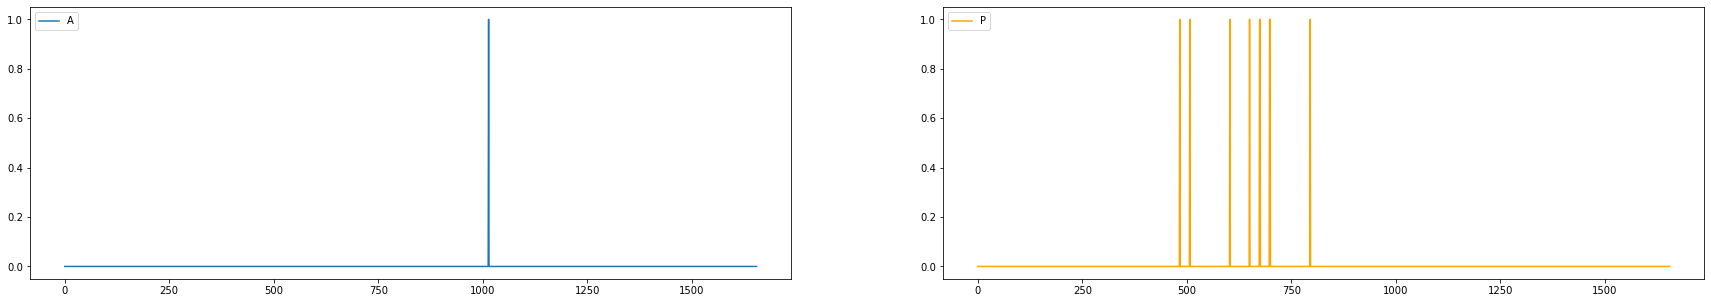

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS6.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS6.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.01618156e-05], Max [0.58043408]
Deviation 99.5th pctile [0.24675222]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1647    1]
 [   0    8]]
precision 0.88889, recall 1.00000, f1 0.94118
Time to predict and get records above deviation : 840330 ms


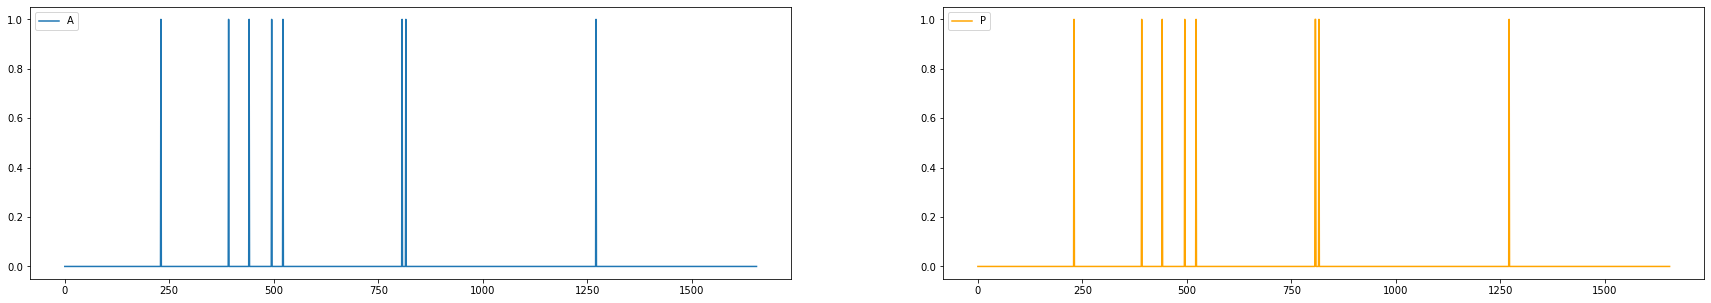

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS60.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS60.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.47926273e-05], Max [0.38026771]
Deviation 99.5th pctile [0.26408539]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1645    8]
 [   2    1]]
precision 0.11111, recall 0.33333, f1 0.16667
Time to predict and get records above deviation : 842226 ms


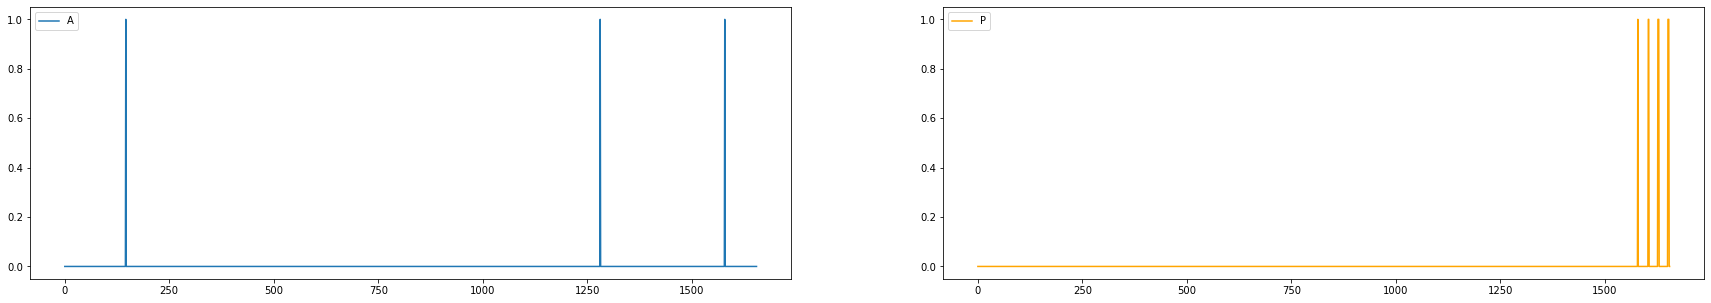

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS61.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS61.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.41491143e-05], Max [0.74084419]
Deviation 99.5th pctile [0.27150255]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1647    6]
 [   0    3]]
precision 0.33333, recall 1.00000, f1 0.50000
Time to predict and get records above deviation : 845406 ms


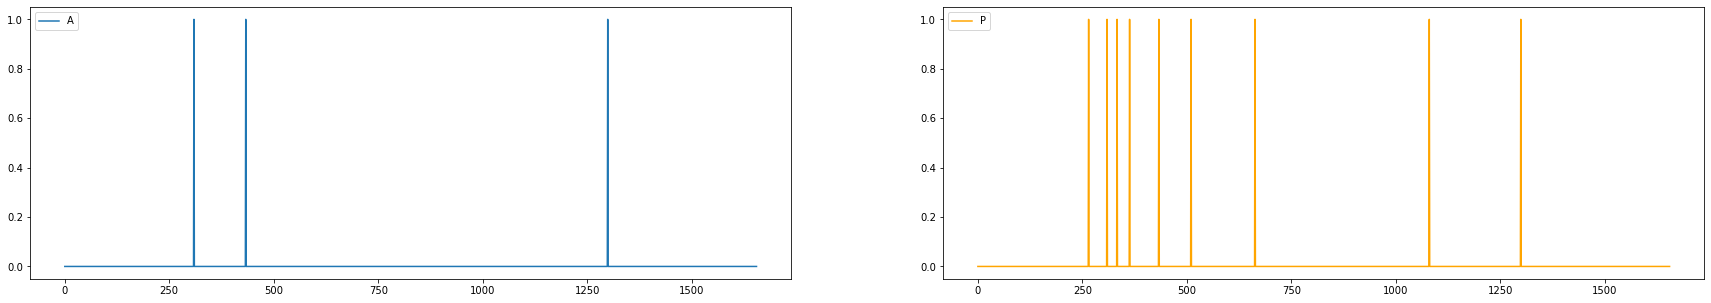

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS62.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS62.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.08875039e-05], Max [0.3183257]
Deviation 99.5th pctile [0.17802603]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1640    2]
 [   7    7]]
precision 0.77778, recall 0.50000, f1 0.60870
Time to predict and get records above deviation : 847459 ms


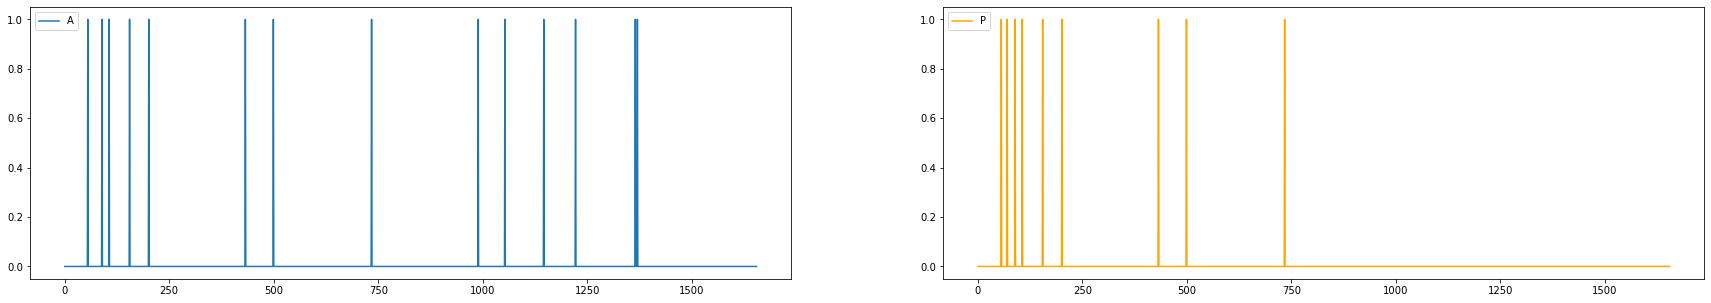

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS63.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS63.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.33133038e-05], Max [0.17843615]
Deviation 99.5th pctile [0.11719821]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1649,    7]))
Confusion matrix 
[[1646    3]
 [   1    6]]
precision 0.66667, recall 0.85714, f1 0.75000
Time to predict and get records above deviation : 849448 ms


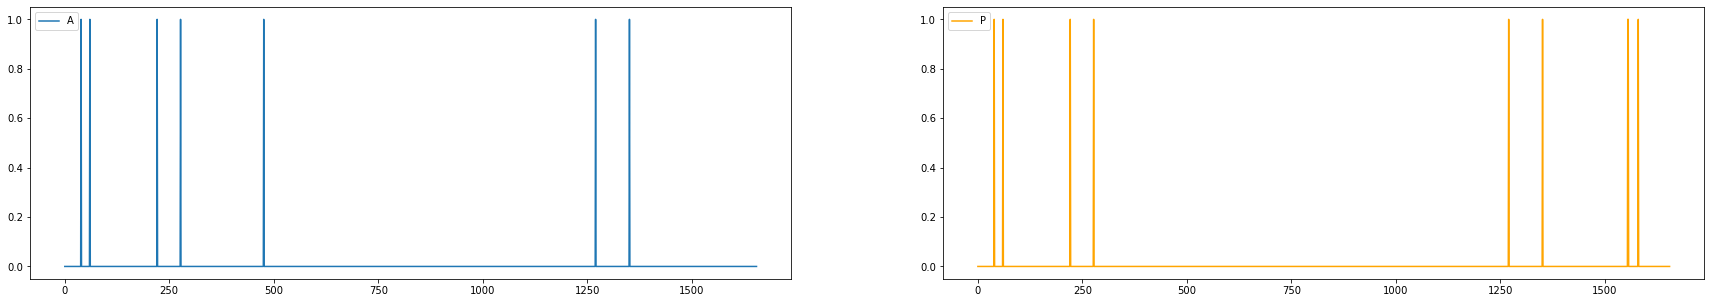

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS64.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS64.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.9518323e-06], Max [0.42243931]
Deviation 99.5th pctile [0.21778142]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1643    8]
 [   4    1]]
precision 0.11111, recall 0.20000, f1 0.14286
Time to predict and get records above deviation : 851155 ms


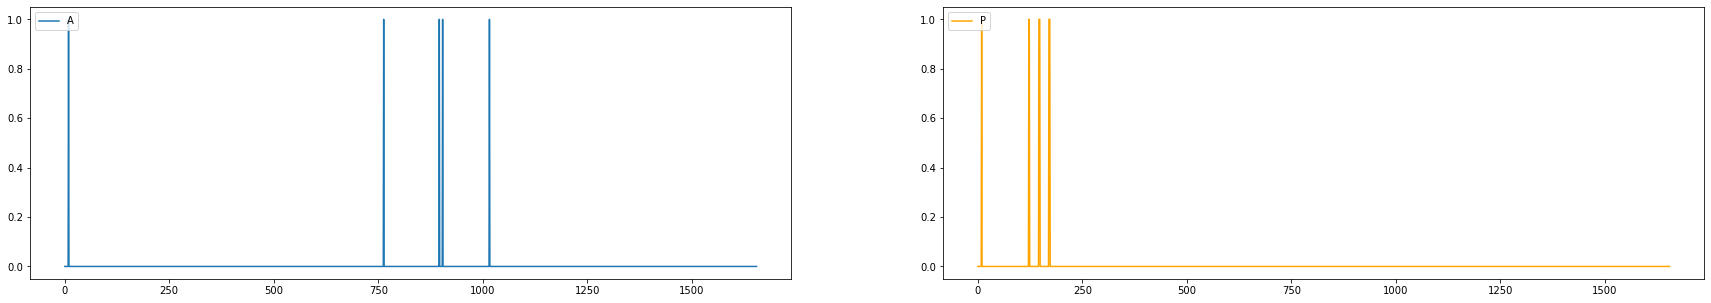

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS65.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS65.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.74415259e-06], Max [0.40336456]
Deviation 99.5th pctile [0.28998657]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to predict and get records above deviation : 854159 ms


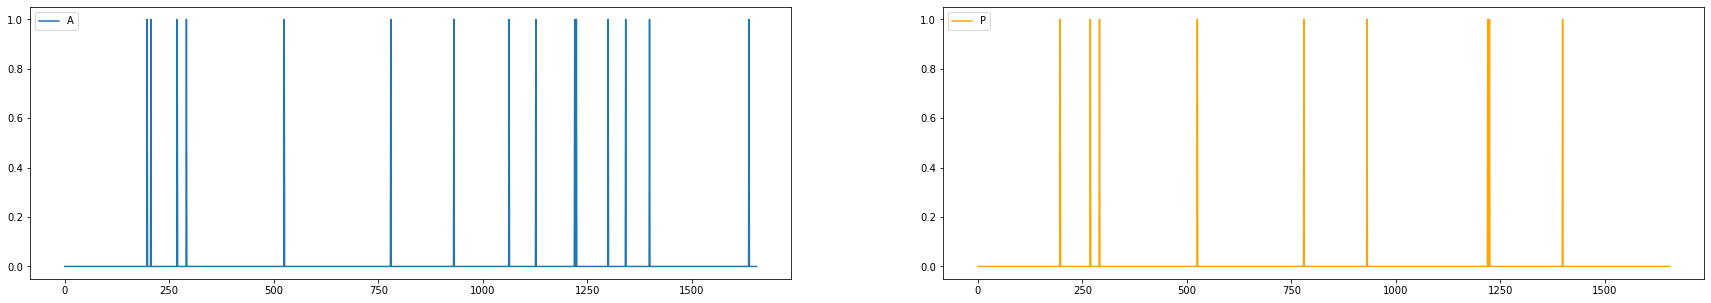

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS66.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS66.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.80982446e-05], Max [0.40109027]
Deviation 99.5th pctile [0.3520212]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1646    9]
 [   1    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 856096 ms


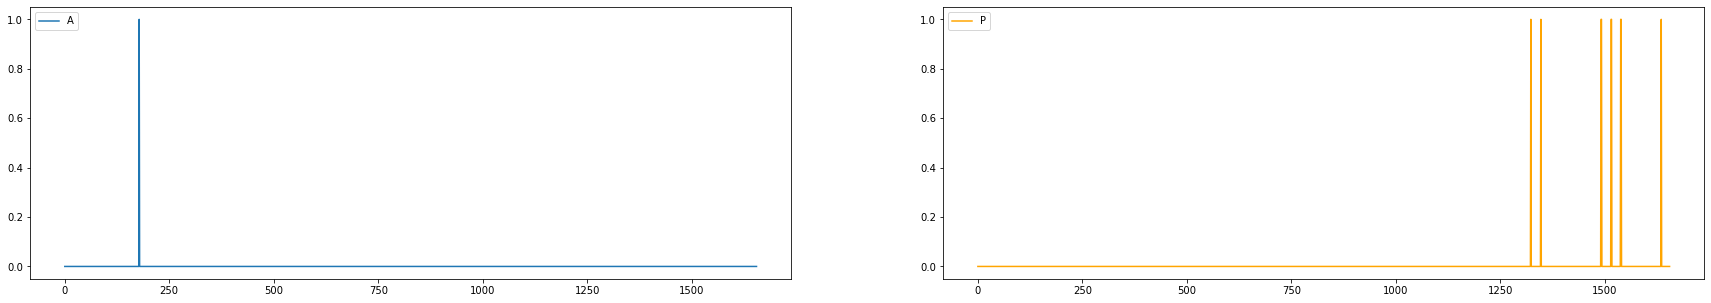

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS67.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS67.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.27547026e-05], Max [0.41584507]
Deviation 99.5th pctile [0.22038969]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1642    0]
 [   5    9]]
precision 1.00000, recall 0.64286, f1 0.78261
Time to predict and get records above deviation : 857549 ms


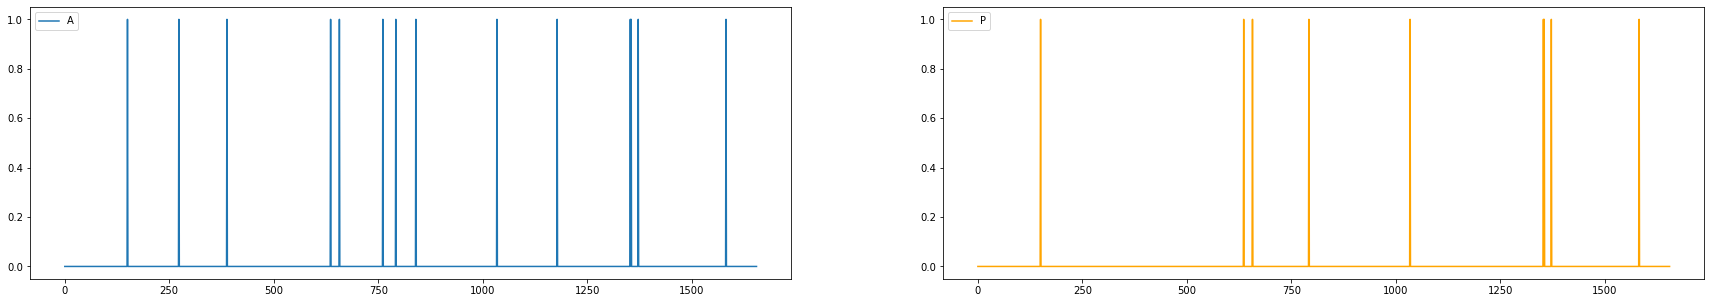

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS68.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS68.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.71175023e-05], Max [0.21974514]
Deviation 99.5th pctile [0.10056379]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 859184 ms


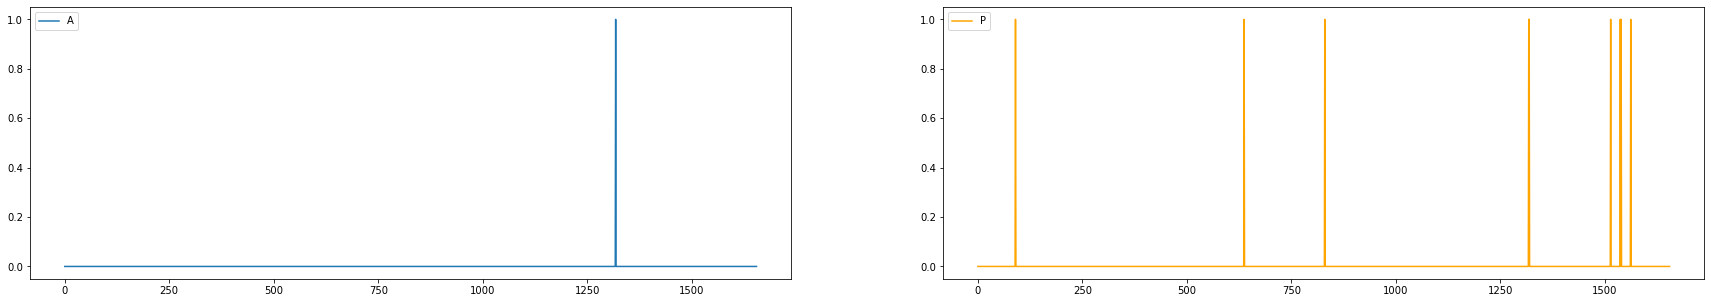

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS69.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS69.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.56180236e-05], Max [0.51419353]
Deviation 99.5th pctile [0.15541536]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 860886 ms


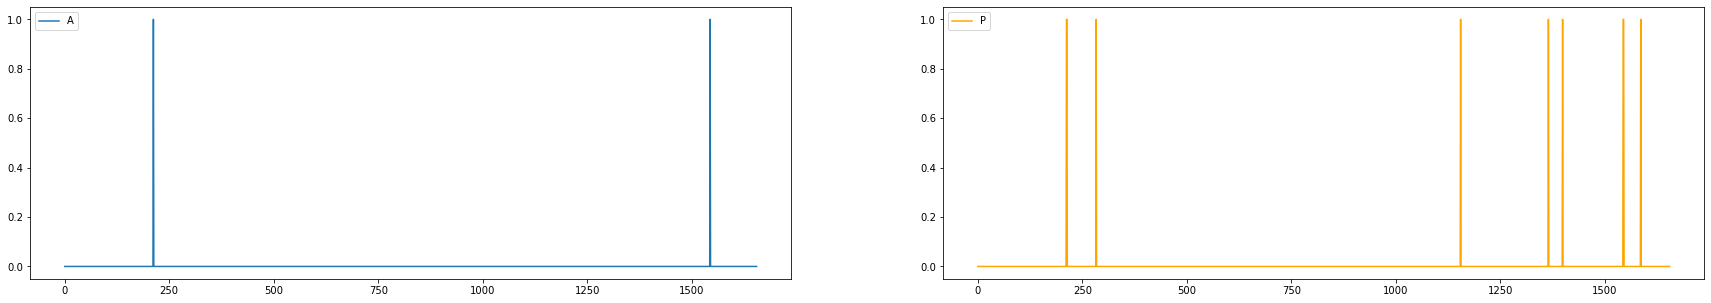

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS7.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS7.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.41898617e-06], Max [0.48732045]
Deviation 99.5th pctile [0.22668126]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1638    4]
 [   9    5]]
precision 0.55556, recall 0.35714, f1 0.43478
Time to predict and get records above deviation : 862423 ms


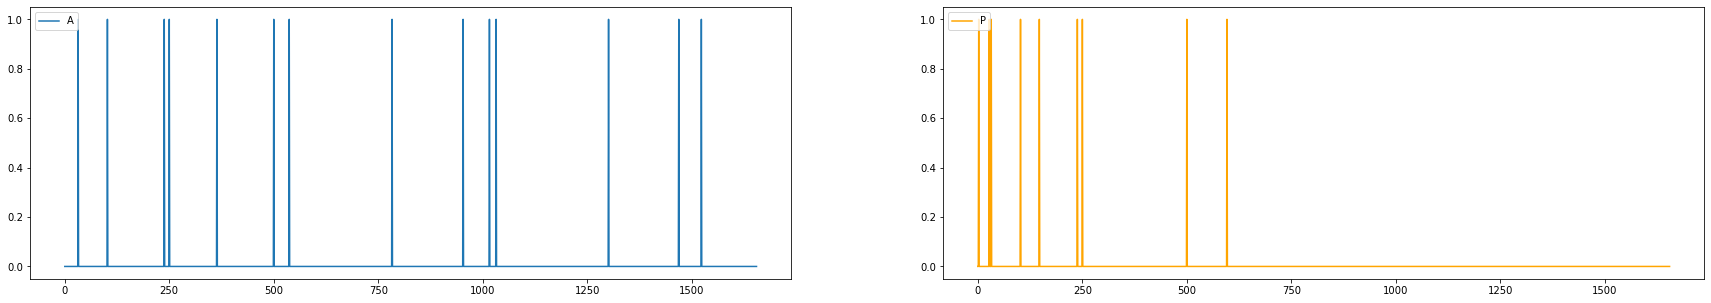

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS70.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS70.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.0001249], Max [0.50574982]
Deviation 99.5th pctile [0.17853251]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to predict and get records above deviation : 864240 ms


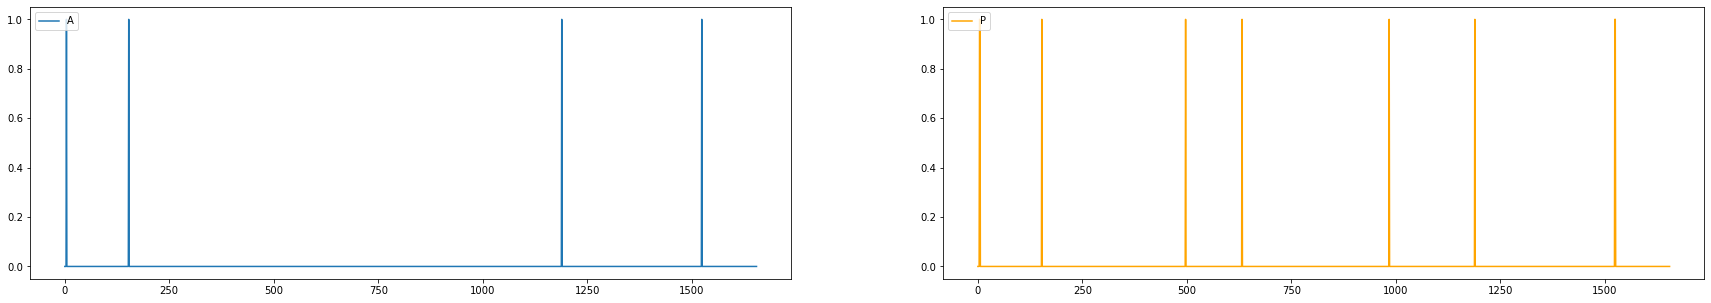

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS71.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS71.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.69443798e-05], Max [0.47447577]
Deviation 99.5th pctile [0.2105309]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1641    5]
 [   6    4]]
precision 0.44444, recall 0.40000, f1 0.42105
Time to predict and get records above deviation : 865969 ms


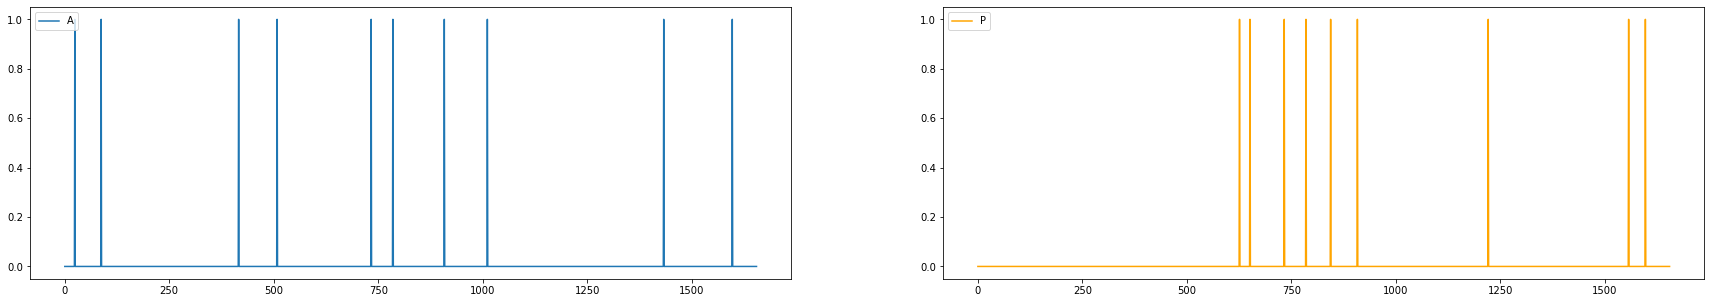

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS72.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS72.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.13972262e-05], Max [0.46337789]
Deviation 99.5th pctile [0.25897322]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1645    6]
 [   2    3]]
precision 0.33333, recall 0.60000, f1 0.42857
Time to predict and get records above deviation : 868245 ms


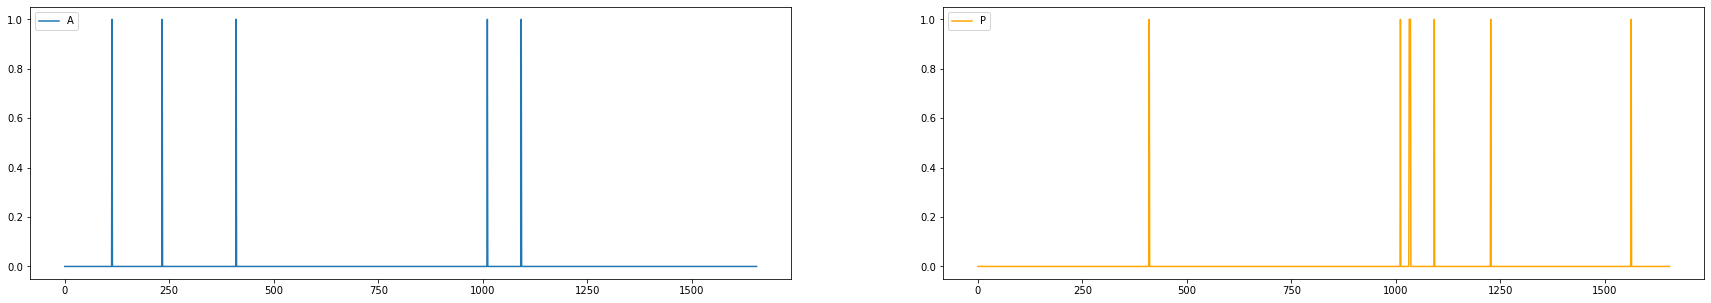

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS73.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS73.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.73465345e-05], Max [0.3970778]
Deviation 99.5th pctile [0.14886712]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1647    4]
 [   0    5]]
precision 0.55556, recall 1.00000, f1 0.71429
Time to predict and get records above deviation : 870334 ms


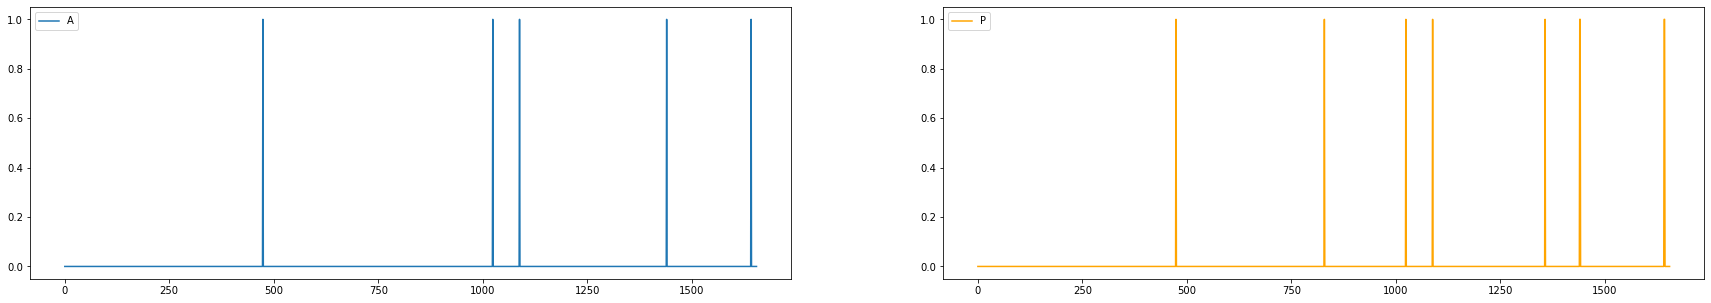

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS74.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS74.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.0430766e-05], Max [0.40690225]
Deviation 99.5th pctile [0.15991165]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 871772 ms


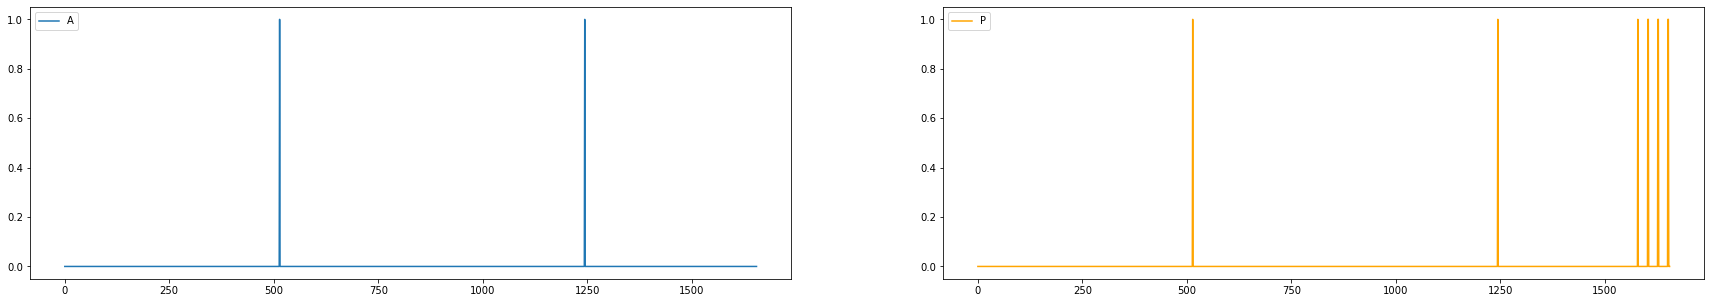

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS75.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS75.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.16208884e-05], Max [0.46026329]
Deviation 99.5th pctile [0.257023]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1641    2]
 [   6    7]]
precision 0.77778, recall 0.53846, f1 0.63636
Time to predict and get records above deviation : 873264 ms


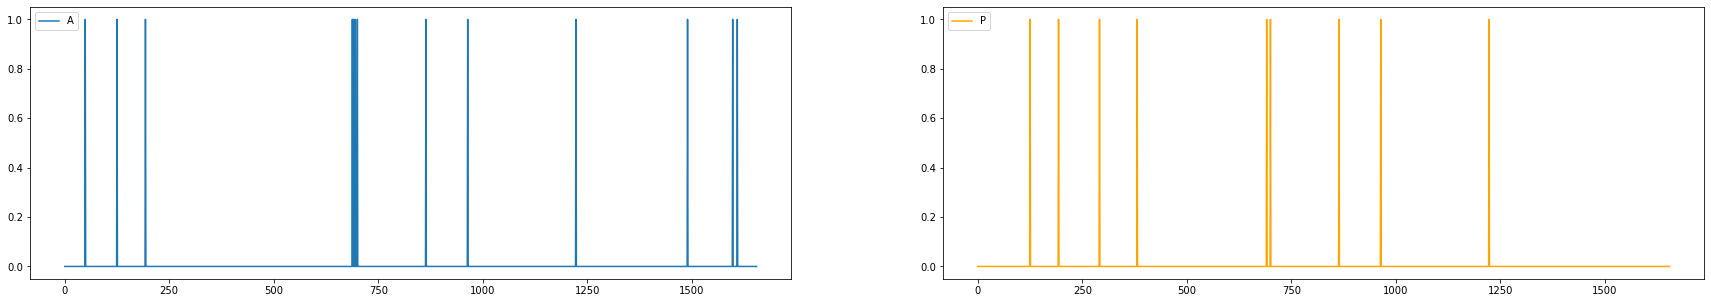

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS76.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS76.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.86646456e-05], Max [0.41646865]
Deviation 99.5th pctile [0.2239606]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1641    6]
 [   6    3]]
precision 0.33333, recall 0.33333, f1 0.33333
Time to predict and get records above deviation : 874879 ms


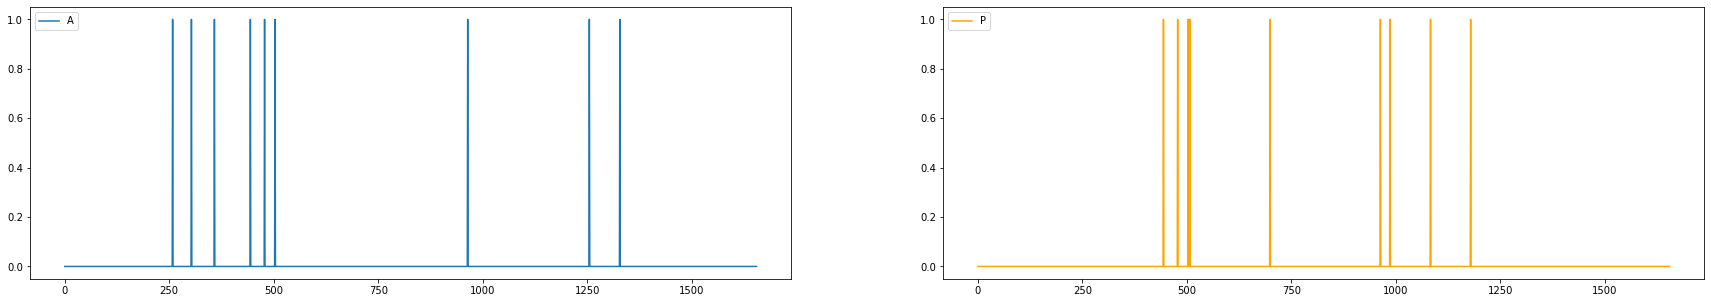

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS77.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS77.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.72824432e-05], Max [0.3670128]
Deviation 99.5th pctile [0.22250144]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to predict and get records above deviation : 877408 ms


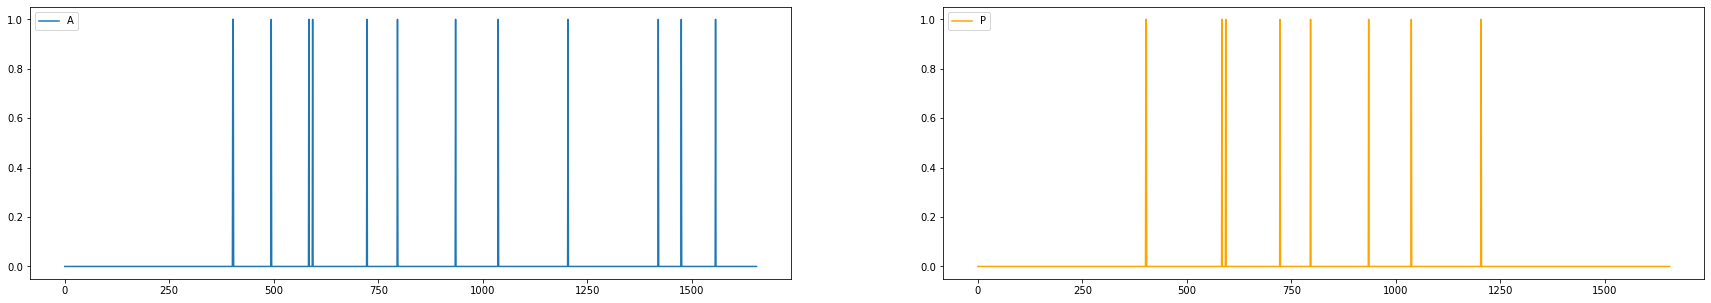

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS78.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS78.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.18525196e-05], Max [0.89224066]
Deviation 99.5th pctile [0.55627925]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1635    8]
 [  12    1]]
precision 0.11111, recall 0.07692, f1 0.09091
Time to predict and get records above deviation : 879296 ms


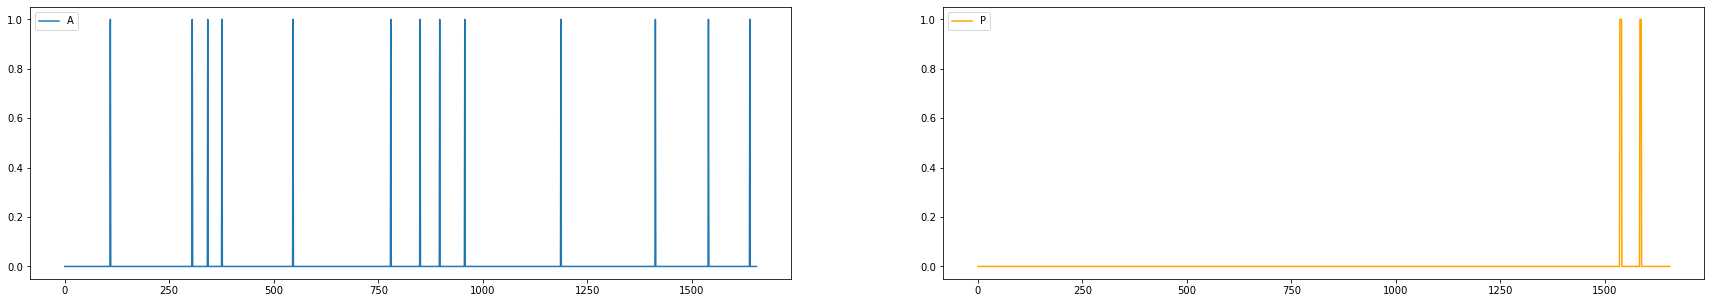

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS79.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS79.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.05305592e-05], Max [0.31386336]
Deviation 99.5th pctile [0.25741599]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1645    8]
 [   2    1]]
precision 0.11111, recall 0.33333, f1 0.16667
Time to predict and get records above deviation : 881568 ms


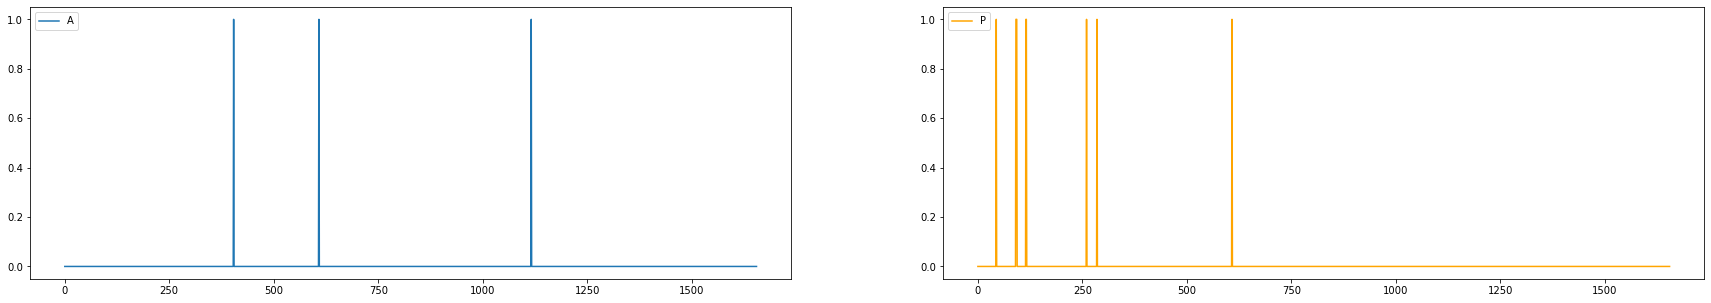

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS8.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS8.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [5.20311735e-05], Max [0.63401908]
Deviation 99.5th pctile [0.28144909]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1635    8]
 [  12    1]]
precision 0.11111, recall 0.07692, f1 0.09091
Time to predict and get records above deviation : 883449 ms


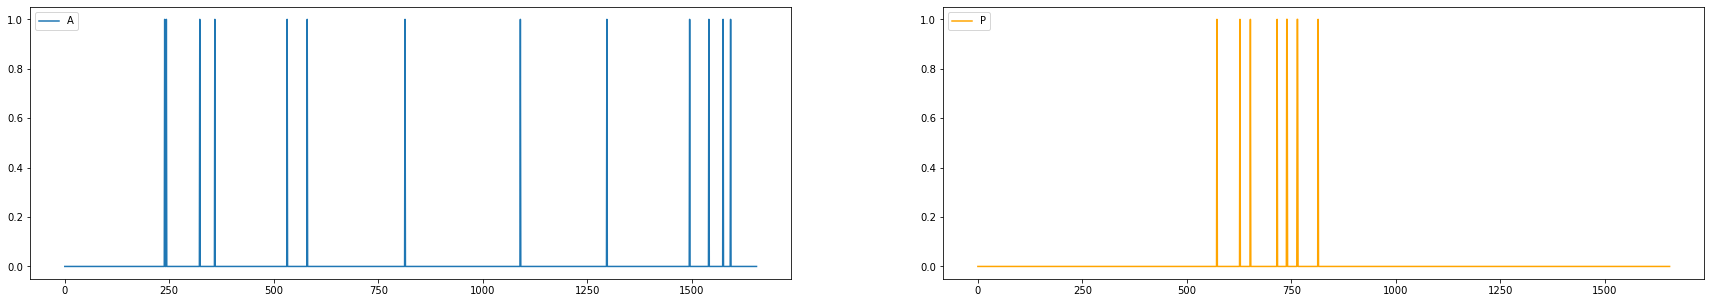

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS80.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS80.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.40664577e-06], Max [0.39156675]
Deviation 99.5th pctile [0.21738675]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1642    2]
 [   5    7]]
precision 0.77778, recall 0.58333, f1 0.66667
Time to predict and get records above deviation : 885456 ms


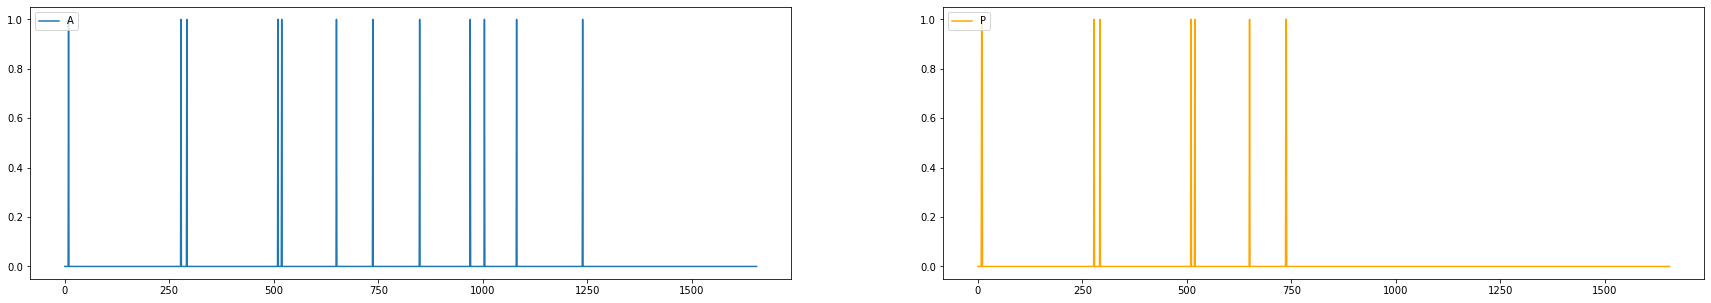

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS81.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS81.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.78226383e-05], Max [0.43953271]
Deviation 99.5th pctile [0.186231]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1648,    8]))
Confusion matrix 
[[1646    2]
 [   1    7]]
precision 0.77778, recall 0.87500, f1 0.82353
Time to predict and get records above deviation : 887467 ms


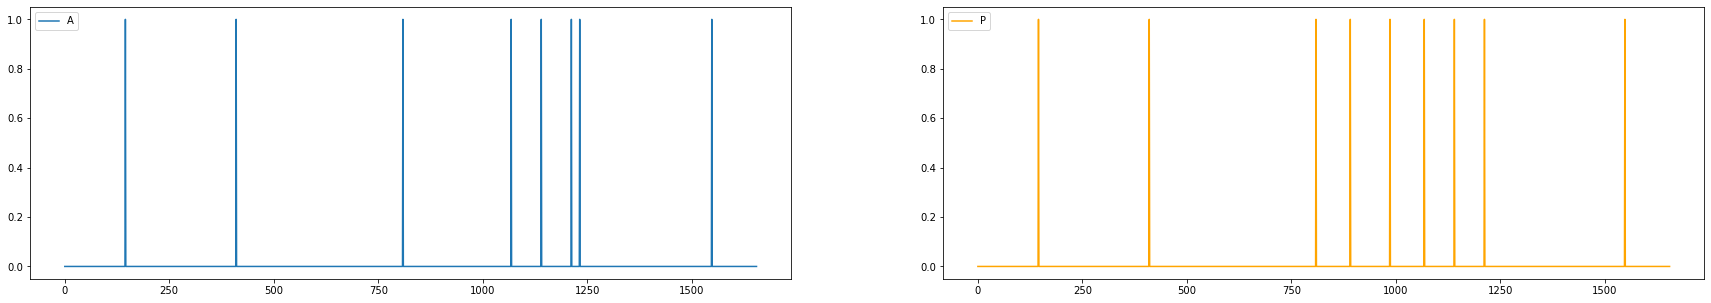

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS82.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS82.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00030991], Max [0.51355425]
Deviation 99.5th pctile [0.28650041]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1642,   14]))
Confusion matrix 
[[1642    0]
 [   5    9]]
precision 1.00000, recall 0.64286, f1 0.78261
Time to predict and get records above deviation : 889828 ms


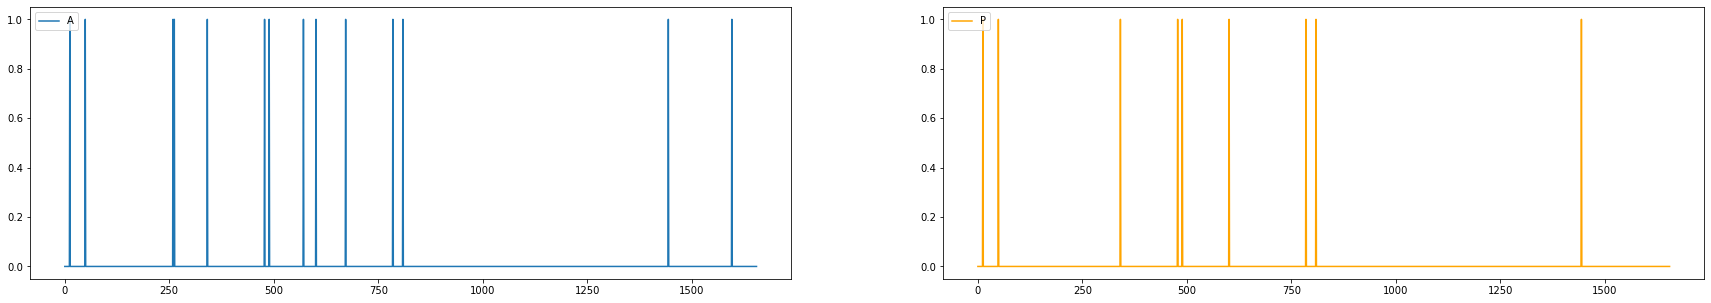

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS83.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS83.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.51075427e-06], Max [0.28096732]
Deviation 99.5th pctile [0.26061053]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1644    9]
 [   3    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 891990 ms


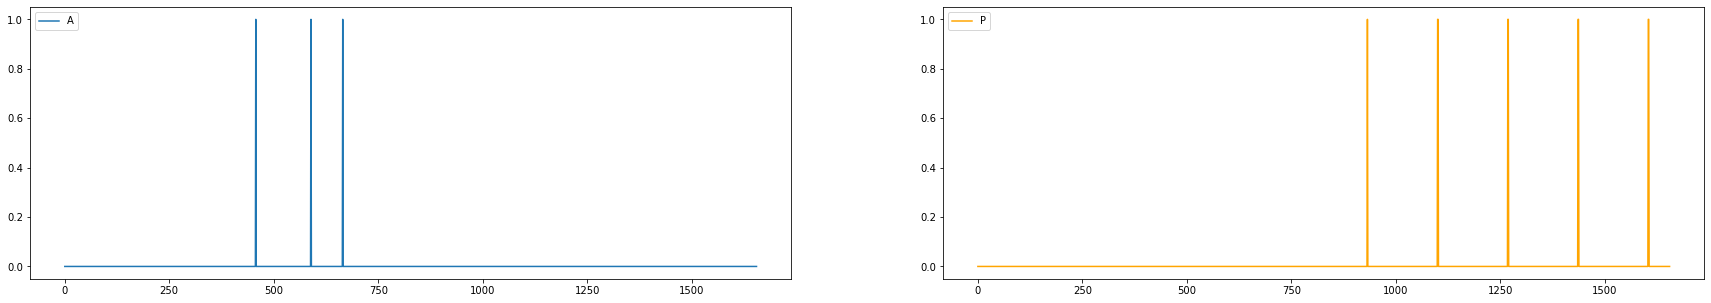

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS84.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS84.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [2.22919332e-06], Max [0.26413274]
Deviation 99.5th pctile [0.23006339]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1653,    3]))
Confusion matrix 
[[1646    7]
 [   1    2]]
precision 0.22222, recall 0.66667, f1 0.33333
Time to predict and get records above deviation : 894730 ms


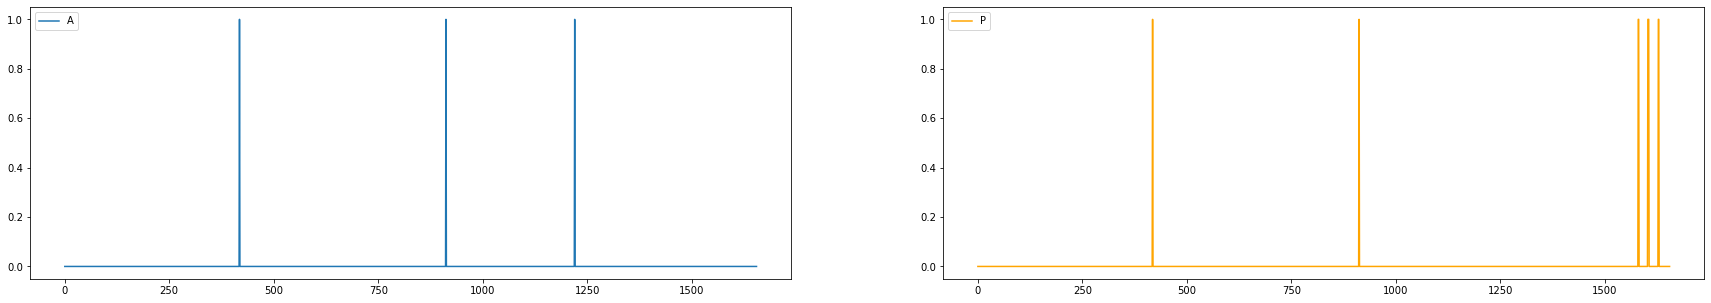

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS85.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS85.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.40681495e-05], Max [0.46242804]
Deviation 99.5th pctile [0.23391473]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1640    0]
 [   7    9]]
precision 1.00000, recall 0.56250, f1 0.72000
Time to predict and get records above deviation : 896900 ms


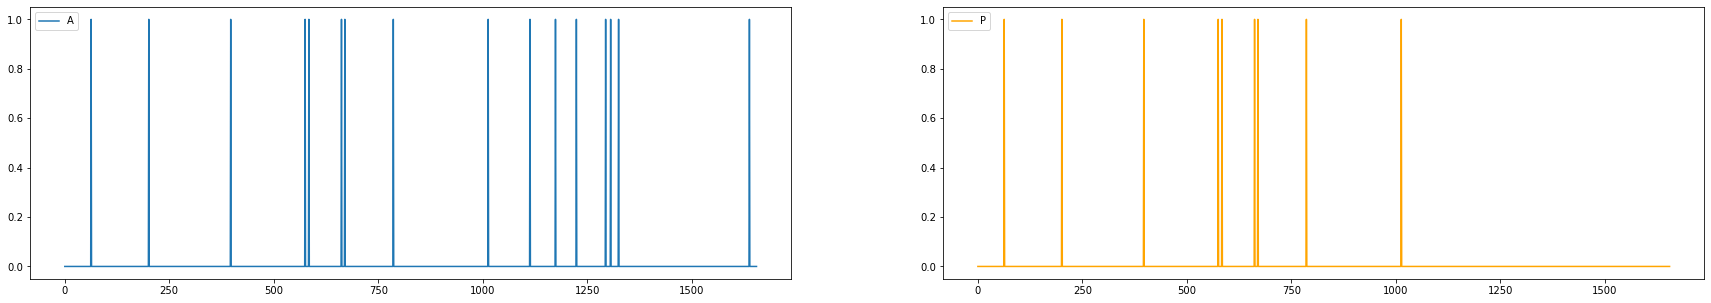

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS86.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS86.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00011744], Max [0.46166825]
Deviation 99.5th pctile [0.25532132]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1639    2]
 [   8    7]]
precision 0.77778, recall 0.46667, f1 0.58333
Time to predict and get records above deviation : 899337 ms


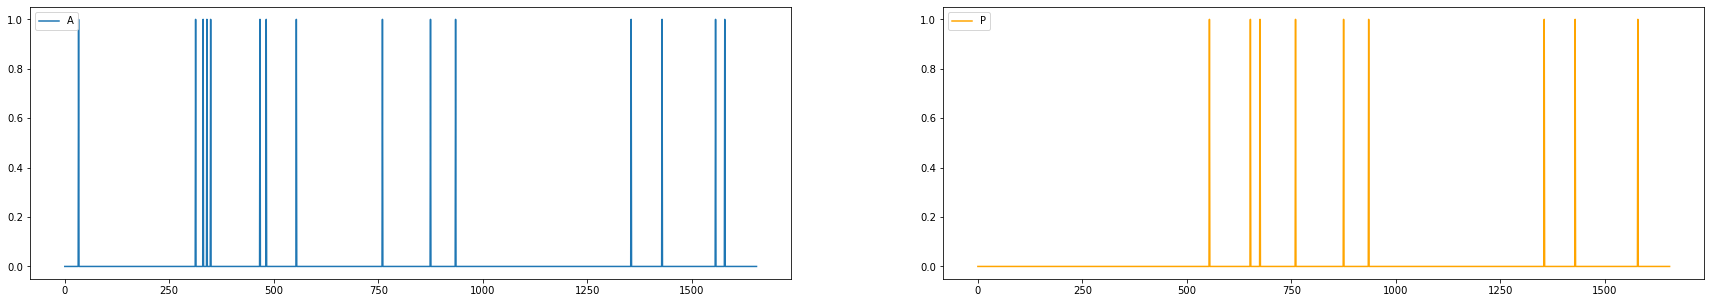

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS87.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS87.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00012044], Max [0.33140913]
Deviation 99.5th pctile [0.1559411]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to predict and get records above deviation : 902858 ms


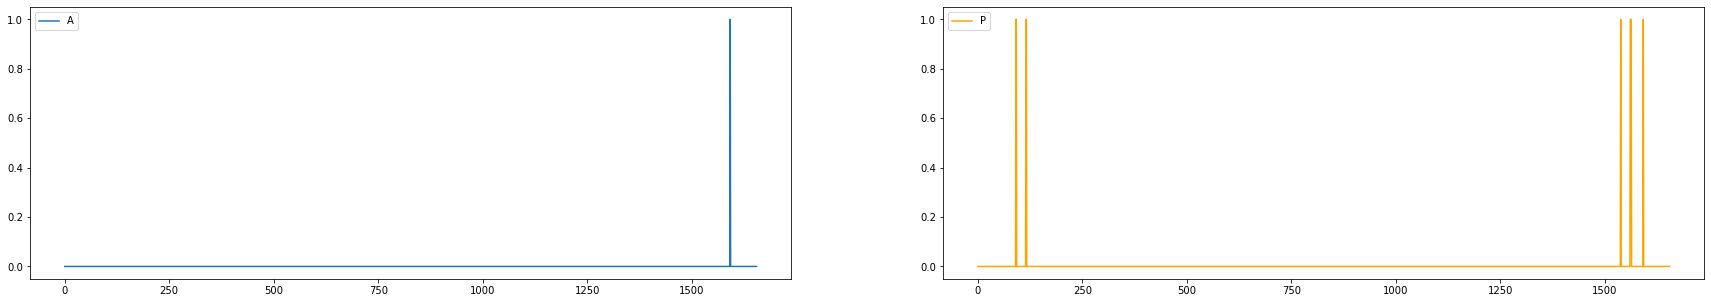

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS88.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS88.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00035901], Max [0.58236003]
Deviation 99.5th pctile [0.33972676]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1638    5]
 [   9    4]]
precision 0.44444, recall 0.30769, f1 0.36364
Time to predict and get records above deviation : 905234 ms


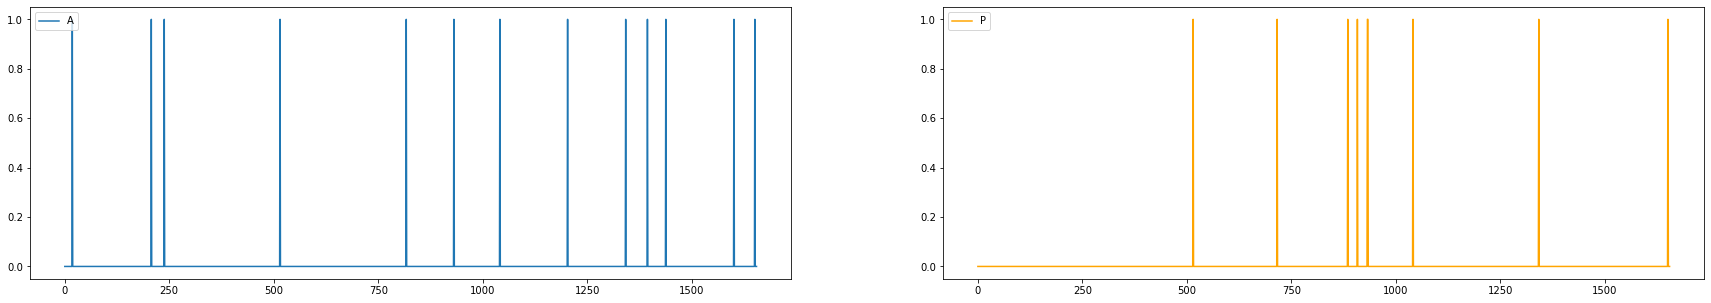

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS89.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS89.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.03901522e-06], Max [1.13715136]
Deviation 99.5th pctile [0.41184571]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Confusion matrix 
[[1641    6]
 [   6    3]]
precision 0.33333, recall 0.33333, f1 0.33333
Time to predict and get records above deviation : 907529 ms


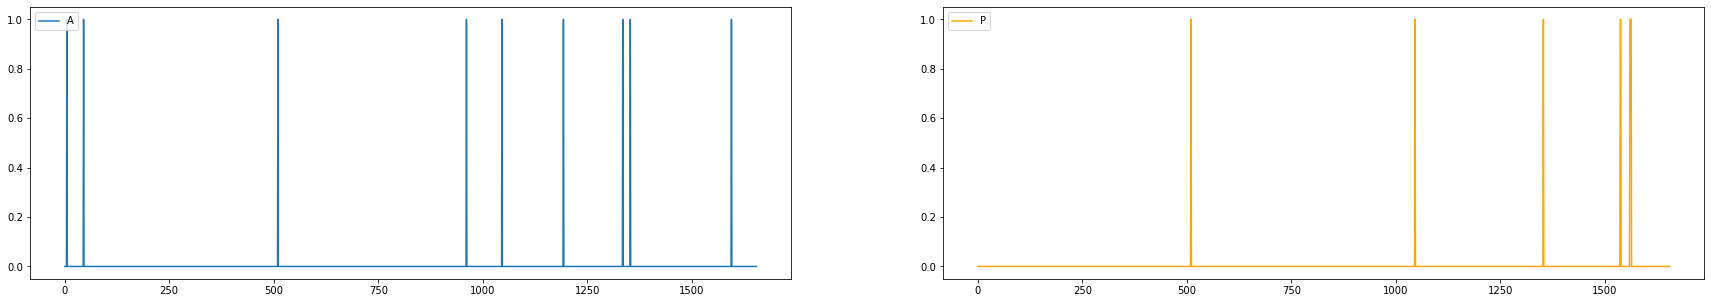

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS9.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS9.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [4.14290665e-05], Max [0.48002465]
Deviation 99.5th pctile [0.38894992]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1646    9]
 [   1    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 909563 ms


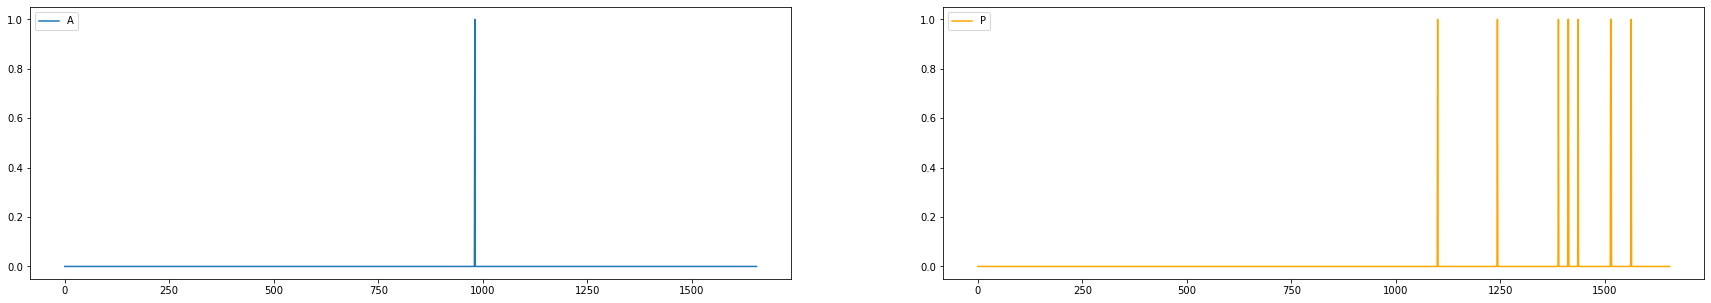

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS90.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS90.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.38751854e-05], Max [0.33369506]
Deviation 99.5th pctile [0.21152537]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1643    1]
 [   4    8]]
precision 0.88889, recall 0.66667, f1 0.76190
Time to predict and get records above deviation : 911274 ms


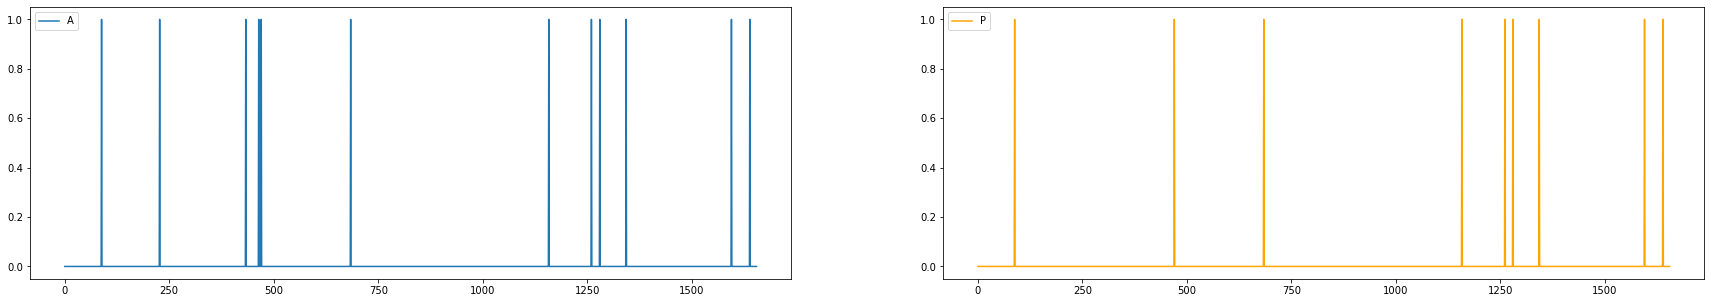

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS91.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS91.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [8.77757729e-06], Max [0.26536241]
Deviation 99.5th pctile [0.22325119]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1644,   12]))
Confusion matrix 
[[1635    9]
 [  12    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 913705 ms


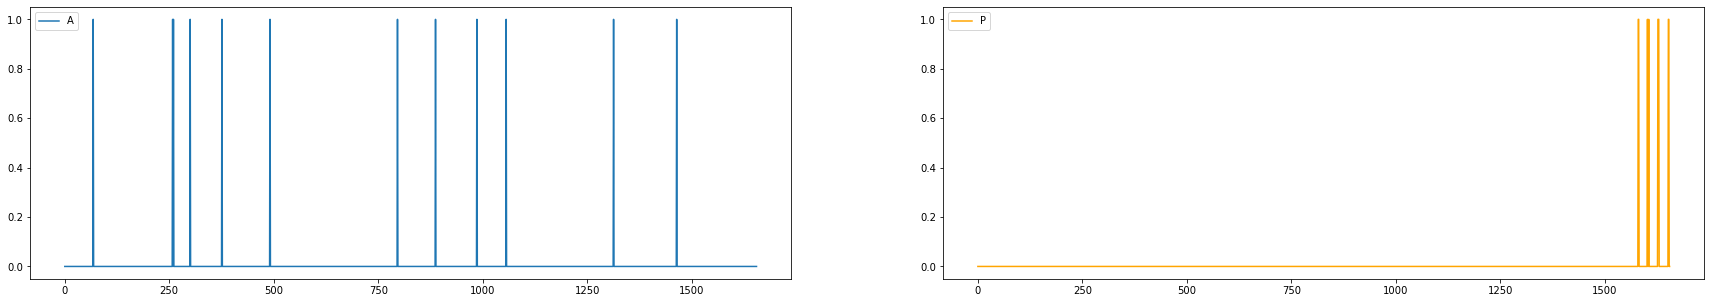

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS92.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS92.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.64993116e-05], Max [0.17958246]
Deviation 99.5th pctile [0.16249129]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1632    9]
 [  15    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to predict and get records above deviation : 916517 ms


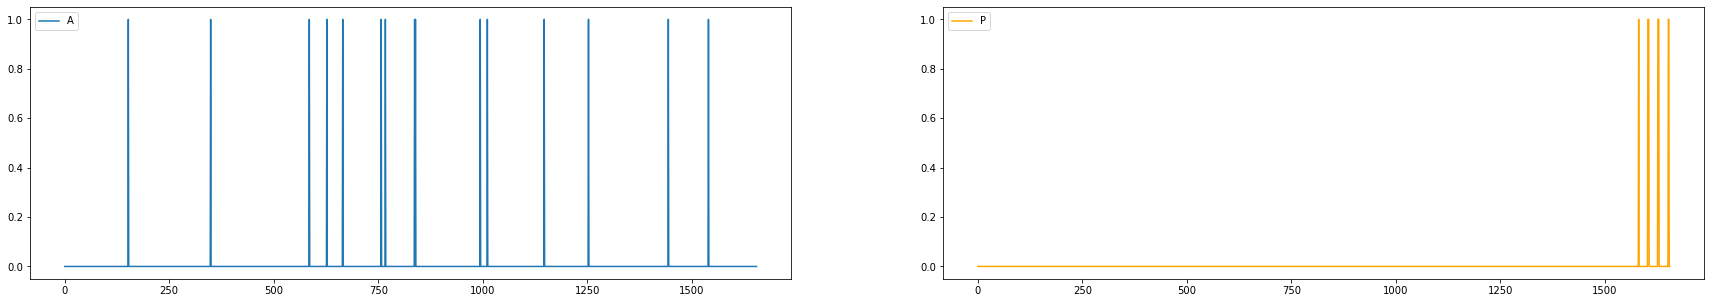

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS93.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS93.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [7.96725894e-05], Max [0.51911584]
Deviation 99.5th pctile [0.21214596]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1650,    6]))
Confusion matrix 
[[1646    4]
 [   1    5]]
precision 0.55556, recall 0.83333, f1 0.66667
Time to predict and get records above deviation : 918994 ms


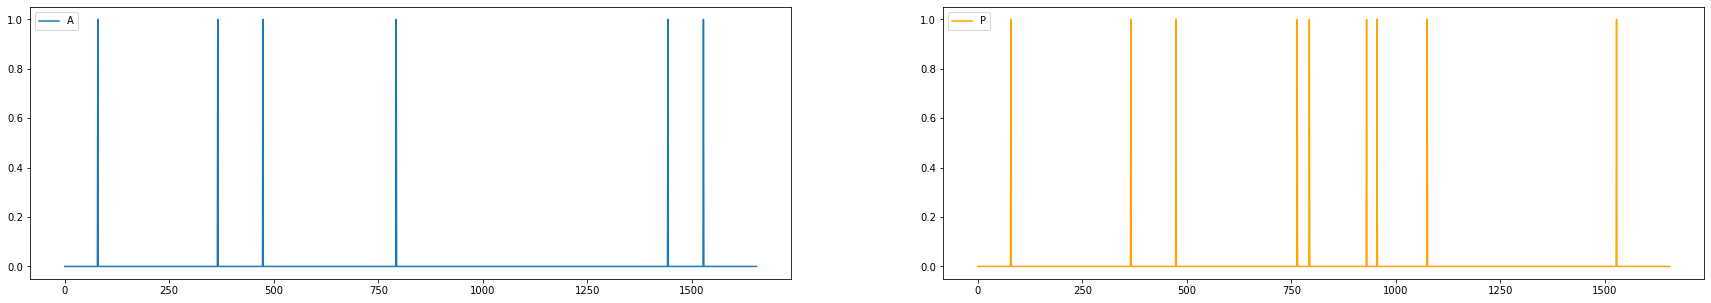

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS94.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS94.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.1844956e-05], Max [0.33317479]
Deviation 99.5th pctile [0.19412466]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1641    2]
 [   6    7]]
precision 0.77778, recall 0.53846, f1 0.63636
Time to predict and get records above deviation : 921248 ms


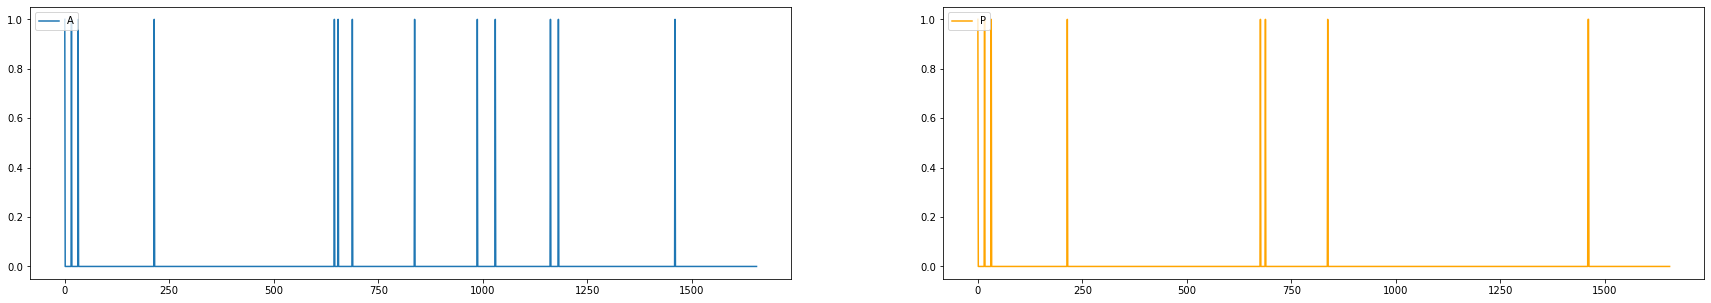

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS95.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS95.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.11124016e-05], Max [0.32059833]
Deviation 99.5th pctile [0.11866869]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Confusion matrix 
[[1646    5]
 [   1    4]]
precision 0.44444, recall 0.80000, f1 0.57143
Time to predict and get records above deviation : 923693 ms


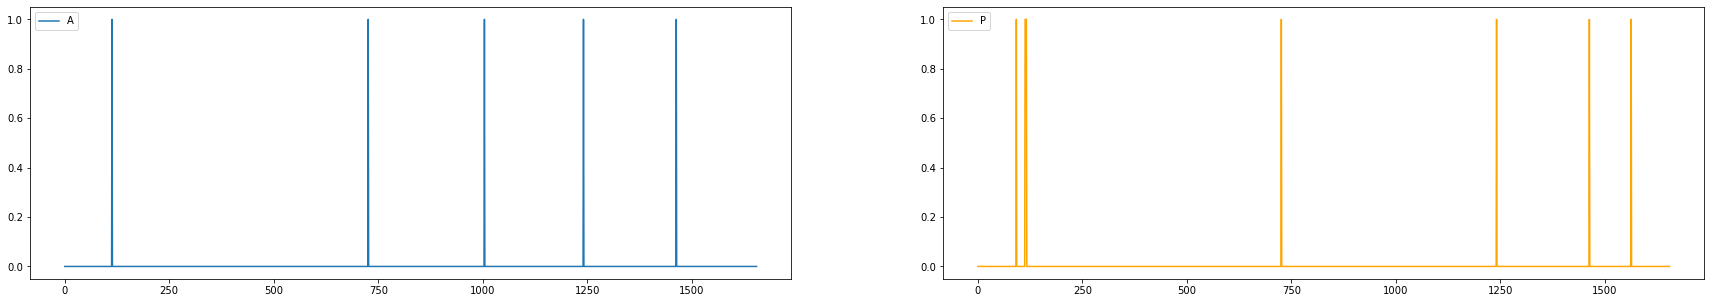

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS96.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS96.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [1.37701917e-05], Max [0.35248542]
Deviation 99.5th pctile [0.13690868]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1654,    2]))
Confusion matrix 
[[1647    7]
 [   0    2]]
precision 0.22222, recall 1.00000, f1 0.36364
Time to predict and get records above deviation : 928153 ms


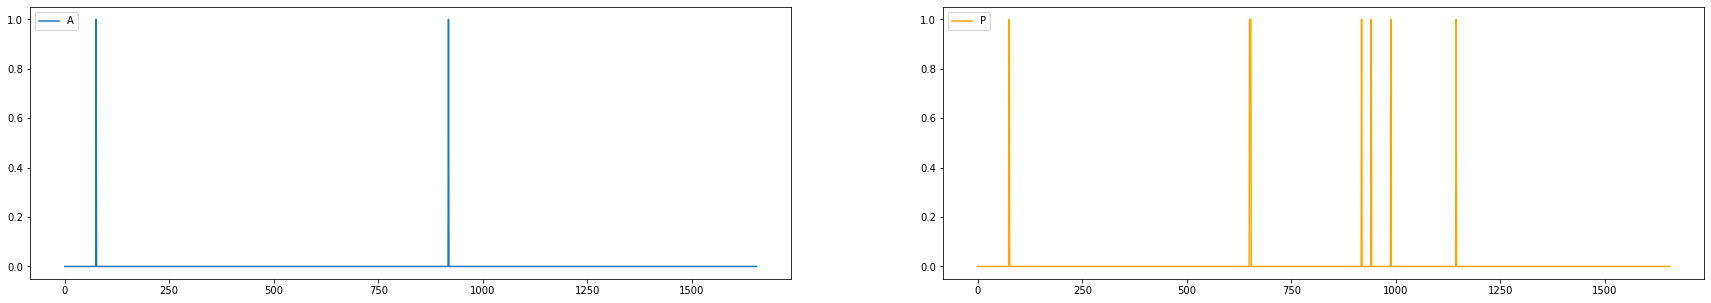

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS97.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS97.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.62669416e-05], Max [0.3162417]
Deviation 99.5th pctile [0.20475245]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1639    1]
 [   8    8]]
precision 0.88889, recall 0.50000, f1 0.64000
Time to predict and get records above deviation : 931318 ms


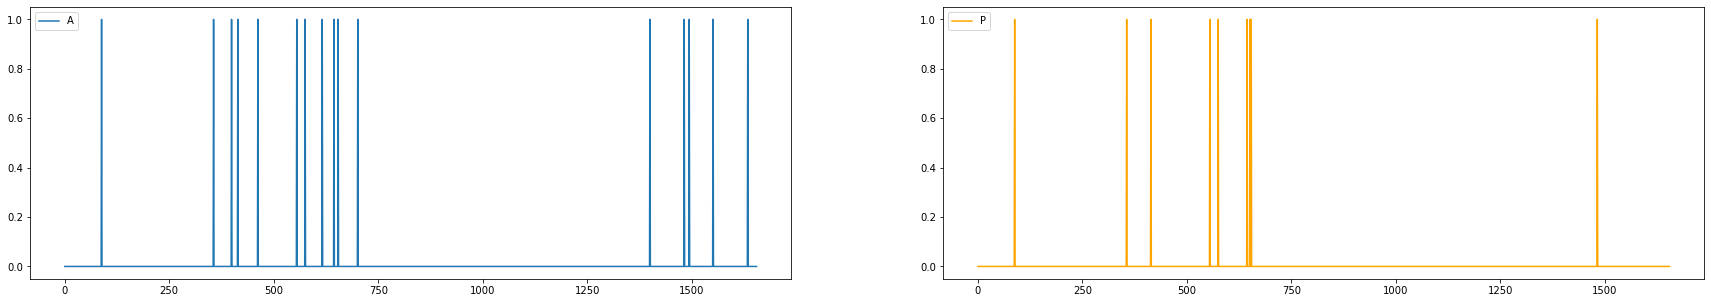

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS98.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS98.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [0.00012968], Max [0.23656549]
Deviation 99.5th pctile [0.13131333]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1636    5]
 [  11    4]]
precision 0.44444, recall 0.26667, f1 0.33333
Time to predict and get records above deviation : 934414 ms


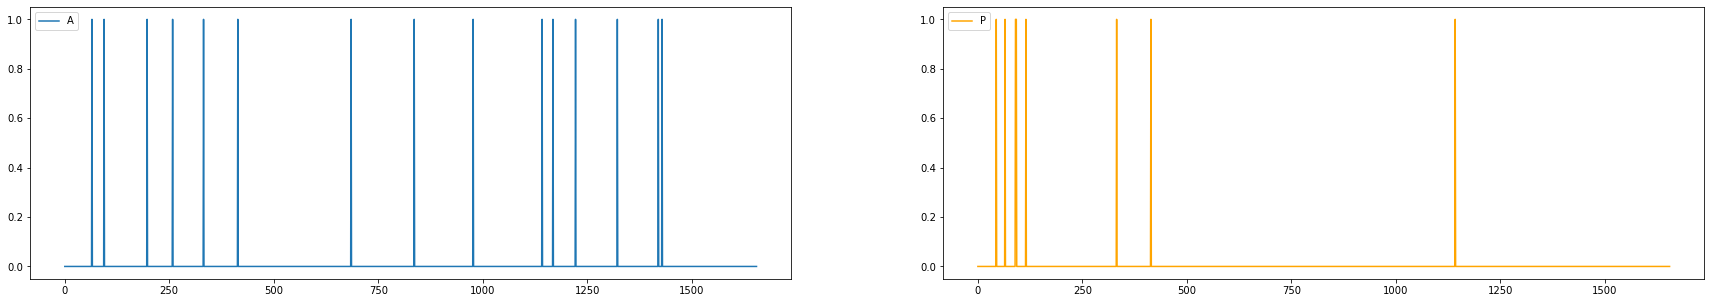

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS99.csv
Model file will be loaded from  models-yahoo-lstm/A4Benchmark/A4Benchmark-TS99.csv.h5
Shapes: time variant data with labels (1680, 2), full data (1680, 9)
Look back data shapes: lookbackX (1656, 24, 1) lookbackY (1656, 2)
Deviation Min [3.34078454e-05], Max [0.54627758]
Deviation 99.5th pctile [0.37602834]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1640,   16]))
Confusion matrix 
[[1633    7]
 [  14    2]]
precision 0.22222, recall 0.12500, f1 0.16000
Time to predict and get records above deviation : 937585 ms


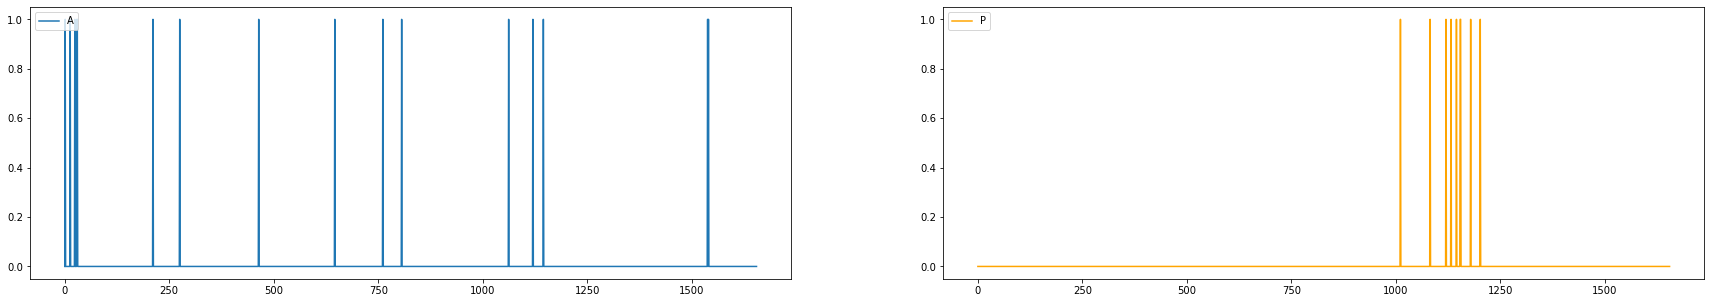

Total Time to process all the selected files : 938272 ms
A1Benchmark
     Avg precision 0.62447 recall 0.51514 f1 0.46493 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


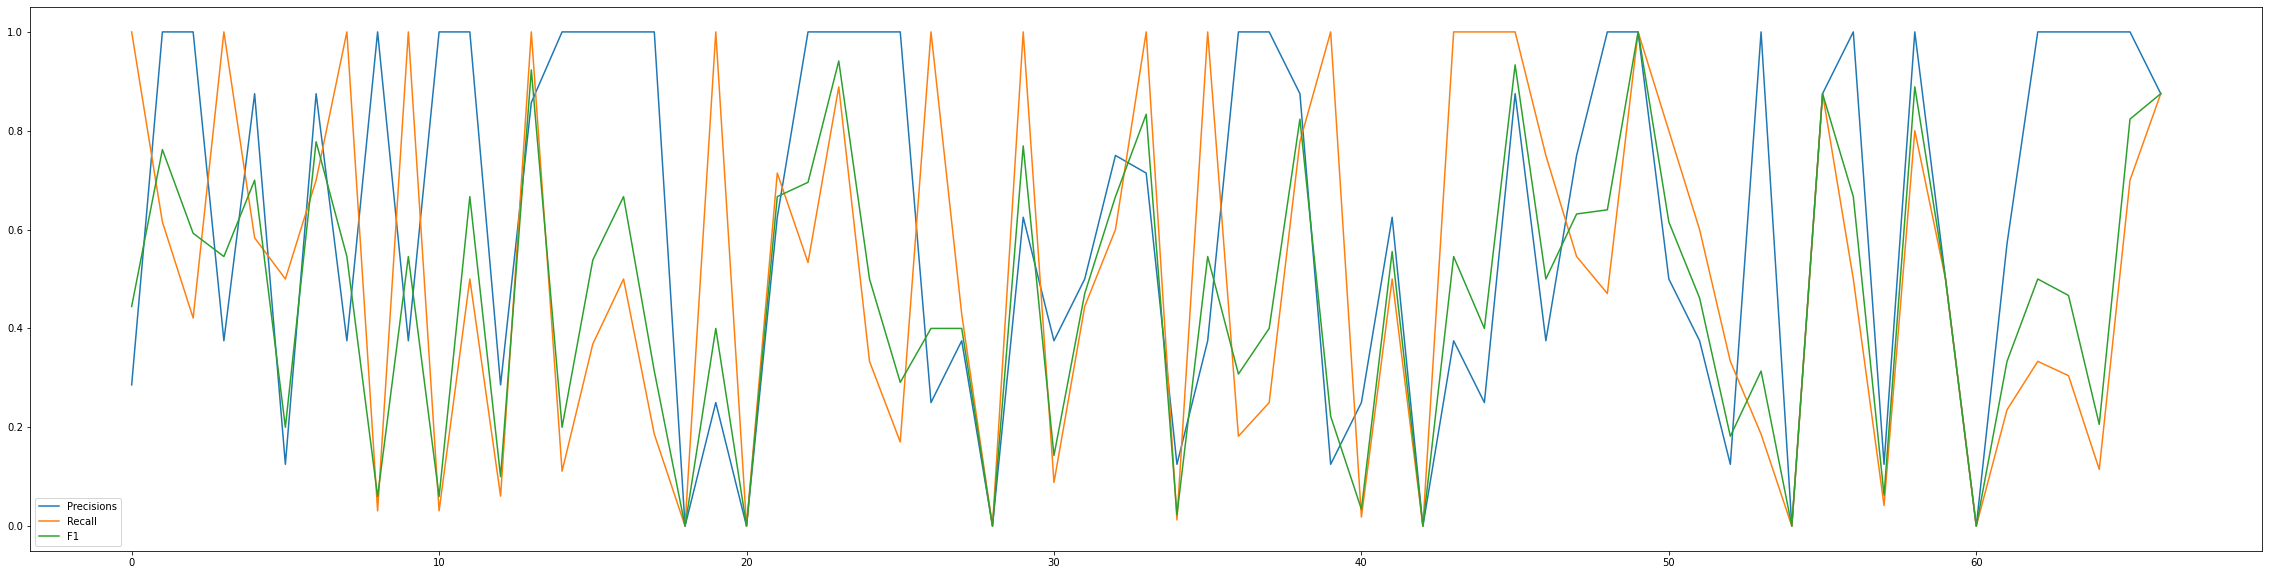

A2Benchmark
     Avg precision 0.57143 recall 0.92667 f1 0.61852 
     Min precision 0.14286 recall 0.77778 f1 0.25000 
     Max precision 1.00000 recall 1.00000 f1 0.87500 


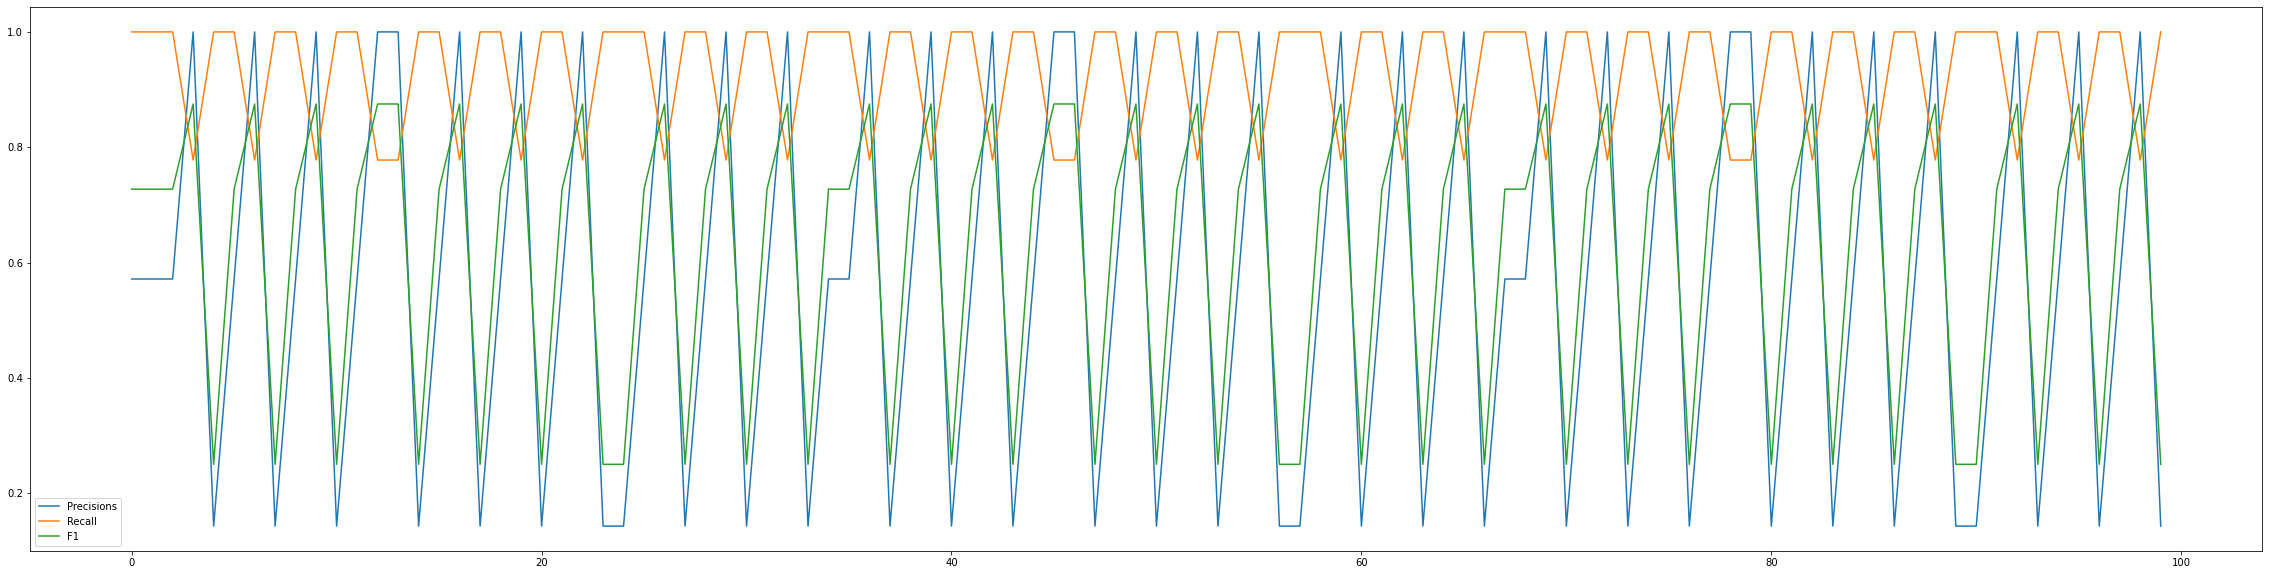

A3Benchmark
     Avg precision 0.60889 recall 0.65935 f1 0.58570 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


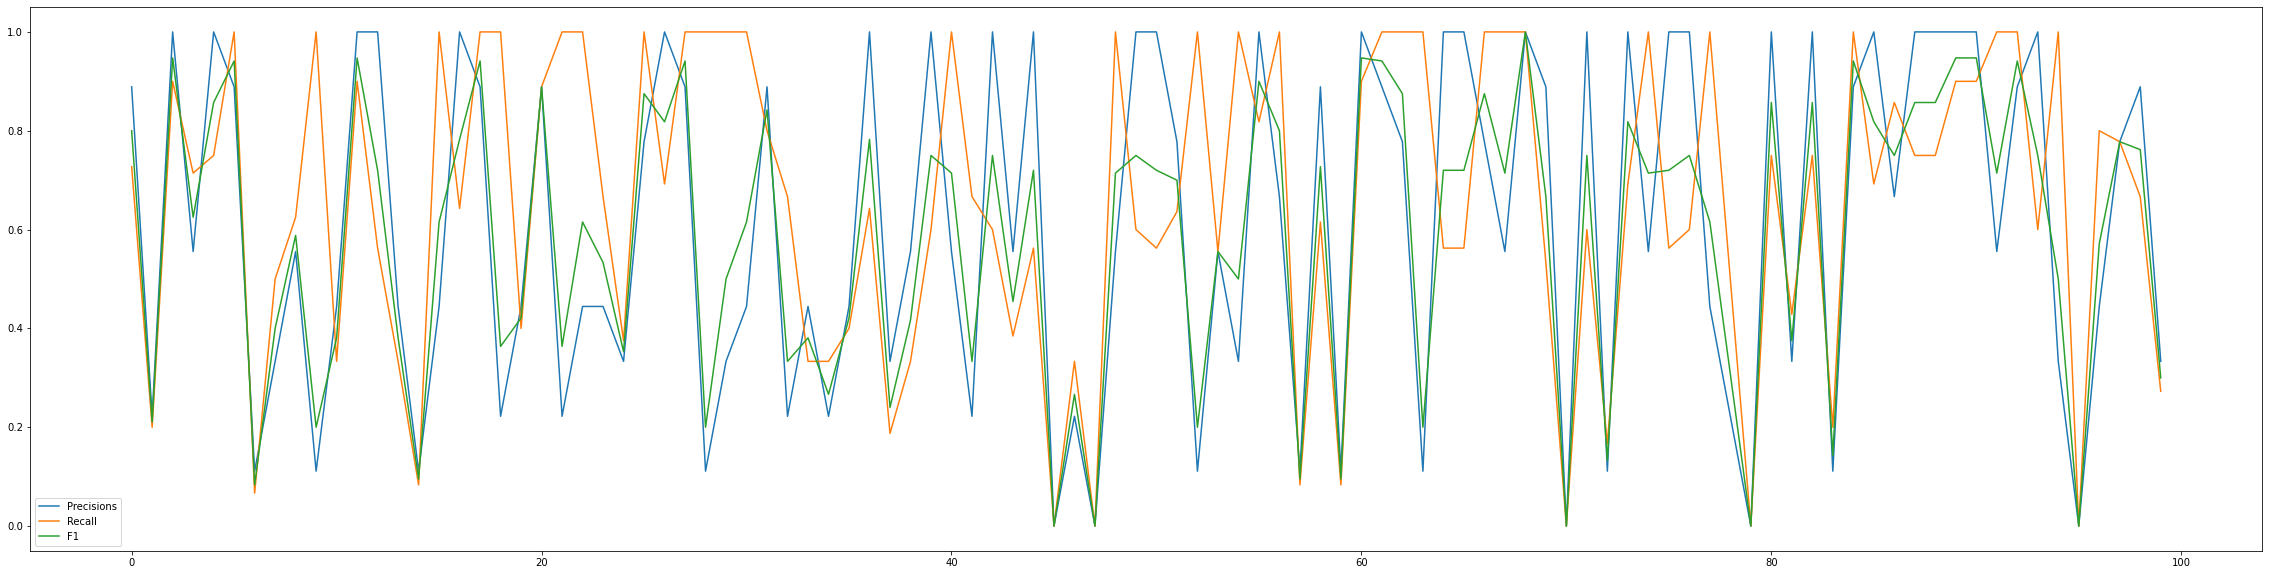

A4Benchmark
     Avg precision 0.44222 recall 0.53925 f1 0.43755 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


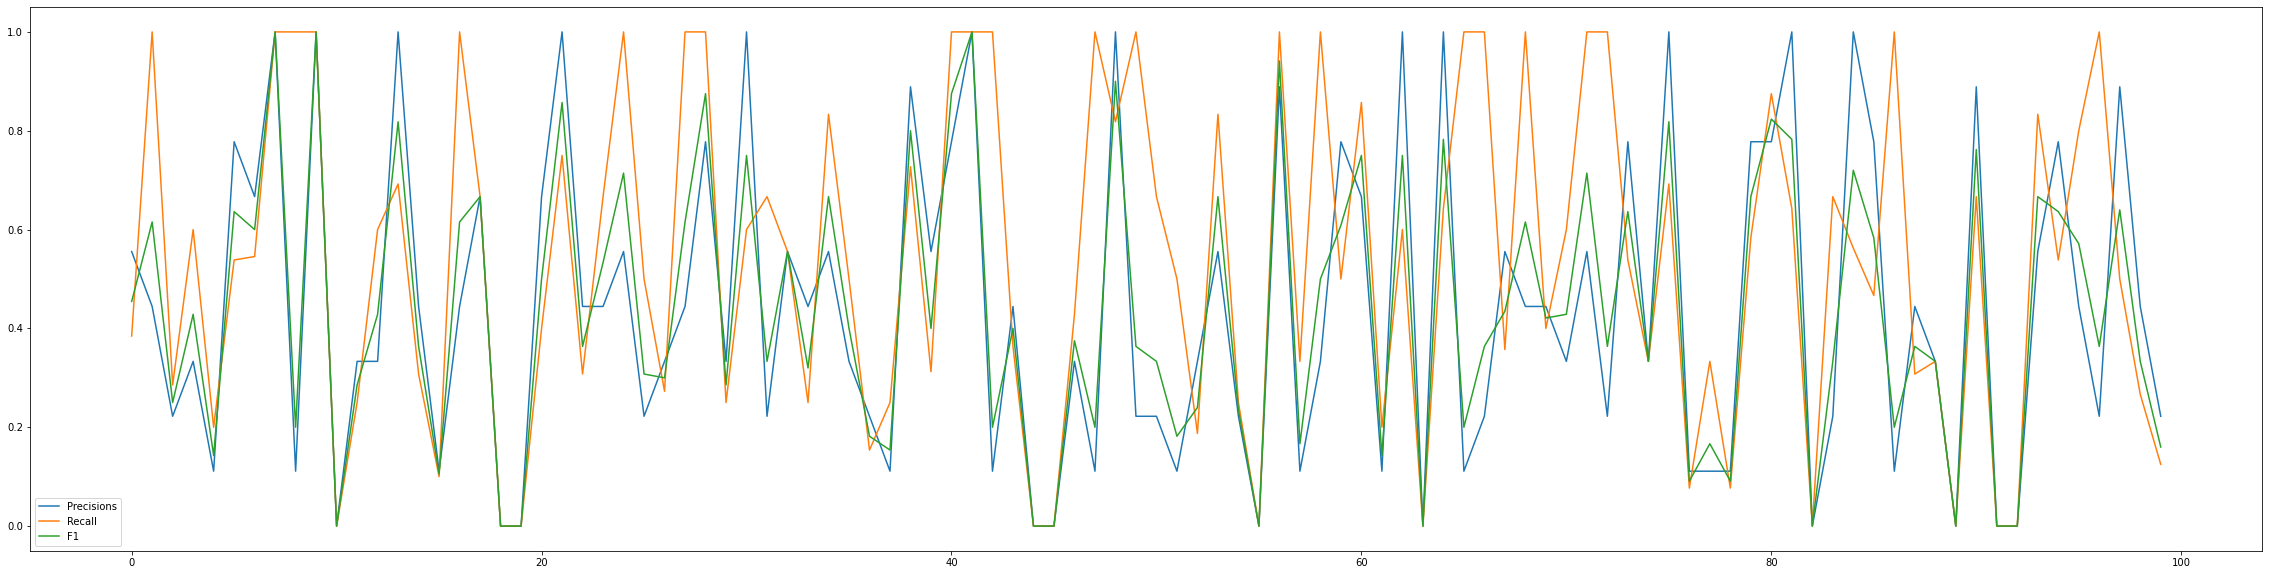

In [2]:
YAHOO_DS = "../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"

DIRS_FILE_EXTENSIONS = {'A1Benchmark': "*.csv", \
                            'A2Benchmark': "*.csv", \
                            'A3Benchmark': "*TS*.csv", \
                            'A4Benchmark': "*TS*.csv"}

directoryResultsMap = {}
start_millis = current_time_millis()
for folder in DIRS_FILE_EXTENSIONS:
    extension = DIRS_FILE_EXTENSIONS[folder]
    timeVariantColumns = ['value']
    labelColumnNum = 2
    resultsMap = perform_training_on_benchmark_directory(folder, extension, timeVariantColumns, labelColumnNum,
                                                             files_to_process='ALL', plot_graph=1, file_name_preferred=None)
    directoryResultsMap[folder] = resultsMap

end_millis = current_time_millis()
print("Total Time to process all the selected files : {} ms".format(end_millis - start_millis))

# finally Print summary for each directory
for directory in directoryResultsMap.keys():
    print_summary_for_benchmark_folder(directoryResultsMap[directory], directory)
    